This notebook performs xgb classfication on all Brucella genomes from NCBI by looking at the presence and absence of the top 3320 25-mers selected by ANOVA. Hyperparameter optimization was done in a_xgb_hyper.ipynb. After the classification, the results were illustrated by feature importance table from eli5, and visualizations of SHAP plots.

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

In [2]:
print(1)

1


In [3]:
# list of best 25-mers obtained by ANOVA on 20% split - see a_ANOVA.ipynb(low test scores ~ 0.6)
lis = ['CATCCGCTGTTGCATTCCAGAATTC', 'GGATTTTCCGCCCCGCCGGTGGTGA', 'CAACGGAAATCGAAGTGCTGGCGGC', 'CCTGATAAACAGTTTCTATTCCTGC', 'AGCGACGCCATCTCACAGGGCGAAC', 'CCACATGGTGCGCTTTACACGTGCG', 'CGGTTCGGCTGGCTCCGGTTCAGGC', 'ACCAATTGCGCGATTCGTCAGCAAG', 'GAATTGCCCGTTCAAGAAACCCTGC', 'TCGATGCATATGCGGCCAAGGCAAA', 'AATCTGATGGAAAATCTGGACACGC', 'CCTGCACAAAATTGGCTTGACCAGA', 'CACGAGCATTAATCTTGGTCAAAAG', 'CTGAGAGGTCCAAAGAGCATTTCCA', 'GTAAAAAGTTTTGTTGCAAACTTAC', 'AACGGCAAGGTGGTGCGCGCGCGCC', 'GACGAAGTCGCAGATGAGAATGCCA', 'CATGGAATATCGACGTCGGTTCTTC', 'CTGAAAATTCTTTGAGTGTCATTAA', 'CAACTTCCTCGGCGCGTCCGAGCCG', 'CAGCGGCTGGTTGCCGAATTTTTCA', 'AGGCGAAATTCAGGGCTGAAACCGC', 'CGATGTTCGGCGCACCGCAAAAATC', 'AAGTGAAAAAGCCTGATGAAAGCAA', 'CGCTCTGGTCATTGCTGCTATTCCG', 'CCCGACGGGGATGGATTGTCCGTGC', 'GCATCCCAGCCGCCAACTTCTTCCA', 'AGGCTCCCAGACGCCAGCCACCCCA', 'GTCTTCGAGACGGTCAAGACGCTGA', 'AGTCGAAAATCGTTTGAAACAGGAA', 'CCTGCGAGCGGTTGCGGTTCACGCC', 'AGGCAGTAGAGATTCCATAATCGTC', 'GAACCGGCTCGCCGTTTCAGCTGCC', 'TAACACGATATGCCACATCATCATA', 'AAGCCTCTGTTTTATTTCGCATATT', 'GGGACGAGCGGCAGGTGCGCATCAC', 'CGCACGGCCATCTTGTTGATGCCCA', 'GACTCACGCGTCATCGTCGCCATCA', 'AGGGCATCGAACTCACCAAGAATGG', 'ACTCTAGCAAGCGTCGCGCGTTGCG', 'AGAGATTGAAGTTCTGAAACACCAT', 'AATGACAATGGGTGAATTTTCCCAC', 'CCGATTACCGAGCTCGATATTGATA', 'GTGACGATAATCATGACCGGGCGCA', 'GCTATGTGCGGCTGGAACCGCTGAA', 'ATTGCGAGGCCAGCGGCGGTTGCCA', 'GAACCATGGTCATGCCCTTCTTGGC', 'AAGGCCATGCCGAGGGGCTTGCGGA', 'CAAAGTTGGGGCAGAGGCAAGTTGG', 'GAGAGCCTTGGCGCCCGCTTCGCGC', 'CTTTCAAAACTTCACCGTTTGGTAA', 'AACAGATGCCGCCAGAGCCGGAGCA', 'CCAGCGGCTCCGCCATCAATTCGCG', 'GCGCGGTGAATTTGCGCGTCAATGA', 'CACAAGCGCGTCATTTCCGCCTGCG', 'ACCTCGCCACTGCCGATATGAACTA', 'CCTTCATTACGCGGAAGGAGTTGAA', 'CAAGATTGCCGAACGCATGGCGGAA', 'GAAGGCTTTCTGCACACCGCGCATC', 'CACGGCACATGCGGACAATGGATCA', 'ACGTCATCGATGAATATCCTGATAT', 'ATTATGATTCCGTCACGCCGGGCGA', 'CTACCGAAAATGTTGCCGAGGCCGA', 'CATGTCGATGTCGATGCGGTTGGCG', 'AACGCGTCGAACTACTGAAGAAACT', 'AACGGCGAGGGTGCGCAGCGCTGCA', 'AATTTGCCGATCAGATGCGGGCGCG', 'CCGGCCGTATCGTCGACTGCGAATC', 'CGCCTTCGACCTTCTCCCGCGCGTC', 'CGATGGCGTGCAGCAGAAAAACACC', 'CGAGATCGCTGACAAGACCGCGCAG', 'ATCGACGGCGAATATGTCCGCAGCG', 'ATGGTTCGCCCCCAGCCGGTGCCGA', 'CGATCATCGTGGAAATGGCCGAGCC', 'CCCCGGAAAATTCTTACTTAGGACG', 'GCCTGGCGCCGACAGTCAGTAAACC', 'GAACGAGAAAACCTTGACGCTGCGC', 'GCAGGGCAATCGATTTCGGCATCGA', 'CATGGGAGACAGTGTGATCCAACAG', 'AGGATACGATGATAGGCGCGGGCGG', 'CGAGAACAACTTTGGGGCGCCATCG', 'CGACGAGCGGCAGTTCGCGATCGTC', 'CCAAGGCAATGCCAAGTGATTTGGC', 'CGATGGCGACGGCGATCAGCCCATC', 'GAGAGGACCCATGGCGAAATCCGGC', 'GCGCGCAATCCGGGTGAGGGGGAGC', 'ACGATGAAGGGCTTGTCTTTGACCG', 'AGAAAATTTGTATTGGAGTTGAGGG', 'ACCTTCACTTCGCGGAAATCGAAAT', 'GCCTTCAATTACGAGAAAGCGTGAC', 'ACAAATGAAAAATATGTTCCCGGCA', 'ATGAATCCATTTAACTGCGACATGC', 'AAACCAATCTCGTCCTGGGCGTCCA', 'AATTGCGTTTATGCACCGAACAACA', 'CGAAACACCTTTTGCAATAGCGTCA', 'ATCCACTGGCAGAAGACCTGCGTCA', 'CTATCGCGCCCTTTCCGAACTCTTC', 'CGGCACTGCGCGGCGGCATCAAGAA', 'AAAGCTCGGGATTGATTGTCGAGCG', 'CCCAAGGCTCATTTCGATCAACTGA', 'CCCCACCAAACAAAACTGTCAACGC', 'GAGCTGTGTTGCCATCAGCGGAACC', 'CATTTTGCTTTCGATGTCGAGAATC', 'CAGGGCTTCACCGCAGCATAGGATC', 'GCCATCAATGACAAGGACAAACAGA', 'AGCCAGACCGAGACCGCCTGCTCCG', 'CTCAGGCCGCCGAACCGTCCCGACA', 'AAGCGAGGAAAACATGGATATTCGC', 'CATCAGGCGTTCATAGTCGATTTCG', 'TGAGCAATGTCTTAGAGCTTACGCA', 'ATCCTGTGCTGAAATGGGAATAGAA', 'AGCGCCGGTTTATCAGTCATTCTCA', 'ACGGGTCATCCGCGACAAACCACAT', 'CGTTGCTGGAGCGCTTCATAAAAAG', 'ATGTCCGCGTTTGCGACGCTTATGG', 'CGCTGGCGGCGCTGAAGAACTTGTC', 'ACGCCTTCATGGCTACGCTGAACCC', 'CGGCGCCAGCCGCAAGTGCAGTTTC', 'CCACCAGAAAGGCGGCGCCTCACTC', 'AGCCCTTCAAAGCATTCTTGCTTGG', 'AAATGGCTTATATCACAGGTCTGTT', 'AAGCAATCGTCTCGCCAATCCATTC', 'CCCGAATTCATGGCCATGATGGCAC', 'TGAGCCGCGCGCATGACCGCCGGAA', 'AGAAATAAAAAACCGCCCTCAGGGC', 'ATATTGATAGAACAAGCGGGCTATA', 'CATGGGAACGCGCGTCGATCAGGCG', 'GAGGTATACGGTGTTCAAAGCGTGC', 'AATTTCATCACGCAACGCCTCCGCG', 'CAACAAGGCTTTCCTCGAAGCCAAG', 'CGATCCAGACGGCTGTCCGCTTTGC', 'CATTATCTCGACCTACCAGCTTGCG', 'CCGGCAAAGGCACCCAGACCGGGAG', 'AATGTCATGCTTGACCCTGCCGTGC', 'ACGGGCTGGGCTGGTATACAAATTC', 'ATGTCCAGTAAGACTATCGCCCCCG', 'GCACGAGCGCGAGGAAGTTCGCGCC', 'CTTCGGCGTTGCCGTGAGGCCGGCC', 'CCGAGATTGCAACAGGGAAATTACA', 'GAGGGCGTGAAGCAGTGGCTGATGA', 'CTGTGGTTCGCATGGCGCGCCGTGC', 'AACGCCTTCGACCTTCTCCCGCGCG', 'AGGCGTTCGGCGGCGCGGGTAATGG', 'CCCTTCCGGTTTTGAAGACCCGCAA', 'TCGAACTGGGCTTCACCGGCAACGA', 'ACCTACCTCATTGCGATCGGCGATC', 'TGCGTCTGGTTCCGCTTCCTGTAAA', 'ACGGCTGAACTACGAGATGCGCTGA', 'ATGACAACGACATCGGCCTGCCGCG', 'CAGCCCGTTGTGGATCATGTCTTTC', 'CGGATCGCTATCTGGAACAGCGCAA', 'CAACGCGCAGGATTCCACGACCAGC', 'CACCGGCTGGGGGCGAACCATAGAA', 'GCGCTGAAAGAAGGTCAGGTGCAGC', 'GCCGTCTCTGTTGGGAATTGATAGC', 'GCAGCTTGTCGGTGACGATCGAATA', 'GAGATATCCACATTATCTCCAATCA', 'AGTGATCTTGACGATGGAACCGTCC', 'CCCGGACGCCCTGAAAAGCCGGAAC', 'ATGCCGTCACCACGCTTGGCCGGGC', 'GGACTGTAAATCCGTTGGCTAAGCC', 'ATCGTCAATCCGTTGGAAAGACGCG', 'GGCGAGCATTTTACCGTCTTTCGCA', 'ATGGGCTCGCGTCGATTATCCGAAG', 'ATCTGCGCGCCGATCTGGAAGAACG', 'AAGCGCAACCCGGTTCTGACCGAGA', 'CGGAATGGCGATCCAGGTCAGCGCC', 'AGGGCGTTCGCGCATTGCTTATCGA', 'AATCGTATCTTGAGGGAAAGCGATC', 'AACAAGCCAAGGAAAATTCCGCGAA', 'ACAAGCGATATCGTCAATAAATGGG', 'ATCGAGCGCGTCGGCCTCGTTCACC', 'GACGAGCAGGATACGCATGGCTGAC', 'GAAGCCAGCCATGACACCGGACCAA', 'CATCGCCGTCAGCCATGCGAACAAG', 'CTGCCTTCCGGCGGAAGGGCCGCGC', 'AAGGACTGGAGGAGGGTCGCGACAC', 'GAATGGATGCGCCGACAAGTGCGCC', 'CCGCGCCGTTCCTCACGCTGAACGA', 'CCGAGCCTTCCAGTTCCAGATCGAA', 'AAATTATTGTGACAACCTAACACAA', 'GCTGTAGAAATCGAGTTTACCGTCA', 'CACACGGGATTGGGCTTTTGCAGGG', 'GACGGGCAAGCAATGGAGGAGAACC', 'GCTATGAGGCGATTTTCCCGGACGA', 'CAAAGATGCGCGTTAAAACAGATAA', 'CACCGGCTGGTGGATGCCGCAAGCA', 'GTGGTCATGATCGTCGTCATCACCA', 'ATGCTGGGCGACTATGATGCGATGA', 'CTGATCAATCCGCGTATCCGGCATA', 'ATCAAGGATGCCGACGAAATCAAAG', 'GGCGTTTTCCATTTTGTCTCTATAC', 'ACCCTGCCCGAGATGGTTACCATCT', 'AGGCTTAAAGGACAGAAGGTCGAAC', 'CCGAGACCGGCGCCGCGATGACGGC', 'ACCCGTCTTCCCCAGTTAAATCGAT', 'CGCCAGTTCCACTCCCTGTTTGCGA', 'ACGTTGGAACTACCTTGCCGGTGCC', 'AGGACATGTTCGGCAAGCCCATAAC', 'AAGCTGATGGATGACAGCGGCTCCA', 'CGAGGAATGTATCGTCCATGCCTGC', 'CGGCGAGTTCCAGATCGGCATCGAG', 'TGCAGAATGTCGGCTTCGGCCTCAA', 'ATATGGACTTCTCGCAGGGCATGAA', 'ACGCGGACCAGGCCAGTGGCTTATG', 'CGATATATTCGTAACCTTCGGCAAG', 'ATGGTTCCGCTCGCCCGTTACTCGA', 'CCTTTATTGCAAGGCAGTTTGAACG', 'ACCGATGCGCGTGACGGCGAATTGC', 'ACGTGGTCCAATGCGGAGCAATTTC', 'GATCACGCATCCCATGTATCAGGGA', 'CACCTGCCCGCCTGCTTCGGTGATC', 'TCTTGTGTGGATAGTGGCCGCGCCA', 'TGCACACCGAAACCGGGGTCGCCAA', 'CCCCGGTTCCACTCGAACAATATGA', 'CCGCGCAGGCCTTGCGCGTCGCAGA', 'ACTTGTCACGCCATTCGATAGTGAA', 'ACGCCCGCAAATGGCGCAGGATGCC', 'CGAAACGGACTAGATATCTGTCTGC', 'AAATTCAGCTCGCCGCTTCAGGCTT', 'CGGCGCTGGTGTTAACGCAAGAGAA', 'CAGCTCGGTGAAAAGGCGCAGCAGA', 'GGGTTACCAAACGGTGAAGTTTTGA', 'CCCTCCATCACATCGCCGATGGCCA', 'GGCATACATGCCGCACCCGCATGAC', 'TCGGCTAGTCAAAGCGGGTGAAGAA', 'AATCAAAAGCAATAATGTTGCGGTA', 'ACATTCCGGAGACGTCGATCCTTCA', 'CCATGCTTCCGTTGCGATGTTGTGC', 'ACCCGCTTTTGCCATTTGCATGAGT', 'ACGCTCTTGGTTTCGAGCGGGATTG', 'ACGATGACGGCGCGGATGACGAGGA', 'GGCGATCCGGCCATGCCGGAAGCGA', 'GCCATCGCGGCAAAGGCATCGCCAA', 'AACGACAATTCCATCCGCGATCTCT', 'GGGAAGACGGCAGTCGTCGAATTCA', 'GGATAGGGATTGGTGCCTATCCACA', 'GATCACCCGCGACACGCGCATCATC', 'CCGAAGACGCCCAGGGCGGCGGGCG', 'AAAAGAACAAAAAAGGGAGCCGAAA', 'CGCCCAATCGAAGCGACGGGGAAAG', 'GATGTCGACGGCGGGCGTGAAACGA', 'ATCGCATCATAGTCGCCCAGCATGA', 'AGAAGGGGCTGCCCGATGTCGCGGG', 'AGCGCTGGAGATTATGCCTCCCGCA', 'ATTCCTCACGGAACACGAAGAGCAC', 'AGCGTCACGCGGATAGCGAGGACCG', 'GAAAGGTTTGATCCGCTTACGGGTC', 'ACGTTAAACTTCGTTCCGGCCTCTA', 'ATGAGGATGCGCGGCTTTGTCTGCA', 'AAAGCGATTGTCAGGCTGACTGGCC', 'CTTCACCGCTAAGGGCGGTGGCCCA', 'AGCATTTAGGATGATGATCATTTTA', 'CCATCTGAAGCAGCAGGGCGCCTTC', 'CAACCTCGTTCGCACGCATCCGCTC', 'AGCCAGTTGTGTCAGCACCATCACC', 'ACCTGGCGCGAGAGCCGCCCGGCGC', 'AATCCGTTTTTTCAAAGGCTGGATA', 'CCCGAAGCGCAGGATGGTCAATTGA', 'GGCTGTAAGCTCACGGCATTGGGAC', 'GCGTACGATCCGTAGCCGCCTGAAA', 'CGTGAAACAGATCGCGCCCGCGCAC', 'AATCCCGATCGAACAGCCTCCGGTG', 'AAGGCAATTCACGGATCACCAGCGT', 'CAAATCTTACCGCGCCTGGCTGGGG', 'ATGACAATGGGTGAATTTTCCCACC', 'GGATCGACCTTTTCCACGCCCTGAC', 'TCCGCTTCTGGTCAAATATGTCGAA', 'GGTTTGGGATAATCCGGAAACCAAC', 'GTCGCGCGCGCTTCCGTCGTGGCAA', 'AGAATACCGACAACGCCACATGAAG', 'GAAGCGAAGTGTTGCGAATACGTGC', 'CGTTCTCCTGCTCGACGAGCCGACC', 'CGGTTACAAATGCCGGAAAACGAAG', 'AATATGGCTTTCGCCGAAGATAATC', 'GAAGCCGACATCGGCAGGCTGAAGC', 'ATCTGGTGGCGCGCGTGAAGGCCAT', 'CTTATGCCGGATACGCGGATTGATC', 'ATGTCTTCGATGACGAGCTTGGTGC', 'ACCTTCCGAATAGCGGCGGCCCGGC', 'CAAGCGATTGTTCTATACGGTGGCG', 'AGACGAGCCAGTCGTGACGGCAACA', 'ATTTTCCATATCGTCGTCCGACAGG', 'AAGCGGCATCTCCGCCAGAGCCTTG', 'AGAATACTTGCCACAGCGTTAATAC', 'AGAAAGGACCTTCCTTTCAGGCGGA', 'AGTCCAAGTTTTCGTCCGCACCCCC', 'ACCAAGCGCAAACACCAGCGTATAG', 'GCCGTAACCAACATCGCTACCTTCA', 'ATCTGGTAGGCGTCGTCAGGCCCGG', 'GAGGCTCCCGCAATCATGAAACGCA', 'CAGAATAACCTCGTCGATTTCGCCA', 'AAAGCCGCAATCACATCTTTTCGAT', 'AGCGCCCGGTGACATAATTGCCGAC', 'CGTCCGGGCTGCCCTTTTCGGGGGC', 'CGCCGAAGTGGCAGCCGTTGCAAAG', 'CGCTGGCCCACCTGCCAGTTTTCCA', 'AGGCGACGACACTTCCGCCTTCCAT', 'AATGAAGATTCCGAACCCGCTATCG', 'AGTCCGGCGCCAGCGATGATGGATC', 'TCCAGCGTCGGCACCTCGCTGGAAA', 'CCAACGATTCAATATTAACTGGAAC', 'ACATCATCTGGATTGGCGTCTTTAC', 'GAAGTGGCATGAAATCGATTGAAGA', 'AAGTTCGATTGAGAAGCAGGCCGGA', 'CAGCCGGACATCGCCACGCAGTGCG', 'CATCGTCTACCTCAATCTCAAGACA', 'TGATTGTCAAATCGAGCAAGGAGAA', 'CGAAATTGAATGCTGGACCGGCAGC', 'AATTGCAGGAACTGCCGACGATGAA', 'ATGTTGAGTGTTGTCGCGGACTGGC', 'CGGATTTTTATATCGCCATAGCCTC', 'CTGCGAACAGACGGATCATCACGCA', 'CCATTTCGGCACCAAATATTCCGAA', 'CTGGTTGGTTTCAGCCCGGTCCTCC', 'AGCATGTCGACCGAAATTTATCACA', 'CGGCCCGGACGAAACTGACGGAAGC', 'CCATGATCTATGTGACGCATGATCA', 'AAATTACCATCGAAGGCAAGCTGGC', 'TCCGGGCGTTCGACGGTGATGGCGA', 'ATTGGCCAGAACAGCGGCCAGATCG', 'CCCGTATCCATCACGCCGTTGCCCG', 'CGTTTCGGAAGTGCGTGGTCGTGGC', 'GCCAAACGTTATCGATGCGGTCGAC', 'AAGCGCTTTGCCGCCGCCGGGTCGC', 'GTTTACATGGGCGATATGCCGCTCA', 'CACAAACGATACGTGCCCCTTCGGC', 'GCAGGTTCGACATGAAACTTTTCGC', 'CCATGCCGTGGATGCTACCGCGAAC', 'CCGCAAGTGCAGTTTCGCTGGAACC', 'GGCAGCATGACGCCGCCTGCACCGA', 'CCCCTTATCACATATCTGGTGGGCC', 'CGACTGATGCTGTCGTTCAGCCGAA', 'AATATCAGTTCCGGCCCGGAATGGT', 'ACTCCACTGCCCTTCTCAAGCTGAT', 'CAGGTGCCGCCCGCTATAACTGACG', 'GCAGACCAGCATCGGCGTTTCGAAC', 'CCCGACAGCAATGGGCAAGTCATAA', 'AAGACCCAGGCGGAAAAGCTGTGGC', 'GCAATGGCATGCCCCACACCCTTCA', 'ACAGCCAGAACCAGTATCAGGCACA', 'CAAGCCGATCAGGTCGGTCTGGAAG', 'CATCGAGTGCATAATGAAGCTGGCG', 'ATTGCAACGGTCGCTATCTCCGATG', 'ATCGGCGCTCTAATTATCTGTTTTA', 'GCGTCGAAAACGGCTTTACCACATA', 'ACAGGCGTTCAAGCGGCTTTGCCTG', 'CAGTGCAGTGCCATCGTTGGCTCAG', 'CAGATGCATGGCAACCAGTTTTGCC', 'CCGTTCTGCACCGATCTTGTGGGTC', 'CGGTGCGAGCAAGCTGATCCACTTC', 'AGCTGCCAAGCCCCGGGCGAATGTG', 'GATAAGATCGCCGGGGCGCAGCTCA', 'AGTAGAACCAGCATGTTGACCGACA', 'AACGGGCGAAGATTCGGCAATGTCC', 'ACGAAACACATGACCACGCCGCTCA', 'AGGCCATGCTTGGCGCGCTGGACGC', 'ACAGCGCGCGGGCGACCTGCCCGCC', 'CGCCGCCGAGCTTCTTGGCTTCTTC', 'AATGGTATATCTGGGCCGAGGAAGC', 'CTATTTCCACGACGTCGACGCCGCC', 'CATCAGCGTCGACTTGCCGGAGCCG', 'CGCCGTTCTTCGCCTTGTAGGAGAG', 'CCATGAATGCGGCGGAATTTGGCCC', 'TAAGAGCGCATCCCGAAAAGTGTGA', 'AAATTTACCGCGTCATCTGCGAATT', 'AGGGCGGGGTGGTGTTACCTTCGCA', 'CTGGAACAATCGATTATCCAGGCGC', 'CCATTTCGGTCTGGAAGGGCGAGGC', 'TCATCCGGTTATAGCTTTCAGGGGA', 'TATTCTGAAAACGAATTTAAACGAA', 'ACGGCGGTCATCTTCGCCCTTCACA', 'ATTGTTTCGCGATCTCGTGCATTCG', 'ATTTTCGCCGAAGCCTTGAAAGCTG', 'AGGTGTTCCAGTCCCTTGCCACATC', 'AGAAGGATAAGGCATAAAGAAGCAT', 'CTCATAAGAAGCAATGCGCCGCGCC', 'AGACGACCGTCTGCAACCTGCTGCA', 'GATATAGGGAATGATCGCCCTGATC', 'AACAGCCGTAACCAGCACGCCTTGC', 'ATCGGCCATTTCGGCCTGAAGCAAT', 'AGTGACATTGCTGGAACTGACCGAT', 'CTTGCCATCAATGACAAGGACAAAC', 'GTCGTTCTTGAGCGCGCCGTCATAA', 'ACATACTGGCTGTCACCAGCGGTGC', 'ATATCGGATTCCTTCATGATCAGCA', 'TCGCAAAGACCGGCAACAGATGCGA', 'CGGTGGAAAACCGGCTGGGTGAAGA', 'GAAAGCCAACGTTTGTGTAGCCACA', 'AAGCTCAATGCGGGCGTCGCTTCCG', 'ATGCTGCACATGAGTATTACGGCAC', 'GCCACCGCTGCGACCGTGATAGCGA', 'ACAAAGCCACGCCGGAAGTGCTCGC', 'AGGCGACGAATCCGGGCTTGCGCGC', 'ATCTGGTCCTGTCACGCTTCAGCCA', 'GCGTTACGATAATCGCCGTTGTGCC', 'CCGCGGGCGAGAAAGATGCCATGGC', 'AGCGTGCCGAACAGTACAAGAAGCT', 'CGTGCTGTGGCGTCGCCGGCATCAG', 'GCCCGCGGGTTTACCCCTTCGTCCA', 'AAGGAGCGATCACTGCCCATTGCCG', 'GCACCTCGCCCTTCGAGACGCCGCC', 'CGCACGGCGGCAAGCTTGCGCTCAA', 'TGCCGAAGATCATGAGCGTCGAAAA', 'GGCTATGGACGAAGTGACGGGACCA', 'AAAGCAAAGGCCATGCCGAGGGGCT', 'TGCGATTGACATCAGCTACCAGAAA', 'CAATCGCCTGCGCGATCTCATCGCC', 'CTTCGGCGAACAACACCATTGCGTC', 'AGTGCAAACGAACCCTCCCATGGTA', 'CAGGCCGCCGCCGAAAAGGCGATCC', 'CGTTGTCGCAGCCGTATCGAGGACC', 'CGAAAGCTTCTAGCGCGGGAAGATC', 'CTTTCCGGATCGAAACGGGCGGCAA', 'CGCCCGCAACCGCGCCATCGAACAG', 'GCGCTTGCCGAAGGATTGGGCACAA', 'AGACACGTGCCAGGCGAATAGAAGG', 'GAAGCTGTCGAGCCGGGTCATCGCC', 'GCATCGACAATAAGGCTCGGCGGAA', 'AGATAATGGGTCGTACCGTACCAGA', 'CGCTGGCTGCCGTCTGACCGCGAGC', 'CCGCAGAGAATTTCCCCCCTCGCGC', 'ACGGACTACGAGGAGTAGGTACCCG', 'GCACGGTCGAGATGCGCGCGCGAAC', 'AGGCGGGCAGGTCGCCCGCGCGCTG', 'CTCGCCCGACATGGCGCCCTGCACC', 'CGTCCGCTTCCACGACCATCCAGTC', 'ACAGTTATCGCACTACAGTCTGGCC', 'GACTATCAGGGAGGTAGTTCATGTA', 'TATAGATATGAAGCTATCTATTTGA', 'GTCTTTCTGCTGGTACTGTTGAAAC', 'ATTTGCATTATGGCGTGACTACACG', 'CGGAGTTGATCGGGAGAGGATCTGC', 'AAGTTTTCCGGGGCGCGGGCTGATC', 'AAGCTGATGAACTGACCCAGCGCGA', 'ACTACCCTTCGATGGATGCTCTGAA', 'AGCGTCGCCTGCTCGCTCTCCTGAA', 'TGCGCATCGCCGCTATCTGGAAGAA', 'AACGAAGCGGAAAAGCAGCGCCTGC', 'TTACACGCCTATCCGCTCTTGAAAA', 'CGAAACCGTCAGCGAGGAGGAAGCG', 'ATATTCTGCATAGGCCGCATCGAGA', 'CAATGCCCTTCTGCCCGCCTCACAA', 'TAGGCGAGCGCCGCCATCAGCGTCA', 'TAGGCGAGGATCGCCAGAAAGATGA', 'AGCCTGCAACATCCTCAATTTTCGG', 'AGCGAAATCCATTGGCGTGTCCAAT', 'CTATCGTCCGGGACGCGGAAATCGA', 'GCAACGCCACGACCGGGCGCGTCAA', 'GTCCATTTCACCATTTTCAGCAGGA', 'ATGCTTCTGAACGATGAATGTGAGG', 'CGCGCTGCTGCGATTCTCTCAACCA', 'ATGGTATCCGGTCGATGACTTGGAG', 'AGCGACAACCAAAGCCAGTGCGCTC', 'CGCGATCTGTTTCACGCGACATCCG', 'AATTTCGCGCAGGAACTGGCGCAGG', 'GCAGAACGTAAGGTTGTGGGGACAA', 'AACTTCCTTATCGTCATGCGCGTGG', 'GAAATTCCACCAGTTCGGGGGCAAC', 'GAAGCTGGCTGAACGGCTGCATGAC', 'GCGGCGGTTCTGCTGGGAACCCTGA', 'GCGGCAGTTCGAGGACGATATTCCC', 'TCGCATGGTCGAAGACATGCTGGCA', 'CGACATCGGGCAGCCCCTTCTTGAG', 'GGCTTTCATGTGCATGAGAAAGGCA', 'CTCGTCGTTCTCTTTTATGGCTGCC', 'AGTACCGGCGTCAGCCTTCGTCAAA', 'CGAGCGCGCTTTGTCCGCCACCCGC', 'GGAAAGAGAATGGCACAGAATCACA', 'GCAAGATAAATTGCGCCGAGATGGC', 'AGCGCAAACCCGACCTGTGGCTTTG', 'CATAGCGTCTTTCCTTGGCGTTTTC', 'GAACTTTCGACCTATTTCCGCATCA', 'ATGTAACTCTTGCGAAGAAATTAAA', 'TCATCCGCGCCACCACCGCGGATGA', 'ACTGCCAATCCGTCTTTATTCATTC', 'GGAAATCTGATGGAAAATCTGGACA', 'CTTTATGGCGTCTGGACATTTCGTC', 'CACATTATCTCCAATCACTCCGTAC', 'AGACCGTCAGAATGGCCAGAATGGC', 'CTACGGCTTCAATGCAAAAATCAAC', 'ATCAAGGTCACGGACCGTTCGATGA', 'GGCCCGACCAGCGAAATGGGGGGAC', 'CAACGATGGCACTGCACTGACGGCA', 'CCGTCGGTGCACCGAAATCGGGAAC', 'CCCCATGATGGCGAAAGCGGGCTAC', 'AGGCCATCAATCCGCGCCTGATCTA', 'AAGCGTCCAGATCGTCCTCGGTTTC', 'CTCATCTTCTGGAGCGGATTCACCC', 'GACGCAGCACTCGCGGGCTCCGCGA', 'AAACTGTGGAATAGCGAGCAAGGCT', 'GCAGCAGGAATGCACCTATGAGCAA', 'CCTGCTGAAGGGCAATAATGTTTCC', 'ACTGGAAAGCCGTCTCATAGAAGCT', 'CCGACCGGACCAACTGCGCTTTTCC', 'CAATCAGCGCACCGACCAGAACCCC', 'ATAACCAAGCACGACCTTGGGCCCG', 'CATGCGGCCTATCCGCATCTGGCCG', 'ACCAAGGCGAACTCGCTTTCGCTGG', 'CGCTGAAATTCTCCGACAACAGGAC', 'CCCGAGTTCGGGCTTCTATCTGGAA', 'AGCCGGATCTGGCAAAGTCGCTTTC', 'GCGAATGCCATGTCATTGCCGCGCC', 'GAGCACTTCGCATTGTTCGTTGATC', 'CCGACCGTCGGCACGACCTTCCAGG', 'TGAACGAGTGCTGCGTACTTTTGAA', 'CCTCAGCTTCTGATCCTGCATGGTC', 'CTCCGTCGATGAGTGTGACGTCCAC', 'CCGCTTTCGCGGGCTTCGCCCAGTA', 'AGAGGCGCCGTCGCTTCGGCTGCTG', 'GCGCAGCTCCGTGTCTTCCTCAAAC', 'ACCGGCCTTCGAGAAAGCGTTCCAA', 'CTGATCTATCTGGCTTTTCGCTGGA', 'AGATGATGTTCCAGTTGATGTCGAA', 'AGACCACGCCGATCATCTGAAGAAT', 'CAGGCATTGCGCAGCCAGATAGCCC', 'CGCAAATTCATCGAACAGGCTTGCC', 'TCGGAGAAGGCGGCGGTCAGCCGCA', 'ATCGTTTCCAGTTCGGTGATTTCGA', 'AGGTCAGGCCGCGCGCTGCGGAAAG', 'ACGGCGATACGATCCTGATTGGCGG', 'CGCGCAATTCTTCCAATCCGGGCAG', 'AGCTCAATGCGGGCGTCGCTTCCGG', 'GTGATTGATTTTATAGATAACAATA', 'GCACGGCCATTTGTTCGGTTACAGC', 'AATGCGAGCCGTCAAATCAGCAAGA', 'ACGGTCAGAAGCGACGCGATGCTGC', 'CCAGCCTTGACTTCCAGAGCAATCA', 'ACCGAATGGTGAAACCAATCCTGCG', 'GCAGCCGCCTTCGAATGGATCGCAA', 'ATCGTCTCGAACGCCTCCGTGATCG', 'GTGAGCACTGTTCTGGCTGGCGATA', 'GTGGCCGCCGTGGTCGCGGTCAACA', 'CGATCGTGCCCGGCTTTTCTTTTCC', 'AGCCGGTCCTGCATCGCCGCCGCCT', 'GCAATATCGGCGCAGTATCCGGGTA', 'TCCCGCGCTGTCGCGCGGTGACTAA', 'TCCGAATAGCGGCGGCCCGGCATCA', 'CCGGCCGCGAGGATGCGTTCGGCAA', 'CCTTCAGGGTCACGATTGGTCGTCA', 'ACGCCTCCCTTTGCTGCCGCATAAG', 'CATGTGAAAATGTTGCGTATCCTTA', 'CGGCGAAGAAAAAAGTCTTCCTCGA', 'AGCTCCAGGTAGCAGCAGGTGCGGC', 'CGAAATAGAGCGCAGTAACCTGAAG', 'ATTTCTCGCAAATGGCGAAAGCCAC', 'GGCGGTGGCAGCGGTAAGCGCGATA', 'GCATAAATGCGGTAAAATCAAGAGA', 'TCCGGCTTCGATACGATTTCCATCA', 'TGATGCGGTTGCCACCTCCGCGGCA', 'ATGGCGATGAAGAACTGGCGTTCTG', 'CGATGCCGAAGAGAATGCTTCCCTC', 'CGTCCCAATGCCGTGAGCTTACAGC', 'CATAAGTGAGGATGAACTGCTTGCG', 'TAGAAAAGCGCGATTTGATGCCGGA', 'ATCGAGCGCGCGACCGACATTGATC', 'ACGAAGGGGAGGGCCGAGAGCGCCA', 'TCGAGGGCGGCGAAGGAGCGGGCAA', 'GCTCGCGCGATTTTCCCCGTCGCAA', 'AAGACTTGCGGCGTGCGGCCGTAGG', 'GCCCGGTTGATCACGCGCGAAATCA', 'AGACGCCAATCCAGATGATGTCCAG', 'CCCCTTTCTACTATCTCCTTAATCG', 'GGATGTCCCGCTCTCCCAATAGGGA', 'ACATTGTGAAGCTGGCGATCTCCCT', 'AGATTTCGCCGGGGCGATCTGTCGA', 'CGAACTTCAATCGCGAGTTCCGGCG', 'GGGCGACCAGAAACGGGTCATGACA', 'CCTCACCCGCAGGATGGATTCCAAG', 'CAGACGGCACTCGAGGAGTATTGAC', 'ATATCGTGCTCACCTTCGACAACAA', 'ATAGGCGTTGGCGATGTTGAAGGCG', 'CCTGCCCGGCGATGAGCAGGACCAC', 'GATTGCGGCAACATGAGAAAGATGC', 'AGGTGGTGGAGCTTCAGCATATAGA', 'AGCGCGAGGACGATATTCTGATTCA', 'ATTTGCGCCACCCTGTTTACGTCGC', 'ACCGACCAGAAACAGCGGAATATAA', 'GTCGGTTAGATTTGCCGTCAGACAC', 'ACAAACTCGTTATTTGATGCTAACT', 'ACGCTTTCATAAGCCTCAGCGAAAT', 'AGAAGTGTGCCCTGGATAGTACCGC', 'CGCTGCCGCAAGCGGGTATCAGCTA', 'CCCTGCACATCGCCATATTCGTCGA', 'ATACGGTGTTCAAAGCGTGCAAAGG', 'GCCCGATCACCGCCCACATGAAAAA', 'CGGCGGCGGAGGCGGCGCATAGACC', 'GGATAGGTCATGAAGAAATTTCTTA', 'CCAGCTTCGCGACGCCTTGTTTGCG', 'TGAGGAATACGATCTCCATGCCGCA', 'CATCGATGACGTGCTGATCCGCGTC', 'GGATTGGTCACATCCCAGCAGTTGA', 'CGGATAATGCGTCGCCTTGTCGGAA', 'GGCGACATTTCGTGCCTGTCGCAAA', 'CCGAAAGATCGATACCGCCATTGCC', 'CAGCTATATCGACAGCGGCGATCTC', 'CCTTTCTGTCGCCGGGCCAGATGAA', 'CCAGGCCCGAATGTTGCAACAGAAC', 'CCCGCGCTGTCGCGCGGTGACTAAA', 'AAGGACAGGCGTCGTCGATGTGGCG', 'AATTTCTTATGAGCAGCCAAAACAA', 'ATATGCAGTTTTCGACCCCATCGAT', 'ACGCCTCCGTCGGCGTGCACACCGC', 'CAGGGTCATGCAATTTGCACCGGGA', 'CATCGGCGGATGTGGCCTTTTCGGC', 'CTTAAACTGATCCAAGTTTAAGGAA', 'GGGCCGGAACCCGAAACGGCGGTGA', 'ATGATTGCCGTAGAGAACTTCGGAA', 'GACCGCCGGGTGATTAGCGGCATCA', 'AACATTTCCCGCGCCATGGGCACGA', 'GAAATCACATCGAGCCAGGTCGAGC', 'AAGGGCTGAAATGCGGTCCTCATAG', 'GAGAAGAAGTTCCACTCCGAATGCA', 'GCGAAATTATCCGGCCGTCCGATAA', 'CCGCTTTTATTACGATTGAAAAACA', 'CCGGGTCGTCTCCAGCCCAAAGCAA', 'GCAACAACAGCCGGTTTGTTGTCAA', 'GAAACCAACGCATTTCTCGAAAAGC', 'CACTTTTGCTGGAAATGCTCTTTGG', 'CCGCATAAACATCCTTGAACATGGA', 'GGCCGATTCCATGTCCTCGCCCAGA', 'CACCGCAATCTGACGCCGGAGCGTC', 'ACGATCCCCCGCGAAAAGCTGGACG', 'CTGGTTCAGCAGCGGAAACACCGCA', 'AAAAGACGAACGCAACATGGCAAGG', 'CCGGCCCGATCGATTGCAGCGCCGC', 'ACGAAAAGAATACGCAACACACGCC', 'ACTGATCGAAAGTCTTGTTGCATGA', 'ATGGCGCTGGACGGCCTGACCCCGG', 'GCTTCCGACCGAAACCGGCGCAACC', 'CCTGTTCGAAGGCGCTGGTTTTAGC', 'CCCACGACTTCGGCGGCTCGTGAAA', 'GCCGTCACGGGCGTGAGACTGCTAC', 'GTGCATCCGGGTCCTTGATGTTGCA', 'ACACAATGCTTCACGCCACGCTCAA', 'CGCCAGCGCTGTTACCTGCGGGGCG', 'CCATGGAATATCTTGCGGTCGAGAA', 'CCATCGGTTGATGTGATAGTTACAG', 'GACGACGTCGCCTTCCTTGATGTCA', 'AACCATCGCGCCCGACCCCAATACC', 'ATAAACAGTGGCGCTCCGACCACGG', 'GAAATACAAGTCGCACGTCGAGATC', 'ATTTCCCGTCCTCGAAGCTGAAGGG', 'GATGGTGATATCCGGAAAGGCTCGA', 'CTGCTGCCGGAAGCCATGAAGACCC', 'GAGATTTTCATCTATGCTCCTCCGA', 'CAAAGACGGGTGATTACGCAACGGC', 'CCGATCGCGAAAAACAGCCTTCTCA', 'CGCTGCCGCTGCGGAAAAACCGAAC', 'ATCGGCTATGACGATCTTTCCAAGC', 'AGACCGCAACGGACACCCGGCAATG', 'ACTGGCTGCAATCGTCTGGAGTATC', 'GATTGTGCGCCGGAATGGAATCGTA', 'CCCGTCACCGGTTTCATGCTGATCG', 'GTTGAATGGCTTCTCCACATCAACA', 'ATCCGCTTTGAAGACGTGCATTTCG', 'CGGCATAAATCGAGAAACGCAGGAG', 'AAGACCGATCGCCCGAATCTTCCCC', 'AGCCATGGCGCGTGGTTCGGCTGAT', 'ACCCATCCCCGGTCAGATCCAGCTC', 'AGAATATTGCGAGCTCAAGAGAGCT', 'GCTTCAACAAGTTTGTGGATGCAGA', 'GCACCGGATTCGAGCGGCGTTCCCA', 'TCGAAAATCAGTCGGGACTGTCCGA', 'CTTATGTGAGTAAAGTGGAACAATC', 'AGCGTGGAGTCGAAATAGGACCGCG', 'GGCAACGCCGATCCGCAATGCATCA', 'CCCCGCTGTCTACGGTCCCTCGACA', 'AGCACTGACTCTGTCCGGTATTACC', 'GCCGGGCCTGACGACGCCTACCAGA', 'CGGGTTTAAAGGTCCAGCGATTGTC', 'AGCTTGGCGGACTGGCCAGACCATA', 'ATCGAACCTGTGCCGGAAGTCCCTG', 'CCGGATCGAACTCATAGCGTTTCGA', 'AACGTTTTCGCTGCACAAAGGCCGT', 'GCGACCGGCTTTGAAAGCGGCACCA', 'GAAGGTCTCTCATGATGCGCATCGA', 'AGCGTAATGATTGTCGAAGACAACG', 'CCCTGCTTCTGGCCGGCATGGTTGC', 'GAAACGTTCGAGCGTTCCGGCAATC', 'CATCAAGGCTTCCGGTCGCGACATG', 'CGGGTTGCCGCCCGATAAAAGTACC', 'ATGCAGTCCTCACCGTTCGCACGGA', 'AAACGCGTGCCACTTCTGCACATGT', 'CGGCAGTCGTTACCTGCCCAATCTC', 'ATTGCCCATTTTAAGTCGGCTATCG', 'GACGTCAGGATTTCCGGGATCGATC', 'ACCAAAGGCGCCAGCGGATAATCGA', 'CCAGCGGAACTACAGCAGAAACCAC', 'AGACCGTCCACACCCTGACCAGCTG', 'GAACAAGGTCGCCCACTTTCAGCAC', 'CGCCATGCCGCCTGTTCCCAGAATA', 'GATCACCAGACCCATCGAGTAACGA', 'AGTGAGGCGTCGCCGCGCGCGCCCA', 'CTGGCAGATGCGGGCCTGACCGAAG', 'AATTTCGTGTCTTTTCTGCAACAGA', 'AAGGCATTCCTGTCGGCATTTCTTC', 'ACAATGTCTTCCGAGACCGTCAGCT', 'CGTCAGCACGGAGGCATGAAAGAAA', 'TGCTTGGAAAAATTCGCTGCAACAA', 'GGGCGCTTATTGGAGCGCGGGCGTA', 'CCCGATCATCGCGGTGCCGATCTCG', 'AAATATATTCAGCTGCGTAACGCGT', 'GTGCTATTTCACCGGTGTTTCGAAA', 'AGCGTCCGCAGAAGGGCGCTGCCGC', 'AACTCCGTCACGAAGATTTTTTCGG', 'CGGCTTCATCGGCAGCAAGATCGTC', 'GATAGACGCAAATCCGCCCATTTCA', 'GCCGCCTGAAGGAAAGTCATCGGCA', 'ATGACCGGCGAAAACCCGCATGCAG', 'ATGTACAAGGGCCGCGTGCGCATGG', 'GCAATAACGATCATCAGCGTGATGC', 'CGCTTGACCTCACCCGCATGAACAA', 'ATTCAGGGCAACTCGTTGCAGGTTC', 'AAACTGCGCATAGAGCCACGCGGCC', 'CTGAATAACCGCCTGCGTATGAAGC', 'ACTTCGAGCTTCGCGGTCTCAATCT', 'CAGAGGTTCGGGTTTCGCCGTCGCG', 'AGTTCGGCGTCGTCCAGTTCGAGAA', 'GACGTGTCTTGAGATTGAGGTAGAC', 'AGTGCGGTGTCTGCGACGCCGAAAA', 'AAAGCGCTCGCCCAATGAGGCCGCC', 'ATATTCGCCGAAGGGGACGAGATGC', 'GTCACCACCTACAAGGCCGGTGAAC', 'GCATCCCCGACCTGCCAGGCGGTGA', 'CCGACTTAACCTTGTTTTTTTACCA', 'GGCGAAAGTGCGCATGGTGTTGTAA', 'CATTTGGCTCTTCGGAACCGGCAGA', 'TCATGGGTGTGGCGATGAATATGCA', 'ACACCACCGATTCGGCAGTGCGTAT', 'CTCAAGCAGGGAACCCTTGTTTTCC', 'CGATGCCTGCCTTGATTGCTATCGC', 'CTGAAATCGCTTTGATTTTTTTCAA', 'CAGGCGTTCTCGTCGACCTTGCGGC', 'GAATCGCCAGTTTTTCACGGTTGAA', 'GGCATGGTAGCCGCCGAAATAGACC', 'CTGCGCGAACTGTTCAAGGATGAAG', 'ACGCTGGTTCCGGTCACCTCACGCC', 'ACCTCGAAAAGGAATGGAACGTCAA', 'GAAGGGCTGATCCTGTTCCGCTCAA', 'AGGTAGGCTCTGGCCATGGGGCGAG', 'AATCAATGATTTAGATTGATTCTTG', 'ATGTGCTGTTGCGCCTGTTCGCCGA', 'GCTCGCCGGTGAAGCTCATGCGGAA', 'CCTGTTGCGGTTTGTGTTTCTTGAC', 'ATCAACGAGCGGCGCTGTTGTCCGA', 'CATCGAAACGCGATAGGGGTTCAAC', 'AAAGCTTCATATCGTCCTCAGCACC', 'ATATATCCAGAAAGACCAGCCGGGG', 'CGCACGCTTCTGGGGGCAAAGGGCG', 'CGGCCCGCGCATGATGAGCTACTAC', 'CCACGGTCGAAACCACCTTCACGGC', 'GCCGCGCCTTCTGCACCAGCCACGC', 'ACGCACATCTTGTTCCGAAAACCGG', 'GCAATGCTGACCTTTCTGATTAAGC', 'CGATTAAAACGATCAACTTAATGAA', 'CTTGATGGTCGTAGCCTTGGCCATA', 'CCCCATTCGGCATCATAATCCTTGC', 'GGGGAAAAGGTAATTGCCAGAAGCA', 'ATCGCGCTCACCTATGCCGTCAAGG', 'GGTGGTTTCGCAGGCGCTCTGGCGA', 'AACGCCGAAACGCCGTTTTCTTCGT', 'GGCATCCGTGAAAACCGGCTCTATA', 'GTCCGCTGCGCCAACTCCGCGAACA', 'GGATATGGAACTACCTTTTCATTTA', 'TCGTCCGTCGGGTCCTTGCCGAGAA', 'AACTATGCGCTTCTCAATGTGGTTG', 'AAGTCGCTTAACGAAAGCGGCATGA', 'ACCTATGACCGCGCCATGCCGATGA', 'AAGCCGCGCCGAACCATCTAATGAT', 'AAGAACGAGCTGGAAGAAGCACGCA', 'CCCGATTGACGGCCAAGCTCCAGCA', 'CCTCGCAAAGCGCCACGGCCTCGCG', 'ATGAAGAAGATCAAAGAGATAGTAG', 'TAAGGCAAACCGAAGGCGAGAGCGA', 'ATGCGACACGCAATAACTGGGGCTC', 'AAATGCTTGACTCCGTCATCGGTTC', 'CTTCCTCTTCCTCGACCAGAGGTTC', 'CAAAAGCCTGACGCGCGCATTGGAA', 'GATGCCGAACGTGTAAAGCGCCAGA', 'GAAGGTCGGCATTCTGGCGGACCGC', 'AGCGCCGATGGCCGCAGCCATCAGG', 'GCGCACCGCAACTTGCCCGCACCGC', 'AAAGCATTTCATAACGGCCCAGCGG', 'CCATCGGGCTTATCGAGGCTGCCGA', 'TCGACCTTCTCCCGCGCGTCAAGAA', 'AATTCTCTATCCGGCGATGGAAGAT', 'ATGCGTGGCGGCTCAATATGGACAA', 'AGGCCAATTTGGGAGAGAGCATGAG', 'CGCGTTTCGCTATAGCCACGCGAGA', 'ATCCCGAAGGTGTCGGGGCATTTCC', 'CGGCAACATCGGTTCATACCTTTTC', 'GGGCGCGCTTTGCGTGTTTGCAGCA', 'ACCTGGTCGACGGTAACGCGCTTGA', 'ATGAGAGGGGAGACGGAATGCGAGG', 'ACACGCGGCTGGGATTGCCCCAATA', 'CCGCAGCCTGTCAGCGACCAGCGCG', 'AATCCAAAGGCAACACTCAGGCATG', 'GCGAGTGCGGTCTGTTCGGAACGGA', 'ACGCCCAGAAATGCGTTGGCAGGAA', 'GGGGTATAAGCTCCCGCTAATATGA', 'CATTTCATCAACAACCACGACAGCA', 'GAAGATCGAGAAGCGTGCGGATCGC', 'CCCGCGGGTTGATTGCCATCGAGCA', 'AGAGCACGGCATCACGCCTGCTTCG', 'GGATGCGGCGTCACAGACAGGGCCA', 'CTTGGGCGAGGGAAGCATTCTCTTC', 'GCTGTACAGGATCATTCTCATCGAA', 'ATGGCCAGATAGATCCACGAGCGAA', 'ATGCTTGTTTCATTTTAGATGATTC', 'CACATAATTAACCATGATCTATGCA', 'CGGTGCTTCCATTGTTGACAAGGAA', 'AGCCGAGCGCTGGGAAACTAGGCAA', 'AATTGAGATAATGAGCGTATTCGCA', 'GTTGAAGATGGTGAAGCCGAAGTCA', 'CCATTTTCAGATGCATATATTCGCC', 'ACCTGCAAGTGCCAGAGCAATGACC', 'CCAGAAATTCAGATTTTGACGCAAA', 'CCGCAACATTATTGCTTTTGATTGA', 'CCGGCGTCCGGGTAATGACGTCTGC', 'AGAGCGCAGTAACCTGAAGGCCAGA', 'ATGCTGGATGCATGGATACCGGCGA', 'GACGAAGCCGCCGACCGTGTCGAGC', 'GCGCTTGCCCCGATGGAAACCGCAC', 'CAGATGGGCGAACAGGTTGTTTTCC', 'CGAGGTCAATCAGCATGACGATGAA', 'AAATATCGAGGCCATGCCGCGCCGC', 'ATGCGCATCGCCGCTATCTGGAAGA', 'TGGAAGAAGCGTTGCAGATCACCAA', 'CCGCAGTCAGCGATTTTCTGGCCGA', 'CACCGTATCAAGCCGGTCTCCGATC', 'CAGCGCGTCGCGATCGCGCGCGCCC', 'AATGACTGAACTCCGCCTTGCTGTG', 'AGCCGTTGCAGGGGCGCTTCTGGCA', 'AACCTTGGCTGCAAACACCACGGCT', 'GGCACGCAAGGCGACGCGATTATCA', 'CACCCGGATATTTTTCCTTCAATGC', 'ACCCTGGTCGGCGTACCCTCATTGA', 'CCGTATCCGGCGTGAAACCATCGCG', 'GTTAATCATACGCGTTAGGAATTAA', 'CGGACAGAGTCAGTGCTGGGCCGGA', 'GTCGATGAGAGCACCGCCAGATGCA', 'AGCCGTCAAGCACGAATGGCGACCC', 'GTCCTGCAAAGGCTATCGCAGGTAA', 'TCGGGGCGCAAATCCTAAACGCAGA', 'GAAATGACCGGGCTGCGCAGCACCA', 'TCAGCCGGGCGACCGTCTGGCTCGA', 'AATGTCGTTCAGAAAGTGACGCACC', 'TTGTTACTTGGAGGGAAACATGAAA', 'ATTGAGGCGTGTGGGAGGCCAGAAG', 'GTTCAGGTGGTCTGCGGTGCCCCCA', 'CGCTCACGACCGAATACGAACAGCA', 'CGCCGTCACGCAATATCTGAAGGCG', 'GAACATACGATCGTGGGAGATGATA', 'CCCCATCATCGACGGGCTGCATCCC', 'ATAGCCTCCGGCATTGTAGATCGTG', 'CTCTTGCCGCGCTGGATGTGGCGAA', 'AAGATGATCGACGGCGGCGACCAGG', 'AGCGCACCGAAGTTCTGGAAGCAGA', 'CGGCAGCGACCGAGCCATGGATGAA', 'CCGTTGCGGCGAAGCACGCGGTTCA', 'ATCGACGCGGGCACATCCGTCGTCA', 'ACAATCGTTGCATTTTCGCCACAAT', 'GGCCTCTCTCAGTTCAATCAGCCCC', 'AATAACAAGGGCGCAATCTCAAGAA', 'CACGTTCAGGTCCATATGGTTGCGC', 'TACAGCGCCCGCCGCATCTGCGTAA', 'CCGCGTGCACATGGCCCATATCGGC', 'CTATAATACCCACGCTCAATGCCAG', 'GTAATCGTCGAACCCTATTCAAAGA', 'CAGAAGCTCTGTCATGATCAGTATC', 'TCCAATCAGGCTAGCAGAATGGCCA', 'GTTTCCAACTGTTGTTCCGTAGCAA', 'AACTTATCGGAAATAATCGGAAAAG', 'GACCCTTTCGGCTGTGCCGTGGGAA', 'CAAAGCGCCGTCTCGAAGGACGAGG', 'CCGCAGGTGCCGCTGACGCTGGAAA', 'CCGCGATGTTGGTCGCGTGATCGCC', 'AGTTGACGGTTTCGGCAACGCTCAC', 'AAAGGATTACGGTTATGAAAAAAGC', 'ACAGCTGACGAAATGCCGACAAACC', 'CGCGGTAAAGATCGCGCGTCTTGAC', 'TCGAAGACGAAGAAACCACTGAAGA', 'AAGTGCAAAGCGCGCTGGAAACCAA', 'GGCCGATCATTATGCGGCACGCGCC', 'CCTACGTTGTCGACTTCCTGAATTC', 'CGCGCAGGCTATCGCATCATGAGCA', 'AAATGAACTGCTTGGAAACAAGGCA', 'GCAAAACCCAGCGTAAGATTGAACC', 'GAACAGCACCACGTCGGCGTCCTGC', 'CAGTTCCGCGAGAAGCCGGGCATCA', 'CGGTTGAACCTCCACGGGCTGAGGC', 'GGCGAACTGTCGGAAAATCTTCCGA', 'CCGCCGGAAAGGGAGGCATCCATGC', 'AGTCTTCGGCAGAGGCTGCATCATG', 'GCCATTGGCAAGATTGGTGACGCGA', 'GATCTTCCGCGGCCCGTTGCATCGC', 'TCCTGGCTGCAGATCGCCTTGCGCA', 'ATCGATCGCCAGACGCCGATCCTGA', 'ACGTTCCACGCGCGCCACAAGTTCC', 'CCTCCGGGAACGTTCCCGGTCACAG', 'AATATCGATGTCGTAGACGCTCTTG', 'GAGATAGAGGCGCAGCGCGCCCATC', 'CCCGGTTGTACCATGATCGGTCAAA', 'AGCGCCTGCTCGCCTATCCGGAAGC', 'GCGCCGGTAATCAGCGTGATCTTGA', 'AAGGCCAGAACATCTCCCTAAAAAA', 'ATCACGATCTATCTCATCGGTTTCG', 'ACAGGAAACGGCCTGGATTATCGGC', 'AGACGTCCGTGGTCCGGCACGCGCG', 'AGCCTTCAAGCAGGAACGTGACCGC', 'AATTGCTTTTCCGATTATTTCCGAT', 'GCAAGGGGCTGAACATGTTCCGCAA', 'GCGTCCTGAACGGGTTGTGCGTTCC', 'CTCAAAAATGCGTTCATCATTGGGA', 'CCAAGGCTATCGCCGACCAGATGGC', 'GCTCAACATCGTGCTGCCGCATGAA', 'AAGCTGGGGCGCGGCCATCCAGGAT', 'TCAGGGTGGTCATAAGTAATCGCGA', 'CGCTCGTCCGTCGGGTCCTTGCCGA', 'CCATGATATTGATCACATTCCCCCC', 'GACAGGCTTCGGCCTGTCTTTCCAC', 'AATGGCCGTAACCAACATCGCTACC', 'ACGCGGCCACGAATGCCGAGCAGCG', 'GCCTGATGGGCTTCTACGGTTGGGA', 'GCCGCTGCCGGGCATATCGTCACCA', 'CGTACGCAAGCCGAACGCGCCAGTA', 'ACCGCTAAGGGCGGTGGCCCAGGCG', 'GTCCGTTTGCGAGATCGAGATCGAC', 'CGCCATGTGCTGGTCGATTCCGCCG', 'ATCTGACCGCGCTTTCCACGATAGC', 'AAAGAAAGCGGCAACCTGATCCGCG', 'CGAAGCAATTCGCGCTGTTCTGGCG', 'ACAAGCCCCAGTTTCTGGCAGCGTG', 'CAGCGACAAGCAAGATAACGACCAC', 'ATTTCACATTGATGCCAGCGCGACG', 'GGCAAGGCCGGTTTCCGACTGGATA', 'AGATTGCTGGATCAGCGCCTCGCGG', 'CCCGGACATCGAAGCGTTCAGGCGC', 'GCCCCATAGGCGTTCACGAGCTGCA', 'CAATATGCAGTTTTCGACCCCATCG', 'GGTTGCGGCTGGGCATAATTCCCAC', 'CATCCATCATGCGCTACCGATTACA', 'GTATCCCAGATCAGGTGGCGGACAC', 'AGCGCGCATCGACGAGCGGGTTGCG', 'CGTCGTGCCCGCGACGCTGATTGCA', 'AAAACAAGGGTTCCCTGCTTGAGGA', 'ATCGCCGACGATCCGCTGGCACGCG', 'AGGGCATCAGGCGCACCGAGCAACA', 'AAGACATTGCGAAATCTCTGGCCCT', 'AGAAAAAGAAAAAGGCCGCGCGGGA', 'CGATCGAACTGATCCAGATCGTCTA', 'ATCTATGAAAGCCCCGTCACCGGCA', 'AACCATGGCGAGAACCAAAGGCGCC', 'ACCGGCGATGCCTTCAACCCGGAAC', 'CCTCAATCGAGATGGCTGCGAGAAC', 'CATGAGCGCACGCCCATAGCTCATG', 'GTACACCCCATCCTACAATAGAGTA', 'TGAAGGTGCATCCGCCGCACCCTCA', 'ACCGATGGCGAGAACCATGGCAAGC', 'CGAAAAGGCACGTTATCTCAGCACG', 'AGGTCGCTTAATGACATAAACATAT', 'CCATCAACTGATCGGTGCGGCAAGC', 'GCTGATCGGCTGCCTGACGGAAAAC', 'ATGCCGCAAAGACAAAAGAATGAAG', 'GGCCAAGCTCGGCGCTTCCGAAGCA', 'GAACGGTTTGCCTGCGATCGCCATC', 'CTGGAGCCAGCCACTGGCCATCGAA', 'CAGGCGGGCAGCGTCGCCAATGGCG', 'ACCGGCAGCGGCAGATCGTCTTCCT', 'ACCTGATAACCAAAGGCCGATAATA', 'ACCAATATGGACGCACCGGTGACGA', 'AAGGGCCTGCTGCAAGCACCATCGC', 'CGAAGCCGTGGATTGCACCGATCCG', 'CTTTTCGATCATTTCTTTTGCAAGC', 'CGGTATCGTACTCACGGCCATTGTC', 'ACACCCGGATATTTTTCCTTCAATG', 'GCCGCATAAAGCCTGTCCCGAACCA', 'TGAACGCGCCGCAGGTGCTGGACAA', 'CCGCCATTTTCCGCGCAATATTGCG', 'ATCGGTTTCCGCAAGCGGCACGATC', 'GCGAAGCGGAAGTCACCTCCGACGA', 'TTATTGCTGCATGGCTGTGCATGAA', 'GCGTGGCGTGGAACTCGTTCTGGAC', 'CAGCTTCATCGCAGCCTGCCGCCCG', 'GCCGGGGGCCGAGGTGGTGTTGTCC', 'GCAGGATATCAACGACTACCTGCGA', 'ACCGGAAAGCGAAAGGTCCGCAATG', 'CGCATGGTGCTGAATTCACTGGAGC', 'CCATAATGCGGCGCGTGCGCACGCC', 'ATTATCATTTCTACGAGACGAACGA', 'AAATGGAAGCAAGGCAGATCGGATG', 'GCCGAGCTTCTGCAATGGGCGCAGC', 'GCCAGCCAGGGGCACTTTGAACTCA', 'CCCAGCGTTCAGCGATTTTCGGCTC', 'AGGTCTTCGCCAACATGATCGCCAA', 'TCGTCGGTCATGTGGCGCTGCTTAA', 'TCATCGAAGACCTCGTTGCCAAGAA', 'CTGCTGCCTTGGGCCTATGCCGCAA', 'CGACATTCTCTGCCGCCGGACCCCG', 'GTGGACAAGACTCGTAACATTTGGA', 'CGCCTTCGGCGAGGACAGTTTCTCC', 'GCGCCTTGGCGATTTCAACCTCGAA', 'GAGCGCGTTTTGATCTGATTGGATC', 'AATTCCAACAAGGCCTGACGCATCA', 'ATCTGCGCAGTGATGCTTTCCTGCG', 'TGTCCGCACCGATTTTTCCGAAGAA', 'ATAGCTCCGAGATCGCCGCTGTCGA', 'GACGTTGACCAGATTCTTACATCCA', 'GCGTTTTTCTTCCAGTTGCGTTTCA', 'GATCGGCGTTGCCGGACTGGGCACC', 'AACCGGCATATCCACCCTTGTAGAT', 'AAATCGGACGCGTTCGTCACGCTGC', 'AAAAGCCTTTGCTTCATAGCGCGTG', 'CGCCTCGCGCGCCTTCTGCAGCGAC', 'CCATGAACCCCATGCTTGTCGAGAA', 'CGAGAAGCTGGTCTTTCTGCTGGTA', 'ATCGTCGGAACCGCCAGACGGGAAC', 'CATTGTTTCGCGACTGAAGTTCCGC', 'GGACTGGATGATTCGTATGCCTGCA', 'CAGCCTGTCGCTTGCGACGCCGCCG', 'GGTGTGTCACGTTCGAACGTCTCCA', 'ATGTTCTTCACTTCACGGTTCTTGC', 'GGGCGAGGAACAGGCCAAGGGCCAC', 'AAGCGTCTGCCGAAGCGGTCGGCAG', 'CGACGCCGAAGGACGGTCCGTCCGC', 'AAGATCCAGAACATCCTCCCGGGAC', 'CCGCTCATATCTTCCAACGAGAGCA', 'AGGACGGATTCGAACCGCCGACACA', 'CGAAGCCGTCACCATCATCAACGCC', 'CCCGCCATATCGAGATCGTGCGCGA', 'ATTTCGCTGCCTCACGCGCCGCATC', 'CGGCAAGCCGGTTCAGGTGGTCTGC', 'CCTCCGAAAACCTGTATATTCTGCG', 'ATCATTTCTCGTGGGTGACGATGAC', 'AGGACCGACAGGTCCTAGAACTTCG', 'CCGGTCATCACACGAGAACCTGGCG', 'CGTTCATGTCCAGCGATGTGCAGTA', 'AAAATCATGCGCAACGGGTTCATGG', 'GATCGCTGTCGGAGAACATGGCGAC', 'ACGACGACAAGAAAAAGTCGTAAGC', 'AGTTATCCAATGCAAGGAACCTGTC', 'CCGACGCATCGACGGAGCGCATCGC', 'CGCCAGTCTCATTGGGCTACTTGTC', 'AAGGCGTGCTCGAAGTCTGGAAGCA', 'AACTTTTAGCGACATGATTTCCTCG', 'CCATATCGGTGAGCGTCGCCGGATC', 'GTGCATATCGGCGATACGATCCGCA', 'ATCCGACGACGGAGAGATTGGCCGA', 'AAGGGTCGAGATTGAAGCAATCCGC', 'AACTGCCCGACGCCCAGCATCACCA', 'ACGGGCGCAGGCCTTCGCCGAAGGC', 'AATTTCGGCTTCGGTCGACTGCTCG', 'CGCCTTTTTCGGCAAGTTCCGATCC', 'CCAAAAACCGTTTCACACTTTTTGG', 'CAGTCAAATGCCGCATCGGCGTTGA', 'ATCATTTGGCACTACCAGACAGTCG', 'GATCGACAACCGCGCCCTGCCCCGC', 'CGCGCTGTCACAACATTTCGCTATA', 'TGACAGTCTTTGTCTTCTACAAACA', 'AAAAACGGCATAGAGCACGAACTGG', 'CGAAGCCTGCTTCAAGTTCCTGCCG', 'ACTTCTCGAAGAAACGCTGCTCGCA', 'ACCGGAAAAACACTATTTTCGCGGA', 'CGGTTCAAACAATCCGAAGGAAACG', 'GCTCATGGCTATGAAGCCAACACGA', 'CTCTTCTGCAGGAACTGGTGCGCGC', 'CGGTCGCACTTCGACAACATTGTCC', 'ATGTTATTTTCCGTTCGGCTGCTCA', 'ACCTGATGAATGACCGGAACCGGCA', 'CGTAACGGGCGTCGTCTGCGTCAGC', 'AAGTCGATCATCCAGAAGGATATTA', 'CTGCATCCGGCAACCGGCGAAGTCA', 'CCTTGGCGAGGATGTTCAGAACTTC', 'CTCGATCAGGTCGAGAAGCTCGCGC', 'CCATTATCCAAACGGAAAGCGATCG', 'ATTCGGATTGCTTTATTTCCTGATC', 'CGCAGGCGATCTCCCACCCGCCGCC', 'CCCGGACGGGAATTGACGGCGGAGA', 'ACCGTCGTTTCGACCTCGGTGATGA', 'CCGCGCGCGCCTTGAAAATGCCCGA', 'CAAAGCAACGGCGGGATGGTTGTCA', 'ACGCCGGTTGGATGCGGGAAGGGTC', 'ATATCAGTCACAATGATTTCCGACG', 'TCAACAAGGAGGAGATTGCAATGAA', 'CCCCCTTCTGTGGAGAGAACCTGAC', 'AACAGTCGAACGCTTCTGGCCGATA', 'CCGCGCATTCTGGTGGTGCCGGCCC', 'CGCCCCCCGCCGCCTACGGAACCGA', 'AAACCGACTGGCCGAGATGGGTGCC', 'CCAATGGCAAAGGCGTGCCCGCAAC', 'GACGTTTCTGACCTCTAGAAACGGC', 'AGGATGTAGAAGCGCTGTTCGAAAG', 'AAAATTAGGAGTAAATTCCATCATA', 'AATATTGCTGCGACTGGCCGATACG', 'CACAGGCAGCGGAGCAGGAGAACCG', 'GAAGCGGTTGAGCGGCTCTTCCTTA', 'CGTGGTCGGAGCGCCACTGTTTATC', 'CAGGAGTATTTATGTCTGAATTCAA', 'CGACCACTTCCATATTCAGCACCAC', 'ACTTGATCGTGACCGAAGGTCCGCC', 'TGACACTTGTCCGAGAACCCCTTAA', 'CAGACGGGTATGTCGAACCGGATGG', 'AGCTTTCGGCCTGAAGCTGGTAATG', 'GGTATATTCCTTGCGATTGATCGCA', 'CTGTCCGCGAAGGCGGATGGTCGGC', 'CCGTTATTTCGAGCCGGATATTCCA', 'CTCGACTACTGGTCCGAACATGAAG', 'ACTTGATCGCCATTTCCGCGACGGC', 'CTCCAATTGCTTTTCCGATTATTTC', 'ATTTCTTCATAATCGGCGTCGACAA', 'GCGGTTCATGCGCCAGCGTCAGTCC', 'GGAAAATGTCCTGATGATTTTTGCA', 'AACCCGTCGCGACCGCATCGCTCAG', 'CCTGATCGATGAGCTTGAGAGCGGC', 'ACGAGCGCGATTTCGCTTTCATCGG', 'GTCAGGGCGTCGACCCAGACATACA', 'ATCGAAAACCCCATCGAAGTATCGG', 'AGGCGGCACACTTGCGAGCACTGCG', 'CTGGCGCGAGGCTTCCTGCGACAGC', 'CGATCGTCGGGGCAGGAATGGCGAG', 'CATTCACGTCGAACATGGTTTTCAG', 'ACGCAACCCACAAACAACAATCACT', 'AATGGTGTGGGTCGTTCGCCGCATG', 'GGCAAGCAGGTCTTCCACATCGGCC', 'CCGATTCAACATGGCCGATTGTAAA', 'GCTTGTTGAACTCGCCGCGCTTGAA', 'CAACGCTCGGCATCATCCGGCTCGA', 'CCGCATGGGAGCGGCTGCGAATATC', 'CATCGGGCGTTGGATACCTTTGCCG', 'GACTTCGCCCGTCATTGCGATGTCC', 'AACGATCCTATCGATTAAGGAGATA', 'GCGCGACGCTTGCTAGAGTCCGTTA', 'CAGTGATTTCATGTCCGCCTACCGC', 'AAGCGTTCGACTGTTGCTCAGTTCG', 'TGACCAGAATGGATGCACTGCCAAA', 'GGACCAGCCAGGAAAAGCTCGACAA', 'CCTGTCCTCGTTACTCTTTGATTCA', 'TATCAGGAGAGTGAATCATGAAGAA', 'ACGGGTGCTCCGCATCCTGATCCAG', 'ATACTGGGTCCAGCCATAAATGAAG', 'CGGGCCGCCGTTTTCGCATTGGAAA', 'CCTGCCAGATAGACGCCGACAACAG', 'ACCCTCGTTTCCCATTTTCAGATGC', 'AATTGTCGGGCGTGATGAAGATGAA', 'AACTGCCATATCTTCATTTGTGACG', 'CTTGGTGATGTTGTAGACGAGTTCA', 'ACCAACTACCAGTTCTATATGGACG', 'CTCCTGTCGAATGCAGCTCTTGCAA', 'ATCGGCTGGTCCGTCGCCGAATGGC', 'ATGCGCGCTCGCATCGTCTATGCCG', 'CTCTTTCAATTTCAATATCGGCAGC', 'AGGACTGGATGATTCGTATGCCTGC', 'ATACTCGACTTTCCCATGAAAGGCG', 'CGATGCGACGAAATCCGTGTCCGGC', 'CAGTGCGGGCACGATGTTCATCATG', 'GCCAACATGGCGCTCGCGACCAATA', 'AAGCACCGATGGAAGCCGCGACGAG', 'AACCCGCTCGGCGCCCGCGCGCTCT', 'CTTTCGCATCTTTCCAGTCGACGAA', 'GTCGCGCAGCTGGTCGAGGATCGTA', 'CGATCCCGCTCTGCAGGCAGTCGCC', 'CCGTTATGTGGCTTTCGTCGGCAAG', 'GAATTGTTTTCGGCATTTCCTTGCC', 'GGAAGATCGATCCCGGAAATCCTGA', 'ATTGGCTGCAATCGGCCAGTTCTTC', 'AAAGGGCTCAGCGACCGCCAGAAGG', 'TCAAGTTAATAGCTGTCAATATTGA', 'AATCACGCGGTGGGTGGCCCTGTCG', 'AACCCGCGTGTCATTGCTGCGAAAG', 'CGCCGAGGACGGGCGCGATTTCTTC', 'AAATGTTCCAAAAAATCTTTTAATT', 'CGTTACGTATTCCAACTCTGCCCCA', 'GGGCCGATTGGGGCCGGCATTTCGA', 'AGAGCCTCAATGAAATCAACCGGGA', 'GAGGCGGGCGATATCGACATTGCGC', 'ACCGTTGTCGGCGAACGTGGCTCGC', 'GCATGGCGACTTTTGGAACAGATAC', 'ATCTCCTTTCGCTGCTATGGCCGAC', 'CGCCTGAATGCAAAGCACCGCCATC', 'AAGCTAACAGGTGGCAGATTGGAAA', 'CGCATCGGCGTGCTGGAATCGACGA', 'GGGCTTTACATGGCTTTCGTGCCGA', 'AGCCGTAGCGGCAGGGATACGCAGC', 'CGTCGAGTGCAAAGCGGCTTTTCCA', 'CGAACCGATGCACCTTGCCGTCATC', 'GCTGCCGGCACCTGCGCGCTTCGCC', 'AGCAACGTCGAGCGAGGTCCAGCCC', 'GGTTATTGGGAGAAACCGATGAGCA', 'CGACAATAACCCCGCCGGGTTTCAA', 'CGACGCCGCCGCCGATCTCGACTTC', 'CGGAGGGATTCATGTCTTCAGAAAA', 'AGCTCCGGTTGTGGGCGCGGGAAAA', 'AAACAACGCAAGAAGATTCCCGAAA', 'GCTGCAAGAGCAACACCTGCCAAAA', 'AGGGCCGCGCGAAGAGAACTGAGAA', 'GCCGTCTCGATTTCATCCCTGATGA', 'CAGATCGTCGGTCGTCTTGCCGACG', 'ATGTTTGTCAGAAACCCCGAAAAAT', 'GAAGTGAAAAAGCCTGATGAAAGCA', 'CAAGCGCGCCGGGCTGAAACGCATC', 'GAGGACGGAATGGAAAGCATAATTA', 'CGTTCGAAAGAGTTTGCTTATTGGC', 'GTGAAAGGCACCAGCATCATCGACA', 'CGACGACAAAGACTGCCAAAAAAAA', 'TGTCTCGGTCTGCGGCCTGAAGTAA', 'ATGGAAAAGTCGCTGGTGCCGCCGC', 'ATCCTTCCCGGAACTTGGGGTTGCA', 'ACAGCTGCTGTCCCGGCAGTTCCTG', 'CGGCACCTGCGTCGAGCGACGCGAA', 'GTAATTGTTGATCGCCAACAGGCGA', 'GGTACTCTGGCCCCTCTCGCTGCGA', 'ATCGTCATCCGACAAGGTTTCGTAG', 'CTGTACCGACCACGACGGCGACGCC', 'TTGCCAGAAGACCGTCGCCGCGAAA', 'GTTCGCCGTCAGGCGGCCATGAAAA', 'CACCGTATAGAACAATCGCTTGCAG', 'AGGCAGGCGCGCAACGCCTGGCAGC', 'GACGAAAATGCTGGCGACAGCCGCA', 'ACATGCACAAGTTCGATCAGGCAAG', 'GCCTCCTTCATGCTGGATGAAGATA', 'AGACGACGTTACAGCATTGACCGAT', 'ACATTATTCAGTTTGTCCGTCCTCG', 'ATCTTGAAACAAGCGGATTAGGCCG', 'CTTGGTGCGGAACAGACGCCGGGCA', 'GACCACCCGTCAAGCTCAGTAATGA', 'TCCCAGCAGAACCGCCGCCGCGAAA', 'CCTTCCAGAATATCCAGCACGTCGC', 'GCCCCCAGAAGGCCCATGAAGGCGC', 'AAGACAAGGGTGAATAGAATGAAGA', 'CGGCCTTTATAGAACCGCTCACCTC', 'ATCCGGCACCGGATGCGATTTATGA', 'AGGGACAAACGGTCTGCCCGTATCC', 'ATCACGCATCCCATGTATCAGGGAG', 'GCACTGAACCGGTCATTCCAAATAA', 'CAGCTCTTCTCCCTGAAGTGCGCCC', 'ATAACGGGCGGGAAGTGCGCTCAGA', 'AGGGAAAGCATCTTTGCTTTTTATG', 'CATTTTCGACCTCAAGCGTTTCGGC', 'CGCCGAGTTCTGGCCGCAAGCATGA', 'AAAAGGACGTATGGTGCAAAGGCCA', 'AATGCCTTACAAGCCTTCCGATGGA', 'ACCTTGAGCTGGCCAGCAAGACCGG', 'GAAGATTTCGGGGATCGATCCGTCC', 'ATTCCCTGCAACAGATCAGCAACCG', 'GTTGCGCCATTCTGCAGCCATACGA', 'CCCTCGTTTCCCATTTTCAGATGCA', 'TCATAGCGCACGGTGATGTTGTCGA', 'CCGTCCACCTTTTGATAAACCGTAC', 'GCGCCCGACTGCGCCGGGTCCGGCA', 'CTACGCCACGATTATTTAGGGGCGA', 'CGAGCATCAGCGAACGATCCAATAG', 'CATCGGCATTCCCATCGATGCATCG', 'AGACACCGACCATGAACTGATCTCG', 'CTGCCTCATCATCCGTCGCAACAGA', 'CGGTCAGGCGGATGAAGTAGCCGCC', 'GATCGGAAGCCCTATCCGTCGTCCA', 'ATCGCGGGCGAATATTCGATTGCCG', 'CGATCTGGAACTGGAAGGCTCGGAC', 'CAGTCAATCCGTGCGAAACCACGGC', 'CGGTTGTCATGCAGGACAGTGAAGA', 'AAGACCGCATCCTGTGGGAAACGGT', 'TGCCGAGAAATAGGCACGGCCATAA', 'GCCCGCCATCGTCAGCGAAAACGCC', 'ACGCAATGCCGCTTCATCACCGAAC', 'GACGAAAGCGGCAGGCGCAATCCGC', 'CGGCGTGAAATGCGAAGACTTGCGC', 'CAATAGCCGATCATGCCGTTCTGCC', 'GAGGCGAATGCATACCTTCCCACGC', 'GGCGATGTTGCCAAGGGCATCAAGA', 'GGCTCCACCAAATTTTCCTTCCCGA', 'GCGACGGGGAAAATCGCGCGAGCGA', 'CGTCGGCAGTTCCTGCAATTGTTAC', 'CTCCGGTCAGTTCGATGGCTCGGTC', 'CGCCGCGACTGCGGAAGGGCCAGCG', 'CGCGGTGCGATGGAAAAGATCGCGC', 'TCGTTAACGCCCTTGAACCGGACAA', 'GAAGCCGCCGGGCACCGCGCGGAAC', 'ACCTTCTCGAATGCCTTGACCATGA', 'CCTGTCCATGACCTCGCCGTTCTTC', 'GATGCGGTAATGTTTCGGCTCGACA', 'AAGCGAAACCAGCCGGCTGGACGGC', 'AGCACCGACATGCCAATCGCCGCGC', 'ACAAGGCCGAAACGCTGGTCGCAGC', 'GAAGCAGCCGTTGATGCGCATCACC', 'CGAATTCATTCAGGAACCGATCAGC', 'ACGCGATGTGATTGATTTTATAGAT', 'CGGTGAAATACTGACGACCTTTCCC', 'TGAAAAAGGCCAATGCGGCGCGCCA', 'CGCCCGACGCGGAAGAAATGCGAAA', 'GCAAACTGCTCTGCCAGAGCCTTGC', 'CGACGCCGGGATTTCGATCTTCAGC', 'TGCTGACCGACCTCCTTACCCGAAA', 'ATGAATACACAAAACCCCGCCGTTG', 'ATGTGTGATCAAGAAAACATTTTCG', 'ACTCCGGCGCTTGCTATTGTCCACC', 'CAGCGTGTCGAGCGCCACATTGAGC', 'AGTTCGCGCAGTTCATCCGCGACGC', 'GACCGCGCTTCTCCAGCATCTGGCC', 'GAAGCTGAACAGCCTGCGACCACCA', 'AATGACGACGACCGCCGATGGCGAC', 'ACATGGCCGAATATGCTTCGCCGCG', 'CGGATCGAATCCGTTCAGGGATCGC', 'ATCAGGTTGCCGTGCAGACGATAAC', 'AGGGCCTTCGGCCTCGGCTTTGCCG', 'ATATTGTCGACGCCAAGAGTGCCGC', 'ATCAGGATTATGTGCTTAACGATGC', 'AGCGGGAAAACGCCACGAATTCGAA', 'GAGCATTTGAATCGAATTTTTGCAA', 'TGCTAAAAATCATCTGAAAACAACA', 'AGGGCGGCGTGAATGCCATATGCAA', 'AGACTCATAAACTGATGCACCAGAT', 'CCGATTCCGGGAAATTGCTGGCATA', 'ATGCGCCTTTTCGATCTCATCGAAC', 'GTCGGCACGGCGCTGGGTTTCGAAC', 'ATCGGCGAGGAAAAAGGCCGATTGC', 'CCGAGTTTTCGATCTGGCGCACATC', 'GCGTTCCATGCTGTCCTTGTCGGCA', 'AGCGAAACGCCTTTGATGACTTCAA', 'CCACAGCGTCAGCACGAGGATGGAC', 'CGTGCTGGAAGTGGCCGACCTCGAC', 'CGGAAGTTCTGGCGGCCATCAAGGC', 'CTTCATGCGGGTAACCCTCTCATAC', 'AAGGCGTGCGCAACGTGACGCCGGA', 'TCGCGGCCCCCCTGCCGATCGTCAA', 'CCGGAGTTTTCGATCAATCCGGCGA', 'ATTGCAATCGGCATGGCCAAACGTG', 'CTGTCGACGCCAAGGTCCTTGCGGA', 'GCCTCGCAAAATCCGGGCAAGGCGC', 'CCGGGCATTTGCTGCTGGTCGGGCA', 'AAACGATTGACGCCGAGCGCCGCAA', 'TCACCATACATCTTCTGGTGCCGCA', 'CGCGCTTCGATGGCACATTGCCTCC', 'ACGTCCACGAACGTGGAAACGCTTC', 'AGATTTTCAACCGCATCCATGTCGA', 'ACCGGGTGGTCGTAGCGATAATGCG', 'GACCGATTCCGATACGGCGCTGATC', 'CATGCAACCCATGCCGGCGGCTGTC', 'GCAGAATTTCGACAAGACGATCACC', 'CGCCATGCTGCGTCGCGAGCGTGAG', 'TCACCCGCCGGAACTCGCGATTGAA', 'CTTCGTTGATGCGGTCGGCAAGTGC', 'CTCATGCCGCACTTTTCGGTGAAGA', 'ACGCGGGAGTTCATGCCGGTTTGCG', 'CTTCAGCAGCCGCCGGAAGCTGGCC', 'CGATATACGGCAATTGCTTGCCGAA', 'ACTGGTAATCGACATTGCCGCGCCG', 'CCCTGCGCCTGGCGTTCCTCCGGCG', 'CGATCTCGTCGGGCGTAAATACACA', 'AGATAGTATCTAACTTTTCTTATCG', 'CCGATTGAGCTTAGTCCGATGCCAA', 'GCGTCAGAAACTGGAACAGATTGAA', 'AAGGCGATGGTCGCATACATCAAAT', 'ATTGAGGATGGAGCCGCCCGTAGCG', 'AAACGACAGCCGTGGCATCGATGTC', 'AAACGCCGCCCGTGAACTGGCGAAA', 'CAGGCCATGGGCCGCATCGGGGAAA', 'ACAGCGTTAATACGAGGATGGACAG', 'CGAGGCGGTGCAGGCAATCTCCAAG', 'CATTTTTTGAGCAATCCGCATTTTC', 'ATGAAATGGCGCGGTGCTTATGTGG', 'AAGGCCGATCTGCGCAGCCGGGTTG', 'AAATGGTAATCAAACATTCAGGGAT', 'CCGTTTCGCGGATTTCATGAGCGTC', 'ACATGGCACGAAAGCCTCTGATTTC', 'GATGTCGATACGGGCCTGATCGGGC', 'CCGGCGAATACTGGAAGCGATAGCC', 'ATGGCCTCGACCTTCTCGATGGTGG', 'TTACTTCCACTTTTCCGCCAGGCAA', 'GAAGAGCACATCAATGTCGATATGA', 'ATACGCCACCAAGGAAGGCGATACC', 'CGCGGCAATTGCTGAAACTCTGGTA', 'AGACTTTTTCCCATGTCTCTTCGTA', 'GGTCGGCTCTCCAAGTATGGACCGA', 'ACCGAAGAGTAAACTCCCCGACGGC', 'CTTCGAAAATCCGGTCGGGAATATA', 'CAGCCGGTCGAAAAGAAGTGGCGCA', 'CAGCCCTTTCGACGCAGAACGACAG', 'AGGCATTCGGCGCGCGTATCAATGA', 'CAATGGCGGCCAGCACGACGATGAC', 'CACCGGCTCGTCATTGGCGCGGCCC', 'CACCTGCAACATGCTCTGCGTCACA', 'TCTTCGAGGGCCTCTGTCGTCGTAA', 'TAAGCGTAAATTATAAAGGAGTCGA', 'GAATAGGGCAGTATGTTTGGTCTGC', 'ACGCATTCGCGATGCTTATCGGCGT', 'ATTTGTTGCGCAAGCCCAAGGGCAC', 'GAGGTGGCACAATGACTGAGATCGC', 'GGTCGCGACGTGCTTTCGCGCCTTA', 'CCTATGGCCCGCGTCACCGTTGAGG', 'AGCCCGGCATGAAACGCCCCATATG', 'CCATGGGCCGTATCGGTGAAACGAC', 'CTGGTATTTCTACGGCTCGGGGGAA', 'CAGCGCGGCGATCTCGTCTTCTGGA', 'AGTAATTTGATCAAATGTTTAATTG', 'ATCGATCTCGATAATACGTTCAACG', 'CAAAGGTATCCAACGCCCGATGAAA', 'CCGATCGTAGAAAAGCTTGTCACTC', 'AAAGTCGCAGCTCAATCCCAACGCC', 'ACGGCAGGCAGCGTGCATGGACCGA', 'CGTGATCCTTGATCGCCTTCGGCAG', 'GCGACCAATACAGCAGCAGAACTGA', 'GCGACAAGCAAGATAACGACCACGC', 'CAGCCGCAATGCCGGGCTGGACGGC', 'GGCAAGGCTATGCCCGACTCGCACA', 'GGTGCAAACCTGTGTCATGGCGGAA', 'CGCTCGCCACAAGGATCTTTCGACA', 'AACTGGTGCGCGGCATTGCAACGGA', 'AAAACTCATAAGTGAGCCGATGCGT', 'GGGCCAGCCCGGATCCATCGTCACA', 'GCGGTTCATGAACGGGCGTTTATAC', 'AATGGGTGGACCGGCTTGGCCTGCG', 'CGTATGGGGTCTTGTCGTGAATGAC', 'GGTTCGATGTTGACTTAGAGCAATA', 'GAATCGTTGTTCGAAACACCCCAGA', 'AGGCTCTAATGCCCTTTGGCGAGAC', 'CTTCGCCTCCATGCTGCGCACGACC', 'CACGACAGGCGCGCTGAATACCTGC', 'AAATACTGTCTTGCATGGCGGATAG', 'GCCAGCGCAGCCACTGCTACGCGCA', 'GGACACGCCAATGGATTTCGCTCGA', 'AGAAGGGCATTGCTGCCTTTCGGTG', 'CATCGCGCTCTGATCAAGGCCCTGA', 'CTGATGGCGCCTGCGGTCGAGCGCC', 'CCGCCAGCCAGATCGCCCGGCAGAA', 'CTGCCGCTGCGGAAAAACCGAACGC', 'TCCCTCTGAAGGCTCGACAAGGCGA', 'CGAGTTTTCGATCTGGCGCACATCG', 'CGTTTTGGTTTCAAGGAGCCAAAGC', 'GTCTGGTAGAATTCGTCTTCGTCCA', 'GCTTTTCATTGGTCGTGGCTTTGAC', 'CGCTCATGATCGAGGCCGCGCAGAA', 'AGACCATGAACCAGATTCCGGCCCC', 'AGACGAAGACGTCTGGAAAGTCGTC', 'CGAACTTGGCTTCAAGGTCGGCAAG', 'ACATTTTTCGTGATTGGAAAATGCT', 'GAACTGGACCCCGAATTCCTGGAGA', 'GAGACCTTCGAGCGCCTCGTATCCC', 'ACTGAAACAATTGGATTGACGTGCT', 'ACCCTGTTTGAGACGAACTTCAGGA', 'TGATGCGGCGCGTGAGGCAGCGAAA', 'GCATGGTTCGTTCGCCGGTGGCGCC', 'CGTAATTCACAGTGAGTTTGTCAGA', 'ATGACCTGCTTTGCCGACTGCGCGG', 'CTCTGTGACGATCTGGTGGCGAGCC', 'GCGCAGATACCAGCCGCCAACGGCA', 'CGCAACGGCCGCAAGGTCGAAGTGA', 'CTCCCTGATGATCGCTTTGGAGGGC', 'GGCAAAGCGGCGTGCGGTCGCTGCC', 'ATGTTTTACTTTAGACCGCAGACCG', 'AAGCCGGGACCGGTCATGAAAGCCA', 'GCACCTGACCTTCTTTCAGCGCGGC', 'GGTCCCGTTCAGCGCTTCGGCGGCA', 'ACCACGGCCTTCGTAGCGCACTTCA', 'ATGACAACCGGCTTGCCTTTGAGAG', 'ATAAGGCATCTCGATGCGCATCATG', 'TCACTTCAACAAGGCACATGCGGCA', 'AGGCACGCTATCCCACTTCGGGCCG', 'GCCGACTCGCTTACCAAGCTGATGA', 'CGTTGTAGGTCGTCAGCATGGCGGC', 'AAAACCGGCTTGCCGAAGACGGGTA', 'AATACAGTCACATATTATTGCGTTC', 'ACCATCGACATCGCCAATGCATCGC', 'CGTCGCTCGATACGGAAACGGGTAC', 'CACCGTGCGGGCAACATCGGGCGCC', 'AGAAGGAAGAACACCGCCATCAAGG', 'CGTGAAGCTTTGCGATAGCATCTTC', 'AGAAAGACATGATCCACAACGGGCT', 'GGATGAAATGCGCGGCACGTGTGAA', 'ATCGAGGATATGCGCAAGCGACCAT', 'GAGTAACATTAACGCGTTTTAATGA', 'AACTCTTTCGAACGTTTGCCGGAAA', 'AGACAAAGGACGATATCGAGGACGA', 'ATTGGCTTCTGCGACTGCCGCTTCG', 'AACCGACCGCAACAATCAATTTCCC', 'ATGAAATGAAGGTTGGGTTCTAGTC', 'CAGAAATAATCGCGGTCGATGACCG', 'CATGACCGCCGGAACCAGTTTCTGG', 'ACTGTCTTGAGCGCTTATCAAAAGA', 'ACCCGCCAGCGGTTCCGGTTCGAAC', 'GGCCTGCAGTTGGGCAAGTGTTCGA', 'TCGCGAGCATAGGTTTCAGCGCCGA', 'GACCATGTAGAAGCGACTGCCGCGC', 'AATGATCGCCTCGATGAAGGTGTGA', 'CCGTGCGGGTCGCTCCCGGATTGAC', 'ACCGACATGCCAATCGCCGCGCAGC', 'AAGATAAATTGCGCCGAGATGGCGC', 'CCGCGAACGAGTTGTTCAGCGAGCG', 'CATGGCAGATCGCCCGATAATGACG', 'ATTGAGCCCCGAAAGATCGCGGCCA', 'CTGATGGCGATCTTCGTCTTCGCCA', 'GAGCCGAAACATTACCGCATCATGC', 'CGCAAGGACCTGAACGACCTCTGCC', 'AAAATTACCATCGAAGGCAAGCTGG', 'CGAACGCATTATGTCGGCGTCGATA', 'CCATCCTCGTGCTGACGCTGTGGCA', 'ACCATGCAGGATCAGAAGCTGAGGG', 'ATGCGCCAAGTGCGAAGGAAACGCC', 'CAATCATACTTGATCGCATCTTCCG', 'ATGCGGCCCGCCATCTCGAGCTGGC', 'TAAGCCATGATCCCGAAAAGTGGGA', 'ATTTCGGCGGAGATGAAAGCCACGA', 'ACACGCGGCCGAAATTTACCTTTAC', 'CTGTCACACGTTAATGCGCGCTCCC', 'GGGCAGGAGCCCTTAACCAGCTGAA', 'GAAGATAAAGGGTTTTGGAATAATC', 'CGAGCCGTTTTCGAACCTTGATAGA', 'AGGCTTCGGCGCGACTTCCGTGAAG', 'CAGTGCGATGATGCGATCCCGGATA', 'GGATGATGGCGACCGAAATACCCGA', 'GGCGACACATCGGCCGACATTGCCC', 'AAACAGCTGCTGTCCCGGCAGTTCC', 'ATTGGGCGAAGGATCAACTTTCACG', 'CATGGCTGGCGCCGCGAGGTTTTCG', 'CTGCAGCGTGCGACCCATGCCGACC', 'TGAATCCTCCAACATAGTAGAGCCA', 'GATGTTCTGGCCTTCAGGTTACTGC', 'AGCCTTGCCGGTTCACCGACCGCCT', 'AAAAGCGGCTTCCAGAAGATTATAA', 'AATGGTTGCGGGTATCAGCCCATGC', 'CATCGCCCTGGCTTCGCCAAGACGC', 'CTGGCCCGGCCCGATCGATTGCAGC', 'CCAAAAGGCGCATGGTGCTCTATCG', 'AACGATTACCTGTCGCGGAAATACG', 'CACAATTGTCGGCGTGGTGATTGCC', 'TGCCAACAAGCTTTCCGAAGACGCA', 'AACCGATAACAGGTCGCCGGACAAT', 'AATATTCCGCAATCCCCTGCTGAAT', 'CGAGACCGGCGCCGCGATGACGGCC', 'GCCAAACCAAACAATCAAAACCGAA', 'ATCGCACCATTCTTGATGAAGTGCC', 'AAGCTTCGCATGATGCATCTTTGAT', 'GCGAAGTCATGATTTTATCCTGATA', 'CAATCAGCAGCGCCGCCTGCATGGC', 'AATTTGCCGACAGCATTTCGACGGC', 'CAACTGCACGAACCGTTGTCGCCTG', 'CGGGATTACTACAGGCACCTGTTCA', 'GCCCTTTTCGTTGAAGTTGCCGAGA', 'CGGCCACCACCTTGTCGGCGACATA', 'CGTCATTCAAAACCGGACGGCGCTC', 'GAGCCGGATGATGCCGAGCGTTGGC', 'ATCATTCCAAAGCGTGGGATCTTCG', 'CCGATACATTGCGTATCGAGATAAG', 'TAACCGCTATTTCACCATGTCCGAA', 'CAAGATCGAATATCTGCCCTTCGCG', 'CCCGCTTTGACGATTTCATCCGTGC', 'AACCACCAACCCGCGCGCCGACATA', 'CGCCTTTTTCAGACCCGCCCGGGCC', 'CCACGGCATTGAGCCCCGAAAGATC', 'CATTGTTGAAGCAGTCGAGATAGGC', 'AGCTTGCGATGGCCCGGCTCGGCGG', 'CTTTACCTTCATTTCGTTCAAGCGC', 'CGGAAATGGTATTCTCACAAAACGC', 'CGACGACTGCCACATAATCACAATC', 'CGCTTCGGTCAGTTTTCCGGCTTCC', 'GGACCGGTTCAAGGCTGTGAACGAC', 'CCATTCGGCATCATAATCCTTGCCG', 'ACAGGCAAAGCGGCTTTCGCCCATC', 'AAGAACAGGGTAAGTGCAGCAAGAA', 'CACCTCCACATTTGTCGGCACGAGC', 'ATATGTCCCGGCGCGACCACAAGAC', 'AACCGCTTCATGCAGCATCACGCCC', 'CCGCGCTCTATGTGGCGGCAATCGC', 'ACGTGGAATCGATCGCCGTTGCGCC', 'GATCATCGTGGAAATGGCCGAGCCC', 'ATTTTCGCCCACGCCCAGAATTTCC', 'AGTCACCAAGGCTGGCTCGGAAAGC', 'CCAACGGTAGGAACGATGCGCGGAC', 'AATACGCCAGCGGCTTCCGCCGGTC', 'CGCGTGCGCGTGAAAAGGTCGAACA', 'CAATCGCGGCACCGCCAACACCATA', 'ACCCCTGGCAGCATCCAGTCCAGAA', 'CACGAAAGGGAAACCAGTTGGCCCA', 'AGCTCATCCTGAACAAATAGGCAAA', 'CCATAATGTGATTGCGCCGGGCGCG', 'AAATCCATCTCATGAGCGTGACATG', 'AACAATCGCTTGCAGACGTCTTTCT', 'GTCCGATGCCGCGACGTTGCTCGCA', 'GGCGAAACCATCCGCATGGCGAAGA', 'CGCAGCCTGTCAGCGACCAGCGCGC', 'GCATTTGAATCGAATTTTTGCAAAA', 'CGAGTGCTGCGTACTTTTGAACTCA', 'ACGAAGATGTGGCCGAGCTGATCCG', 'ACGGCGCTTTCCTGCGTTCCGGTGC', 'AAAATTTCTTGGTCATTAATCCACT', 'ACAGGGCATCAAGGGACGCGTGCGT', 'GATGGAGACAACTCGTTCCCCACGC', 'CGGTATTCGTTGTCCCTGGATGACC', 'CTCTTCCTTGTAGAGCTTCATCATC', 'ACCAGTTGTCCGTCCTGACCGGGCG', 'TGCGGGCGGCATCAATGGCGAGAAA', 'CCCGCATCATCGCGGACAAGGGACG', 'AGCCAGAACCGAACGACGCCTCGGC', 'GGGTCCCACACCGTGCCGAAGAAGA', 'AGGAACGCACAACCCGTTCAGGACG', 'CCGGTTACGGTCGTTTCCCCGGCAA', 'CGAAGGCGGCACGAAACCGGTCGAC', 'AGCCGCGCGCATGACCGCCGGAACC', 'GCACAACGGCGATTATCGTAACGCA', 'AGCTTGGGCTGTTCCGGCCCCAGCC', 'CCACAGCGTTAATACGAGGATGGAC', 'CCGCTTCCTTCTTGGGACGGATGCG', 'GTCCGATGTGGTGAAGGCCGCCGCA', 'AGCGTCAGCTCGCGGGGATCGAAGG', 'AGGCGGCACAATTGCCCATAGGCGG', 'CACGGCACGGCGAGCCTCGCACAGC', 'CGGGACGAACCGAAGTTGCGCGCGC', 'ATCGTTCATTTACCCTGCTTCGTGA', 'CAGTTCGGCCAGCGTTTCCAGACCA', 'GACTGATCTTCTCCGCCATGATGGC', 'ATAATTAGAGCGCCGATCTGATCCA', 'ATCTGGAGCTTTGCATTGCCCGGCA', 'ATCCATTTGAGCGCGACATGCTTTA', 'AAGGCCTGGCCGGCTTCGGGCAATT', 'TAAGTACGCTGCGCGCCGGTTCTCA', 'AGCTTCTGGATGGCGTCTGGGGTCC', 'CACGGTTTGCTTGGCGTCTTCATCG', 'CGATGGCGGTCGGGGTTTTTCCAGC', 'CCACGGCCGCCGTTCAAACCGTCGG', 'GGAAAGGGAGACCATAATGAACACC', 'CTGGCGCAGCGCTTGCAATATCGCC', 'CCGGCTTTCCTTCCAGATCAGCCGC', 'AGCGGTGAACGTTATCTCGATTTCG', 'CGGAGGCCGAATCCTTGAAGCCGGA', 'GCCCGCTTCCACGCTCGCCATGGCC', 'CCGTCCTTGTCGATAAGCAATGCGC', 'AACCGTTTGATTTCTCTGTTCAATC', 'ATCCGACCTTGCCAGCCGCCAAAGC', 'CGCTTGCAGAGAGTGCAGACTTGAC', 'TAAAAGTCAATATTAAACCGTCACA', 'CCATGACTGGAATTACACGCCGCCG', 'CTCATCTGTCAGGCTTCGTCTGCTC', 'AATCTTCGTGACGGAGTTTCCCGAC', 'GCCCCAATCATCATCATTCACGAGC', 'CGTAACACTATCTGATATTGGCAGA', 'CAGGTCGGATACGGCATCGCTGAGC', 'GCCAGCGTCCGGCGGCGATTTCACC', 'ATCACCTATGAGGAAGCGAGCGACC', 'ACTCAAAGAAGCCGGATGTGCGCCG', 'AATGGCCCGTCCCGCATCCGAAGCA', 'CGACCGCGCCGATGCCGGAAAGGTC', 'ATTACGACAAGGAAAGCACCAACTA', 'AAAGGGAGACGGTTCGGGGGTTGAG', 'CAAATATGCCGGCGGCGTTTACATC', 'CCTTGCGAAAAGATGCTGCCGCGAC', 'TCTTCGCCGCCGATGAAAAACTGAA', 'GCATCGCAGATCCTTTGGCTCGCGA', 'GGTGAGGCCCAGTGTCTGTAGTGAC', 'TCATTGAATTTTCCGCAAATAGAAA', 'ATCCCCAGCCAAAACAGTGCAAAAC', 'CATCCGATAAAGCAGCGACTGGTCG', 'CGAAGAAAAGAATAAAGCGAGGAAA', 'CATTTGCGATGAAAAAGACCATGGC', 'AAGCTTTTTCACATTCTTTTTCAAA', 'CCGTCAACTTGATTCAATAGAACAC', 'CCGCCGGTCGGCGTCGTGCGCGACA', 'CCGCGAAGTGAAGCTCGAAGTGACC', 'ATTGCTGCCAAGTAGCATCAGTTTC', 'CTTCCGCAGACCACGATCATCTCCA', 'ACCTCATGAGTTCGACCGAAGCCAC', 'GAAGCCGAAAAGGAAGCAAGCGATA', 'GCATTGGCCCGGTCCACCGCCGCCC', 'CATCACGTCTTCAACGCGGATTTCG', 'TCGAGGGTGCGCTTCGCACAGTCAA', 'AGCAATATGGCCGTGATGTCGTAAG', 'GCGGCGACATCGAAAACGCCATTAC', 'GCCGCATCTTCCAGGCTCCGGCACC', 'CAGCGCCATCAGTTCAAGCGCCACC', 'GCAAAGGCAAAGCATGGAGACGCAC', 'CCCAAGGCCTACGATGGCGATATCG', 'ATACGCAGTTCGGAGATGGCGCCGA', 'ACCTGCTGCCTTGGGCCTATGCCGC', 'TCAGCGCCCTAACTGTTCGTCTTAA', 'CCGCGTGGTCTCGTCGGAGAAGCGG', 'ATGGAACACTTCGCCGCCATCGCAG', 'CACCGGGCATCATTCCGCGTAAGTC', 'AGGGCGGTTTTTTATTTCTGCCGGA', 'CATGCCTGCGTCCTGAAGCGCCAGC', 'TAAACGAAATGGGCGAGCGCCATGA', 'AGAGCGACCTTTGTGCGCCCAAGAG', 'ATTCTCGGTGGCGGCGTCGGCGGCG', 'GGCTTCGGCGCGACTTCCGTGAAGA', 'CGACGACAAGGCCGTGATGATCATC', 'GATGATTTTCGTGACACCGGATGGC', 'TGGCCGGAAACCAGATGACCGCCCA', 'AAGCGGCCCGATGACCCAGAAGCTG', 'CGCCGCAATCCGCCATCCTCCTCCA', 'CCATGCTCGGCGGTCTTCTCGTCGG', 'AGCGGTTCCTGTCGATTGAGCGCAA', 'AATGTGAAACGCCTGGCTGCACAGG', 'GCAGGTTCTTCTCCGCTGACCAGCC', 'CTTTATTCCTGATTATTATTTTTCC', 'CTGGGCCTCGGCGGGCAACTTTATA', 'AGCGTTCCGTCAAGGAACTCGGAAT', 'CAGGCCGCCGAACCGTCCCGACAGG', 'ACTCTCGCCATCGTCGGGCGTCCCA', 'CTCAAGCTCATCGATCAGGGCGACC', 'CGCATGTCCGTCAAGGGACGCGCCA', 'GCAAGAATTTCGCTGCCTCACGCGC', 'CCTGCTGCGTCTGCGACGTACCGCC', 'AGCGGGCTACGACAAGAATGCCGAA', 'TAAGCGTTAGACAGATGGTTGTTGA', 'TGATCAATCCGCGTATCCGGCATAA', 'AAGGCTCAGGCACAGGTGGCACAGG', 'CGCCTTCTGTTTCCGCCCGAAGGCC', 'GACCATGGACTTTTCTTTCGGTCGC', 'CATGACATCGACTATACGTGGCTGA', 'GCCGCTCCAGCCGGCAGATGCCGAC', 'TACCCCGATTGCAGATTCACGAAGA', 'GGCGTGATGTCGCGCTTATTGGAAA', 'CCGTTCTTCCCGGCGACTTCCTTGA', 'AGCGCTCTGCGGTCAATATTCATGC', 'ATATGGGTGTTCGCGGGAAAAGGAA', 'ACGCGCCGGGTTTTAGCTATCTGGG', 'CGAGGTCCTGCACCTCGAACCAGCC', 'ACCCGCTGTCGAGCTTCACTTCGGG', 'AAATCTGGTCCGGGTAAAGCAGAAC', 'GAACCGGACAGGGCCGAATTAGTTC', 'AAACTCCAGAACAGCGAAAAGCCGG', 'AGTCTCGGCGGCACGGAATCGCTTG', 'AGGAGCGATCACTGCCCATTGCCGA', 'GAAAAGACCGTCATCAGATAGAACA', 'GGAAGCCGCCCGCCTGCAGGATGCC', 'AAGCCACATAACGGGGCCAGCTCCA', 'CTGACGCCATTCAATAAAGCTCATC', 'AAAGTGCTCCATCGTTTCATCAAGG', 'CGCTTCGGGGCGACTTTTTCATCAG', 'ATTGCCGTTCCGATATCCGGATGGA', 'GTGCCGGTTCTTGAAGGCAAGGCAA', 'CGCCACGGCGCCCAGTCTTCCGCAA', 'CTTCGCAATGGCAAGATGCAACGAC', 'AATATGACCACCCGTCAAGCTCAGT', 'AAATCGAGGGGTTTGTAATCAATCT', 'GTGTACATGTTCAGCGCCAGCGTCA', 'AAACGATGAATGGCGCAGCCCGGCT', 'TGGCGGCATTCGGATGCTTGCCGAA', 'CAGTGAATGCAACCGTCACCGAAGA', 'CGACACCTGCGACCTTGGAGATACG', 'GCACCCAGGCGGTGTTCGCACCAGC', 'AGACGACCCTGCCCCTGTTCCAGGA', 'GCCTTTCATGGCAGCAAAGGTATCC', 'AAGCGTGCCGAACAGTACAAGAAGC', 'CTGGACCAGCCAGGAAAAGCTCGAC', 'GGCCTGCAGGAAATCAAATATTCCA', 'CGCAGTCCTCAACGGTGACGCGGGC', 'CGAGACCGCGCGACTGGAGAAAAGC', 'ATCGGGTGAGCCGACAAAAGGGCCG', 'AAGTTCTGGCCGTTATGCGGGAACT', 'ACACCATCACGCCAGACAGCCACAC', 'CCGAGAACCCCTTAAACGACCGCTC', 'ATCGCCTGTTGGCGATCAACAATTA', 'AAGGTTTCAAGGGGCCTCTTTAACC', 'AACCCGAACCATTTTTCGGATAGCC', 'GGTCATCCAATAATCGCTATCCCCA', 'CGTTCCACGCCTTCAAGCTGGCCAC', 'CTGAGCGTCAGGAAGCGGAAGCCAA', 'CTGGTTATCGTTCTGGAAGCTGTTC', 'CATTCAGGTCTATTTCAATTCGGGG', 'TACTGGCCGAGATCGACTTTGGAGA', 'CAAGAACCAAATCCGTGCCCGATGA', 'CACGTTGCTGGAGCGCTTCATAAAA', 'CTATGTGCGCCCGATCGCCTGGCGC', 'AGAGCATCTTGTCGTTTTTTTGAAT', 'GCCGACTGGGCCGGTCACATTGCAA', 'CAGATTGCAGGTATGGTGGTGACGA', 'GAGACGATGCGAAACCTACTGCACC', 'AGAAAGATCTGTCGCAGCATATTCC', 'CAATACCGGTAAATATGGCCACGGC', 'CGTTAATGTTACTCGCTGGTTAAGA', 'CATGAACTGAAGGCGCGCGGTTGGG', 'AGACCGAGGCAAATGTCAAGGATAT', 'GTGCTCGCAAGTGTGCCGCCTGAAA', 'CGGCATCATTGTAGATGGCCAGCAG', 'TGCGTGACAATCCGCGCTACGTGAA', 'CGCGCCGGGCTTCAACACGCGAGCG', 'ATCGCTCAAGGCAAGATCGGCAAGG', 'ACCTGAACGCCCGCGCGTTCCAGAT', 'CCGCGTGTGCACATCGCCGCCGCCG', 'AATCCGGATGGGCTGCTCAGGACCT', 'GTAGTGAATAACCTCAGCGCGCAAA', 'GCGGCGCAATACGAGCGCTGGAGCC', 'TGATAAGCGGGCGAGCGAATGCCCA', 'CGCGTGCGGAGATGATCTTGTCCAG', 'ATTGGCGTCGCGGATGAGCGCCAGC', 'GTGCAGCTCGCCCGTATCAAGAACA', 'AAAGTTCACCAAGAGCTTCTTCGCT', 'TCTACGTCTCGGCCGATGAGGTGCA', 'CTTTGTCACCGCAGGCTGCCGTTAA', 'CTCGGTCGTCTGGAAGCCGTCTGAA', 'CCTGCCGAAACGTCGGAGATAATCA', 'GGAACCTGCAACGAGTTGCCCTGAA', 'CCTTTGCTTCCAACGAACCAACCCG', 'CTTGCGCACGCGGCGAAGGCAGGGC', 'GAAGCGGCGGAGCGTCTCCTGCTGA', 'ATGGCCGACAGCCGTCTGCAACGCC', 'TCCTATCGTTCGCATGGTCCCGTCA', 'ATAAGCGGCATAAGAGGTCACCCCC', 'CAAGCCAATTTCGAAGGACAAACGC', 'CGTTTCGCGCCGCTCCTTCTTGGTC', 'CGCTTGCAGGCGGATTGCTGCTCGC', 'ACCGGTCCCGGTTTACGCTCGCGCG', 'AATCGAGAAGCGCTATGGCGTTCCG', 'ACAACGCTCAAAGGCTCGTTTGTTC', 'TCCTTGGAGGCTTGCGCAACGCGCA', 'AACTGGGCGTTTCCTCGGAAACCCG', 'CACGGCATTGAGCCCCGAAAGATCG', 'GATGCAGAAGGCCGCGTAGGTGAAC', 'AATGCGCTTGCCAGATGGATGCAAT', 'CGGGATTCAAAAGCGGAGCAGATGC', 'GCTCGGCCATTTCCACGATGATCGA', 'ATTCGAACCCGCGATACGGTTCCCC', 'GCCAGTTCCGGGTTGAAGGCATCGC', 'CATGGCGGAAGTGTTCGGCTCAAGG', 'AGATTGGAAAGCGCGAGAAGTTCGG', 'TCGATGCGGCCGTTACCCCGGGCGA', 'CCGCCTCAATAGCTTCGACAATCAG', 'ATTCAGGAAGTCGACAACGTAGGTC', 'GCGCAGCACTTCACCGACCAGTTCC', 'TATGTGCCTTCTTCAAAGAGCTTGA', 'AAGCGGAAATTCGGCGCGACACTAC', 'AGCGCGGACGAATCGAAGTAAGAGC', 'AGGCGCGATGTTATCGCGGATGGCA', 'CATGGGTTTTGCTTCGGACCTTTTC', 'CAGCCCGCCCGTCAATTGAATGAGG', 'AAAGACTATATTCCAGCCCGGCCTC', 'GGCAAAGTCCTGATAATCTCCCAGA', 'AGTAAGAATAGAAATGTTCGGAAAA', 'CCCGCGACAAGTCTTTCAAATCATA', 'TGATCAACATCATCAATGGCTGGAA', 'AAGGATGTTTACGGCCCGGATTCAA', 'CTGCGAGGCCTGTGAGGCCAGAAGC', 'CAGGCTATAATGCCTGGCTCCAGCA', 'ATCGAAGACGGCGTGATGTACGGTC', 'CGGCAAGGCCGCGAATTTCGAGCAG', 'CATGAAGCTCCAGCGGCCGGAAACG', 'GAGACATCGAACGCAGGTTGTTCAC', 'TAGAACTCAGGCCCCGCTCCCGCAA', 'ATGTGCGGTTTGTCATCAACGCTCA', 'AAGAGCACATCAATGTCGATATGAT', 'CATAGTGCGCGATATAGCCTGATCG', 'CAAGAAGGGCCTGCTGATCCGTGTC', 'CTCACCGTGCTGGTAAGGCGACATC', 'CTGCTGTATTTATGCGCATCGACCA', 'CATGTTCCTTGCGGCAGCGTTCGAC', 'ACCTGTTCCATGACCTTCAGGTTGA', 'CTCCGCTCCGGTGCTCGAAAATCAC', 'CCGTCGAACGATACCTTGGCATCGA', 'CCAGGGGTTCGTGATCGCCATGAAC', 'GCCACGCCCACAGTACCATCAGGAC', 'CCGGCTCGCGCTCGATTATCTGAAA', 'GTTATTTCACTCACGGCTTCAGCAA', 'GACGATTATACGCTTTCAGGCGGCA', 'CGAATATGCAGGCATGGACGATACA', 'CGTTTCGACATAACAACTCCAAACA', 'CCAGTAGTCTCAGGATTCGTCACCG', 'CGAGTGTTTTGCCGCTCGTGTCGCC', 'CATGGCGGAGTGGTTACGCAGAGGA', 'GATTGCGCCCGAAATGCCATCGACC', 'CGATGATGGGAAGGGTCAGGGTCAG', 'AAAGCGAAGGCTTCCTGGCGCTCAC', 'ATATCGGCGCAGGCAAAAAGCCCGA', 'CGGAGGGCCTTGGCGGCGTGCCGCC', 'AAAACATACAGGGCTTCGACGAAAC', 'CCGGTTATCGTCCTGATCAATGGCG', 'CAGCACCGCTTCATTGGCCTGCGAA', 'ACACGGGGAGCCGGCGATATCGGCA', 'CACCCACTCGCTTCTCCGAGGCAGC', 'ACCTAAAAGATGGGCGTTTTCCCGT', 'CCGCCCCTTGGGCGATCTTCTCGGA', 'GGCGGCAGGCAGAATGGTACCGAAA', 'TCGAAGTTGGAATAGGCGTGAACGA', 'ACCACGGAAAGGTGATAGCTGGTCG', 'GCAACCTGTGCGCTGCCGATACGGC', 'ATCCGCTCGACACCCGGAAGTGCGA', 'CGGCATCAGCCCGGCGGAGTATCGC', 'AGTTCGATGCGCGCCGGGTTGGTTC', 'CATAAATCGCATCGCCTGCAGTATC', 'AAAGGCGTTTGCGAGAGAATCCGCA', 'AAGACTGTTGACAATACATAGACTG', 'CTGCAAGCGCGAGCCCAAGGAATGC', 'AATGGATCGAAACGATGAATGGCGC', 'AACACGCGGCTGGGATTGCCCCAAT', 'ACGGCATGGGAACGCGCGTCGATCA', 'CGGCGCTGAACCAGTATATGGAACG', 'CACGAGAACCTTGAGGTGCTGGGAG', 'AAAGAAAAGCCGGGCACGATCGTCA', 'CTTTGCCTGAACGGCTGTTTTGCCA', 'CCTCCTGCGTCATGGTGCCGACGAG', 'AAGACCATACCTTCAATTTCCTATG', 'ACACCTTCGACGCCGAAGGAAAGGA', 'CCCGCTGGTTGCGGTGTTTGCCGGC', 'CGCCTATATCTATGCCCTTTGCCGC', 'CGTCCCAGTTGCCGCGCCGCGGCGC', 'CCGGACGGCGATGCCGGGCTGACCG', 'ATTGAAAGTCTTCAGAAGACGCCGC', 'GGCCTAATCCGCTTGTTTCAAGATA', 'GCCGTCTCGGTTTCAACCGACACGC', 'AAGCGTACCGGCATCCTTGGCCGAT', 'CACTTGCCGCACGGGTCCTTGATGA', 'ATCTCGAAGGTCATGGCCGTATAGG', 'ACTATCTTCCATTCGAGGATGAGAA', 'CAAGAACGATGTGGACATGGACGAA', 'CCGACCGGCGGAAGCCGCTGGCGTA', 'ATCGGGAAACATGTTGCGGCAAGCC', 'CTTGCTTGCCAGCAGCGTCTCCACC', 'AGCCCCAGCAGCAGCCAGTTGGCGA', 'AAGAGAAGACGAGGCCCAATTCGAC', 'TATGATCATTGCGCAATAATGGCCA', 'CGATGTCGCCTCGACGAAACAGGAG', 'TAGCGGCCCATCGCCATGCCGTGAA', 'CTGGAAAAGCCGGATTTCGTCTCGC', 'GATCCGCGTTCCGACATGCCGGTCA', 'GATGGTAAGAAGCGCCGTTTCAACA', 'ATGGAATATCGACGTCGGTTCTTCG', 'CGCGACAAACTCCACTCCCAAAATC', 'CAAAACGCCAGGCCTCCTCCCCGCC', 'ATTGCGATAATCCGTCTTCATATGC', 'TCCAGCTCGGCGGTCCGTTCCTTCA', 'AGAACAGCGCGAATTGCTTCGACCT', 'ACCTCACTGCCCTTTCGCGCTCTTG', 'CAAGAGGCTGCGCAGCGGATTGGCG', 'CGGCACGCCGAAGGAATTGCCATAG', 'GACGATGAAGACCTTCCTGCCCACC', 'GCGGCGCTCACCACGCGACGGATGA', 'CCGATCATCACCGCTTTCACGACCC', 'GGTAGATCGCACCGATTCGCAGACC', 'GTTTTCGTCCACCAATATCGGCAGA', 'CGCCGCTTGCATAACGGGCGGGAAG', 'AGCCATAATGCGGCGCGTGCGCACG', 'CGGTTTTTCGTTGTATTTGCGGGTA', 'CAAGTGGTTACGGCACGCGCATTGG', 'GTCACCGCCTCGATTTCCTTTGCCA', 'TGAATTCGCAAAACGATCTGATCAA', 'ATTTCTACGAGTGCCATTGTCCGTC', 'CTTCGACAGCTGCCTTGGAAAGCAC', 'CCCCCACACCATCCACCTTGCCTTC', 'CCCGTAAGCGGATCAAACCTTTCAA', 'CCCTTGGACGAGACCTTCGCTTTGA', 'AATTGCCGTTCCGATATCCGGATGG', 'AGCCCCAGAATATGCAAATCAGGAG', 'ATCGACCTGACGGCGGGAGCCGTTC', 'ATACAGGTCCACCGAAGATCGGCCA', 'CTTGACCTCGAGACCGGGAAGTTCC', 'GTCGGCCTTGTCAAGCCTTGCCCCA', 'CGGCTCGATCATCGCATGGCTCGGA', 'GCTCTGATAGAATATTCGCCGTTCC', 'CCGCCAATAAAGGTGGTGACGATCC', 'CGCGCGCGCTGCTGCGGTGCCAAGC', 'ATCGTTTCCCAGATTTCTTCCTGGG', 'CCTCGTTTCGATGGAATGTGAGAAA', 'CATAGGCCATGACGATGCGCTCATA', 'ATCATGGTCGACTACAAGATCGCGC', 'AGCGCCGCGGCGCGGCAACTGGGAC', 'CAGGCGATCGATGATGATTCAAACC', 'TCAGAAAACGCACGGGCAGCAGCCA', 'CGTGTTGCGTGTACGGGGCTATCAC', 'CCAAGTTCCGTAAGCAGTTCAAGGG', 'TATTCGCCAAACAGGCTGGTATCGA', 'AATCTGCCGCGCTATGAAAGCCTGC', 'CAACGACCTATATCTGGAGCCGCCA', 'CGCCGTAAAGAAACTGGTCGGCGAG', 'CTGACACGCCGCTGGGCCGTTATGA', 'CTGCGCAAATGACAGCTCTGCTACA', 'AATGCGCGCAAAGCTTTGAAGCCAG', 'ATGGTCGTCATAATAGACATCGGGA', 'AAACCGATGTCTCTATCGAGTTCAA', 'GGCATATGATCAGCTTCCTGCGCGA', 'GTCGCGTCCAGTCCCTGATTGCTGA', 'CGAAAACGTTCGCTCGAAGCTTGCC', 'CGGATCGATGAACGACCACGCACCC', 'CCATCATAGATGGAGAGTTCCAGCA', 'GATCGGCAGGTTTTCGCGCAGGAAA', 'AGTCTAAGGAAAACAGTGGCGCCAT', 'ATGGAAGCGCACAAGGTTGCTGTAA', 'ACAAGACCTATTTCCTCCGCAAGCT', 'CAAATGTCCAACCGCGACCGCCGCC', 'CGCCGACCGATCTTCTGCCGCTCCC', 'AAGTCCGCTGTCAATTCCGGGTTCT', 'ACAGCCTGTCCTTCGGAAGCCCGTG', 'AACGCGGAAAGCAGATCGTTTTCCG', 'ATCGGTCAGCCTTTGAGGTGTAATC', 'CAACCGCCACGGCACATGCGGACAA', 'CAGCGCTGCCCCCTTTGAAAGCGGG', 'CTGGAGCTTGGCCGTCAATCGGGCA', 'AAAGGGCTTTTCCTTTTCCCGCGAA', 'ATGAAGAAGCGCGGCGCCGACACCA', 'CCGAAGTCGCGAACTGAATCTGGCG', 'CGCGCACGGACAATAGCGGTTGGCC', 'CGCCTCTGGAAAGAGGGGGCGTTCC', 'CTCCAGACGGATTCGGCTGAAGGCA', 'GAAAAAGTCTGATTCCGCCGGACGA', 'CTATTCACTTCCAGCCAAGGGCGTC', 'AGCTCCGAGATCGCCGCTGTCGATA', 'GCCGACCTCGCCACTGCCGATATGA', 'CGCCATCCGCGGCGCAAACGGCGCG', 'AACTGAACCCTTACCTTTACCCATA', 'GAAGACAGGGCAGAAAATATCCGCC', 'CGACGCCCTTGGAACGGATCAGGCG', 'GCTTTCTTCGCGCGGTGATCGAGGA', 'CGGGGGTGTGGAAAGAAAAATCACA', 'CAGCGCTTTCAGCATGCCGGCAAAG', 'CATCAATTGCGGCGAACGCATGGCA', 'ATGGCGTGACTACACGACCGAAATG', 'GGCGGTTGCCGAATGCTGGCGCAAC', 'CAATATTGGTGACAAGTAGCAGAAA', 'TCCGAACCAGCCTGCGTGAAGCGGA', 'GCCGTGATGACGCGCCTGTCTCCCA', 'AAAGGAGCGTTCTGCCTTACTTCCA', 'CTCCGAAGTACTGGCAGCTCTCACC', 'AGTTTTGGTGACCGCTATCCGCATA', 'CAAACACAGACCCGAGCACGAAGAC', 'AATGGTGAACAGGCGTCGGAATAGT', 'CGTCGCGCCGATGATGGTCACGACC', 'ATCTTCTCATCGGTGAAGCCCTTGG', 'ACGATAGAGCACCATGCGCCTTTTG', 'CCCAGCCAGAGGTTGGCCGTGCGGC', 'ACGCGGACGCATTATGTCGGCGTCG', 'ACGTTTGAACAGGGTTCCGAGCGAT', 'AGCCCTGCAATGCGGCATAGGCCGG', 'CATGCCGAAGCGGCCGACAAGGCGC', 'TGGTGTTCTCCGATTATGCCCGCAA', 'CGATGCCGTCAGCGACCTGCGCAAA', 'GGCTTTGTCCGGCCGGGCAGTCAGA', 'AGGATACCGAGCCGGACGCAGCGCG', 'CATCCATCGGGCGCAGGCCGTCCGC', 'AGCCTTTGCCAACCTGCTGGACACG', 'CGAAAGTTTGAGATAACCTTTCCAG', 'CAAATAACAATCACAGGTTGCATAA', 'CTGAACTCGAAATCTTTGCCGATGA', 'GCGGCCCATGTTCGACGCCGCCTCC', 'GCCGGTCAGGTGCAGATCAGTGGCA', 'AAATCGCTTCGATCAGATCGGCCTT', 'AGCCAGCGCCGCGCCGAGCAGGATG', 'ACCAGCCACGAACCGGATCAAATCA', 'ACTTCGACCCGGCCGAGTTCGAACA', 'ATCACCGCCCACATGAAAAAGTTGG', 'AACAATCTGAAGAAGCCTTTTCTGA', 'CATCGCCGCGTGGAAGGCCCGACCA', 'CCTGAAAAGTCGATGAATGTTTTCA', 'GATGCGGGCCTGACCGAAGATCAGA', 'TCACGCCGGAGCGCATGGAGATCGA', 'ACGATGGTGATCTCCAATTTCGTGG', 'CCGCTTGTGCAGTACAAATTAGGTA', 'AAGCTGCGTGAAGGTGAGCGCGACG', 'AAGATGTCATGACTGACGATATGGC', 'AAAACATAAGGATAGCCCCAGCGCT', 'ATGCGCTCCTCATAGCCCGTCTTGG', 'ACGGACAATCCATCCCCGTCGGGCA', 'ATGATCACGCCGTAAACAGCGATAC', 'CAGCACCAGCTTGATCAGAACGCGG', 'TATTTCCTCCTTGGTCGCTTCTGGA', 'CAGCCAGGATCGGCGCATTTTCGAG', 'CAATAAGATCAAGCTGACGTTTTTC', 'CGATCTTGCCGCGCAATGGAAATCG', 'AGCTGCACCAGAAAGGGCGTGCCGC', 'GACGAGCACTTCCGAGCCGAGAAAC', 'GCATGAGGGCGCGGAGAAATGGGCC', 'GATCTGCGGCCTTCTGTGCAAGGGC', 'AGCTTGTCCTGATTCATGCTGTCAT', 'CAATACTCCTCGAGTGCCGTCTGTG', 'CACCCCGCGTTGCCATGGCGGCGAG', 'ATAATCCATGCATGATCCTCCCAAA', 'AGCAGCACGCCGAGCTGGCTTTCGA', 'ACGCTGAGCCATAGCGGCCCGAAAA', 'AGCCCGGCGTTCCCGCTGCCGAACC', 'GGATATCGACTGGTTCGTCCCGCAC', 'CACCCGATGCCTGAATGCGGATCTG', 'GTTAAGCTCGATGTGATTGCGGCAA', 'CCTGCAAGACCGTTTCGCTGGCGTC', 'CACATGCCTTCGAGAAAAGTAACGA', 'CCATTGATTATGCGTGAGGCTGCCA', 'ACTAATTTGCAATCCAGAAGGAGCT', 'GTAGTGTTCTTCCTTCAGGAAGGGA', 'TCATAGTTCAGCGTATCGACATAAA', 'CAGCGGTTCTTCGGCGCTTGCTGCG', 'AGAGCAAGGCGATTCATGCACCGGA', 'AGGCATCGCGCGGCGTGCCGCGTAT', 'AGATTGCCGCGCTCGATGGTGATAC', 'CACCGCATAATCCTGCCAGCCCGAA', 'CACCAGAAAGGGCGTGCCGCGAATG', 'CCCTCAATCGAGAAATACCTCTCCC', 'CGCTGCTGGCGGAATCCTTTGCCAC', 'CAGTTCGGCGCTGAAACCTATGCTC', 'CATTGTAGATGGCCAGCAGGGCGGG', 'AATTTTCAGTTCCCAGTGTTTCACG', 'ACGCGCTTCATCAAAAGCTTGAGCT', 'AGGAACCGAACCCATGTCCTTGATG', 'CACCCTTCGATAAACTCAGGAGGGC', 'ACTGGTCACTGGAACAGGCAAAGCT', 'CATCCTTCATGCGATCCTGCCATTC', 'GAACAAATCGGAATCAAAACCCCTC', 'GCACCTGCCTGCCCTGCTCGATCGC', 'GCGCCGCGAAAAAAACCGCAAGGCC', 'ATAGAGTGACAGGAAAATGGAGTTC', 'TCTATCCAAGATAACCGTAATATAA', 'AAATTATGCCGTTTTTGCAGCGGCA', 'AGAAGCTGGCTGAACGGCTGCATGA', 'CTCGACAAGCATGGGGTTCATGGCA', 'GCATAAGTGAGGGTATCATGACACA', 'ATAATTGAGGTTTCCTAATTTAGGA', 'ATCCGCCGAACTTTTCAGTGCCGCG', 'ATCCGCATCACCCGCGCAATGAAGG', 'CCGCGTGAATAGGAAAAAGCACCCA', 'CGTTGATTTTTGCATTGAAGCCGTA', 'AGGCCATCCTGTCGAAGCTTATCGA', 'CATGTTAAAGCTCCTTCTGGATTGC', 'CTTTATATACAGATCGACATCGAGA', 'CGGCTTCGACACAGGCTTTGCTGAA', 'CATTATCCAGGATCAGGTCGCAATC', 'CCAGGGCGTGCCGAAGCGCATGAAA', 'AGTGTGAAACGTCTACGCGGGGAAA', 'CCGAACTGCGCATCTGTTTCTGGAG', 'CACTCCGGTCGGATTATGCTCTAAC', 'CTGATGTCGGAATTCGCGCGCGAGC', 'TTGACGGTTTCGGCAACGCTCACAA', 'CGGTCGGTGTTCTATCGGGCAACTC', 'AATACGGACATGCAGGCGCGAAGCC', 'CGGCGTCTCGATGTCGATCTGTATA', 'GTCATTCCAAATAATCCGACCCGTA', 'CGCTCGCCTGGGAGGAAGTCACTCC', 'ACTGATCATTGATCAGTCCGATTAC', 'ACTGCGCCGGGTTTGCGGTGCTGCT', 'CTTGCACCTACGTGATGGTTAACGC', 'ACTTCGTTCTCAAGAACCTCTGCGC', 'AAATCAAACGCGAGTTTCTCGACGG', 'AGCAGCATCACAAGGTGCGCGTTTC', 'CCTTTGCCGCGATGGCCGGGCGCAA', 'CAGGCCCGAATGTTGCAACAGAACA', 'GAAGCTGATAAGCGAGTAAGACAGA', 'GAGCGAGACATTGCCGGAAACGATC', 'ACGGTTCGAGGCTACCGATCCTTAT', 'ACTCACCCAGCCTGTTGATTCCAAG', 'GGGGTGATTGCGGCGGTGACGCCGA', 'GTTCCGGCGGTCGGCTTCTTCCTGA', 'AACAAAGCCGCGCCTCATGCATTGA', 'AGTCCTTCAGAACCCATAGCGCGAT', 'ACTTGACCATGCGAGCCGTGTTCAA', 'GCGCGAAAAGGCACGTTATCTCAGC', 'GGATTGGCGTCGCGGATGAGCGCCA', 'CCGGACGTGCTGGCCATCAAGCAGA', 'CCCCACAGGTCGCAATAGAAATCGA', 'GTCAGGGTCGTTCCATCGTCGCGAC', 'CATCCCCTGATGAAAAAGTCGCCCC', 'GATTCCCACATGATCGCTTCAGGAA', 'CTGCATGAAGGGCTGGCAGCATTGC', 'AGGGTCCTGCAAAGGCTATCGCAGG', 'GAGCCGCAATCCGCCACGCCCTGAC', 'ATGAAACCCTGCGCATCATCTGGTG', 'ACATCGGCCGACATTGCCCAGTTAT', 'CCCACTGGAAGCCCCGAAGCTTTTC', 'AAACCTATCTCACTTATGAGCCGCT', 'CGGTTGAATTCGAAAGCCTATCTCA', 'CCCGAAGACCGCATCCTGTGGGAAA', 'GAAGCGTCGCTCATGCGCCATTTGC', 'ACCGGCCAGCGCCAGAAGACATACA', 'AGGCCATATTTGCCCTTTTTGGTCA', 'AGAGCGACCGACCCGCCGAGGCGAA', 'AGCCGGGGATTACGAAATCACCTGC', 'CTGAAGTACCGCTTCCTCGACCTGC', 'GAGTGTTAGAGCGACCTTTGTGCGC', 'AGTGCATTATGATTCCGTCACGCCG', 'AGCCCCAGCAGCACTGTGTTGCCGC', 'ATTGCCAGATATTGCGCAATGGCAC', 'ACCGTAACCCGGCATGTCGACCAGG', 'GAAGGTACGCGTACCGACGTTGCGC', 'CATGATCGACTTCACGCAGCGACAC', 'CAGAGGTCGTTCAGGTCCTTGCGCA', 'CGGCGGCCATGTTGAACCCCTTGGC', 'ATTGAAGCTGTTGATATTCAGGCGC', 'AACGAGTCGGATCAACCTGTCACTT', 'CGAGGAACAGACCGCAAGCCATGCC', 'GAACAGAAACAGGACCTATTCGCAA', 'ACGCCATATGATTTCCGGGATTTCC', 'TACAAGGGCCGCGTGCGCATGGAAA', 'AGATTCCGCCGAGCCTTATTGTCGA', 'ATGGACTGGATGGAGGAAACGGAAG', 'GCGCATAATCCTGTCTGTAAACCGC', 'GTGTTGAGCGTATCGCCCGCAAAAC', 'CGGAACATTGCAGCGAAGCGCCGAC', 'GAAATGATCGAACTTATGCGCACAA', 'GCCGGCAAAGACCGACTGGTCTCCC', 'CATAGGCATGTTCGAAGGCGATCGC', 'CTCGTCTCCTTCATCTCGCCTTTTC', 'AATATCGAAACGTTTCGCAATCGTC', 'ACGTTTTCCATGGCGAACCATTGCG', 'GTGCGTGCTGGCGACAAGCGCATTA', 'GAAAGTTGAGACGAAATGTCCAGAC', 'CAGCAGGTGCCAGAAGCTCGGGGAC', 'GATGGTTGTCGAGGGACCGTAGACA', 'AATGCTCACCGTTCTGACGGAAATG', 'ACGCTATCCTCCCTGGCTGCACGCG', 'AGCTTGAGGCACTCCGCCGTCGAGC', 'AAGCGTACCGCTGGCAATGGACGGG', 'CACGCGGGCAGCTTCCAGGGCGATG', 'ATCTGGCCATAACGCGAGAAACCGA', 'CGGGGTGGAATTCACTCCGCGCAAC', 'AAATATGGCCACGGCAGCATCGCGC', 'CTTCGTTTCCGGCCGCTGGAGCTTC', 'AGGCTGGTTCTGGAAGATGATCGTA', 'GGATCGCCAGAAAGATGATGAGGCC', 'CCGGCCTGCCGCAGATTGGCGCAAG', 'ACCGCTTCGTAGAGTTTTTCCACTG', 'GACTTCGCCGACTGGGCCGGTCACA', 'GCAGCCTGTCAGCGACCAGCGCGCC', 'GCTGCTGGCCGGAAAACCAGGACGA', 'GCAAAACGCCAGGCCTCCTCCCCGC', 'CGCCAAAGGCAACATCGATCTGGCA', 'GAAAGCACCGTGAAGGTTCATATCC', 'CCTTGCACAGAAGGCCGCAGATCAC', 'ACGGCGGAAAAGAAGGCGCGCACGC', 'TAGAGGATGTAGACCTTGCTCAAGA', 'CCACGCGAATGCGCCTGTCATAATA', 'GAGAGGAATTTCTGCATTTCTCCGA', 'GATTAAGAGAAAACGGAGCATATGC', 'CAGGACGCGCAATCCATACCGTCGA', 'CCTTGAATGCAGACAAGCCCTAAAA', 'AAGATCGATAGCCTTGTCCGGCAGG', 'AGCATGACGCCGCCTGCACCGACGC', 'AACCATTTCGCGGAATTTTCCTTGG', 'AATGCGCAGCGCTGGCATTTTTCTG', 'TCATTTCAATGATCAACTACGTCCA', 'GGCGATCGCAGGCAAACCGTTCGAC', 'CCAAGGCTGACCAGGAAAAGATGGG', 'CAGCGCCTGGCGCGCGACAAGGCCG', 'CGGCGACGGCTGTTTTGGCCCAACC', 'CCTGGCAACGATGGTTGGAGTCCCC', 'GTTCCGCCATGAAGCGCGCCTGATA', 'GAAAACCCTTCCGATTTTTTCATGA', 'CTTGCCCCATTCGGCATCATAATCC', 'CGTCGGCGGCTATGGCAATTCCTTC', 'TGCACGAGATAGCTGCCTTCGGGCA', 'GCAGTTCCGACAGCAGGCCCAGCAA', 'CTTTCGAGCCCGCGCATTGTCATTC', 'CGGCGGGCGAGCACACGGCGCTCGC', 'AGCCTTCCGACTCCAGAGCAATGGA', 'CTCAGCACCGTCACATGCGCGCCCA', 'ACCCTACGCACTTTCGCCGATAGCT', 'ATGCAGTTTCGTCCAGTTCATCAAT', 'ATCAGGCTCGCCCTCGACACGGGCG', 'ACGGGAACCTTCGGCTCGTTCATCG', 'CAGGTTTTCCAGAATCTCGTGGAGA', 'GACGCCATATTCCTCGGTCTCGGGC', 'CTGTTTCCGCTGGCCTTGCCGCTGC', 'GCGTCGAACCAGAATCGAACCAGAC', 'AACCTTGGTCGTGTCCTTGCCGGAG', 'ACGCTGGCAGCCACCATATTACCGA', 'CACAATCGACATTGCGGTCAATAGC', 'AAGCGCCATGTTACAAGTCTCGTGG', 'ATGTTCGAGCCGGATGATGCCGAGC', 'CCATGCTGTCAACGTTGCACGACCG', 'AGCACTACCGCACGCATGGTCGTTG', 'GGGCTTATGCGTTTGCCAGATGGAA', 'CGCGCCATTCCTGCAAACGCGCATC', 'ACCTGCAACGTACGGATTTTTTCCG', 'ATTTTCCTGAAACACCCGTATTGCC', 'CTCGGCTGGCGTGCCTTCGATGACC', 'GCAAGTTTTCCGGGGCGCGGGCTGA', 'CCGCTTGGGATCGGACGCCTCTGGC', 'ATGCGCACCGTCGACGTCAGCATCG', 'GCGATGCATATTCCGGCCATCACCA', 'GGCATCGTTGATCATGGATGTAAGA', 'CTGAAAAGCCTCATCGAAACCGGTC', 'CTCCTGTTCTCGGCATCTAAGCCGA', 'AAGGTCGGATACTTTCAAAACCGCG', 'CTTCCAGAGACGTGCGGCCTCCGCC', 'CGATCGAATCGGTGATGCGGGCGCG', 'CCATATTGATTGCGATGCATTTTAC', 'CTCGAAACTGCTCATCAAGGACAAG', 'ATCGTCTCATCCTCGTCTCGGGAAC', 'ACCGCCAGATCGTCGAGGCCATCGC', 'GCTGCGCGGACGTCCGCGTGGAACC', 'ATAATTTTATGGTGCCGCATTCGCA', 'CGGATGGCGCGCTGGAAGCCAATTC', 'AACGATAAATGAACCTATCGGTGAA', 'AAGCGCCAGCGCGAATTCAGCTCGA', 'GGAATGCACCTTGGCAACCGCGTCC', 'GACGCGGCCCATATGCTTTTTGGCA', 'AGAGGAACGCAGCCTCGTTGGAAGC', 'AATGGGGCGTGACCTGTTGAGGCCT', 'GCACCCATACATCGTTGATATGGGC', 'ACGCGCCAACAATGGTCGAAATAGC', 'AGCCGCGGCGCGCGTCGGTTGAGCC', 'ATGCCCTATGTAACGGAAACAGGCA', 'AAGTCCCGGGAGGATGTTCTGGATC', 'CATCGGCGGGACTGATGACCAGATC', 'CGTTTTATTGGCGGTATGACGGGAA', 'TAGAGGCGACAAAGCGTTTCGCGCA', 'TAAACGGAATGAATCGAACAGCAGA', 'AAGCCATAATGCGGCGCGTGCGCAC', 'ATTACTTCATCGCCATTGCCGAAGC', 'CAATCACGATCCCATTGATGACACC', 'CCTGGATCACGGATCATGCCGATGC', 'GGGTCCCGTATCAGCAGCCGCGCCA', 'GACCGCCGGAACCAGTTTCTGGGAA', 'GTTCCCTTAGCTGCAAGCCTGCGCA', 'CCAGCATCGCCAGCGCAAGAAGGCA', 'ATCGACTATCCTAACCGTGTCGCCG', 'AACAGATAATTAGAGCGCCGATCTG', 'CCGACAAACTGTGTAGAACAATAAC', 'CGATGCCCTGCCTCACTATCAGTTC', 'TGCCGAACCGTGAACCGGCTCGTAA', 'CAAAATGCATCAACGCGGAAAGCAG', 'CCTCGACATGCACCGGATCACCCGC', 'CCCGGCGAGGAGATCAGCTACCGGA', 'CCAGAAAGGACCTTCCTTTCAGGCG', 'CCGGCAACGACCTCGGCCAAGAACA', 'AAAAGCGTGACGGCGACCGGAAAGG', 'GACCTGCCTTTCAAGCCGATGAACC', 'CGGCGAGGACAGTTTCTCCCAGAAA', 'GCCAGGGCGGATTTCCGCGTATGTA', 'CGCCGCGATGATCGGCTTGCGGACA', 'ACGAAATATCGCGCGTGACGGAAAC', 'ACGGCACGCACGGTCGTGGCCTGAA', 'AATGGATGAGATAGAGATCCACATA', 'CGGATCGCGAACAGGACATCATGGC', 'AGCAAACTCTTTCGAACGTTTGCCG', 'AGCAGGCGCTGCAGCTTGATCTCAC', 'AGAGACTTTATGAGCAAAAGTCGAT', 'GATTCGAACCCGCGATACGGTTCCC', 'ACGCCGAAAGCCGAAATCGAAACGC', 'ATCGGCGACCCGACCCACTCATCCG', 'CACGCTGATGATCGTTATTGCGCTG', 'CCAGTTCGAACAGGCGTCGCTCGGC', 'ACAACACAATGAAGACGGCAAGCCG', 'ACGTTCTTCGCATAGAGCTTGAACT', 'ATCCGTCGATGACCGGCTGCGTGCA', 'CATTCCGGCGCGCCAGATATCGGGC', 'CACCATTTCGTGGTCACACGTACCG', 'AACGCTTTCGGGCGACCCGGTTCAT', 'CCGGTCATCTGGAAGATCACCAAGG', 'TCCGGAAAGTACGGCAATGTGAACA', 'CGATACGGTTTGGGATAATCCGGAA', 'ATAGGCTTTGTCAGCCGCGACTTTC', 'CATGGAACGCTCGCCATCCGGTGTC', 'AGTTGGACTTGTCCGCATCAACCCA', 'AGGTTGCGCCGGTTTCGGTCGGAAG', 'CATCACATCCTTTTGACCGGGGTTA', 'CGTCAAGCGAACTGAATGTGCCTGC', 'CATTCGCGATGCTTATCGGCGTCGC', 'CGATGCCTTTCGCTTCGATCATCTC', 'CATGCCATAACCGACGACAAAATAG', 'CCTCGACCGCTCCTTCGCCGCGATC', 'CATGTAGGAGCCGTCGCCAACCATC', 'GATCGATTTGTAAAGCTGGCGTCAA', 'GCATGCCCCGCGATCTGGACAAGGC', 'AGCGCGGCGGCGATCATGACTTCAC', 'TCGTAGAAGCAATCGACCGGGCAGA', 'CAACATTGAGGCGAATTATCGCGAA', 'CTCCTTCCGCGTAATGAAGGTGAAG', 'ACAAGCAGAACGCGCCTGCCGTCCG', 'CCGGCGGCGGCAACTGACGAATACG', 'AGGTCGAGCCGGTCGCTTCCATCAC', 'CGGCACCGGCGCTGAGAGCGACAGC', 'ATTGCCGAACCGGACTTTCGAGACG', 'ATGGCAATTTTCTGCGTTCCGGTGC', 'CAGCGGATCGGTTGCCGGATTGAGG', 'CGATGCCATCTCCGACGCCGATGGC', 'ACAACCGCGATTTTTCAGGCATGAA', 'CTTGCATGCCATGCAAGCGCTCTCC', 'AGAACGAGGCCGATCCGCTGATCGG', 'ATCAATGTCGGTCGCGCGCTCGATC', 'GCAAGAGTTACGAGGTTCTGGAAGC', 'ATCCGATAAAGCAGCGACTGGTCGC', 'GCTCCTACAAGTTCGAACGCTACAA', 'CGACATGGGGACGGGAACGGGCGCG', 'ATGGGCAAAAAATACTGCGACAGAC', 'ACCCATCGAAAATCATGCGCAACGG', 'GTCTCGGCAAGTTTGAGACGGCTTA', 'CGGTGTATATCAATGCGAGAAAGAG', 'CAAGGCCTATGAATATTTGAAGAAG', 'CCGATATCGAAAGCTACAAGACCTA', 'CTGCTGCCGGTGCTCACTCCTCCCA', 'TCCGACGGCACGCCCTGGCGTCCCA', 'GCTCACCGAGCGGCGACGGCACGCC', 'AAGCCCCAATAAATAGGGATTATGG', 'GTGGTGGCGCCGATGATGGTCACGA', 'GGCCGGCGTGCACAGATGCAAGCAA', 'AAGAAAAGCGAACTCATCGGCGCGT', 'ATCGCTGCAGAGGGATTTCGCACGA', 'CGCAGGGTTGGTCCGTGGCCTTGAA', 'CTTGAACCCTGCCAAGGCGATTGCC', 'ACCGTCACCGAAGAAATGAAAAAGC', 'CAACGGCGGGGCTTCAATGGCGGTC', 'AGCAGTTGATACGCATCCTGAGCAA', 'AATGACTTTGCGGCAATATTCCGCA', 'CGAGGTCGAACGAACCCTTCGATCC', 'ATCATGGAGGAATTCAAGGATACCG', 'CACCATCATGGCAAAACCCATCAGA', 'CGGTCGCCCGGCTGACATTTTCCAG', 'ACGCCTCGGTCGAAATACCACCGAG', 'CTGCGTCCTGCCTGCCGAGACAAGA', 'AAACATCCTGCATTATCCAATTGCG', 'TGGCCGCTCGCCTGCGATGCAGGAA', 'CCATTGCGATGCTCGAAGTGGCGAG', 'GCGACGTACTTTTCCACTTCTATGA', 'CAAGCGTCACGCGGATAGCGAGGAC', 'CCATGGACAGGATGGCTCCGGTCCA', 'CGATGACGGGCGCGAGTTTCAGGAC', 'CATTGCCCGCGATACCATGCTGGGC', 'ATTCAGGAACCGATCAGCCGCTTCG', 'AGATAGGAAATGCCGTAGGCGAAGG', 'CGAAACTCTCGTCGGGCGCATTACC', 'AAGCTGGCGCAGTATAATCTGACCC', 'ATGGTATATCTGGGCCGAGGAAGCC', 'ATCATTGCGCCGAAGGTCATGATGC', 'CGGTATCGCGCTATGGGTTCTGAAG', 'CGGGAATCGTCGTTTGCTGGCGTGA', 'CGATTGCCAGATATTGCGCAATGGC', 'GGACCGGTCTGGTCAGCCGTGATGA', 'GCGACTTAAGGTTAAAAGGCAGTTA', 'ACTTTGTGCGATGAGCGACCTGTAG', 'AGCAGATGGGTGCGGCTCTTGAACG', 'AAATCGACGCTGATGAAGTTGCTTG', 'GACGTCGCGCTCGAAGCCGGCGCCA', 'AGACGGTAAAATGCTCGCCGCCAAT', 'ACAATCGAGCAAACTGCGCAGGGCC', 'CATGTTCAAGGATGTTTATGCGGTA', 'TCAGACCAGACCCTCACGGTTTCGA', 'CTGCCCTAGAGGTTTTGTGCCCGAC', 'GTCCAATCCGCCGGAGCAGATGACA', 'ACACCGGAAACCGCACTTCGCTCGC', 'ATCTTCGCCAAGGGCTGCCATATCG', 'ATGACACCCGTCACGGGATCACCCG', 'CGCTGATAATGCCGGTATCGATCGC', 'ATCGAGCCGGAGACGCTGCGCACAT', 'ACGAAGCTCGCCATGCAGAGAAGTG', 'CTTTGAATAGTTTTGTCATGGTATC', 'CCGTCATGTAACGGTCTATAAACAC', 'AGCCAGCAGCGACGCCACCGCGAAC', 'AGAAGAAGGCCGACGAAGGCAAGTC', 'GCTCGGCACAACGATGCGGTCAAGC', 'ATCATAAACTCCTGAAATCGCTCAA', 'AGAAAAGGTGATGATGGAAAGCCTG', 'AGCGCGGCACTGAAAAGTTCGGCGG', 'ATCGATGCCATGCAGGCGATGAACG', 'CGGCAGCTTCCAACAGGCAGCTGAG', 'CCTGCTCGCAGGCGCGCTGCGCACG', 'ATCCTCGTCAATGCTTTCGCGGCGG', 'ACGATGCAGAAAGTGGGTGAGCGCG', 'CAGAATCCGGATCACAAGCTGACGC', 'GCGAAAGTCACCAGAAAGATGATCC', 'CTGATGACAGGCCCGCTGGAAGCGA', 'ATGCCGCTCGCCTGGGAGGAAGTCA', 'GTCTCATCAACGGCTTTGTCATCAC', 'CATAAGGATAAAGATCATGAAAACC', 'CAGCGTCAGGCAACCAAGGATGCCG', 'AGGCGCGATTGCAGCAACCGTGATG', 'ACGGCATCGTTGTCGAACAGTTCGA', 'ACTTATGCTCTGCTCAAACGAGGCG', 'AGCGAGATTTCGCGCAGGTTCTTCG', 'ATTGAACGCTAAGGCCGAAGAAAAG', 'ATTGATCCGCGTCAATGCACCCCGA', 'AGAAAGCAAGCCGCGATTCCTGCGC', 'AGCCTCAAGGTGAAGAACATTGTCG', 'AAGAAGCCGACGCAGAGCGCGTCCC', 'TCAGGATCGCAATCAGGACGTAAGA', 'CATTGATCGAAAGCATTGATGCCGA', 'GGTAGCATTTTCCAATCACGAAAAA', 'CCTTTGTCGGCATTGCCGTGCCGCG', 'TTGAACGAAATGAAGGTAAAGCCAA', 'CCAAGTCCTGCAAGCGACATGGCAA', 'ATACTGTATCGAAATCATCCTTCTC', 'ATGCTATGGAGAAATCCGCAGGGCC', 'ATTCATTTAACGTTCGCGAACATGC', 'GTCGCCGAAGCGACGATTGAGGTCA', 'CAGTAATGGCCGAAATCACCACGGA', 'AGAAACAAAGTGCGGCGCGGACCAT', 'AGCTTGGCCTGATACCGGCCACCAT', 'ACCTCTCTACATGTTGCAGGTTCAT', 'CATCACCCGCGCAATGAAGGCGGGG', 'CTGCAGCGCATCGAGAACACGCAGC', 'GAAACGATGAATGGCGCAGCCCGGC', 'CGGCCGTCGTGGCCGCGTCATCACC', 'ACATTCCGGCCGCGCGCATCGAAGC', 'AATCAAGGCATCGCGCGGCGTGCCG', 'CTCGAGCGTACGGATCGGGTCCGAC', 'CATCTTCACCGCTTCCGAAACATCG', 'GTCGCCATTCTCGACCATCTGCGCA', 'AGAAGAACATGCATGGCGTGACTGG', 'CAGGGCGCAATCGACCTGCTGATGG', 'AAGCGGCACCCATCGCACCCGATGC', 'TGGCAGCGTTAAATGCCTTACAGAA', 'ATCCAGAAACGCATGAAGCTATCCG', 'CGCCCGGCCTGCCGTGCTTCCTGAC', 'CGCGCTGACGATCTTCCGGTATGAG', 'GAAACGATCTTCTCGGAAAGCAGGA', 'AAAACAGTGCGGCGGCAAGAAGAAA', 'TGATGACCAATGGCCTGACCTACAA', 'ATCGCGGGGTGGAGCAGCCCGGTAG', 'GCGATCATAGGCGTTCGGATCATAA', 'AACTTTACAGCCACATGCTATATCG', 'TGGAAAAGATCGACGCCGACGCCAA', 'AGAAAATCCACGAACTGATGACCCG', 'AAAGCACGAAATCGTTCTCGCCATC', 'ACTTCCACCCATGAGTTCCAGCACG', 'CCTTGTCGCGCGCCAGGCGCTGGCG', 'GTGAAGCGCGAAATAAAATAAAACA', 'GAAAGGCAGCAATGCCCTTCTGCCC', 'CCGTGCCATCCGGCAGCGAGTAGAA', 'CGCTGCCGCTGCCGGGCATATCGTC', 'AAACGCCCCCTTGCTCGCTCCAAGG', 'CGATCATGTCCTTTTCGACCTTGCC', 'GAACCGCAGTTCAAGCTCGGCATGC', 'CGCATGTCTTATCTTGATAATCTGC', 'CCGACCTTCGCGTCGAAATGGCTGA', 'AGCGGAACCAGACGCAGCACGGCTG', 'AGAACTGACCCGGCGTTTCCACCGA', 'AAGGCCTGCTTGCCTTCCACGAAGA', 'CGAACACTTGCCCAACTGCAGGCCG', 'GGAATGCCAATCATCCATGATACGA', 'CATGACAGCAGGCCTTCGATGCCGG', 'ATCGTCGGCATAGATGAGGCCGGAC', 'ATGTCGCGACCGGAAGCCTTGATGA', 'GAAAGACCCGGTTCCACTCTCCGAA', 'CATCGGGATAAGGCTTGCCTCGAAG', 'GCCGGTACACTCTTTTCAGATAAGC', 'CTCGTGCCGACAAATGTGGAGGTGA', 'GGCAAGCATGTTCGCAAAGAGACGA', 'AGCATGGGCAGTGTCAGCACCAGCG', 'ATGCGGTCTTCGACGTGCAGGAAAC', 'GGCTCCGCCTTGTCCCATTCCTTCA', 'GATGCAAAGCTCCAGATTGCGCAGC', 'CCGCGCGGAATATCGTAGGGCACGA', 'GTCCTTGATCAGTGCGACGGATGCA', 'ATGGCGGACCGCGCAATGGAAAGCC', 'AAAGTCCGACTTCTACGACAACATC', 'CTTCACCATGATCGGCGCGGAAACC', 'CGGTTCGGTTCGGGCAAGTCCGACC', 'ATATCCGCGATGTTCTCAACTACAT', 'TCGATCAGGGCAGCGAGCGCGGCCA', 'CAGTTGGCCTTTCCAATTTGCACGG', 'GATTTGCGTTCTTCATCATCATTCC', 'CCTTTGCCACCCGCAGACTATAGCC', 'TGATTCCGTGGCAAGCCCCTATCAA', 'CCAGCAAAACGCGATATCCACATCG', 'TGTGGGGCTGCCATCGAATTTTGAA', 'CGACACGGAAGCGCTTGGCCGGTTC', 'CTTCCGAAAACAGCACTGCTTCGAA', 'AGCGATCCCTTGGTGATCTTCCAGA', 'AAAGCCTGACCGATGATGTGTAGGG', 'GAGGGTGCGGCGGATGCACCTTCAC', 'ATGACCGCCAGATATTCGTCCTCGG', 'CCCGGTTCTTCGCAGATGGCACGCA', 'ACATACGATCGTGGGAGATGATAAC', 'ATATCAGCTATCACGTTCAGAAGCG', 'AAGGAGGAAGTCATGACATTCGAAT', 'ACTTGAAGTGATTATATAAAAAATA', 'CCAGCCCGACCAGCAGAAGATAGAA', 'CGACGGTGCCGATCTGGTGATCGAA', 'ATAGGCTGTTTCGGTGAAGCGGTCG', 'CATGGTCAGCGCTCGTCCAGACTGA', 'GGGCGGCTCGGGCGGCGAGGGCACC', 'CCTTCTACGTCGCGACGCAGCTTGC', 'AGTGAAATTCGGAATCGAGCAATTC', 'ATCGACATGGATGCGGTTGAAAATC', 'CCCGCTCTCAAGGGCCATTTCGGTC', 'ATGGCTGTAGCTGCCGTCCTGACCA', 'GGATATGATCGCGCCGTCATGCTGA', 'GGTTCACGCTTCAAGGGCTACAAGA', 'ATGTCACGGGGTCTCTCAGCTCGGC', 'AAGAACAAAAAAGGGAGCCGAAAGG', 'ATATAGGGCGTCCGCGGCTCCTGAA', 'GACAAGCCCGAAGCCGATTCGCAGC', 'CTGGCAGCTTGAAGTTCGGACAACA', 'GAATGACCTCTGGTTCCCGCTGATC', 'CCATCACTGAAAACAGTGCGGCGGC', 'ATTTACGGCGCAAAGGTGGAAAGCG', 'CAGCGAACGCGACTATCAGGTCTTC', 'CGACCGGTGAAGGCGCGTGGTGAGC', 'CCGCATGGTGGTGGTGAAGGCCGCA', 'TACAGCTTTAGAGTTTTAGGCTCTA', 'AGTACAAGTTTCATCGGGCGTTGGA', 'AATGTATACGATGTTTTCGATCGTG', 'ACGGTCCGGAAAAGACCGAAGAATG', 'AGTGTCACAAGGCCGATATTCTTGA', 'AGATCCTGAGCGATGCGGTCGCGAC', 'GAAAGCGCCTGTGGACGCCATTTCA', 'CAACCGTAACTCTATTTGAGGTTCA', 'ACCAGCTTAAAATCGAGGCGGATGC', 'CCTTCCATCATGGCTGGAGCTCCGA', 'ACGCCGCGCGCATCATCGCCTCCTC', 'GAAACTCAAATGGACGTTATTCTTC', 'CGGTACGCTTGAGATAGTGCGCATA', 'CTCGCTTCTGTCTGCAATCCGCATC', 'AAATGCACGACGAGGCCGACTGGGC', 'CATGGGCTCGCGTCGATTATCCGAA', 'CATAACGGCAAAACGGCTGATATGA', 'ACGATCTTTTGGCAAAATTCGAGAA', 'CGACCAACAGCATTGTCGATATTGC', 'GCTATGTCCGTCTGGACACCCGAAC', 'GCGCCGCATAAACTGGGTCATGTCA', 'ACCATGAAGCATTATTTTGCTTAAC', 'AGCCGGTTTTCGGAAAAGATGTGTC', 'ACTCGAACACGAAGGCATCGCCGAT', 'ACAATTTTGACGCTTCAATAACACG', 'ACGCCTATGGGGCACCGGTCGATCT', 'AAAAACAAAAGCCAGAGCGGACAAC', 'CAAGGTCGTTCAGGAAATGATCGAC', 'GACCCCGCCCATGTCCAGGCGGCAC', 'AATTTGCGCCATAACGCTCAAATGC', 'AGGCCGAAGCGAGCAAGCGTTTCCG', 'GGAGCACTTCCTTCGTGAGATAGTA', 'GCTATCCCGGCTCGCAACGTGCCGA', 'ACATGCGCTTTGCGACTTCCGAACG', 'CTTGGATTTGTCGCAGCCAGAACTC', 'CGACCCGGATAATGTCAGCTTTGGC', 'AAGCGCGACCAGATCGCCAAGGCGT', 'GCTGATCCTTTATGCAGGTGGTGCC', 'GCAATTGTCACCATCGTCGGCGCAA', 'AAGTAATCTGCAAGGCGTTCTCAGG', 'CTTTGATGATGGATCGTGGAATCGC', 'TCACCAATGACCGTCCGCGCTATCA', 'ACCGTGCTGGTAAGGCGACATCGTG', 'AGCCAACGATGGCACTGCACTGACG', 'CGCGCTGTTCGGTCATGCGCGCCCA', 'ACCTCCCGCATCGAGCAACGCGCGA', 'AGCGGCCCGGCGTGATTATCGCATC', 'AATCTGGCGTGAAGTCTCGCAAGAG', 'AGCTTTGCACCTCCATCATGGCGCG', 'CCAGCGGGCATAAAGATCGAGACGC', 'AATATGCTGGACCAGTTGATCTGGT', 'CTGAGAATACCCGCAAATTTCGCCC', 'CCATGCGCCTTTTGGCGTATAAAGA', 'GGTCAGTGCTCGGAGCTTTGCGGCA', 'CCGCCAAGATGATCATGGACATGGC', 'CACGCAGCCGGTGCGGGACTGGCAG', 'CGGCGACCGTTCCGATCTCGCCCCA', 'GATCTCCTGATCGACGGCGGCTATA', 'ATATGAGCAAGATAAATTGCGCCGA', 'GGATGCGATTGACGGCATCGACCAC', 'ATGGCGAGGAAGTGACCTTCGGCGG', 'CATGGCAAGTCGGTTGCGCAAATCA', 'GCCTATCCATTAAGCCAGGTTTCGC', 'GAATATGACACGCCGCTCGCCATGC', 'GCCGAACCACGCGCCATGGCTCCGA', 'GTCAGAAACTGGAACAGATTGAAAC', 'GCCTCCCTTCGCACCATGCTCCGTA', 'CGATCTCCCAGCGCATGGCCATGCG', 'CGGGCTGCGATCAAGGTCATGCAGA', 'GGATCGGCGCTGCCGCAAGCGGGTA', 'ACCGTTCCAGAACCCGCCTTCCCAG', 'ACCATCAGGATCAGGACCGAAAAGG', 'CCGTGGGGGTTCGAGTCCCTCTATC', 'GCATCAAGTTCGTGGATCATCACAC', 'GAACGGTAAGCGCTTCACGCACACC', 'ACATTGATGTTGATCGAAGGAGCCT', 'GACAACCGCGATTTTTCAGGCATGA', 'CCCGGTCAGTTGTTCGCGACGGCGA', 'ATATTGCCATACGGGCGTAAAATCG', 'TCCAGAGCAATGGAAACGGAGGTCA', 'AGAATTGCCACGCCCTTGTCGGCGA', 'TGACAAAGCCGTTGATGAGACCGCA', 'ACCCGCGACAAGTCTTTCAAATCAT', 'AGGCGACCGTTACGGCTGCTCCCGG', 'AGAGACGGGTCATGAAACGCCACCT', 'CGCAGAGAATTTCCCCCCTCGCGCC', 'GACATGCAGGCGAGATAGGGGAACA', 'CGCTGCAGAGGGATTTCGCACGATC', 'CAGCACCACGGCAACCACTGAAATG', 'CCAGGCCGCCCCGAAGACGCCAAGC', 'CGGCGCGTATGGGAACCGTCCTTTA', 'ATCCGCCGCAGGCTCAGAGAAGCGG', 'CGCTCCGCCGGAAGCCATAGCTGCA', 'GGATGCATCCACGCCGAGTTTGGAA', 'AGACGAAATCCGGCTTTTCCAGTGC', 'CCATGTATCTGTTCCAGGGCAACAA', 'GCCAACCGCGACACGAACGGTCGCA', 'TGCGGCGCGGCAATGTCGATTACCA', 'GCGTATCGATCAGGCGTTCAGGACC', 'CCCCCGATCCCGACTACATGCTGGA', 'AAATGTTCGATACGATCCTTGTAGA', 'GATTCCGACGCGACCCATTCGCCGA', 'GAACGCGGAAAGCGTTTGCGTAACA', 'GCTGCAATTGAAGCTGCGATGATCA', 'CAGATCGACGACCTGCTGCCTTGGG', 'GCACCTGGACGATCCATGATTTCGC', 'TGACAAAACTGCTGGCGCCACAGCA', 'AAAGCGCAAATTGCCCCATATTGCC', 'CAACCATGGAAGCGATGGCAAGCCC', 'CGAAAGGCAGCAATGCCCTTCTGCC', 'GACGTCATCACCGACGGCGGCACGA', 'AAACATATGATCCCCAGCCAAAACA', 'ATCTGGCCCGGAAGCACATTGCGTG', 'CGTAAACGAGCTTGTCTTGACGCGC', 'GTCCTGCTGAAAATGGTGAAATGGA', 'ACACCGGTAATCGTGCCGCCGGTGC', 'AATTTCCAATAGGTCAGCTGGGCAG', 'CACCAGCGGCAGGCTTCTATGTGGC', 'GATAATGAGGCCAATCAGTGCCCAA', 'ACGCTGGAAGAGCCTCCCGCACGGG', 'ATGAGAGGGTTACCCGCATGAAGGA', 'CCCTTTTCCGCGCCATCGGCGTCGG', 'CTTGGTTTCAGGCGCGAGGATGGGA', 'CAAGGCGGAGTTCAGTCATTGGATG', 'CCTGATCCGTTCCAAGGGCGTCGGC', 'AAGGCAGGGCATAAAGCCTGCCATC', 'CAGAAAGCGGCCAGCAAAATCAGGA', 'CAATATCCAGGTGGCTTGCGACAAA', 'ATATAGGCCCGGAAGTAGCCGATGA', 'ATCTGCGCGGCGGCACTTTCCCGCA', 'GATCCGGTTGAGGCGGCGCGGCGCA', 'CCCGATCGTTTCCGGCAATGTCTCG', 'GTAAACATCAAATCTTCCTTACATA', 'ATACGATCCTCGACCAGCTGCGCGA', 'CTTTTCCGCCCCGCCGAAAGAAGCA', 'GGAGAACCTGATCGTTGCCACGCCA', 'CAGATTGTGGTGGGCGAGCAGGCGC', 'GCAAGCGCGCCCGCGCCTATATGGC', 'AAGCACCCCTTGACCGGCGCAGAAA', 'CCTGCTTGCGCAGAAGATGCCGCAC', 'GAAAGCCGCGGTGACTTCACGGGTC', 'ATTTCGGGCCAGGTGCCGACGACCC', 'GCGGCAGACTGACATTGCGCAGAAC', 'CAGCATGAGCGAGGCAGGCAATCAC', 'GGCCATAAGTCGGCTTGATGCCAAC', 'ACGCCATCGATTGCAGGTTATAGCT', 'CTACGGCAGTGAATGCAACCGTCAC', 'ACGTCATTCAAAACCGGACGGCGCT', 'CCGGATTGGGCCGGAATGGACATGA', 'CGCCCATGGCCTGCATGGCGCGGCC', 'GCATGTCGACCGAAATTTATCACAA', 'ACGGCTGTCACCCGCTGTTCCGCGA', 'CCGCATTGCGTGAAGCAGGCAAACC', 'CGAGAACCCGTTGCAGATTGGCGGC', 'CGCCGATCTCGTTGATGGTGAGCCC', 'AACAGCGCTACGATGCTCTCGCCAT', 'AACCATAGTGCCCCACCGTTCTGAA', 'TATAGCCCGACACCGTATCGTCGGA', 'GTCGGTCGGTGTGGTAAGTGACGCA', 'CTTGCAGGGCCTTTCGGCCTCATGC', 'GCGTCGAATCGATATCGTCCGCGAA', 'GCGAGAATGCCGAAAAGAAGCCAGC', 'AGATCATCCTCAAGGATCACCTCGG', 'AAGCTGGCAATGCAGCCCTGATCCT', 'TACCACTTGACGAAAATGGTGTGGA', 'TCAATCTGTTCGATGACGGTCAGAA', 'AGACCGCACACAAGAATGGAACGAC', 'GGATACTGGATCATCGCCGCTGCAA', 'GCATTTTGCCAAGCGAGCTTGTCCC', 'ATGCGGGCAACCAGCTTTTCCGACA', 'GCGTATGCGAATATCTCCCGCAGGA', 'CATTTTTTCGTTTGGTCTGGCGGAA', 'CAGGAAACAGGCCGCTGGGATTATC', 'CTTCATCTGCTCGACTGGATTTACC', 'CGTCGATATTCCATGGCTCCTGCTC', 'GTGTTGAAATCCGGGTTCGGGCGGA', 'CCAGAGCTTGAGCCCTTCGCCATCA', 'TCCGACAGTTCGTCCATGCCGAGGA', 'GCGTGGACGGCACCGGAACCGACGA', 'CAGACACCGCGCCGGTTCGGCACCA', 'ATGCAGATGCACGCAGGCCAGCCGA', 'AGTTTCGACCACCGCGTGATCGACG', 'CGCCGGACTTGCCGACCGCTGCACG', 'CATGGCTTACCGGCGAGCATTTGCC', 'ATAGTCATGCGCGGGTTGAGCGATG', 'CACCACTTCGTCCCGCTGATTAAGC', 'ATGGGTGTTCGCGGGAAAAGGAAAA', 'CTACGGCATGGATGATCGCTATCGC', 'AAGGCAGCAATGCCCTTCTGCCCGC', 'ATGCTGACCGGCGACAATCGCCGCA', 'CTGAGACATCGAACGCAGGTTGTTC', 'TGAAATATTTTCTGAGATCAGAGCA', 'ACGAACGCGAAATCGCGCTTGAGGC', 'CTTTACGAAAAAGAAGCCTCTTCGC', 'GCAACTCACCGTGCAACTGCACAAC', 'GGGATCGCGACCCGCACGACTGGAC', 'AATCTGACACGAATGGCAGCGCCGT', 'TGATGCAACTGTCCATTCCGCTCAA', 'CGACCGTGCAACCGCTTTACGACAC', 'CAGCATCAGGTGGTTGTCGGTGCCG', 'ATGCCGCCGCTTTGGCTGTAGGCAA', 'GCAAGGTGGCGTTGACCTTACCCCA', 'TCACGAAAATGTTTTCTTGATCACA', 'AATCCTCCACAGGAGTTCAAACATG', 'CAGCTGATCGCGCAAATCTGTCGTC', 'GGCCGTCGATCCGATGGTTCAGCCC', 'GCAAGGAAGAAGCCTATGCGAAAGC', 'CCGTCTGGACACCCGAACCGGCGCG', 'GCAGCCCGCCTGCGACGGAAAGAGC', 'CTTGTTGACCCACTTGCCGTCCGGC', 'GATCGTGGCGAGTTCCGACGACATC', 'ATGGCAAGCATCAATATCAACGGTG', 'GAAATAATCGCGGTCGATGACCGGC', 'ACGATTGGCCGCTTTGTCTTGATAT', 'CCCATGAGAACATGAAACAGAAGAA', 'ATCGTATCGTTCATGCGGTTGAGCG', 'CGCACGGCATTCCATGCCGCGCAGC', 'CGCTGTTTTCAGGCCACGGCTTTGA', 'AATTCGCTTGCCGACAAGGACAGCA', 'GAGAACCTTGAGGTGCTGGGAGACC', 'CAGATAAAGCAGAACGCCCGGCGCA', 'CGTCGAATTCCACATCGGAGTGCGC', 'GAAAAACGACAGCGGCGGGTTTGCC', 'AGGGCAGGAGCCGTTCTCGTCCTCG', 'CAGTGGTACTTGGGGCGAAGGTCGG', 'CGGAATTCCCTGCCGAATGGAAGGA', 'AAAGTGTGTATACGGGGAACCGTAT', 'GAGCGATCTCGTCGTTCCCGACTGC', 'GCTCTAATGCCCTTTGGCGAGACGA', 'ACCATGGGGAGAACAGAACTCCAAG', 'ACAAAAAAGAAAATGAAGAAACATG', 'CGCGCGCCGAATTGCTGACGAAGCG', 'CATTGATAGGCGACGAGGCCCGCAG', 'GCTGCCAGCCAGGGGCACTTTGAAC', 'ATCAGCATGACGGCGCGATCATATC', 'AAAGCATTCTTGCTTGGATAGCCCA', 'AACCTCTTGGCGGCATGTTCATGCA', 'AGTGCTGCGTACTTTTGAACTCATC', 'ACGATGTCGAACCCGATCTTTCCTG', 'CCGTTCGACCTCGCCGCCTTCCGCG', 'CAGCGTGTCGGCCATCATCATGCAC', 'CATCCTTGCGCAGGACGCGGACCTC', 'CATCGGGCTGATAGACGCCGCTGAC', 'ACAAAATGCCCGACCAAAAGCCGGG', 'CCGCTGTCGAGCTTCACTTCGGGCG', 'CGGTAGTGAATAACCTCAGCGCGCA', 'ATTTCGGCAATGTCACGGGTCGAAA', 'GGTCGTAGCCTTGGCCATATCGAAA', 'GCTGGCAGGCGATGTTCATTCTTGA', 'CTGCGCCGGGCGGCTCTCGCGCCAG', 'CATCAAGAACGAGCTGGAAGAAGCA', 'ACCACTCATCTTCTGGAGCGGATTC', 'CCTTCATGCGATCCTGCCATTCAAG', 'GAGACCTTCTGCGTCGATCAGAATC', 'AGCAGCTTGAGGACCAGACGGCCCG', 'CACGGAAAACGATCTGCTTTCCGCG', 'CGAACGTGGAAACGCTTCATGACAA', 'CGATTCATCGTCTTCGTTCGCATCA', 'CGAATTCGGCGGCAAGGTTTCGCAG', 'CTGGAACTGGTTCGCGACAGGCTGA', 'GCGGTCATCTGGCCATACATGGCGA', 'GCCCGTTCGGCTTTTCCGAAGGCGC', 'CAGAATAACCGGCTCCAAACAGAAA', 'AAGTAACCTCAATTTACTCTCTTAT', 'AATGAGCTTCTCGAAGTCCTGATCG', 'TCTTGTCTTCCTTGGGATAGTACCA', 'CATTGACGCGACGGTCGATTTCCGC', 'CATTTCACCATTTTCAGCAGGACGG', 'GGCTATCTGCGTATCATTTCGTTTA', 'CAACGGCGAATCAACCGGTTCAGGC', 'AAGCTTGTCCTGATTCATGCTGTCA', 'ATCGCAACGGAAGCATGGAGCCCGC', 'CATCAAGACTATCAATATCGAGCTC', 'AAAGACGAATGAAGACTGACATTTC', 'CGCCAGTTCCGCGAGAAGCCGGGCA', 'ATATCGCGCTGCGACGGATGCAGCC', 'TCGACAATCTCCGCCATTTCATCGA', 'CCTACTGGGGCTGGAAAGGCGGCTA', 'ACGTCATTACCCGGACGCCGGTCGG', 'GATGGTTGATATGCGGACCCTTGAA', 'GGCATCCGGCAGGTTACCTATGCGA', 'CACGCCGATTGAATATAACCCCAAA', 'TCGCCTGCTACTGCTACTTTCATCA', 'CGCCAATCTTGCCTCGTGCCACACG', 'GAGTTCAAAGTGCCCCTGGCTGGCA', 'CACAAATCAGAAAAATTTCTGAAAA', 'AGCATCACTGCGCAGATCGCCGACA', 'ATGATGAGAATGCCCGGCGCGATGG', 'ATTTCGGTCGCCATCATCCTGCCCG', 'AGGGCAAAGGCAAAGCATGGAGACG', 'CGGAGGCTGAAGACTTTGCGTGAAA', 'CAGCCGGAAGCAACGATCCGCAGGA', 'GACCACTTCCATATTCAGCACCACA', 'CGAGGAAGACAGGGCAGAAAATATC', 'CGGAGGAAGAAGAGGAAAGCGCGTA', 'CAGCCCCGGCAGCGATGAACCAGCA', 'AAATGTGATAAGGGGCTTTAGCTCA', 'AGCTGATAACGGCACCGCAAGCGCC', 'CCCGCCCAATCAGATAGTCCACCTC', 'GACCACCTGTGAAGGACGTCCGGTC', 'GCTGATGAAATTCTCCGTCGGTCCC', 'AATCGAAGCTTCCAAGCACGATCTC', 'TAGCCGAGCGCTGGGAAACTAGGCA', 'CTTGATTTTTCGCTTCGCAGCAAAC', 'TCGCGTAAGCGCAAACTTCTGGACA', 'CCTCCTGCAATATTTGATAAGCGGA', 'ATCCCCTCGAAAGTGGTCGTTAGAC', 'CGCCGAGAACCATGGCGAGAACCAA', 'CCAACGCCGTGGCAACATTTGCAGC', 'CCAAGGGCATCGGCGGCGGTTTCCC', 'CCGGGTGCGCCGCTCCTGTTGTGCG', 'GCGAACCAGCAGTCCGGCATCAAGC', 'CGACCTTGGTAACCGGCAGCCGAAG', 'CTTTCGAACGTTTGCCGGAAATGCC', 'GAATGCGATCCCGCTCGGCCCGAAA', 'GATGTAACGAAACACCGAGAACCGC', 'GGGGGCGGATCGGGACACTTGGACA', 'ATCCGGATCGCTACCGCCACGTCAT', 'CCCGTATCCCAGATCAGGTGGCGGA', 'CCTGCGGCGCTCCACTGCTTCCGCA', 'CCTTCCGCATCAGCGGAATGATGTC', 'TCCGGAAATAGAAACGTCGTTACGA', 'ATGATCATCACGGTGTCGGAAACAT', 'CATGCTGGCCGACTTCGACCAGACG', 'CGGCAAGTGTCGCCACAAGCGCAAA', 'AGGCTCGGCGGAATCTGAAACGGGC', 'AGACCTTCATCCACCCGAAGCTCGG', 'AGTTACGCAAACTGCTCTTTCACAG', 'ACCGAAGGCGTGCGCAACGTGACGC', 'ATCGACCTTGCCAAGGCCCTTTGCC', 'ACATGAACAGCGGTTTGCGTTTGGT', 'CCCGGCAGAAACAGCGCGCAAGAAG', 'CTGTCCGACAAGGAAAATATCCGCA', 'AAATGGGTTCCGTCGAGCTTCTGTC', 'CTGCTTCCGAACTCGGCCTCTCGCA', 'CGAAAAGGATGTCATTCCCGTTGCC', 'CATTGCCTTCATAGGCATCGCGCAG', 'AGGATAGATTCATGTCAGTGCTGAA', 'CAACAAGGAGGAGATTGCAATGAAA', 'AATCCGGCAATGGCCGTAAAGGCGG', 'AAAAGGCCGCAGTCGCGTCGCGACG', 'ATCATGCCGTGAACCATAAAACAGG', 'CAAAGAGCTGAAGAAATACCCGTTC', 'GCTGGCAACCGCCGCTGGCCTCGCA', 'CGGGCCTGATCGATACCGATATTCA', 'TCAACTGGCTATCCGGGCTTTATCA', 'GCCATTACGCCTCCCTTGAGGATCA', 'AGAAATAGGCGTCATCAGAGCATGA', 'CGCAGTTCCATATCAGCCCTCCCGC', 'GGTGTTCTCCGATTATGCCCGCAAC', 'TGCCGGTTCTCAAAATGAACCGCAA', 'CAGGCAGGAACCCGCGCACCGTATC', 'ATCCCCTTGCAGCGTGCAAAGGGCC', 'AAAGCCGTCGCCGCCACGCATACGG', 'CGGTGCGAAATATATTCGCGATGTC', 'GTCATTGACCGAGCCATCGAACTGA', 'CGTCGGCTTTCAGCTTCTCAACCAG', 'ATGCCGATGGTCGTCAGGATGGCGA', 'CGATATGGATATTACCGTTGGCGTA', 'ATACCTCCGCCGTCGCCATTGCGGC', 'TAGATTGCTTCGCGGAGAGACGGCA', 'GACGGCATTCCGCACCTGCTGACGC', 'CAGAAACTTGATCACGCATCCCATG', 'CAGCCCCCGATAACCATCGCCGAGC', 'AGGCCAGGAACCGGCGGTGGCGGAA', 'AGGGGTTTTGATTCCGATTTGTTCA', 'CGCTCCGGATTTTGCAAGACCGCTC', 'CAAGGCCAATGTGGACCTCGAATAC', 'CGGCAAGGCATGCTGCGAGGAAAAG', 'AAGTCCATAATGTCAGGCTGATAAA', 'TCGGCCTCAGTGATCTATTGCAGAA', 'CCACACCGACCGCTGGCATGGTAGC', 'CCGGCATAGGCATTGCCGACCGCAA', 'CCCATTCACTGGATGTGGTGGCCGG', 'CCGGCGGCGCCTATGGCACCGGCAA', 'CCCAACGGAGTGCTGCGATGTCTCG', 'GGCATAATCCGAAATTTCGCGGGAA', 'GACATTGCCGGAAACGATCGGGAAA', 'CGGCAATGGCCGTAAAGGCGGCAAG', 'ATAAATTGCCGGCAGAACAAATCCA', 'CTATGAAGCAGTGTTCCAGACCTCC', 'CGCTTGATATCCTCAAGACGCTTCA', 'AGCTGGACGAGCTGGAAGAGTTCGC', 'TCCTGTCAACAGGGTAAAAGTGAAA', 'CGCCGAAATTCTCGAACTGGACGAC', 'AACCTGAAGGCCAGAACATCTCCCT', 'GGCAAGGCTTCAACCTTGTCTGTGA', 'TGGAACGAACTTTGCGCGGTACACA', 'TCGAGGAAGCGGTACTTCAGGCGAA', 'CGAGCTGAGCCCGGATATATCGGGA', 'CAACCGCATCAATCTTGTTCTGTGC', 'GCCCGACGTCATCACCTATGAGGAA', 'CGGGTCTTCATGGCTTCCGGCAGCA', 'GGAGTCCAGACGGCGGAACCAGCAA', 'ATGGCGCTGGAAGAAGGACTGGAGA', 'GCGTTTTCGATGCGCTCAACGTAAA', 'ATAGATTCACGCATCCAATGCCGAG', 'ACCTTAGGGACGACTAATGTACACC', 'ATTACAAATTATAATTTTCAATTTC', 'AGTTGGGCTTGAGGAGAAGCTGTCG', 'CCGTGAGTACGATACCGCCGACACC', 'CCCGCACAACTAAAGAAGAAAAGAG', 'AGCGCTTTTTGGGTCGCCCGTCAGA', 'GAGCCCTTCGGTCACCAGCTTGTGC', 'AAGCGCTTTCCCCGAAGATGAGCCT', 'GCGCGATGACAAGCGTGGTGCGCCC', 'CTTTGAAAAGTGAGTATACCATCTC', 'GCAGGTTGCGCACGTCTTCCGGCGA', 'AGACTGAACAGGTCGCGTTCATGAC', 'AAGCCTCGCCCTTCCAGACCGAAAT', 'GTTATCGCGCGTTTGACGCGGTCAA', 'ACACCGAAACGCTCAGCAGCCTCTC', 'AGGGGCGGTAGAAGCGTTGGAGGCG', 'CATGGCCGCGATCTTTCGGGGCTCA', 'CCGCTTCGTGAATGACAGGGATCAG', 'CGATGCGCGCCAGCACGGAGCGCTC', 'ATAGACCCCACCAAACAAAACTGTC', 'GGATGCTCACCTTAGCGCTGGGGAC', 'CATTCGGCGCATATTCGGCAACAGG', 'GATGAACTCTCCGGCCACCATCCGC', 'CGAAAAGCTGGACGCGCTCATCGCC', 'ATTTCTGGTAGCTGATGTCAATCGC', 'CGGCGAGCAGGAAGGCTGCGCCGCC', 'AGTTAAACGGCGCTCTCGCAAAACC', 'CATTCCTGAAGCGATCATGTGGGAA', 'GACGCGGTTTTGAAAGTATCCGACC', 'AAAGCGCAGGCAGTTTCGGGGGAAA', 'ACAAGCGCACGGATGAATATGGCGG', 'CCAGACATTTCCGCTCAAGGGATCA', 'ACGTGCTCAAGGCCGATCTGCGCAG', 'AGCTTTCCGGTGCCTGATAAAGCTC', 'GAAACCATGGTCAACCGCGTCTATC', 'CCGCTTTCGGACAGAATGCCGACGA', 'AATCGCGATCTTCATTTCCTCGGCA', 'GCGACCGGTCGCCCGCATCGAAGGA', 'CGGTCCCGCATTCCAATGATGGGAA', 'AGCAACGTAATCGCAGCAGCGCCAA', 'GGAAATTCCCGCAGGGATTGTCACC', 'AAGTACCGGTCGCAACCTTGTTCAA', 'CCGACCCGGAAAAGCTTTCAGCTTA', 'CTGAAGCCGGAAGGCGTGATTACGC', 'CGTCGGCGATGGCCAGTTCCGTCTC', 'AAACAATTGGATTGACGTGCTGCAA', 'CCGGAAAGCGAAAGGTCCGCAATGC', 'ACGCCCAGGACGAGATTGGTTTCCG', 'GGATAATTTCGCCAACAAAATGATA', 'AGGTTCCAGAAAGCTCATTGATTTG', 'CAAAAATCAACGGGAAGCTGTAGGA', 'AACGGACGAACATAGGTCGCGTGAT', 'CTACCATGCCAGCGGTCGGTGTGGA', 'CTATCGCGGAAATCGCGGGAAACAA', 'GAAGGCGTGCGCACGCGCCGCATTA', 'CGCTATTCCACAGTTTCGTGGTGAG', 'GGCTGGCTGCTGGCAACATCGGTAA', 'CCCAAAGCTGCCAGCGGCGAAGCGC', 'AAACCGGATTGCCGGTATCCGACAA', 'AGTAAGTCTCGTCGTCAGCCAGACC', 'AACGCGGGTCGCGCATGGGCATAAT', 'CGAGCTTGGCGGACTGGCCAGACCA', 'CCCCGTGACGGGTTCCGACAGGCGG', 'ACGCGCATCGAGGGCCGCGCGAAGA', 'TCCTGATCGGCAAGCGCGCCCGCGA', 'CCCGTCCCGGCTACCCCGCCTATCG', 'ATTGAAGTTGGATGATCAATCCGGC', 'AGGACCTGCGCCAGATTATGTCTGG', 'ATCCGTCCCAAGAAGGAAGCGGAAA', 'ATGGGCGCGCTGCGCCTCTATCTCG', 'CAACAGTTCGTCATTTGCGGCGGGC', 'AATCGTAAATGCGGCCACGGCCTGC', 'GCTTTATGAAGGCATGGCAAAGGCC', 'ATGGCGCAGTTTTTCGGGATTGCGA', 'AATGAAGGGGCGGTCCTGATGTTCG', 'AATCTGGATAGGGACATATTATATA', 'GTGAAATGATCACTCTCGACACCCA', 'TCAAAAGTACGCAGCACTCGTTCAA', 'CTGTAAACGCGCTTGAGACTTGCCC', 'CGGATTTCAGAGTGTCCGCCTTGCC', 'AATCAAAGGTGTTGTCTGCGGACAT', 'CTGCTGGCCGGAAAACCAGGACGAA', 'CGGATCATATGCTGGGCGAAAAGGA', 'GTAACGTTGTCGCCAGGCATAACCA', 'GATCGTGGAAGTCGCATACGCAGAA', 'TCAGGCTGAAAATTCTCGGGCCGCA', 'CCGATGCCGCCTCTGGCGCAAGCTA', 'CGGCTCTATGCCAAGGCCCGCAAGC', 'CTATCTTTCCTCACGCGGCAACTTC', 'ACTTCCCGGTCTCGAGGTCAAGAAG', 'GTGAATGCTAAAAATCATCTGAAAA', 'ATCGACCCGCACACCCATCTGCAAA', 'CTTTTCAAATTCCGGCAGGACATGC', 'CGGGCAAGACAACGGGAAGTTCGTA', 'TCGAACCCTATTCAAAGAGCAAAAA', 'CGCGGCCACGAGCCATGTCGTGATC', 'TCCATTCTTATGGATCAGTTTCGAA', 'ATGCACCGCCGTATCGGCGAATTCC', 'ACCAGCCAGTTCCAGTCGAGGAACG', 'AGCCGGTCATCATGCTTCAGGAAGG', 'CTCGCCAATGAGTTCTTCAAGCAGA', 'CATAGGCCATTGTGTTGATCTTTCA', 'GAAAGATGACAATCGGCAAATAGGA', 'GCCAGTTCATCGCCCAGCCCAGAAC', 'ACGAGCGACATGCCTTCCGGCAGCG', 'AACCGCTTCTCGAAAGTCTGGACCG', 'ATATCGACGCGATCCCTGAGCCGAA', 'ACAGAAGCAGCCCTTTGCCCTTCCG', 'GAATGGATTCAAGGCCTGCAGCATC', 'GCCAGCTTTACAAATCGATCTGACA', 'GGTGGCGGCGACCTCATCGAGCTCA', 'AAGTGGCTTGCAAGCTGCACCGGAT', 'TGATCCTCGGCTCCAATTGCCTGAA', 'CGCTGCCGTGGATTTCTACCGTCAG', 'GGAAATTTACCGCGTCATCTGCGAA', 'CAACAAGCTGATCGTCAATCTGCCC', 'ATGGGCCGTTTCATGGTTTGGCGGC', 'AATATGGATATCGCGGCAGACAAGC', 'AGGGTCGGATTTTCCGCCCCGCCGG', 'GCCGCGCCAGCAATCTTGAACACGA', 'GGACAGGTTTTCGTGCGACTGCCCC', 'GGAAGCCCCATCTTATGTTCAGTCC', 'CCACCGGTAATATCCTTGGTCTTCG', 'CATCGTGATGGTTGGCGACGGCTCC', 'GTGTCGAGAGTGATCATTTCACTCA', 'ATATAGACCGCGTCGTCACCAAAGG', 'CTTCTTCCATGGCCGACAGATAGAC', 'ATTAGACCGCCCGGAGATTACCCTC', 'AGCGGAACGCCTGATGCGAAGTTGA', 'CAGAACATCCCAGATGACGCCCTGC', 'CTGGACATTTCGTCTCAACTTTCAA', 'CACGCCCTGTGTCAGCAATTCCTTA', 'ATTGGTCCCGTCACTTCGTCCATAG', 'CAAAGGGAGGCGTGAAACTCCTGAC', 'AATTTGCATAATAATGGTTCGGTAT', 'CGCGAGAACGGTCAAAGCATTCCCG', 'ACGAAGCCGACGAATACCAGCACGA', 'GGCCATGGTCGATCCGTTACTTACC', 'AGCAAACGGATCAAGCTTGTCATGA', 'ATCTGGATTGGCGTCTTTACCCTTG', 'AGGCGCGAGGATGGGAAACAGGCCC', 'CGACCAGACCCGTCTTATCAGCGTA', 'ACAGCGCGGAAGCCGCGCAGAACGA', 'AATCGAAACAGTCAATGTGCGCACG', 'CCTGAACGCGGATATCCGGTACGGC', 'CTGCTCCTTCAACCGCCCCTTGGAC', 'ACATTGATGACGCTTCCAACCATCA', 'ATCGTCCATCGTCAGGAAAGGCTGG', 'GCGCCAGCCTTTTCCAGCAGGGCCA', 'CGCCGGTGCGCCCGATGCCTGTCAC', 'AAGCGACGCCCGCATTGAGCTTGGG', 'AAATTTTGAAAGACATCCAACGATT', 'CCAGCGGATCGTCGGCGATGGCCAG', 'AGATCACCGTCGTTCCGAACCGCAA', 'CCAGCATGGCCGCGATGATCTCGCC', 'CAGCGATTGCAGATAGGTGGCGATC', 'AGGCGTTGGCGATGTTGAAGGCGAT', 'CAGCCTGATGATACTGTGCCTGCCG', 'AAAGATCGCCGCCGACATTAACCCG', 'ATCGCCCGGATTGGCCGCTTCCGGC', 'CTATCTTCGTCTACGCAACCACCGA', 'CCGATATGGGCCATGTGCACGCGGA', 'ATCGGCGCTGCCGCAAGCGGGTATC', 'CCGAACGCATCCTCGCGGCCGGGCA', 'ACGCGCCAGCTGCCCGATGTGGTGC', 'CCGTCGCCGACGGACAGAACCTGAC', 'AGCCTGATGATACTGTGCCTGCCGA', 'GCAGGCGGATCGGAATTCGCAGCCA', 'CAGAATGCCGAAAACGAAGCGCCGC', 'CGGGCTACAGGCCGCTCAACGCCAA', 'CATTTCTTCTCCCGTAAAAAGAGAG', 'GACGGACTGTAAATCCGTTGGCTAA', 'CATCCGCAAGCAGCGCGTACCGTCG', 'GGATATGCCGCCATCGTAACTTTAA', 'CATGCTGGTCGACAGCTGGTATGAC', 'GGAGATGATCTTCTGGATATCATCC', 'CCGGAATATGACGTGAACAAGCAGA', 'GATAAATGTGATAAGGGGCTTTAGC', 'CGGGCGGTTCCGCCGGTTACGACCA', 'CAAATCAATCTCGTGACTGGCAATC', 'CGGAAAGCAGAACGCCCACCAGAAC', 'TAATGCCATCCTTCGCCTTCGACCA', 'CCATCACCATCTGGCGAAGCTGAAC', 'AGAAGGCTTTGCAGCACATGCGCCT', 'CATGCAATTATTGTTTTGATTTCCG', 'GCCAATCTGGACGAAATCCGCAAGA', 'GCTGAAATTATATGGAACGCGAGAC', 'CAGCTCAAGCTTTTGATGAAGCGCG', 'ACTTGAAGGTGACAATCGGCACAAT', 'AGTCTCGAAAACTCCAAAGCAGAAT', 'CGGCGTGATGGCGCTTTCATTGGGA', 'CTGAAAAGAATCCGGAAAGAATGAC', 'GCTTCTGTTCTCGCAGCCATCTCGA', 'CAAAATCATCCGCCTTGAAGTGCAG', 'CCGAAGCAATGGTAGAACGGCACCG', 'GGGCTCCTCAAGCGTGCGGCGGAGA', 'ATGCGCGCCGCCAATGCGGCATCGC', 'CATCATGGCGCTGGACGGCCTGACC', 'ACCTCACGGCATCAGCGTGTTGGGC', 'GCTTAGAAGGAACCAAACACAGACC', 'ACCCTTCTCAACCGCATCCTGACCG', 'CACAAAGCTTGTGAATTCGATACCA', 'AGAAGGCCGTTGCCGGCGCGCAGGA', 'CCAGTTCGAGAGCGGAAAGACGCGG', 'GGCAGGGCATCGAACTCACCAAGAA', 'GCTACGGCCTGTTGTCCGAAAGCCC', 'CGCCGAACAGCCCGCAATGGTTCAA', 'ATTAATCCTCAAGCCGCCTTGGTGG', 'CAACGGTCCGACCTTCTGCAACGCA', 'AGGCTATCGCCGACCAGATGGCTGC', 'ACGCCAGCAAGGCGGCACTGCCAAC', 'AATGGTCATTCCGTTATCAGCCCTG', 'ATCGCGGTCAAGGCGCGCTCGGAAT', 'CCCGGCACAATTCGCAGGCCGGACG', 'ACTGTACCGACCACGACGGCGACGC', 'AGGTCTTCACCATGCGCTTGGGGAA', 'CTTGAGAATTGTGCCGCCTGTTGCC', 'AGCGAAACCCCGCATCTTTGGGGAC', 'GCGCATCGCCAAGGGTTCCGGCACC', 'AACGGATGCTCTGGAGGCGCGCGGG', 'TATCATGACAAGTTCGGTCAGGAGA', 'GCATTCTCATCTGCGACTTCGTCAA', 'AGAACCGACACGTCGAAGGTGCCGC', 'GCCCGGGTTCTGGTGCAGATGGAGC', 'TTAAATATACTTACATTGACAAGAA', 'CCAGCATGGTATCGCGGGCAATGCG', 'GCCGAAGATGACAGCCTGAAGATCA', 'CGCCTTGGCGATTTCAACCTCGAAA', 'CCGATATCATCACGGCGGCGGGCGA', 'GCGCGTGCCATGGTGCTCAGCCATA', 'ATTGCAAATGAGGCATGCGTTTTCG', 'AAGGTCGACGTGGCCTATGGCGGCA', 'AATGGTTTCGACCGCGATTTCCTCA', 'ATCGCCGATCACATATTCCCAGCTC', 'GCTGCCAATGGCGGCGAGGCGCGGA', 'CCAAAAAGGACCTTTTGCTCGAGGA', 'CGCGATGGAAGCCGCCAGAACCATC', 'CGCAAGCTGGAACTATTCCGCCTTC', 'CTTTGACCGTTCTCGCGGGCGAGGA', 'ACCGGATTGTCGAGAACCGCGCCTA', 'CGTGTTGCACTGACCGCCTTCTCGA', 'AATCTGCATCACCCGTCATGAGATA', 'GGCCAATGGATGAGATAGAGATCCA', 'AGTCCGCTTCTGGCGCTGGTCGATC', 'GACGAGCAGATGATTGAGTGTGCGA', 'AGTCCAATCAAAGATGGGAGATGTA', 'GCGGAACGCCTGATGCGAAGTTGAA', 'CGACTTAAGGTTAAAAGGCAGTTAC', 'CAGAAACTGCAAAAGCGCATTCTCA', 'AAGGAGCTGGCCGGTGCTGCCGATG', 'TTGATGCGGACAAGTCCAACTACAA', 'AACACGTTCTTGCCAATGTCGACGC', 'GAATTTCACCGCGCATCTGAAAAGC', 'AAGACCCCTGCAATGAATGCGCCCA', 'AACAGCGCGCCAAGCTCATAAATGC', 'GCTTGCTGTCGAGGAACAACCGTCC', 'ATCATCGAGCCGGAGACGCTGCGCA', 'ACCGCCGCCTTGCGAACGCATCTGG', 'ACCCGCATGGTGGTGGTGAAGGCCG', 'AGAGCAGCGACGGTCGCGACGCTTC', 'CATATAGTCAACTCGCATCAGGCGC', 'AACTCGCCGTCACGCGCATCGGTTA', 'ATGGCGCAGAGCGTTCTGACCGCCG', 'CCTCTTTAACCTAAGTTTCCATGAA', 'CCTTGACCTTCAGCGGCACATGCGC', 'TCCGCCCAGGGCGAGCCCGTCCGAA', 'CAGCTTATGCCCGTCTCGCGAATAA', 'ACCGCCCTCCACTACCCCTTTTGTG', 'CCTGCGCCTTGTCGGGACGGGTTGC', 'CCCGCATGGTGGTGGTGAAGGCCGC', 'ATACTGTGATTGGGCTGAAACTGAT', 'ATCGGTTTCTCGCGTTATGGCCAGA', 'CGGAGCATGTCTACAGCCTCAAGCC', 'AGTAACCTGCGGTGCCGGCAATGGC', 'AACGGCAACACGCTGTCACTGGGCA', 'CAAAATTGAATCAGCAGGTTTTGCC', 'CGGCAGCAAGCTTGGTGAGGAGTTC', 'AAGTTGCTCGCCCTTGAAGTTGCGG', 'CACGAAAGCCGCAAATTGCGACCAG', 'GCGATCCTGCGCACCATGGGGGCAA', 'CATCAGTTCCGTCCAGGCGCGGGCG', 'CGGATATATTGTCCAATGAGAGTGA', 'TCTGAATACAGCGCCTTTTTTGAAA', 'CGTGCCGGTTCACAACGCGCCCTCC', 'GATCGCCTCGACGCCGTGGAACAAC', 'ATCGGCCGCCTCCTCAGCCGTCAAC', 'AGTCTTCGGGGTTCTGCTCGGCACG', 'CACCGTCGATTTTCCCGGTTCTGAA', 'CGCGTTGTGAACCGGCACGTTTTTC', 'ACTCCAAGGGCAAGGGCGGCTCCAT', 'AGGCGGCACGAAACCGGTCGACGGC', 'CGATTGGCGACCCGCTGAACGAAGA', 'AGCGCTTCGTCAGCAATTCGGCGCG', 'GAAGTTATACCGTTTCATTACAGGC', 'AGCTTGTCGAGGTCGGTGGTAATCA', 'GCACCGTAACGCCGGAAGACGCTGC', 'CAAGGACATCGCAATGACGGGCGAA', 'CGTGGTGCTCGATACGGACCGAATA', 'TATATCCTCGGCGCAACGCTCGTCA', 'AACCATGCGGAGCAGATCCTCTCCC', 'CGTCTTTCCACTTGCTCATAATTCA', 'GACATTGCCTGCACGCCAGTCACTC', 'GGGCAAGGCGTGGCGCTTGGCTGGA', 'ACGTCTTCCTTGGCAACTGGATGCC', 'ATAAACGCCGATTGAACAGAAAGTC', 'GGCCTCGGAGCCAGCCGCGTTGCCC', 'GCCTTTATTCAAAGGATGGCATCAA', 'GAAGGAATTTCTTATGAGCAGCCAA', 'GCATCTTATGTCCGCAGCAGGGCAA', 'AAGAATGGCGCCGATGACGATGAAG', 'AACGGCTCAAGGAAGAATTTGGCGC', 'ATTAAAACGATCAACTTAATGAAAC', 'CGGTACGATGCAGTTGACCGTGACC', 'GCAGCAGGTCGGCAGGTTCCTTCAC', 'ATCCACGACCATTTCCGGGATCGAT', 'AAGGCCCTTTGCCGTCAATTGGGCG', 'CCTCTCAATCTGTAGCCGCACTTGC', 'ACCCATGTGGACGATATCAATCCGG', 'GGAGGAAATAGAGCATGTCTCCCGA', 'GGCTGCGGTGGTATCGGCTTCGGCA', 'TCATTCACGATCCCGTCGGCAATGA', 'ATGAAACGCAACTGGAAGAAAAACG', 'ATCCTTGAAGGACCAATCGGCCAAT', 'CTTCTATACCAAGGACGCGCCCGGA', 'ATGATTGCAAGCTTTCGTGAAGACC', 'GACGGCCATCATGGCGGAGAAGATC', 'CATCATCAATTTCGTCGTGCGCCGC', 'CCAGAGCGGTTCCTGTTCTGACAGA', 'CTTCGCAATGCCGGTATTGCCTTCA', 'ATCCAGATTGCAGGTATGGTGGTGA', 'CTATCGGTTGTAAGGTCAATCTTGC', 'TACGGGAGTGAGACATGTTTAAGAA', 'GATGGCAACGATGCGACCCTTTACA', 'TCGTTCCCTTCATGCTGGCCATGAA', 'CGGTCGAGCGCTGTCGGAGCCCAAG', 'CTGGCGGCATTCGGATGCTTGCCGA', 'ACTCCTCGACATGGGGACGGGAACG', 'GGCCGCAATATTCGGTCCGTATCGA', 'ACAGTCTGGATGCGCTGTCGAATGC', 'CCCATCTTCTCGCCTTTGCCGACCA', 'CGCCTATCTGCTGAGCGGCTTCGCG', 'CGGCCTCGTTGTAGATTTCGGCCGC', 'GAAGCGAACCTTTTCGGCATAAGCC', 'CAAGACCCGCGATTCCGGCTGCGGC', 'ATCTTTGTCCGAAAAGCTTTCTGTC', 'GCCATTGATGGCTTCTTCCTTGCCC', 'AAGGAAGAGGAAGAAGGCGGCGGCG', 'ACGCGACCTGTTCAGTCTCGGCGAA', 'AGAAGGAAATCGCCGACGAGAACGC', 'CACCATCACCCGGTCCGACATGCCG', 'AGACGGCGCATAAACGCATTCAGGA', 'ACTGCCTGCTGCGCGAAAAATTCTG', 'GATGAGGAGTTTGTGCCTCCTCCGC']

In [4]:
# list of random kmers from top of filtered jellyfish count output - high scores
lis = ['GGTCGAAGACGTAATCGCGGGTGAC','GAAATCTGGCTGAAATCGATAGTGA','GCCGCACGGGCTTAACAAGTCTCGA','AGATCGGGGCGTTGAGGCCAAGCGC','CTGGCAGCCTGTCTGATCTGCAAAA',
 'CGGAATTGCTGTCCACTTCCCAGGA',
 'AACGCAATGGACGCCAGCGAATAGA',
 'CGAAAGATTCGCACGATATTGCAAA',
 'ATTTCAAAATAACGAAGATCGGCAC',
 'AGAAGGGCGGCCACACGCGGTCCTG',
 'AAAGCGCGCCAGAATGGATTCGACG',
 'CCATTCCAAGCCCTTCGGCCAGATC',
 'AAACCGAGTTCATAAGAACCCGATT',
 'AAGCCCTTGGCGAAGATCGCCTCCG',
 'CTCACGCCACTCCCAAAACAGGGAA',
 'CTTATCGCCGTAACCCCTGTCGAAG',
 'GGCGCCGTAGGAAGCGATGATGTCA',
 'AACGGCAGCGCCAAGGCCGGAGCCT',
 'GAAACAGGAAAAGCCGATTGCCAGC',
 'AGCAAAAGCAGGAAAACCAGATCAA',
 'ATGCCACTGCCGACACCGCCAAAAT',
 'CGGTCGCGTCCGATCTTTCGGGCGA',
 'ATGCGTCTCACCAATCAGGTCAAAG',
 'CGAGCGGCAGCTTATCCTTGAGCAG',
 'CAAGTCCACTGTCGTCATGTTTGGC',
 'ACGCAGGCTGCAAGCGCAATACGAT',
 'CACGACCGCTCAGATCGAGAAGCTG',
 'TAGACGCGGTATGATGCGGCCGGGA',
 'CGTAATATTTCAGATCAATGTCGAG',
 'GCGCTGGAAGCGGTTGGCGGTTATA',
 'ATGATGCTGGTCTTTCGATGGGCCA',
 'ATCTCTTGTTGGGTTTTTATCCTCA',
 'AAGGCGCTGCAGACCGGCTCAAATC',
 'CATCCATGATCGTGTCGAAATTTTC',
 'AACGATCAGCCGTGTCTATCGGCGG',
 'CGCCAACGATTATCGTAAATATCAA',
 'GAACCGATCAACACAAAGGGAGGAC',
 'CCGGCAGGGCGACCATGACGGAAGC',
 'CGGCATCGATATTGTCGATCCCATC',
 'GCCGCATGAGGCAATTGGCGAAAGC',
 'CAATTCATTCCGCGACGGCGACCGC',
 'CTTCAGCACACGGCGGCAGGCGAGC',
 'CAATATTGGCGACACGCGCTCGCTG',
 'TATTGCGTACCGTTGGCCAGCATCA',
 'CGATAATCGAGGCAAAACGGCCACG',
 'TCACTACAGCTAGAACGCATCCCGA',
 'TCTCGCTCATCGATATCGTCCACCA',
 'CTGGCCGGGGCCAAGCGCGCGGCGA',
 'CATGTCCCAAGGCGCAAGAAACTGG',
 'CGGCCTCGCAAACGCCGAGCAGAAA',
 'ACACAGCATCCAGCACGACAATCTG',
 'CCCTGCAATATGGGTGCTCCGGTCA',
 'CATTCCCGATCATATACTTGCAGCC',
 'AGCCGCCTTTGAGGATTTCCTCATC',
 'GGACCTGCAGGCCTTCCGACTTGCC',
 'ACATCGTCCTTGGACGAAGAGGCCT',
 'CGCGTCTCCAGAAGGCCTATGCCAG',
 'ATCGCCAGCCGTTTCAATGGCAACC',
 'CGTATCAAGAAAGCCTATCCGAATA',
 'ATACCGGGGGGGCGTTATCCGCGCC',
 'GCTAGCCGTTCGCCCTTGCGTTCCA',
 'AGGATCGCGGGCTTAGGGATGGAGC',
 'GGGCTTCCAGTCGGCAAGCGTGGCA',
 'CTGTGACTGCACCCAAGGCACCTGC',
 'GGCATTCAAGCCCGTCAAGCGCGGA',
 'ATGCGGATACTGACCGTGCACACGG',
 'ACAAATCATAAGCTGAGCGATGCAT',
 'TCCGCCCGTCGAAGTAAAGCCAGGA',
 'CCTTGTGCCCACGTCCGATCAGTTC',
 'ATGCAGCAGCATCACCGAGAGCGCA',
 'GTTTTTACGCATCAGCCCGTGATCA',
 'CGGGAATGCTCTAACCGCCGTATTA',
 'CATCACGAGATCGAACTTGTGGTGG',
 'CGTTGAACATGAACTTGAACTGGAA',
 'AGACGTTCCGCACCGAAGGCAAGCA',
 'AGGGCTGGTTTCAGATTCAGAGCCC',
 'ATCCTGTTTGTGCACGAGGCGGAAC',
 'GTCTGTCGTGCGGCCCGTGCGCTCA',
 'CGGAATTATGTTCAGTAGAAACTCA',
 'CTGCCGCCAGCATCAGCCCGAAAAA',
 'CCTAGCGCGAACGCATGTTGCGCAG',
 'GATGTGCCGGGTGATGATGCGCAGA',
 'AATGATCATAACTGGATAACCATCA',
 'GCCGTGGCCAGCGGTGATTCCGTCA',
 'GCTGGCTCAAGATTGACGAAGCTGA',
 'CGGCTTCCTCCTGAACGGCGGCCTC',
 'AAGCCGTAATCCGGGCGGGCGCGGC',
 'ACCGTTGTTCGCGACAAGCCAAGCT',
 'GACCACCACAGTTCTTGAACTGCAA',
 'CTTTTGCGCGCGGAGTTTGAGGTAC',
 'AGTCCCGACCGGCACGAAGCGCGCC',
 'AATGTCCAGAACTTCCGGGAATCCT',
 'CGAGTTCAGGTTGCATCACAAATCA',
 'CTCGGCACGCTTCCGCCTTCCCTGC',
 'AACCGAACTCATTTGAAAGTTCATA',
 'AGCCGAATAGCGATAAATCGTCTTC',
 'CTGAAAATTTATTGTTTTAAGGAAA',
 'ACTCCGGCACCGGCTACCCCGGCGC',
 'CTGCCGGAATATCCGGATAGTCAGA',
 'ATTCGCCGTTCAAAGCTTTGTGAAC',
 'GCGCAGCTTGTTCAGGAAGCGGTCA',
 'CTGCATGCTTTAGAAACCCATAAAG',
 'ACCTGGTACATGGGCATCGGCACTG',
 'ATACATTCTATCGCTGGGGGCTTTG',
 'CCAGCAAAGGATGATCCATGGTCGA',
 'AGGCTTTCTGCCGTCGGATAAAGTG',
 'AAGGATAAAGGCGGGGCTAAAGGCA',
 'ACCTCAATTCATTCGATACGAGAAG',
 'CCCAGACCTTCGACTTCCTCGATCA',
 'ACGATGAATGTCATCATGATCGATA',
 'CTTCCCAAGGTGAAAGTTGAAGTCA',
 'GATCCCCGGATAGGAACGCAGGATC',
 'GGTTCGTTGCACAGCCCGCAAGTGA',
 'CAATTGATGGTACGGGGCTTGCGTG',
 'ATAGAAAGCCATGACGCCTCCAGCG',
 'CAGCGTTACCGCATTCACACATCTC',
 'CGAGAGTGTCTCCGAAAAGACCGGA',
 'TCGCGATAGTCGGTGACGGCATAAA',
 'GCCGGTTTTCATTCGTAACCGCTCC',
 'AGGCCATTGGCCGGTGCGGCGGCAA',
 'GAAGACGCTTCACACTTTGTACCGC',
 'AATCGCATCGCCTATGCGGCAGCGC',
 'CGATCAGCCATTCTATCATCTGCTC',
 'CGATCCGCATGGTCTTCACCATAGA',
 'TCCTCCGGCCAGTGCTGGTCTCTCA',
 'CATGGGCTTCCGGCCCGTCATTGCC',
 'CGCAATCAATATTGCTGTATCTCGC',
 'TGGATGAGGCAATTGCCGCGCAAAA',
 'GACGGAAGAAAAAGGCCCAAAGATC',
 'ACTCGTGACAATGACTAAACTTAAT',
 'ATCAGCATGAACGAATGAAGAAGGC',
 'AATGGTCATGGGAAATGCAAAAGGC',
 'GAAGCCGCCTGCAAGCAGGACCTGA',
 'ATCGTTAAGCTATCGGAAACCAAAA',
 'CTTCTGCGCAACCGCACACTCAGCA',
 'AGTCTTATTCTTGCTTTCCCATAGC',
 'AAAGCGGCTTTCATGGTGCAAGTGG',
 'TCATTGGCATGAAGGTGAAGGCCGA',
 'AGCGCATGATCGGATAGAGGAAATG',
 'GATCTGGATGCGGATGGAAGCGGAC',
 'ATGGCCAAAGAACAAGGCGCGGGAA',
 'ACGGTCGTATGATCGCGTCCGCCGA',
 'ACCTCATCGGCTAAGACCGCGATCG',
 'GGCAGCGACATGCCGGTATAGCGGA',
 'ACAAACTTAATCGCCATTCTTTTCT',
 'GCTGGCGACCCTGTTTTGTATGGCA',
 'AAGATCGCCATCCTGCGTTATTTCA',
 'AAGCCGCCATGCATGAAGGAATAGC',
 'CCATGCCCGTATCGGTCGCAATGTC',
 'CACGTTGGACATAGGGGCCGAAACG',
 'TGGCCTGATCCGTCAGGAACTGACA',
 'CTTAATCGTCGGAGGGGGGCATGAA',
 'CATAGCGCGATTGGCTGAATGTTTC',
 'CATTCTGGCGCCCGATCTGTCTTTC',
 'ACGATCTCCAGCGGAATAGAGGAAT',
 'CACCGCATTGAAAACAAGGCCGAAG',
 'AACGCACGCTTCTGCGCGGCTTTAC',
 'ATTGAAGCCGGTCGTGCGGGCGATC',
 'GCATTCTCACCATGATCGACCCGCA',
 'AGCTGGAACCGGAACTGGCTGATGC',
 'AGAATAGCGCCAGATCGAGTCACCC',
 'CCAGCGCCTTGCCTGTCAGTTGCAG',
 'ATGGCGGTGGCGCAGGCCCAGCATG',
 'CGATTTCATTGCCGTAGCGATCGAG',
 'TCATGCCCTCCACCGGCACGGGAAA',
 'ACGGCGATAGTCGGGAGCATCATCA',
 'ATTGTCCAGAACGCGCTTCAGGTCG',
 'CGGAAAAGCGCCGGCGAGTTGTGCA',
 'CATGTGTATGGCTGCTGCAAGGACG',
 'CAAGCCCGGCAGCAGTGATCAGCGC',
 'CTTGTTTAGGTTTTTGGTCCCAGCA',
 'GCCGAACACCAGACCGTAACCGCGC',
 'GGAAAGCGCCTTGGTTATATCGGCA',
 'AAAACCGGCCTGCGTGGTCGCGCTG',
 'GCATCATCTCCAAGGGTATTTCGGC',
 'AAACGCCCGACGAAGCAACAGTCGT',
 'AGGTCAGCAGGATTTCGCCAGCACC',
 'ATGTGCAGCTTGAAATTTTGAAGAC',
 'CATGGCCCTGATCGGTGAACTCGGC',
 'AGACGACGATGTTTATCAGTACCGC',
 'CGCGCTGCACTGATCTATCTCGAAA',
 'GAGATTTTCAAACGGCACATAGCCC',
 'CTCTGGACGGCGGCACGGCAGCCGC',
 'CTGCAATTCTTCATTGGCTTCGGTA',
 'TCACCGCATCCTCGATGGTGATGAA',
 'AGAGACGCGCAACAGAACGCGGCGC',
 'GTGGTGCGACGGCAAAACACTCACA',
 'AATGCCCAGTCGAAGGAAAGCGCGC',
 'ATCTCTAAAGACTCGCACATCACAA',
 'CTCGCCATCATCCAGTACAAGCGTC',
 'ACGGGCGCGTCACATCAAGCGGTGA',
 'CGCTTCCAAGGCGACGCAGGATGCA',
 'GCCCGCTTGCAAGCCTCAAGCCGAA',
 'CCCGCAACGGGAAATTTGTGCTGCC',
 'CAGTGCTGTGAATTGTTCCGGCTGC',
 'AGGACCGCGCCCAGCCGCTCTTCCA',
 'CGCAAAAAGCTCCAGCAACCGGCCC',
 'CGCGGCCGAAGCCGCCGCCAACCCC',
 'GCCGCAATCGTCCAGCGTGACGATA',
 'ATCCGCAGAGGACAACCAGATGAAT',
 'CTGTACGAAACCGATAAAGGCAATC',
 'ATCCCCGATACGGCTCTGGATATTC',
 'CCAATCTGCGCGCCGTAGAGATCCA',
 'AATATTCTTCTCATCCGCCTGCAGC',
 'ATTGGGCAGGCTGGAGATTTTTTCG',
 'AGCTATCGAGCGCGCCAAGGGCAAG',
 'ATTTCCCCGAAGTCATTTCCGGCTC',
 'CGCAAGCGGCAAAATGGCCTCGGCG',
 'CTCAATACAAGACAAGGCAGCGACC',
 'CTGAAGGACCGCGCGGTTTTATAAG',
 'CCTGTGAGGCCAGAAGCCTGTACCG',
 'CAAAGCTGCGCTATCCGCTGGTCGC',
 'AGCCCGAACTCCCCTCGCCATAAAC',
 'AGGCCTTCGCTATCGATAATGGACC',
 'AACATTCACTAAAACTACTGAAATA',
 'GCTTTCCGCTTTCGATCCGGCCGCC',
 'CGTGGCCGAATATGCGCGCGATTGC',
 'ATAAGGGCAATCGCTGCCATTAACC',
 'ACCTCGCCGCGTTCGTTGAGAAGGA',
 'GCGCGTGACCGAACACGACATCTGA',
 'CAATCGACATTGCCTCCAAATGGGC',
 'CATCGGCAAGCTGATATTGTGTCAG',
 'AAGGATTAGAGCGCCGATCCGATTC',
 'AAATATTGGTCTGTCCGACCTGCTT',
 'AAAATTGCCGATGCCTGCGACATCG',
 'TCTATGCCGAAACCGTTGCTGGCAA',
 'AAATCCTTCGCACTTTCGGCTATAA',
 'GCATTTCGTCGAGAATGGCAAGGGC',
 'CCGCTGAGAGTGTCTGCACCGGTTC',
 'AGGACAACTGGTTCCGCTATACGCC',
 'AGGAGATCGTCAGGAAGCACGGCTG',
 'AACGGGTACCACCATCACCCTTTCC',
 'CCGCCGTTTCCAGCTTGACGAAGCG',
 'CAGCCCGTCTTCCGCAGCCAGTTGC',
 'AGGCCGAGATTGAGGCCGTAGTCGC',
 'CATCACGTTGCCGATGATCGCCCCA',
 'GAATCCCGGAATGAAGGCCACGACC',
 'CCGGGGCAGGCGCGGCGCGTGATGA',
 'CGGGCTTGCTGCCGCCGAACATGCC',
 'GGCGATACAATCCGCAATCCGCGCC',
 'AGATCGCTTCGCAAAGCTTGCAGGC',
 'GCAACGGGGGAAAAAATGACACCGA',
 'CACGGATAGACTTCCTTTCGGAATC',
 'CATGCTCGGATTGTTCCTCATTCCG',
 'CGCGCGGGGCGCCATCGCTAAAATA',
 'CTTCTCGATGCCGAGATGCGCGCGA',
 'TACCATTCACCGAAACTTTGCAAAA',
 'AGCACTGACATCGAAACTGTCGAGC',
 'TCGATGTTCTGATGCGCATAGGCCA',
 'CGGGCAACTATCTCTTCTGAACAAC',
 'CCTGCAGTAAGTTGCTGCCTAGGGC',
 'ATGACCTTGTCCTGGACCGGCTTCA',
 'CCAAGCGCATGATATTCATTGAGCC',
 'GCTGATGGGGAAACCGCCTTTGGCA',
 'GAAGCAAGCTGGGTGGCAAGCGGGC',
 'AATTGATTCCCATGCAACAAAAAAG',
 'CTCGATGATCGAGAACAGGATTTCC',
 'ATGATCCATCGCAACGATCTGGTCG',
 'GCGCTGAACGACACGGCCGTGCGGA',
 'CCTTGATGACAATATAGGCTGGCGA',
 'GCACGCTTGATGCCACCGTGGCGGA',
 'CGAATATATTCGTCGAATTCAAGCG',
 'AACGAACCGGTTGACTGCGGCGGCT',
 'AGGGTGCGCGAAATCTTCGACAAGG',
 'GAGCAAATAAGCGAACAATGAACGA',
 'TATCCGTATATGACGGTGCGCGAAA',
 'GGCTGGTTCAGCCGCACGCTGATCA',
 'GAAGAAACCTCTTCGGACTACGACC',
 'TCCTGATTTTGCACGACCGCCTGAA',
 'GCGATGACGCGCGTGAAGATATCGA',
 'AAGTTTGAAGGAGGGCAGATGAAAT',
 'GCTTGCCAATTACTATCGTCACGAA',
 'AGTTGAAATGGGTACCAGCCCATCC',
 'AACCGCAACCCGCCCCTCGAAAAGC',
 'CGCCTTGACGGTGCTTTCAACGGTC',
 'GAAGCCGGCCAGGCCTTTCTGGTGA',
 'ACCAAGTTCGCTTCCGCCTTTTACG',
 'ATGATCATATCACCATTATTGACTG',
 'CATCGGGGCGAAGCTTGCCATATCC',
 'ACGGCGGTGAATGTGTCGCTGTCCA',
 'CCAATTGTTCCATCCGCCGCCCGCA',
 'AGGTCAGGGCTTCGCGGCGCTGGGC',
 'ACAATCTCTTCATTGATCGTCGCAA',
 'CTTCTCCCAAAGCGGGCGCTCCAGC',
 'CGGTCTCGTCTTCAGGAAATTCGGC',
 'ACAGCGGCGGAGGAAGCCCGTCACC',
 'GCGATTTCGACAAGCTGCTGCTGAC',
 'CCAATAAGCGCCAGGAACATGCCAA',
 'GGGTACGCTGCTTCTATCCGGGACC',
 'AACTTGCAACGCTCGTTACCGTTGG',
 'CGGTGTCTTGCGTTTCTTCAGGCGC',
 'ATTTGTAATCAACAGCCGGTCCACA',
 'GTCGGCTCCAGCGGGCCGGTCAACA',
 'GCGCAGCCCTCTTCCCATATGGAGA',
 'GGAAATGACCAGCGCACAGGGGCAA',
 'ATGTTACGCCCGCGCCCACTTCGCG',
 'CAGCCGCGCCAATCGCGCTGAATGC',
 'ATGCGACTTTATCGCAATGCAGCCA',
 'CAGAAGCACATAGCCGCCAATGCGG',
 'GTAACCTTCGAAAATCCGGTCGGGA',
 'CGCATGGGGGTTGCCCATGGAGGCG',
 'TCAACTGGAGCAAGTTTACCTCCAA',
 'CATAGATCAACTCATGAGCGACCGG',
 'GTTGTCGATCCGGCGATCATGCTGA',
 'ATCTTTGCCGATCCGCCCTATAATC',
 'CCCAGGCAGCAAAAACGCCGATGGC',
 'CGGCGCGCAAATCGTCCGGCACCCG',
 'AAGCAGCTTGGCGTCAATATGGCAG',
 'GTAAAAGTGGTGATGCGCGACAAGA',
 'ATTGAAATATACAAATCTATTGCCA',
 'ATATAGGGGGCAAGCGACGCGCCCA',
 'ACCATGCCGCCCTTAAGGTCGAGCG',
 'AGGTCGGTTTGAGCCGAACACCCGC',
 'GACTTTGAGAGGGCCTACAAATGGA',
 'GCTCTCATCATTGTGCCGGTTCTCA',
 'AGGTGTGGCGGGTTCCTGCTTTTCC',
 'CAAGCGCCTGCCGCTTCATTGAAAC',
 'TCGGCGTGAAATTATCATTGCCGAA',
 'CGGCCTGAGCCGATGGGCGCGCCCC',
 'CCACCACCCATTGCTTGAAACCTTC',
 'CGGATTGATCGGATAGGGGAAATGC',
 'GCTCGGGTAGATTTTCGCCCATGCC',
 'GGCGCTTGCAATCGAAAGCCGGAAA',
 'AAATTGGAATGGTGCTCAATCTCGA',
 'ACATCATCATCGTTCCGGGCTGGAA',
 'ACACAATCGCTTCCGAACTGGGCCT',
 'ACTGTCGCGATCGTAGAGATATCGC',
 'CCCACTTCATGCGCCAGAACATAGG',
 'AACGCGATTGCGGTGATATTTCCGC',
 'AAGGCGCGTCCTTTATCGTCATCTA',
 'AGCGCCAAGTTTAACCAGCCGCATA',
 'ATCAGCGCCAGCCAAAGCGCGATCA',
 'AAGCTTGATCTGATCCTCGATGCCG',
 'ACACGCTTTATCATGTTGAGGAAAA',
 'CACACGCCGACCATGAAGGCGAGGC',
 'CATCCGTCACAAGTTTGTGTTCACG',
 'CCGAGCCGAGATCGGTATCGAGACG',
 'CCATGGTCGCATCCGTTCCGCGACA',
 'GCTGCTTCATCCGGGAAACGCCAGA',
 'CAGTCGATCCGCGAGCGGCTCGACG',
 'ATTTTCTGGATGACATTCAGAAAAC',
 'AATTTCTTCGCTGGTGAAATTGCGG',
 'CAGACTTTCGCCCGCACGATGACAG',
 'CAGTCCCTCGGCAACTGCGCTCTGG',
 'CCACAGCGGGAAGGTGCCGTTGAGG',
 'CTGGTGATCGACCTCGTGGTAGCGA',
 'CGTCGCTCGATATCCTGGGCGCACC',
 'CGACCGCATCGCTCAGGATCTCGAG',
 'CGCCATTGCTGGCCCGGCATGAAAC',
 'CGGACAACCCGCTATGTCTCGCCAA',
 'ACGGTCTTGATCGTGTCGGTGACGG',
 'GTCACTTTCTTGGCCGGACACCCCA',
 'CAAATGAAGGCAGAATGCAATTTGC',
 'AGCGCGCCAGCCAGCAGACGGTCAC',
 'CGAGCGGGTCGCCATCGGCAGGGGA',
 'ATCGAAATATTGATTATGGCTATGC',
 'AGTTGCAGAAGCTTGCCGAGGCCAA',
 'CCAAGGCGCCATCGGCCGAACTGCG',
 'AGACAATAATGTCGATCAGGCGCTG',
 'GCACTCCTGTGGATGGCTGGCAGGC',
 'CTTCCAACACATAGAGGCCGTGTTC',
 'AGGGTTAACTGGCCGAGATCAACCT',
 'AAATGACCAAGCTTCTGATCCGCGG',
 'GCAAGCCCCAGCAGCACAGATACCA',
 'ACGCCACAGTCACGCGTTGGAGCCT',
 'GCCCGGACTTGCAAGGAAGGCACGA',
 'GTAATCGGGTTTCAATCTGTATAGA',
 'TCCGCTTGAATATGCGGACTTCGAA',
 'GCTGCGGCTCGCGGCCTCTCCGTCA',
 'ATGGCAGGCCTTCTGCTCGCTGCCC',
 'ACGCCAATTGTTCCATCCGCCGCCC',
 'ATCGCGATAGCGATCATTCAGATGC',
 'ATCGGACTGGACCCAGTATTCCGGG',
 'CCATGGGCCTGATGCGCGTCGTCAA',
 'GCCAAAGGGATCGATGCGGAAATCC',
 'CCCCGCATGCTGGGTGATTTGCGTC',
 'ATCGCATAAAGAACCAGCGATGCAA',
 'TCATAACAAACCGGCCTTCATAACA',
 'GCGGTTTCTGATATTTGGTGGTGGA',
 'GACACACTTGATTTTACAGGCAAGA',
 'CGCTCGCGGTCCGCCTTGTTATCGA',
 'GCAGGGTAGAGAAGAGAGTTTTCCA',
 'ATCGGCGCACGCCAGAGCGACATCC',
 'GCTTCTGTAACGGACGATTGGGAAA',
 'ACTGCGCGAACGGTTCGGCATCGCA',
 'CGAAACCTTTGTCCAACCGCGATCC',
 'CTGGATCGCATAAAGAACGCTTGCA',
 'CAGACGGTTCGACCGGCGTCGCAGG',
 'CTTCTGGACCTTCTTTTCAGCGAGC',
 'ACAAAGCCGCCCATGAAGGGCGGCT',
 'ACTATAGCGCGAGCGGGAAAAGGAA',
 'CAATCCAGTTGCTCTCGCGGTCCGC',
 'CGGGTCTGGCGCGCAATCACCGCAA',
 'CGACGTGCAGCTTCTCGGCAACATC',
 'ATGATATATTGCTGCAATTCCTGCG',
 'CGCAGCAGCGCTTTCGGTCCCTGTC',
 'CGATGTTTGGATAAAGCTTCTTCTC',
 'ATCCATAATCGTATGCGTACTTCAA',
 'ACGCTCGGTGAATTCCTTCTGGCGA',
 'ATTTATACCCAGAAATAGGGAAATC',
 'ACGAAGGGCATTGAGCTTGCAGGCA',
 'CGGACCACGAAGGCATCTGTTGCGC',
 'CCAGACACTTTCATCCGGGATGGAA',
 'CCTCGAAAGTCGTGGTGAGGCCACC',
 'TGCGAGCCAAACCGTTTGGCCCGCA',
 'TGCAAGCGCGCAATCTGCTCGATAA',
 'TCGCGTCTGGTGATCGCGCAGTTCA',
 'CCATTTCGCTGCCGCGTTTTACGCC',
 'CCACGATGACAGCAAGAACATTGAG',
 'AGACGGAATTGGGGCTCGGCTGAAG',
 'AACTGTTTGTCTACGCATCGCAATT',
 'CCGGTCGGGCGCGTGAGCGGTTCTA',
 'GGGGTGAAAAATTCCGTGCTCTGCA',
 'CTGGCCGTCGTCAGGGCCGTATCGC',
 'GCCCGCGAGCATCATCCCGATTTGA',
 'ACGTTCAAGGGTGATGCGCCGCCGC',
 'ATTTTTAGGTGGTCCTGATATGTTC',
 'GTGAGCCGCTGCTCGAAACCGTGCA',
 'CATCACGACGACAGCAGCCGGTTTC',
 'ACGAAAAAGACAATTGGGGGGTCGA',
 'CGTCTCATCGCACTCTCGGCCCTGC',
 'ACGGACTTTTCAGATGAGAGTGCGG',
 'CGGTATTGGTCCGCGTGGCAACATC',
 'CTCCATCAATCTGCAGGCAATTGCC',
 'AGCGCCGCGAAGCGACGACAGAAGC',
 'CGAAATCGAAGAGATTTTCGCGCGC',
 'ATATCCGGCTGCAAGCTTCGTCCGC',
 'CGGCTTTCTCATGACAGACTAGAAG',
 'AACTGGAATTTGCCTATGCAGGCGA',
 'GCGTGCTTTTCACACGGCCCTCGCC',
 'ACGACCATAATCCTTGTCACGCACG',
 'CAGTTTGCTGTCGACGACGAGAAGC',
 'CGGGAGGTTTTTTCTGACGCGGCCC',
 'GGCATTGCGCTCTCTGGAAACGGAC',
 'ATTGTCATCGACGCAAGCGTTCCGA',
 'GGTGCGCACCCTTTCCGATGGTGAA',
 'GAAGGAGGCAAGCTTTTCACCGCGC',
 'CGACAAGTTGCTGGGGCAGCAAGCG',
 'CGGACCACAAATCATACAACGGTCC',
 'ACATCTCCATTGGCGACAAGCGGGT',
 'GAATACGCTTCAATGCGCCAACCGA',
 'CCTCGGCATCACCGAGATTCTCGGC',
 'CGCTTTGAGCCTCTGCGACAGAAGC',
 'ACTTCGGCTTGCTTTCTTCCCAGAC',
 'GATGAAAAGATCACCAGGAACAAGA',
 'ATTGGGAACGGTGTCCTTCCAGCGC',
 'AACGGAACAAGGCAAATGACAGGCA',
 'CCACCCAGTTCAAACTGGAATGCAA',
 'TCGTCGAGCACGGTGACCGTGCAGA',
 'GACTGTCGAGTAATCGGGAAAAGCA',
 'CGGCGATGGGATGCGTGACGCTCTC',
 'GCTGACGATCAGCGTAAAGACACCC',
 'CCGTATTGCCCACCCTGGAAAGCGA',
 'CTTCGGCGCGATCATCACGACATCA',
 'ATAATATCGAGCCCCTGCGCGCGTA',
 'CGCAATCAAAAGCGCCTTCGGATAA',
 'ATGTCAATTGCGGCTGGGGCACGGG',
 'ATATTGATTTTGTTGATGCCGGGAA',
 'GCGGGCTCTATGCCTGGTATGGGGA',
 'CAGCGCCTCCGGTATTTCACCGTCA',
 'AGACGCCGGACCCGGCTTTCGACCT',
 'AGAATTTGCGGCATGGCATAAGGCA',
 'ATGGCGGTTTCGAGCTGGCGCTTGC',
 'GCGCAACACCGAAAGGCATGGCCAA',
 'GATGGGGACCGGCAGATGGTGTCGA',
 'AATTTACTCGGAATCGGCTTCGAAC',
 'CCTGCTCGGTCTGGCCGCACTCAGC',
 'ATGCTGTCGCAGCATAATTCCAACG',
 'CACGAAACCTGCAAGCCACGCGAAA',
 'CTCGATGATCGGCGTCAGCGAAGCC',
 'ATGCAGGATGACAGCGCCGCACAGA',
 'ACAATCATCGCCAACAGTGGCAGCA',
 'ATTGCTACCGATATCGAAAATTAAA',
 'CCTGAGCCGCACCGGCCAAAAGTTC',
 'GCGGCCAACGTTTGGTTTGCTGGCA',
 'GTGATAATCTGACCGGCGACGAAAC',
 'GCGGGCGTGGTCAATATGGTCAACC',
 'ACCCTGCGGGCCGCCATCAATCGCG',
 'CAGGGAAAAGATCGAGGTCGGTCGA',
 'CCCCACCAATCATAACTGTCAACGC',
 'CCGCCTGATCGAGACCTCCAAGCGC',
 'GTCATTGTCACCTCGACTTTGCCGA',
 'GCCTTCAGGCAGGTCTACAGTCACC',
 'CTTCTCCTTGGTGTGCACAGGATGC',
 'CAGGCGCGCGGGCTCAATCCGCTTC',
 'CATATCGGTTTCATCTTCTTTCCAA',
 'AACTTCCTGTGACAGCAAAACCGGA',
 'ACCTATGCGCTCGTCGGCGACGGCT',
 'CAAATATCTCCCCGGCATCGGGCGG',
 'GTCAAGTATTCGGCTTCAAATGAGA',
 'CCTTCAATCAACGGCCAGCCAAGCA',
 'CCGCCGTTGCCGCGCATCTTTGCGC',
 'AAGGTTACGGAATGGCAAACCACGA',
 'CGGCGTGCCTTCCGGATCGCGCCGC',
 'ATGGCCTCGACAAGGAAAAGCTGAA',
 'AGAACCTCACCGTTGTTGAGGGTGG',
 'ATGACGGTGCGCGGCATGTGGGCGA',
 'CCTCTCGGATATCGACAATGGGGCG',
 'AGCATTCCGCCGTTTCCACAGCGTC',
 'AGCGGATTGAGGATGCCATGGCGCG',
 'ATCCTGCCCGACGGGGTGGGTGTCG',
 'GCTTCCTTGGACGCCTTTTGTCGAC',
 'CCGGCACGGGCAGGGCGGTATCGTA',
 'CAGGACTATCTCGTAACACGGCTCA',
 'AATTGTAGGTGCCGGGAAGCCAGAT',
 'GAGCACTTTTTGCCGTGCTTCTGGC',
 'CCCGCACTCATTCTGGCAGGTTCGC',
 'AAGGCGAAAATCATCAATCGCTGAC',
 'CGGGGATGCTGATTGCCGCAGGTCC',
 'GGCGGGCGAGCATTCCGACCTCGAA',
 'ACATATGCCTTGTTAAGAAGCGCCT',
 'GTCACTTTCGACGCTCTTTCGCGCA',
 'GCAACCTCCCGTCGAGCGAGGGACA',
 'CGTTCCGACTTCGAGTTGCCGAACA',
 'GCTCCCGCGGTAATGCCGCGGATCA',
 'ATGATTTCTTCCGGGATCAGCTTGG',
 'ATTCATGTCATATTTACCGGGTGAA',
 'CAAAAGCCAACGCTACGGTTCCGCC',
 'TACAGATTTGCGGCTTATGCCGTGA',
 'AGCAGCACCTCATCCTGAGGAGCCG',
 'CCGAGCGCAACGAAATCCGCGCCGG',
 'CAAGCGCGTTCATGGTGATTGCGGC',
 'AATCGGTTCTTCGAAAGTCTCGATC',
 'ACGGGAAGGGAAAAGCATGTTTCGA',
 'AGCAGTTTGTCTTTTGATGCGCATC',
 'ATTGAAAAGGCCAATTCGCTCGACC',
 'GAAGCCGGGCAACCCATTGATGAAA',
 'ACGGAAGCCGTTGATGCGGGCGCGG',
 'TCAAGCGTGAAGGCCGTCCGAGCGA',
 'CGTTTCCTCGGATCGGAAGGCGATA',
 'GACGAAGGAACCGGAGCTGGGGCGA',
 'CGGTTCTCACTTTTGGGAGACATGC',
 'AGCATATAGGCGTGCAGTTGCAGAT',
 'GCATAAAGCGCCTTGCTCTGACAAA',
 'ACAATCCTGATCCTGACGCCGGTGC',
 'ATCATCGAGGATGGCGAAACGTTCC',
 'CGCGGCAAGTTCGAGCAGATTGAGC',
 'AATAGCACACCAAAGGCAGGTGTGA',
 'ATTTCCCGTGGCTGCGAAAGGAATA',
 'GAAAGCCACCATGCCGATGAGAAGA',
 'CTACGAGGACGAAAAGTCCTGCGAC',
 'GATGGCCACATCGGCCAGACGCGAC',
 'ATTCCCTGGAATTGGAAATCAGACG',
 'ATAAAGGCGCAAAAGGAAGCGGTTG',
 'AAATGGGCGGCGGCCTTAAAAGACA',
 'CGTGGCGGGCGTGGACGGCAGCGGC',
 'CTGATTTTCGCGCTTTTCGCCGAGC',
 'GCGCTGCGCAGCATCATCTGCGAAC',
 'GCGCCTGCGGCCACGCTCGCCAATA',
 'CACGAACGGTACGTTCAATCCCGAC',
 'CCACGATTCTCTCGTTCTCCAACGA',
 'GATATCGACGTTTTCTTCCTTCCAC',
 'CCACCGTAATGTCGCCAATCTCGTC',
 'ACGTGGAAACCGAAATTCGGATTGG',
 'CGTATCGTCCCCGATCGGGTGGAAG',
 'CGAAGAAGTCGATGCCGTGCTGGAA',
 'TACAAGCTGCCGGGCCTGCCACACA',
 'CCTTGGCCTGTTGGACTTCGTGTCG',
 'AGGGAAAGCTCCATTGTATCGGAGA',
 'TCGAGCAACAGGCGGGAACAACCGA',
 'GCAAAACCGCCCGCACCGCCAAAGC',
 'TGCACTTTACCGCCCTTATCCGCAA',
 'CATCGTTGCGCGCAAGGACCTTGAG',
 'ACCGATGCCCAGAAGCTCGATACCA',
 'ATCGGTTATGACGCAACTCCGCGAA',
 'CATATCTCTAAAACGAAAAAGCCCC',
 'CTGATGGCCGACGACTATGTGGCGC',
 'CTTCTGCGCCGCCTGCTGGAACAGA',
 'CAACACGCTTGCCCTGAAACCGCGC',
 'AAGATCGGAGAATTCAAACAGCTGT',
 'AAGAAGATCTTGCGGAACTGGAAGA',
 'TCCAGATGACCATGCGTTACGCCCA',
 'AAAGGCAGGTTGATCGGCGTGGTAT',
 'GCCGATGGCGTCGAAATGACCGAAC',
 'GGACATGGAAACTGGGGTGGACACC',
 'GATGCCGGAGGTCGCGAACGAGCAA',
 'CGCCTGCGCACAAGCGCCAGCGACA',
 'CTGCGCCAAGCTCGGCCTTGAAGCA',
 'GGCTTTCCTTTTCAAAGGATCGCTA',
 'GGCGCCAGCTCATGATAGTCGCGAA',
 'AATCAGAAACTGTCTGCACAGATGG',
 'AAAACCGGAATCGGTCTCGCCATAG',
 'CGACATGAGCCATGCAACGGAGGGC',
 'GACGGTTTCCGCACCGATTTCGGCA',
 'GATCACATTGGCGAACAGCAATTCA',
 'CGCGCATCTTTCAGCGTCTTCAGCC',
 'ATGCGTGCAGCCCAAGGTGAGAACA',
 'CGACAAGCTCGTTGCGTGCGATCCA',
 'CATTGTGATTAAATACGCGGCACCG',
 'GGTATCGCCAAGGGTGCGGGCATGA',
 'GATCAGTACAACACGATCAACAAGC',
 'CAAGCCCGGCCAGCTGAAGACCGTC',
 'CAGGCTGACATCTACAAGGAACACA',
 'CGACGGCGAGGCTCGACCTTTTCCG',
 'CTAAGATTTTCTATGACGCATATAC',
 'CCAGACCATCGACGTGAAGCTTCCG',
 'GCGACCCAGGAACTTCCATTGTCGA',
 'CCACTGTTCATAAGCGCCGATCCAG',
 'AGGACGTGCTGGAAGCCCTGATCAG',
 'TGGGAATGTGGCCGGGCTTGGAGAA',
 'CGCCATCATAGCGGCCCGTTTCGGC',
 'AGAAGGACGCGGGTGCCTTCCCAGG',
 'GCCATCGGTTTTGTCGGCTCCACGC',
 'ATGCAGAACATAATTCCGGCCTTGG',
 'CGAACCGCCGATGTTTCGCAGAACG',
 'GACCATGCCGAGAATGGTCGTGGAA',
 'ATCTCGTTCGGGCAAAGCCCGAAAC',
 'ATCAGATAGTTGTAGGAAAGGATCA',
 'CTTCCATCAGTTCCGTGCGCCCTGC',
 'CTGCATGTCAGGCGCTTTCAGCACC',
 'ACGCCCAGACCGGCCAGCGCGTTCT',
 'GTGGCCGAGGTTGCCTGTTTCATAA',
 'CGATCTCGCGATTGCCATTGCAGGC',
 'GGCATTTGACGCCGGCGTGATCCGA',
 'CGGCCTTCATCATAAACGTCGTTAC',
 'GCCTCGGCTGGCAGTATCTTTCCGA',
 'GTGATGCCTTCGGCAGTACGTTCAA',
 'ATGTGCCGCCAGCAATGGTTTCCAA',
 'TATGCCCGTGCGGTCGATCTTCTGA',
 'ACCCAGGATTAAGCTAGCACGAAAT',
 'TCAATTCGTGAGATCGTGCAGTCCA',
 'ATCTTTTCCGGGCTATTGCGCACCC',
 'CCGAGCGGTGCTCCGGTCAATGTCC',
 'CGCGGCATGGTCAGTCGTGATGCGC',
 'CGGTCCTGCGCTATGACCTGCCGCC',
 'CGCAGTCGAACGGCATGTCGGAGGC',
 'CGGCCCTAGCGGTTCTCGCCTTACA',
 'CGCCACTTCCGAATGCATTCAATGA',
 'CTCGACCGAGGAAGATCTTGCAGCA',
 'AATCGATCACGACACGGTCGCCTAT',
 'CCTGGCTCGCCTTGGCATAGAGCGC',
 'CCGGAATGCCGTACGCAGGGGACGG',
 'CCAGCACCTCATCGACGATTCCCGG',
 'ACGTCGGCGCGCGGAATCATCACGT',
 'CTCACGCCCAACCGTAAGTGAATTC',
 'CTGAAAATATCAGCCTGATTTCGAA',
 'CTGGGCGGGCGCGAGATCGCGGCCA',
 'ACGCTAGCAAAACCAGATTGGCAGT',
 'GATCTTGACGTTTCCTATCAGCAGC',
 'CGCGCAGCCTCGACATTTCCGATCA',
 'AACCGATCAGCACCGTGGCGAATAT',
 'GCCGTCACAAATCGCTGTCGGCAGC',
 'GGGCTATGACGATTGCGAAGGCGAC',
 'AGCGCCAACACTGGCCATTGCCATC',
 'CTTCGCGCTGAAGATCATCACCGCA',
 'GCAGCCAGCCTGCGCAAGATCGGCA',
 'ACGGTACGGTGCGCCTGCATCGCGC',
 'GAGGTCTCGTGAAGGGTCCGCCGCA',
 'AAACAGTCATGGAGAAAGGCGTGCT',
 'CAGAGGCCGCCGCCATAGCCGGTCA',
 'CCTTGCGCACTGGATCAACGATGCG',
 'ATCGGTAGCGGAAATCCCAACCGAG',
 'CAATCCGGCGATGTTTACTGCTGCC',
 'CGCATGGCTCTACCATGGCGGCGGC',
 'ATCGCAGGTTATAACCGCAACACTG',
 'CATGCGTTAGGCCGTAAATTATCCG',
 'AATCCAGGCGCCGTGCTTCGACGAA',
 'CAATTATACCGACGAAGACCTGGCG',
 'ACGAGGGAAGAGCGCTGTGCGCTTG',
 'AGCTTCGAGTTTCTCACCGCTTGCC',
 'AGGCAGCGCGGGTCATGGCGCTTGC',
 'AGCAACGCCCGCATCGCCGAACAGG',
 'AAATGTCATATTTCGCGCCAACATC',
 'AAGGACTCGGAACTGAAGTCGTGCA',
 'CATGAAGGTTCGGCATGGCGCGCAG',
 'AGATCGAGAAAAACACCAATGAACA',
 'CGGGTCCGTTATCGTCCACGACAAG',
 'AAGTTTACGCCTGAAATCTATCAGG',
 'CGTGAGGATAGACGAGACTTCCGAA',
 'ACGAGATCGAAGCTCGCTTCGGGAA',
 'CAGGGAGCTCCTGAGTGCTGACCGC',
 'GGAATACCGGCCCGGAAAACCATGA',
 'ACGATTGTGGCCGTAAGCCGGGACA',
 'GCGCCAGACTCCGATCTCCTCGTGA',
 'ATACGTGCTCATACGAAATCCGCTG',
 'CGCCAGCTTTCCGCAAAATGCGCAA',
 'ACGGCAGCATCGCAGCTCTTCTGAC',
 'CGCCTCCAATCCGTCCGCCGAGATA',
 'CGCCGCCAAACCAAACAATCAAAAC',
 'GCCCGAAATGAAGATGACGACCCGC',
 'AGACGTGGCCGGTGGCTGCGGTTCC',
 'AATTCCAACAAGCTCCATCAATCGC',
 'CAGCGTTCAATCGAAACAAGAGCAA',
 'CGAACTCCGTATCGGCGCTTGCCTC',
 'GGTTTGACGGACGCTGGAAACAGCA',
 'CATCAGCGATCCCCATGCGGAATCG',
 'CTGCCGTCATGACGACGCGCTTGGC',
 'GATGTGGCCGCCTATGTGGTGAACC',
 'GACGAGGATCGTGACGGCTTCGTCA',
 'AATGCTTCCGGCTGCGCTCTGGTCT',
 'CCGGTCTTCTCCCCCGCACGCCTGA',
 'AACCTGCGCGATCAGGATACAGGCC',
 'ACGTCCAGTGTGTAGGGTAAAACAA',
 'GATGCAGCCGCCAAGAAACGTCCCC',
 'GAGCCAGCGCTTCAGCGCGTTTGAA',
 'CGTCAAATCGCGGCGCGTTCGCGCA',
 'ATCGTGGAAAGCATGCGCCTTTGGG',
 'CGACATATCCAACTTTATCGAGACC',
 'ATCTCGTGTGTGCCGAGACCGATTG',
 'ACTGATCCTTATACCGGGGAACAGA',
 'GCGCCTTGAGCCGCGCAATGCCATA',
 'CCGGCGATCGCCGCTGCGGCTTTGA',
 'CAAGATCATTCTTGCCGACGGCGTG',
 'AGACCGCTAAAGGCAAGCGCGGCCA',
 'ATCGACACGCTCCGCCGAAACGTCA',
 'CAACTGTTGGAAAGAGATTTCAAAG',
 'GGACGTTACATCGTTCTCGTTGGTA',
 'ATAGCCGCCGGTGGCCCAGCCGACA',
 'CATGTGAATGGTTTGGTCCGGGCGG',
 'GGTAGAGGGCGCACGCGTCCTCGAC',
 'CGGTAACGGCAAAGGCCTGCCCATC',
 'CGCCGCATCGAGGCGGCTGCCGATC',
 'CGCGCGCCAGTCCAACCAGTGCCAC',
 'AATATCTTGCAGGATAATCCGCAAT',
 'CCGCACTTTCAGGCTTCGGCTGATA',
 'GCTTGGCGAGCGAACCGGCTGCAAC',
 'CGACCAGTTGACGGCAATCGAGGCC',
 'GAGGCCGCGATGATAACGAAGCGGC',
 'GACCCTGCCATCAAGGCGCGCCGGA',
 'CAATTTCACCGGATCCGCCATCGGA',
 'AAAGCTCACGGCAGGAGAGCAGAAA',
 'ACGTCCAACGCTGTTGTCGGCTCAT',
 'ATCCGGGCGAGCGGCGAAGAGCCTG',
 'ATGGCGACCGCCGCTATGGCAAGGC',
 'GCTCGCGACTGAAGGCCAGGATTAC',
 'AGAGCCAGCGCCGCATGACCATAGA',
 'AGAATTCCGATGATCATCGCCATGA',
 'CCGCCCGCCGAATCGAGAAGAAGGC',
 'GCATAGGTGGAGACGTAATTGGCGA',
 'ACAAGATCACCTGGTTTCGCGCAGG',
 'ATGTGCTGCGCTTCAACGAACCACG',
 'ACCATCGCATCTTTCCAGACGCGGT',
 'CCGAAGATCATTCCTATGTGGTGAC',
 'CGGGCCAGACCGGACATATGCAATC',
 'CATTGCAGAGGTTCGGCAGGAAACG',
 'CGATGTTGGAGACGAAAATCTTGCC',
 'ACGCCTTGTCGAACATGGCCGTGAC',
 'GCTGGCAATAGCATTCGGCGTGGCC',
 'GTACATTTCAGCCGCCGATCGTGAA',
 'GCAGGTTGCAGGCGGCGTGCCCGCC',
 'AAGGCGATCTATGAAGCGATAGAAC',
 'CGTTTCGCATGTTGGGTACGCGGCA',
 'CGCGCATTCTTCGACGACTCGTCCG',
 'ACGCTGTCGCGCAGGCGCGGAGGAA',
 'TAATCGTCGTTGCGCTCGGCAATGA',
 'AAAATGGATTTGTACGGATGAATAT',
 'AAGCTCTTCGTGCCAGCTCTATATT',
 'GATTGACGCCGCGAAGCCGAAAGCC',
 'AGGGAACCTTTGCCAAAGCGATGCC',
 'CAGCTTGCCCGACCGTCGCTCGACA',
 'AGCGAATGCTTTACAAAACTCGCTC',
 'GCGCAGCGCGATATTCCGGCTCTAC',
 'GTCAACCGAACAGCAGGCTAAAAAA',
 'CGGCACAGCCTGAAGGTTCTGGTTA',
 'AATGCCATGGCGAAGGAAATATTCG',
 'ATGCAGACATCAGCCTGCACAATGG',
 'GGTACCGGCGCCATTCTGTTCACCA',
 'CCCCGTTTCCATGGGCATCTGGAAA',
 'CGCAAGGATGCACCGGGCGCCCGCG',
 'AGCCAACGTGCCTTACGATGAAGTG',
 'CAATCTTGTCCTGATCGAAGAACAC',
 'TTGCGCCTATCGCCTGCGCCAGCAA',
 'ATAATCGACTGATTTTGTAGAAAAT',
 'ACAGGCAACCAGTTCATTGCGATGT',
 'CATCATTGGCGCCGAGTACCGCTGC',
 'CCATCCTGATTGCGCAGAGCGGCAA',
 'AGGCGGCTTCGGCAACGCCGACGCC',
 'GATATCGTCATCATAGATTTCACAC',
 'ACGGCAATCTTCACCTTCATCAATG',
 'CAGCCAGTCGGCATTGTTGACCATC',
 'ATGATCATCGACCGGATTATCCATG',
 'AGCTGATAGCTATGAACGCGAATAG',
 'AAGACGGCAGCGAGCGCCAGAGCAT',
 'GCGATAATGTCGCGCACGGTTGGCA',
 'CGACAAACCCATCCACCTTGCCGTC',
 'AGGTGCCGTCAGGGTCAATATAGCG',
 'AACGTGATTTTGCAGGCGCACCCCG',
 'CTTCGCCATATAGCTAGATTCCGCA',
 'ATATGGCACTGCGATGACAAGGCGG',
 'CGGCGTCAAGAACCTGATGGATCAG',
 'GAAGCTGGGGTATCCTTGAAACATC',
 'CTGCGCTGTTGCGAGCGAGCCGTGC',
 'GCCTCCGGCATTGGCCTTTGCGCAA',
 'CATGAAGGCGAAGTGCGGGGCGCAG',
 'GAGCCAAGCAGCGCAGCTGCAATAC',
 'CGATGGTGTTTGAAACCAGCTCGCG',
 'TAGGCAGCAACGACTTCATCCATGA',
 'CGGCAGTCTGGAAGACCTTTGGGGC',
 'GCGCCCATAGTGTCGTCTGAAAGGA',
 'CCACCAGATAACCGCGCCCGAAATC',
 'CATGGAATGTAAACCACAATTACGA',
 'CTGACAGGCTGGTCGCCTTCGCCAA',
 'GAAAGCCAGATGATGATGATGAACA',
 'CTGTGGCGCTACCGCGTTGCCGGCC',
 'GATACGGGCTTTCGATGAAGCCATA',
 'ATACGCACTGGCAATTGTGATGATC',
 'CACCCTTGGTAAAGTCGCCACTCTC',
 'AGCACGAAGCCGGAAGCTGCGCGTG',
 'TCATGCCGACGGCGGTGATGATCGA',
 'ACCCGTCATGCGGTTGAAAAGCGTA',
 'CCGACCGCGCCGCCGCCGCTTTCGA',
 'GTGTGGAACATGGGCCACGGTTTTA',
 'GATGGCTTGAATCAGAAGACCGCCA',
 'CCATCCGTCCCTGGCCGCGTCGTGC',
 'AATATCGGCATCATTGGTGAGGATC',
 'ACCGTTTCACGGTAAGCTGGGGCGA',
 'CGACGACAGCGCTCAAATGGCGGCA',
 'GATCAGCCGATGCGGCTTGCATTGC',
 'CCGAGAACACAGCGGAAGCTGCCCG',
 'CCTTCCGCGCGCTTGCCCAAACTGC',
 'CCGACGGCCTTCAGCGCCTCATAGG',
 'GCTCCGTCGATGGCGCGTCAAAATA',
 'CATCTTGTCGTTTTCCGGCGTCGAG',
 'CCAACCCGATGGCCTACACATTCGG',
 'TTACAGGATGGAAGAATTCCGGCAA',
 'TCCGGAATTGTCTGGGATGAGGAAA',
 'CTCGCCCTTTCCTATTCCATGATCC',
 'ACTGGTTTCTGCTGAAATTCGAAAA',
 'GATCTGCTTCAGAGTGATCTCCGGC',
 'CGCGGTGCGCGGTTCAACCTCCACC',
 'GTCGCATCAGCCGGCGCGACCGGCA',
 'TATGGTTATCCAGGAGGTGACGGAA',
 'AACACGCATCCATTCGATGCCGATG',
 'CAGGACCTCGCCGAAGGAAGCGCCC',
 'CCTTCGCGCCCGCCTCCGCAAAGGC',
 'GATAGTTTGACGGTTAATGCTGGTA',
 'AAAAGCCTGTTCAGGCGAGACACAT',
 'GCCTGATTTCTGTTCATACCGTCCC',
 'AGCTTCCTTGCCATGCAAATCGGCG',
 'AGCGGCTCGGTGTCGTCTTCAAGGA',
 'AACATTTCGCCGCAAGGGGCCGAAT',
 'CCCGATCTTCACGATCTCGCGGACC',
 'GGGTCGCAAATCATCGGTTGCAGCA',
 'CGCAAGTATCATAGCAGCTGGATTC',
 'CAGTTCCACATCCACGACGCCCTGA',
 'CCCTGATAGAGGAATGTCTTGTTCG',
 'AGGTTGGCCCTTTCGAGGAAATCCG',
 'CGGCACCGTTACACGGCCGGAATAG',
 'AGGAAAGCCTGAATTTCTTGCTCGA',
 'AAGGCGAATTCATCGCCCTCGTCGG',
 'ATTCAGTCAGATATTTTCGATCATC',
 'CCCGGTTGAAACCGCGCGCGCCGGA',
 'CCGCTACACAAACCGCGCCCGAAGG',
 'CACTGGCCAGCGGTATATCCATTGC',
 'GCGAGGAAGTGCAGATCGGCCAGAA',
 'ATCGAGTTTCAGTCCGACGCCCCAG',
 'GATTTTGCGGCGAACGCCTGTCGAA',
 'ACCTGCCTGATGGGCTTCTACGGCT',
 'ATAGAGATGGATTTTCTGCTTTGGA',
 'AGCTTGACGATCTGACATTGGGCGA',
 'TATAGCCGAGCTGCGAACAGGTCGA',
 'CTTCCGCCAGACACAGGGCGCGGAA',
 'CAACTCGTCGAGCGAAGCCCGCAAG',
 'CGGCGTTCCGGCGTATCGAACACAC',
 'CTGCCGCTGTGCGCGCTGGTCAGAA',
 'ACGTGGCTCTTCGCCGTAATCGATG',
 'CGTCAGTTTTTGCTCCCGCCAGGGC',
 'GCCCTGATAGCGGGCCCGTGCCAGA',
 'CCGCGCATCTTGTCATAGAAGTCGA',
 'CGCGCGCCTATGCGGCAGCACCTGA',
 'CAAGGCGCTGATTGATCAGGGCGTG',
 'CGCATAATGACCAGATCACTGAACC',
 'ATGATGACGATATCCGGCTGTCCTC',
 'GCGGCGCCGGCGCGGACCAGCCCGC',
 'ATTTCACCAAGCTGCTTTTGCACTG',
 'CACCATGGACGGTGTGACGCGCGGC',
 'GCGACTGTTCCACAAGCCGTGGCGA',
 'CGCTCTGGCACTATGTGCGGATCAA',
 'GACGGATAACGCTTGTAGACATTGC',
 'CGCAGATAGGTCTGGCGATCCTTGC',
 'GTCCAGCAAGCCAGAAGGAAAGGAA',
 'CTTATCGAACAGCCATTGATGCAGC',
 'CTCGTGGCCAAACAGCTCGGCAAGC',
 'CCCGTTGCGATCAAGCAGAAATCCG',
 'AGAACTTGTCGCGCGCGGCGGAAAA',
 'ACGGGCAAACGCTCCATAGGCTGAC',
 'GAAGACGGCGCCTGAACCCCTATCC',
 'CATCCATATGGACAGTTCCGGTGAC',
 'ATGGGGCGTGTTCCGACCCCGCGTG',
 'CTTCTCATGGGAACGATGTTCGATC',
 'AAACCGTTCGACTGACCGCCGCGCA',
 'ATGGTTGCCGCACTGTTCTTCGGTA',
 'GAACCGGTACATGCACGGCTTCGAC',
 'GAGCTCATCTATGAGCCGCTCGTCC',
 'ACCGTGAGACACGGTTTCCCGACAG',
 'CGCACGGCGGCTGACGACCGATGCC',
 'ATGGCTGTCGGTCACATCTTCCGCC',
 'CAGTCAGATGCTTTCGCCACCATTC',
 'TCGCGCCTGCCGATACGCTGTCCCA',
 'AATGGGAGAGGATATGTTGATGAAT',
 'ACGCCGGTCGCCTGGGATGGCATCA',
 'GCAGCTCGATACAGTGCAGATTCGC',
 'TGATAGGAATGTTCAAGATCGAGAA',
 'ACGACAGACAGGCAATCACCGAGAA',
 'GGATACGTTCACGCGTGACCGAGAA',
 'CGCATTCAAGGAAATTGCCGAAAAG',
 'CTCAAGGTCATCGTGTCGGAAGCAG',
 'CAGCTTGCGAAGATGCGCGAGAAAG',
 'AAGAGCCGCAACTGGAACCGGAAGA',
 'CCTGATCCAGAAGCTTGTCGGATTC',
 'GCCCAGCATGGCAAGGGCTGCATCC',
 'CATGGGCGATACGGGTTCGCTTGCG',
 'CGATTGCCACATCCGAAATACTGCG',
 'CGCACCGTGGGCTTGCGCTCCGCTC',
 'ACGGGACTTATCCTCGAAATTTTCG',
 'GCAATTCCAACACTGTTCGATGCAA',
 'CAGCGGCCAGAATGTGCTTCTTTCC',
 'AAGCGCACCGGCTGGTCGGGCCATC',
 'CCGTCGAAGCTGTCAGATCCCCTAC',
 'GGAAAAATTCGGCCGCGAATATGAC',
 'CATCCGACTATGTTCGCCGTGATAG',
 'GGGTCGACGCCTGCTGCCTTGGCAA',
 'AGAAGTTCTCCGGTTTCAGGGGCAG',
 'GTCTCCTATTACCGGATCATTGAAA',
 'CGATCGGTGTGCCCCAGAAGCTTTC',
 'ATTGCGCAGCGCCGACCACAACCTG',
 'CATCGAAGTCAAAGGGGCGCTGAAA',
 'CCCTTCTTCGGTCGATATGGTTACA',
 'ATGGTGGAACTGGTCGGTGGAAAAG',
 'AGATGGATGATCTTATTCTGATTGA',
 'CCGTCGGGAAATGTTGCTCGCGGAC',
 'CACACCCGTATGGCCGGTCGCGTGG',
 'ATATCGTCAACCGGACGTTCCGGAA',
 'GGCTGGTCCCGATGGCGGGGCGGAA',
 'CGCTCTGGCTGGCATCCGGCCTCAG',
 'GCTCATATTGGTATCGGCGATGAAA',
 'AAATGGACAGGCCGTCGATATTCCG',
 'CTGGGCTTACGCCTGCCGCAGCACC',
 'AACCCGTGTTGGAATGGGCGAACTG',
 'AATCGGTGAAATCCTCGAACCGGGC',
 'GGCACATCCGTCTTGAGTGTCACCA',
 'CCCAGTCGATCTTTTCATAAAGACC',
 'AGCGGTAAGCTCCTTGTCGGCGGCC',
 'CCGCCCGCCGAGGCATATTTTAGAA',
 'GCTCGGTATTGGTCTGCGGCTTCCA',
 'GGAAACGCTTGAATTCATGAACTCA',
 'CAGCGAGGCGGTGCGGTTCGTCGGC',
 'TAATTATCATAATGAGTGAAATCAA',
 'ACGACTGGTCGCAGCGCTGGCCCGT',
 'GGATGCGCTCTAACCAGCGAGAAAA',
 'GAATGCCGCCTGATCATGATCGATC',
 'CCGCGCTCAGCCTTGACCTGCTTGC',
 'CTGTGGCCTGGGCGGAGCAGAATGC',
 'GGTGCGCCTTTTCAATCTCGTCGAA',
 'AAGCTGTCGTTGTTCCCGTATCGGT',
 'CGCGCCAGAAGGCGCAGCGGCAGGC',
 'GCAATCATCCCGCAGCAGTTCGAAA',
 'GCGCCAAGAATGTACGAATGGATGA',
 'CATGTGCGTTATGCCCGCCTGCGCG',
 'CGAATATGCCGCCAATATCATTATC',
 'CATTGGGTGGCGACATTGACGGCGG',
 'CCGGCGCGACCAGAAGAATGGCTGC',
 'GATGGCGAGCCGTCCAACATGATCC',
 'CGCGCGCGCATGAACTAGCTGTGGA',
 'GGCGCAGTTTTTCGGCTGCGAGGAC',
 'ACGCCATTTGTTAGCTTACTGGGAA',
 'ACCAGGTGGACAATATGGCCTTGCC',
 'ACCGGCAGTGCCAATGAATTCGCCA',
 'AGCGTCAGCGCGCCGAACACCAGCA',
 'CGAGACCCGCAAAGGGCCGCTCAAC',
 'GCGCATCACCGATATCTTCCTTGCC',
 'TGCGGTCCTGGCGGAACTGGTCGAA',
 'CCATGCCTGTGTCGAACAGCACAAG',
 'CGTTATCGACTATACGATCGTGCAG',
 'CCTCGAATGTCTTTTCCATCGCATA',
 'CCTGTGTCATTCAGAAAGCGTAACA',
 'GAAGCTATAATACGCCGCGACATCC',
 'CGCGACCACGAGCCGTGTCCATACG',
 'GCCAGAACGGCGGAGGAAACCTGCA',
 'CGTCTTAGACGCCCGGCTCTTCTTC',
 'TCATAGCGCCGGTCCTGCATGGCAA',
 'AGCTATAACGGGTAGCCAAACCGGG',
 'GCGGCATCGAGCGCATCGTCGCTGA',
 'CGCCGCCCGTCACCGCATCGCGGGA',
 'AACTCGGTTCCAAATGCCAGCGGAT',
 'CCTCGTTGGTCGTTCCGGTCTTGCC',
 'CTAGGCGCCGTTTCTATATTTGCGC',
 'CAGCCGCGGAAAGCAGGTTCCGCAA',
 'CGAAGTTCACCACGCGGATAGCGGC',
 'AGTTCCTCATCCAGCAGAACTTCCA',
 'ACGGTCAGGAAACTGGTCGGTGAGA',
 'AGTTCTTCGATGCCGAGATCGGCGG',
 'ATCTGGCTTTACTGGACGCGCTCCG',
 'ATGCGCGCGCGGTCGATCTTCTGAC',
 'CTGTGTCAGCATTGATCCAGCGAAG',
 'GCACCCGGTATGGCGGGTGAGCCGC',
 'GCCGCAGGATTTCCATGTGAGAAAA',
 'ATCAATGAACTGGAAGCGCTGGACG',
 'GCAATATTTTAGTTCCCCATTGAGA',
 'AATGGCTCCTTGACGTGGGTGCGAT',
 'GGGCTGACAAACATGCGCGGCCGCA',
 'AGGCATCGCGCGGATCTTCGCGCTC',
 'GAATTGCGCCTGCAGATGGCTCGTC',
 'AAGAATGGCAATGGCGCAACCACCG',
 'GCCAATGAGGAATGAGCCGTTCAGA',
 'CAACCTTGCGGGCGTCAGCAGCATC',
 'CCTTGAAGGCTCTGAAGCGCCTGAC',
 'ACAGCCGCGTACCGTAACCAAGCGC',
 'CTGCCCGTAAACCGAAACCGGACAG',
 'AGCGGCAACCGCGCCGCCAGCGGCA']

In [5]:
# list of best kmers obtained by reading all 9959301 kmers by chunks of 40000, and select the 10 best kmers each chunk through eli5(high scores)
# lis = ['ATTTTAGATGCTCCTCAAGACGGGC', 'GACGCTCGTTGTCTTCTTCGGCGCA', 'AAAAGAGCCGAACCATCTTCCAATC', 'AGCTTCTCGACCTGATCGAGAGCCT', 'ATCTCTAAAGACTCGCACATCACAA', 'ATCCGACCAGAGTGGAACGAGAACA', 'ATCCTGCTCCGGCAAAACCTCCTTC', 'CGGTGGAACGCCTACTCCTTTTGGA', 'CCTGCCCGTGCTTGAGCTTGGGCCG', 'CTGGTGATCGACCTCGTGGTAGCGA', 'CAGCATCCTCATATCCCATGCCAAG', 'GGTACAGGCCCGCCGATATCATCAA', 'CTGTTGCAACACCCGTACCACCACC', 'ATTGTCAGCAACGCGACGCCGGAAG', 'CGGCTTGTCCCACTTGTCGCCCTTC', 'GTATTTGTGGTGAAGGCAATTTAGA', 'ATATGTGCCAGCATCACCAGATCAT', 'AGCCGGTTCCAAAGCTTTGCACCCC', 'AGGGGGGCGCCACGTCGCAGAGTGG', 'ACCAATGTCGAATGTCTGGCTGAAG', 'GTTCAGCCCGGCGGCGGCAATGGCA', 'ACATATTGCCCTATTGCCCTACTTC', 'GCGCAGCATGCAGACGAAGCTGCAC', 'AATTTGCCTCGGCGTATTTGTTTAG', 'ACCGCCGAACGCGTCAAGCGCCTGA', 'CCGCAGTCGGCAAGCTTCAGCGCAC', 'ACTGTCTCCAGATTGTCATAGAAAA', 'AAGCCGGTCGAGCTTGGCGTCCGCC', 'ATGGGGACAAACGGCCCAGCCTGAG', 'ACTGCTCCTGCATGGTTCCGCATCT', 'ATATGGAAGTAGGGCAATAGGGCAA', 'ACATTGCCATTTACCCGCAAAAAAA', 'GCGCCTTATCAACGATCAGGCTGCC', 'CCGCCATAAAGCGCAAAGATCACAA', 'AGAGCATAATCCAACCGAAGTGGAA', 'CGGCTCGACCCGGATCGCATTGCGC', 'CGGGTATCAATCAGGTGATTGCCCA', 'ACAATGTGACCTGGCGCGAGAGCCG', 'GAGAAATCAGTATTATTTTTAATAA', 'CCCCATCCTTAGACTTTTCCAGTTC', 'ATTCTCACCTTGCGGGGGGCTTTCG', 'CTGCCAACCGTTTCACCGCCGCGCC', 'CGGGCGGCGCCATCCGCTTCCAGCC', 'AGATCGGCGCTCTAAAACCCCTCGA', 'AGAATTTTGGCGCTTACCAGGACGC', 'CTTCGCCACCACCACGGACCAGACC', 'ATGAAAAATGGAGATGGTCCAAGTG', 'CTGGCTGACGCAGCAAGCCGAGCGC', 'CGCCGAATAGGCATTGGGCCGGCCA', 'AAGTGATCTTTGAAGAATTCAAGGG', 'ATATGAGGATGCTGATGTCTTAACC', 'AATGCGAAGAAACAAGTATGAGAGA', 'ACGCCGGTGCGCATCATCATGGTGG', 'GTCGCTGCGCGACGGCGCCAAGAAA', 'ACGCACATCGTCATCGCTGATCTTG', 'CCGTCATTCGTATCCGCCTCACTCA', 'CTGACCAAGGACGAAGGTGGCCGTC', 'CCAGCCCGCCGGTCAATTGAATGAG', 'ACACGGACTTCTTCGCCTTTTGTTC', 'CGCCGCCGCGTCCACATCGGCAATA', 'AAGGCACTTTTTTCCGAGCGCGCCT', 'ATCAGTGATGCCGGGTCCAAGGCGC', 'CCGTTCTGAGGACCGGGCCCTGCCA', 'GCGCTGAAATCGCCTATCGCCCGAC', 'CCTCGCGGGCAAGCGCGATCTGCGC', 'CACGTGCGCCTCCGACAGACCTGTC', 'GAGGGCGCTGTTCTGGGTGTGGCAC', 'ACGGAAAGGCAAAGACCCTTTCATC', 'CGTCCTTGCAGAATTTGACCATTTC', 'CGGGTTGGAGGCCATGACGACACAG', 'CTTACGGCGCTGATCGTCGGTATCC', 'AATATGTCAAGGGCATTGTCGATTG', 'CCGGTGCGTTGCCGCGTCCATTATA', 'GATGCGACGGGCGGTGGCTCCAACA', 'ATGCTGGATGCGCCTGTTCCGGCGG', 'CACCTTCTTCAAGATCGCCAAGCTG', 'GATTTTCATTTGCTTTCGTACTGAA', 'CCGGGTTCAACCTTGCCAATCTCGC', 'AGGCCAAGCTCAAGGCAGCGATCGA', 'CGGTCCGGGCGCTGGCGTTGCCTTC', 'ATCGACGCTGCGCCTGAAGAACGCG', 'GCTTTCACCTGCATTCATGCGAAAA', 'CAGGAGAGAATGTTGGACGGTGGTC', 'CAGCTGCATAAAGTCCCGGTACAGG', 'AACGCGGCTTGCCGCACCGATAAGC', 'ATCCTGATAATTGCCGCGCAAGAGC', 'GCCTGAAGCCGCGATCCGTCTTGCA', 'CGGTTCAGGTTCTTCGGGGTGAAAA', 'ACGGTCCACGTAATGCCCACCGCAG', 'ACTCATCCATTTCGGCAAGGTGCCT', 'CAGGGAGAGTCTTGCGTTGCGCTCG', 'AAGTCTCATATTGGGACTGCACAAA', 'ATTCCCATGGGTTCCATGCGCGCCG', 'AATATCGAACCATGCGCCATGCAAG', 'ACCGTCATCCATGATGATGAAATCG', 'ATTTCTTAGGAGATTTATATGTCGA', 'ATCCTGGGCGACGGCTGGCGTTCAT', 'GGATCTAGCCGCCGCGCTTCGCGAC', 'ATTATTTTTCCAAGAAACTCCTCGA', 'GGGGTCACGAGGGGCAGGGTTGCAA', 'AAGTTTGAACGTACGAAGCCCCATG', 'CATCCGGCCTCTTGTTGCGCGGGCC', 'GAAAACGGGCGCCAGACGGCTTGCC', 'AATCTACGACGGCATCATCGAAATC', 'AGCCAGGTTTATACCATGCGCAGCA', 'AAAGGGTGGGAGGCTGGCACGATGA', 'AGCATGGTTGGGCGAAAGATAAAGA', 'GGCGCTGAAATCGCCTATCGCCCGA', 'CCGGCAAAGCGGACCAGCGTGCCGC', 'GATCGTCGATCACTACAACCTCATC', 'AGAATGTGCTCGCGGGTCTGCGGCA', 'AGCAAGTCTCATATTGGGACTGCAC', 'ACACGCGATCCGTCACCACCTGCAG', 'CGAAACCGTGCTCGTTCAGGCAGGC', 'AAGCACTGCCGAAGCGTCAGGACGA', 'AATAGCGTGGCGGCGGTTCGGTCGA', 'ATAGGCGAGATCATGCTTCTTCTGC', 'CGGTTTTTTTAACTGTTCTTCCGAG', 'CACATATTTGCGCTTTCCGAACAAC', 'CGGAATGACACCGGAAGACTGGCCG', 'ACGTACGAAGCCCCATGTTAACATC', 'ACCTGCATTCATGCGAAAAATGGCA', 'CGGCATGCGGTCCAATCACTGTGCC', 'ATGCGTTGGCAGGGGTAAAGCTGCA', 'CAAGCTGTTCTACGCGCAAGCTGGC', 'TCGAAGCGGCAGTCGCAGAAGCCAA', 'AAATTCTCCTAGCGGGAGGATGGGC', 'ACGCCCAGTTCCAGTGCGCGCACCA', 'CATGATCACGCCGTAAACAGCGATA', 'GGCTTAACGAGGCACTGTTTCTCGA', 'GCTGTTACCCGTCTTTATGAAATTA', 'CCTGAGCGGAACTACCGGAAACACC', 'GAATTGAAGCGCGTTGTCTATGGGC', 'AACTGAATGCGCGTCAGGCCGTTCT', 'CCTGCCTGAACGAGCACGGTTTCGC', 'ATCTCCCGTACGGCGATTCACCGGG', 'CCGCGCACGCTCGACATCGACGCCG', 'AAAGCGAAATTGCGGGAACTGGTGT', 'CCCTTCGAGGGGTTTTAGAGCGCCG', 'CTGGCCGTTATAACGCGGTGGTCGC', 'CTATAGCAGCCGTTTTGCTCACATA', 'CTATGAAATCCGCCGTGAGGCTCTC', 'ACGGTCAAGCAAGGCTGGCAAAAGA', 'CGATGAGCGGCGTGATCTCTGGCGC', 'GTTTCATCAATCGTTTTTCGACCTA', 'CCGCCGCAATCTGGGCAATTTTCGC', 'GTCTGGAAAGCAAACCCGGACGACA', 'AAAGCTGCCCATCCGCAGCCGGAAC', 'TAGGTCAAAGGCGGGCGCACCGCGA', 'CCGTCTGCGGCTCCTTGCGTGAAGC', 'AGGTGGCAAAAACCCTTGTCTTAGA', 'ACTCGACCCCTGTCCTCGTCTGCCG', 'AAGCGGCGCTCGATGCAACGCACGC', 'GATCGGCGCTCTAAAACCCCTCGAA', 'CCTTCACCTGCACGGTGATGGTGCG', 'CGAAAGAGTCCGATCTGGGATTCCC', 'GTTGAGCGCCGGGAAGCGCAATCGA', 'CTTCGTCTGCATGCTGCGCATGGTA', 'CATCATCGCCCAAACGCAAAGCAAC', 'AGTGTTTCCACGTCGCGTGCGCCAA', 'AGCATCTGGTTTGCGATGCGCAATG', 'CGAGCACAAGGACGGAACGTCCCGC', 'GGATATTTAACTCATATTTAAAATA', 'CTCTCATTACATGGGACATGCCCGA', 'ATCTGCGCCTGGTTGATCTGTTGAG', 'GATCATCCAGCGTGAAATGCAGAAA', 'GCGCTACCCGGTTTCCTATCGTGAC', 'GTAGGAAGGCGGAAAGCTCGCGGTA', 'CCCGCCACTATCGCCAGTATCAGAA', 'AGATTTGCCATTTTGCGTCGGCGGC', 'CATGGATAAGCAGGATCGGATCGCC', 'CTGCTGCATCAGGCGGCGACGATTA', 'CATTTTTCGCATGAATGCAGGTGAA', 'ATCAACCTGACGCTCTACAAGCTCG', 'CAGATAATCCTCGTAAGCGAGCAGA', 'GGGTATCAATCAGGTGATTGCCCAA', 'GCAACCTGAGTCGGAACTACCGGAA', 'CCGGTGCTGACCAAATATGCGCCTA', 'ATTCCTCCTCAATGCGGGAAATGGC', 'CCATTCGATCCGTTCGTGATCCGCG', 'GCAGCCTTCTCTCACAATATTTGAC', 'CCTTTTGGGATCGATTGCGGGGTTC', 'AAGGACCGGGTTGATATCGCCGCCT', 'CAGTGAAACCACATTGTCGGGTCCC', 'CCAGCAAACCACGAGCAGCTATTCG', 'GAAGTGATGAACATCCCGACCGACA', 'AGATTCCTCAATCAGACGCTCCGCC', 'ACTAATATACGCCATAAATTTACCA', 'CCGTGCGTCGTGGAAGAGGGGCTCG', 'CGCTGCGGTGGGCATTACGTGGACC', 'CAAAGAGGTTATTGATTGGAGTAGC', 'CACCCAAAAAGCCGATGATGCATGG', 'CATGCGCGCGCGTGTGTCGCTCTGC', 'ATAGCCAAGCGGCGCGGTCTCGATC', 'CCGCAGCAGGCTGGCTTTGCCGATC', 'AGCTTTGCCAGCGCATCCGGGTCAA', 'GTATCAATCAGGTGATTGCCCAAAA', 'TCCGCACTTTTGAAATCACCCCGGA', 'CATGTTCACGTCCCGCCTGACCCGA', 'GCGCAAGCTTCGAGGCCAACCGCAA', 'CGATGTTAACATGGGGCTTCGTACG', 'ACCAGGTTCCACCGTCAGCGACAGA', 'GAAATCAGTATTATTTTTAATAAGA', 'GCCCGCGCAATGCGATCCGGGTCGA', 'AAAACATGGAATTGCCCCATGATCG', 'CAAGACGCTGGCTGCGCTGGTCCGG', 'ATTGCGTGGTTTCGGATGGCGGGCG', 'AAATAGCCGGGGAAGCCAACCGACG', 'CCTTGGCGATGTCGACAGCGATATC', 'TGAAGGGCAGATCGGAAGGGCGGAA', 'CGAACGACCACAGGTGTGGAATCAG', 'AGCCTCACGGCGGATTTCATAGAGC', 'TGAACCCGTCTGCGCCAAGGTCGCA', 'ATAGACATCAAACGTGGTGATACGC', 'AAAGGCTGCTTGTAGGTGCCGGTCA', 'TCCGAAGGAAACGCGGCTTGCCGCA', 'GCGATTTCCTTCAGTTTCATGGTCA', 'AGCCCCTCTTATCTGTCCTTCGGCT', 'ATAGGCATAGGCGCCGCCCACCACG', 'AGGAAGCGCGCGAAATCGGCGCTCC', 'AAGGCGGCGGAGGCGATGTATGGCG', 'CCGCCAAACTGGAGCAGAAATTGCA', 'ATGCGGTCCAATCACTGTGCCCCCC', 'AGCCGATTCTGCCAATCAGCCGGGA', 'CCGGGCGAGATTTACGCCCAGACCA', 'ATTCAGAGCGATGTGTTTGCCGGTG', 'ACTCGGGTGGCGGATTCGCGAAGGA', 'CCGGGTTGGAGGCCATGACGACACA', 'ACGGTCGCCGATTTCGAGAAGCTCA', 'ACCGATCATGAGCCGGCAAAAGGCA', 'CTGGTGTTTCCGGTAGTTCCGCTCA', 'TCACAACACACGCGATCCGTCACCA', 'GTGTCGAGCGGAACGCGCCAGCCGA', 'ATCGCTCGCAGCAATTGCTGAAAGA', 'ACAGGCGAAAGCGCAAAACTCATCT', 'CGTCATTCGTATCCGCCTCACTCAA', 'ACGCGCTCTAAGCCCAAAAACCAGC', 'TCCGGGAACTTCTTGGCGACCTTCA', 'CCGACACCGTAACGGCCGAAGGTGA', 'GAAACAGGATCGCCATGCGTCCGGC', 'AGGTACAGGCCCGCCGATATCATCA', 'CCAAGGATGAAGGTGGCCGTCATAC', 'ATCCCGGAATATATCGCAAGGGCTA', 'CTATTCGCCATATCTCTAAAACGAA', 'ACCGGCAAACACATCGCTCTGAATA', 'AACCGTTCGGCAACCCGCGTCCGAA', 'CTGAAAAGGTCGCTGCCACAACGGC', 'GCAAATCCGTGCGACATGGATCGGC', 'CGGCTTGGACAATCCGGCACTTGCA', 'CCTGCTGCGGCATCTCGCGCGCAAC', 'CCTGACGGGCAAGCAGAATGTGCTC', 'ACCACTTGTCCATAGGCACATTGCA', 'CCCCCCACGCTTGCCAGCTATCGCG', 'AATTATATTCGCTTTGGTTTTCGGA', 'AGCACGGCTTGCGCGAAATCGTCGC', 'CAAGCCGTCTGGCGCCCGTTTTCCA', 'CCGCACGGCTTTGGGATACGTCCGC', 'AACAATGTCGGCCTGATGGAAGATC', 'CCAGATCGACGCTGCGCCTGAAGAA', 'ATCTCGACGTGCGACTTGTATTTCA', 'CGAGAACAACATTCTGATAATAGTC', 'ATTTAAAGCATGTCTCCTCAAAGCG', 'ACTGGGAGACGATATAATTGTCTTC', 'TTGCAACTGTAGCTCTACTTAGCAA', 'GCATGCGGTCCAATCACTGTGCCCC', 'ATGGATTGGCTTTAGGGACGAGGGC', 'CGCTGCTCCCGTATCCAGTGGCGCA', 'ACGGGCGGCGATCTTCTGGCGCGCG', 'CTACCGGGGTGGCCCCAACTATATC', 'CCAAGCTCGACCGGCTTCTGGCGGG', 'AACGTAGTATTTCAAATAGTTGCGG', 'GCCGCGGGCGCGTTCTTCAGGCGCA', 'GATGATGGTCCGCGTCAGGACAAAC', 'ACGGAAAGCCCGTCGCCACCATAAT', 'GAGCCTGCGATGATTGCATTTGAAA', 'GCAATGGCGGTGCCGTCCTTCAAAC', 'GATCGTGCTGTAGCTTCGACGCATC', 'CAGATTGCGGGCCATGCCGAGGCCC', 'ATAAGCGTTGCATCTCTTCTGAAAA', 'GGGCCTGTTCGATTCCGGCGGCAAC', 'GCTCGACAGCGTTATAATAGTAGGA', 'CGACGTGCGCATAGTGACGGTTTGC', 'ATCTGCGCGCCAATGGTCTTGACCA', 'GGCTGTGTCGTCATGGCCTCCAACC', 'GCGAGGGGTAGAAGAGGAGCAGCGA', 'ATCGTGGACATGATCTACAAGGAAG', 'CAAAGGGCGCGCGCATTCCGATCGG', 'CACGACCGCGCGCGCCTTGCCATGC', 'CGGAAATGGTCAAATTCTGCAAGGA', 'GGCATTTGCGTGGCAAACACGCCCA', 'ATCTTCAGCAGCCCCGATCACACCC', 'ACACCCAGAAAATAAAGCTTGCGCC', 'CCTGCCCATAGACAACGCGCTTCAA', 'GCTTCGACCGGGCATTCCGTGGCAC', 'GACCATAAGCTTTATATCGACCTCA', 'AAGACCAATTGCGAGCGCAAGGCTT', 'GGCTGGCGGTGACGATAAAGGCGAC', 'AATCCTGTTGATGCAAATTCAAGGT', 'CCGGGTTCCATGGCTCAATCCAATC', 'CCACGGCCGTTGGCCTCTCGCATGA', 'CACATCATCCCTAGTTGGCACAGCC', 'ACTTCTCACCCGCTATTCCTCGCCT', 'CCGCATCGGCTGTGCGGATGACGGC', 'CCGTTGACTCTAATGCAAACAGGGA', 'ACCAAAATTAACCGTAACAAGCGCC', 'GCGGCCGGATCGACGCCAATGCCAA', 'CCGAACAGGAGAGAATGTTGGACGG', 'CTCACTGGACGAAATAGAATCTATC', 'CTGGATCAAGGTCCAGACCGAGGAA', 'CCAAGCCGCATATATTCGGCCTTGC', 'CGTCGTTTCCACCTGTATGTGCATC', 'CGATAAAACCAATAGTAAGAGCGGC', 'TAGCACATCGACCATGATCAGCAAA', 'CTGCTGTTCTTTCAACACCCAGAGC', 'GGTTGCGCCGGATATCTATTTTTAA', 'TATTTGATCTTACCGTATTGGATAA', 'TCGCCCCAATCGGCACGCAATGTCA', 'AATCGGATAAAACAATATGACAGCC', 'ATTTCACGCAATTCACCGTCAATAC', 'AATACGAAGACCGGTCGAGATACGG', 'CAAATGGCCGAGATGCCAGAGCGCA', 'AAACGTAGTATTTCAAATAGTTGCG', 'CCGCCAAGATCCGGGCCGACGGTGC', 'ACCACCGCATCATAAAGTTCTGTAT', 'CGTTGAAGACCAGAACCTCGTCGCC', 'CATTGCGCAGAACGCGCGCATAATA', 'CGGGTGTATTTGAGCACGAACTGTC', 'TGAGGGCGCTGTTCTGGGTGTGGCA', 'AGCGCGGCGGATATGGCGCTGAGCG', 'ATTGGTCGAAACAGTGGTCGGATCG', 'GATCGACGCTGCGCCTGAAGAACGC', 'GGGACCTTTTGCTGATCATGGTCGA', 'CAGGATGCGAGGAAGTCCTGCCATC', 'AAATGTGCCCGTGGCATAGGCCCGC', 'CGTATCCCAGAGACGGAACTCAGCC', 'CAGTTGCGCGACCTGATGGTCGTGA', 'AACGGCCGCACGGTGCTGGCAATCG', 'ATGAGCTGGTGCGCTTGGAACAGCC', 'ATGCTGCGCATGGTATAAACCTGGC', 'AACGGTTCGACGGTTTTGTGATTAC', 'ATGCCGCAGACCCGCGAGCACATTC', 'CAAGCAGTGCTGTCATGATGATCGC', 'GCCAGAGATCACGCCGCTCATCGCC', 'CTCACAGCATAATTGTGTCCACAGA', 'ATCTCGCCGCCATAGGCGCGCTCGC', 'ACGCTTTGCCGGACCGCGCCTTGCC', 'CGAAATCGCCTATAGTTGGGGTTTC', 'AATAATCGCCTCCTGGGTGCGGCAG', 'ATGGATACGCTGCGCGACTGGCAGA', 'ATGCTGGATGCCGTGCTGGCCATTG', 'ATTTCGGCAGGCAGTCTTTCAGCGA', 'CAGGAAGAGGATGCAGAAATCCGCA', 'CACCACCGGCTATAAGCTTTCCGGA', 'TGCAGCTTCGTCTGCATGCTGCGCA', 'CATCGCTTCTCATCGGCGATCTCAA', 'CAGGCCCTCGATATAGGGCCAGTCG', 'AGCGATTTCCTTCAGTTTCATGGTC', 'GACATCGCTGAGGCCGTCACTGTAA', 'AGCACTCAATGTCAGGTCTTCGCCA', 'CCGCGCTTGACACTGTTCCTATGCC', 'ATTGGCAACAGGTGCCATTCCGGCG', 'GTGACCAATCGTGCCGATGTTAACA', 'CGGTCTGTCGTGTCAATCCCGTCGC', 'ACCGGGCACGACGCGCCGCCAGGAA', 'AGCCAACCGACGGGTCCATGTACCA', 'CCAATCAGAACGTGGTTGGTGGCAC', 'GTTGCTCGCGTTGATGATCGGCGGA', 'CGATACCCGCGCCCCGGTTCGATAA', 'CACAGTTTCAGAGCTTTACGAATAA', 'GCCCCATGGCAGGGCCCGGTCCTCA', 'ACTAACTCTCTATAATACGCCCGCA', 'CGCGAGCACATTCTGCTTGCCCGTC', 'CCGCAGGCCCTGCAATAGGACCGCG', 'CGCAATTGTATCCCAAGGCGCCTGC', 'AACTAATATACGCCATAAATTTACT', 'GAGTATTTTCCGGTAAGAATGGTTA', 'AAGGGGAACAATATGAGAAAATTTG', 'GGCCGAGCGCCTTCATGAGATCGAC', 'AAGGGGGGCGCCACGTCGCAGAGTG', 'GGCAGCGTTTTCCGCGAAGACCAGA', 'CAGTTGGCGGGCAGCCCGGCACGTA', 'AGAAGCTGGTTGGGGCTTAAGGCAT', 'GAAGGGATATTTCGCCGAGTCCAAA', 'AGAAGTGGGAAGAATTTCACGGATG', 'ACGTCATCTTCTTTTAATCGGATCG', 'CCGGCGCGCTGCCGGATACGGACAA', 'CGCAATCGTGCGCGCCTGGTTGGCC', 'AGCCAGCCACGAAGCGCGGGTTCAG', 'GTCGAGAATAAGTTGGTTGCCGTCA', 'CTGATGAACAACCCGGACTTCCAGA', 'AAATCCGTGCAGCTGCAGCCGAGCG', 'ATTTCTGCCTCTTCCTCCTGAGTGA', 'GGTTGGTGTTGTTGGCAATCCACCA', 'CGCCGAGGCTCTAATCGCCGTTGGA', 'CCTTGATCCCCGCCAATTATCCGAA', 'CACGCTCGATCAGCGACTGCATCTC', 'CGGCGGAGCGTCTGATTGAGGAATC', 'AGCTTCAACAGGCGCGAGCGGATCA', 'GCAAAGTTGAATGTCGCTTTGCCGC', 'CACCCACTTCCGGCGGGAGCCAACA', 'AGGGCAATGATGACCAAGGAAAGAT', 'TGCCGCCGAAATAAGATAGACGAAA', 'AATCGGATGGCGGAAAATGTGTGCC', 'GCGAAAAGTGAAGGAGCGCTACGAA', 'AACCCCAACTATAGGCGATTTCGGC', 'GCAGCCCTTGTCGGCCTGTTCGACA', 'CGAGAAATCAGTATTATTTTTAATA', 'GCGGCACCATGCTGACCGAAGACGA', 'ATGCCGCAGACCCGCGAGCACATCC', 'CCGCATCCAGCCCGCGCAGATATTC', 'CTGACCAAGGATGAAGGTGGCCGTC', 'CACATCGACCATGATCAGCAAAAGG', 'ATACCCACTCCAGCCAGGATTGCCA', 'CCCATGGATCAAAGTGCGTCTTGCC', 'ATCTGCCGCCGTGAGGGGATCGCCG', 'CGCATCAAAGCGGGGTCAGAAACAG', 'AACGACGACGGCAACCTGATTGCCC', 'CGCACCGCAACATAGGCGCGCAGAA', 'CATGGACGTGTCCGAGGCCAAGCGG', 'ATCCGTGCTTTCTACCGCAAGCTCC', 'AATCCGCCGTGAGGCTCTCACCCTC', 'CGGTAGTTCCGCTCAGGTTGCCTGA', 'AGTTTCAAGCTCGGTCAGCGCATGG', 'AACATCGGGATGAAGAAGCTTGCGA', 'GCTTCAACGCGCCGGAAATCTCGGA', 'CGATTTCGTACGAATAGGAGTTCCG', 'CATTTCGGTCGAAGCCGCAGAAGGC', 'AAAGGCCCTGCCCATGGGTGACGAC', 'ATGCCCTGCACAAAAACCTGCGCAG', 'AAGGGGTTCATCGACATCTTAACAT', 'AGACAAAAACGCAGAAAACAGGTTA', 'CGCTGAAAGACTGCCTGCCGAAATA', 'TCTTCGGCGATGGCCCTTCCTTGCA', 'AGCGCCAGCTTGAATATCTCGACTA', 'GAAAAAACCTTCATCCCACAGCGAA', 'CTTCTGCTCCTGTTCCGTCTGCAAC', 'AAGTCGGCATTCTCGACGCGGATAT', 'AAGAGCGCGGATTAGATTGCAGCCG', 'ACGGCGTATGACGGCCACCTTCGTC', 'GCCCCCATCTTCGGTTTTACTCCTA', 'AATATGGAAGTAGGGCAATAGGGCA', 'AATCTGTCGCTGACGGTGGAACCTG', 'TGAAATCGAGCTTCGCGAACCCAAA', 'GCTCCCGAACAATGGCGCGTACGAA', 'AAAACGGGCGCCAGACGGCTTGCCG', 'CGTGATCTGGCGAGCCGGAGCCTGC', 'AGACGGCCCGTGACGGGTGAAACGG', 'AGTTGCGCGTGGGCGGGCCTTCGAC', 'ACAATCGACTGAAAGTGTACCGTTG', 'CCCGGCCCAAGCTCAAGCACGGGCA', 'ACAGATGATCAAACGCCATAAATGC', 'AGCACCTGTGTATGCTGGGTGATGA', 'AAGCGGGAAGCCGCCCGATATGGCG', 'AACGACCTTCAGTTCCGTGATGCGC', 'AGTCTCATATTGGGACTGCACAAAA', 'CTCAAGGTTCTCGAACGCCCGGAAA', 'TGTGAGCATAATCGTCAAAGGAAAA', 'TCCATTGCGAATCGGATGGCGGAAA', 'GATCTTGCCGTCTTCGATAAGAATA', 'AACCGTTTCCAACCGTGACGCGCAC', 'AACCTGAGCGGAACTACCGGAAACA', 'CACAACACACGCGATCCGTCACCAC', 'AAATTTTGTGCAGTCCCAATATGAG', 'AATATCGCTGAACTGCGGCATAACC', 'CCTCGTGCTGGATATTGAAGATACG', 'CGACGCCACTGCGGCCGGGCGTACC', 'CGCCGTACGGGAGATTTTCTCATAG', 'TCAGTACGAAAGCAAATGAAAATCA', 'CATCGCCTTCAGGATGCGGCTGCAA', 'CATCGCATTCCACAAGCACCAGCAA', 'CCGGGAAGCTCGAAGGCTTCATCCC', 'GATGTCCGGTAGCTATCAGGCTGGC', 'ATTGTTACGTTCACGCGCCGCACCA', 'GAAAGTGGCAGGCCGGGGCGTTCCA', 'GTAACGTCAGAGTTGAAGTGTCCAA', 'GCATCGGCCGCAGCCATGGCATCCA', 'ATAAAACCAATAGTAAGAGCGGCTC', 'CCGCTTCAAAAAGCCGATCCCAGAC', 'CTGCGGCATGGCTGTCATGGCGATA', 'GTGCCCATCACAACCTTCACGATAA', 'AGCGGTTGGTGGCATCCCCGTTGAC', 'GCGCAACCGTATTATAGCTGCGCCC', 'CGGCGTTTCAAGGTGGAGATGCCAC', 'TCCGCCATCCGATTCGCAATGGAAA', 'ACGGATTTTTCCATACCCGACCTGC', 'CACATCTTCCTGCATCTCGACCATC', 'AGGCGCAAATCAGCGGGTTGTCAGC', 'AGAGCGAATGAGCGTCAGGATTGCG', 'CAGTAAGCGGCGCCATGCAGGTTTC', 'GCCGGGCTTTACCCCGACCTTCCCA', 'ACATCGCTGACAGCATTACCCGCGA', 'AAGACATCAGCATCCTCATATCCCA', 'ACGCCGAGCGCCGTGCGAGGTCTGC', 'ATCGCGAAAGCCGGTTCAATCTGGG', 'TCGTCGTTGGTGGTGAAATAGTAGA', 'AACGGCCAGAGAGGCGTCTGTGGGC', 'AAGCTTGGACCTGAGGAAATCACCC', 'CAAGGCCGAATATATGCGGCTTGGC', 'ACCACCTTGAAGCGAGGTCGCATCG', 'ACCCGGCCCCGAAACCGCTCCGGTC', 'ATCGCTATATCTGCGGATTTCTGCA', 'GAAAACATCGCTGACAGCATTACCC', 'GGCGCTGCGCATCATCATTCCGCCC', 'GCTTCCTGCCCGATGGAAAGATGCA', 'CGCTGATCCGAGGGTACACTATGAC', 'ATGGAGCGCCGCTTCGGCATTGTCC', 'ATCGATACATCATCGCGCGGCAGCC', 'AACCGTAAGGGGCACCTGCCGATGC', 'AATTTGTTACGTGGGATCGCTGCAA', 'CATTGGCTTCAATGCACTTGTGGGC', 'AAGGATTCCTTGAAAGGCTTGGCCT', 'GCGCAATGTGTTTGAATTTGCACTA', 'ATTCCTACACCCACGGCAGATAGGA', 'ACGAGGAGGCGATGATGCGCGCGGC', 'CGGGCCTATGCCACGGGCACATTTC', 'CTTGACATTGCGTGCCGATTGGGGC', 'GATATCTATTTTTAACCATCATGAA', 'AAGAGTACCCGCACGATCATAGAAA', 'ATTACGACTATGTGAACCCCGATGC', 'AACATGCGCCATCGCCCGATTTCGC', 'ACCAAGGATGAAGGTGGCCGTCATA', 'GCGCGCATGGAACCCATGGGAATTA', 'CATACGGCATCGGTATTTCTGCTCG', 'CCCCGCGCTCCGTTCTCCAGGTCCC', 'GTGCGCTTGGAACAGCCGGCCTTGA', 'CCGGGGAAGCCAACCGACGGGTCCA', 'CGATGCAACGCGTATCGTTATCCGC', 'AACCATGAAGACGAAAAGCAGGAAT', 'AGTACAGATGCCCGACAATATGGGC', 'ATCGGCACAAGGAAAAAAACTCATG', 'CCAAACTGGAGCAGAAATTGCAGCG', 'AGCGTCGATCTGGTCATACGCCTTG', 'GCCTATCTCCCCCTTATTGCATCCC', 'CTCACGCTGGACGACGCCGAGCAGA', 'TCGAAGTGATGAACATCCCGACCGA', 'CTCGATGAAGATGGCGCCGCTAACC', 'AGGCTGTTACCCGTCTTTATGAAAT', 'ACCAAACAGCTTCTGGACCAGCTTG', 'CGGCGAGGGCCGTCATTGCCGCCAC', 'ATGGCGTGGTTGAAAAGGCTGGCTG', 'ATCAATCAATTACGGTCTGGCCCTG', 'GTGGCACGATAAAAGTTTTATGGAA', 'AAATCGAGCTTCGCGAACCCAAAGC', 'AAAGCACACTTCTTCCGCACCTCTC', 'CTTCGCGAATCCGCCACCCGAGTTC', 'AGGGCGCTGTTCTGGGTGTGGCACC', 'ATGAAAGGCTGCTTGTAGGTGCCGG', 'CGAGATTAAGAGTCCTTTCGGGCTC', 'GATCGACAAGAACAGAATTACGATC', 'ATGGCTTTGCAGCATCAGCATGTTC', 'ATTCGCCATCATCCCCGCCAATGCA', 'CCGTACGATCTTCGCAGAGGCCGCG', 'CCGGTAAGCGTTTCATATTCTAGCA', 'GCTGCCGCGCGATGATGTATCGATA', 'CCTGATGAACTGCCGAGGGGAAGCC', 'CTCCTTCCAGGAGGCAAGCGTCAGC', 'GGAGGCCATGACGACACAGCCGCCC', 'AACACTTCACGGGTAAGGTCGATTG', 'GATACGCTGCGCGACTGGCAGACGC', 'GCGGTTGCGAAGAACCGAATAGGCA', 'GATACCGACGATCAGCGCCGTAAGA', 'AACGCCAACCTGACGGGCAAGCAGA', 'ACTGCACGGCAAGTTCGACGCGCGC', 'ACCCCAACTATAGGCGATTTCGGCG', 'CGCATTCAAGCGCATGAAGGAAGAA', 'CCCCGTTGAGATGTGGCCGACCACA', 'GCGGGAAGCTTTTCAGACGCTCCAC', 'CCATTTTGTTCGACCAGTTTCCACG', 'GCATGGTCGTCCGCAAGGAAGGCCC', 'GACGAAGTACCGCTCGCCAAACGGC', 'AGAGGTTATTGATTGGAGTAGCGAT', 'CCAAAAAGCCGATGATGCATGGCTC', 'TATTGTCACGGCATCAATCATCGGA', 'AATCGCCGTGCAGCAGGTTCCAGAC', 'CGGGCAGTTTCCAGCCGATTCGGAA', 'CAACCATACCGTCTTTATATAAATA', 'GAGAAATGGCTTCAACACGCTGAAA', 'GCGCATATGTGCCAGCATCACCAGA', 'ACGGATTCGGAGAGCCAGGCGGAGC', 'AACTTGCGCTTTGCCGGGTCGCGCA', 'CCTTCAACCTGCCGGACGGGTTTTC', 'ATGGCGTGTTTTAAAGTCTTCGGCG', 'GATTATCTGCAAATACATTTCGTGC', 'CGAACTCACAGCATAATTGTGTCCA', 'GCCGCCCGATACCCGTCGCGCGAAA', 'AGCCCCACGACATGCAGGTAGTTTG', 'CAGGACCTGCAATCCATCATCGTCA', 'CCATGACGATCACGCAATCCGGTTC', 'CCGCCAAGGCCTGCAAGGCGCTCGA', 'CAGCTCGGTGGTCTGCGCGTTGGTA', 'CACCCTACTATGACAGCCTGACCGG', 'CGGGCTGAAGATGCTATTCTTGCCC', 'AAAAGCGAAGCATAATTAAGCTTGA', 'CACGAATGATGGCAATCGCTCGAAA', 'CCGGACTTCGTGAGACTGCCAGTAC', 'CTGTGGAAAACGGGCGCCAGACGGC', 'GCAGCATGGGAACGGCGACGGAAAC', 'ATTGGTGGGGCCTATATAGCGCCAC', 'ATCACGATCTCGACGGCCCACGTCG', 'CTTGCCGCACCGATAAGCTGGTGGA', 'CGCCATCAGTGATGCCGGGTCCAAG', 'AATACCCCTAAAGAGGTCCAAAAGA', 'CGCGCTTCGGCCAGAATGTGCTGAA', 'ATGCACCGGAAGCCACCGATAAACA', 'GATGCCATTGAGATCAAGCGTAACA', 'ATTGCGCAGCAGCCAGTCCTTGAAC', 'GACCTTGCCATCCTTGTCGAGCGAA', 'CGCAGCTTGTTTCCTATGATGCGGC', 'ATCGTGGTCGGGATGGCCGATGCTC', 'CGCATGGATCTTGCGGCTGCCCACA', 'AGCAGAATGTGCTCGCGGGTCTGCG', 'CGCCGCGAAACGAAAAGGGAAAGCA', 'CCTATATTGCGGGCGGGGAGGAGGC', 'AGGCGTTTTTATAAACTCCTGATTC', 'CGGACGAGCTTCATCCCCGCGCTCC', 'CCCGGCGCCGGAATACCCGCTCGGC', 'ATCCCGAAGAAATATCCGATAAGCC', 'GCCAGCTTGTTGCCCGATATATCCC', 'CACGAGCAGAATTGCTACGATCATG', 'CCGTTAATACGCACCTTGCGCCCGC', 'AACTAAGCTTTCGCGCTGGTAAAAC', 'CGGATTTAAAGCATGTCTCCTCAAA', 'CAGATCGGCGCTCTAAAACCCCTCG', 'CTTCATTGCCTTTGTGATGCCGGCA', 'GATATTCGGTTCATCCAACGACCGC', 'TCTTTCAGAGCATAATCCAACCGAA', 'CGCGATGATGTATCGATATATGATA', 'GCGTGTATGTTGTTGGTAATAGCAC', 'TCGCGATGTTCAAGGATCGCCAGAA', 'ACCTGCGTTGCAGCCCTCACCTGCC', 'AAACATATTGCCCTATTGCCCTACT', 'CCCAGACAGCACAGCCGCAGCCAGA', 'GTCAGAATAGCAATTATAAAGTACA', 'AGCTTCGTCTGCATGCTGCGCATGG', 'CTGGAAGAAAAGGGCCTCATCAAGC', 'AACCCAGCCGCCGTTCCACTTTTTC', 'TCCCCCATGAGGCTGTAGTGATGAA', 'TCTTGCAGCGCATGGGCAGCTATCA', 'CACCAGTTCCCGCAATTTCGCTTTC', 'CGCGGTTCAGGCGTGGTCGGCGAGC', 'CTATAGCCATCGCCGCGCATCAGGA', 'GGCCGGGGCAATCGACGTGCGCATA', 'GCAGGGTTATGACGATTGCGAAGGC', 'CAAAAAGCTGCGCGAAGCCCTGCAA', 'GAAAGAGTCCGATCTGGGATTCCCA', 'ATCCAACGGCGATTAGAGCCTCGGC', 'GCTGAAGCGCAATGGCAGCGCATTA', 'AAGCTGTTGCAACACCCGTACCACC', 'GCCGATCACCACGCGAGAGGCCTGA', 'CGCAAGGAAAGATCTGTATCCCGAA', 'CCTCCCTGCGATTTTCGGGCATGCC', 'GGGCCTGATTGCTAGAAACGGTCAA', 'ACGCCGGGCGCAATCTGGGGCCTGA', 'CCTCGGTACTTAACTGGTAGGATAA', 'AAACGCTTTGCCTGATACATGGCAA', 'GCCGTCGATTGCCTGAAGGATCGAC', 'CTGGCGCAAGGCGCCGGACAGCCCC', 'ATTCGGTCAAGAACGTGTCGTTCAA', 'GAATCCTATTGTGTAAACATGCTCC', 'ATCGTTGGCCTCCGACGCGTTTTCG', 'GTTAACGTGGGGCTTCGTACGTTCA', 'ACAAACATGAGAAGCTGGTTGGGGC', 'AGGCCCTGCAATAGGACCGCGACAA', 'ACGCCGGTTTTCGCCATCAAGGGCG', 'ATCTTCGGATCTACCATGATCAGGC', 'CTTCTCGACTGGTTTGCTGAGAAAG', 'AAGTATCTGGCCATGGAGCTTGGCA', 'GTGCGCATCTGTTCGTGCTGCGGCA', 'GGCAAGGACTATGAGCCAGCCAGCC', 'GAAGGACCGGGTTGATATCGCCGCC', 'CAAGACTCTCCCTGGATCAGCAAAA', 'CACCTGCATTCATGCGAAAAATGGC', 'CCTACACCCACGGCAGATAGGAACC', 'ATGCAAGCCTGCAAAATCAGGACAT', 'ACATATGCTGGCTGATGCCGGCGGC', 'CGCTGGGCTTCCGGCTTCCACCCAG', 'CGGGCGCAGCTATAATACGGTTGCA', 'AGAGCAACCAGAAATGCATAATTAA', 'GATGAGCTTCTCGAAATCGGCGACC', 'CGCGCAATGCGATCCGGGTCGAGCC', 'ATCGATTTGCAGCTCCAGTTGTCCG', 'ACCACAGTTCAAAATCAATCTTGTC', 'CGCTTCATCAACGGATTGACCGGAA', 'ACGGGCGCCAGACGGCTTGCCGTTG', 'TTATGTAGGGGTAACAGGCTCAAAA', 'ACGCGGCAAAGGTGGTTTTGAGGGG', 'GCGCGGCGGCTAGATCCTGAACGAA', 'GAGCATAATCCAACCGAAGTGGAAC', 'AAGCGCTGTGCCGGGCGGTTTTGCG', 'CCTATTGTGTAAACATGCTCCATAA', 'AAAATCAGTCCACCGGACTGATTTC', 'GATGGCCTCCGTCAGCGCCCTCGCC', 'CCTTCTGATACTGGCGATAGTGGCG', 'AAGGCGGACCATAAATGGCCGGAAT', 'AACTGACCTATGCGCAGGAATGCCC', 'CGCCAGTACGAAGGCTTCGCCGACG', 'CACGGTCTTCATATCCGTAAAACGC', 'CCCACCAATCATAACTGTCAACGCC', 'ACCTTTCAGCATCCGTTCCATATAA', 'ACGTCGAGTACGAAACCGCAAACCG', 'CATCAGCATCCTCATATCCCATGCC', 'ACATGAGAAGCTGGTTGGGGCTTAA', 'GATCGGCAGCCAGGCATTTCTCAGC', 'ATCTCCCGCCCCTGCCACTTTCTTG', 'CGCCGGAACAGGCGCATCCAGCATC', 'AACAAGGAGCACAGGGATCATAAAA', 'CGAAGGTGGCCGTCATACGCCGTTC', 'CGCGCATGTCCGGTGCATTGAAATC', 'CTGTCCTGCCATTCTCGCTGCTCCC', 'ATCTGGATGAGCGGCGCAAGATCGC', 'ACGTAGTATTTCAAATAGTTGCGGC', 'CCGGCGATTGTCGTGTTCCTCAACA', 'GCCGGCGTCATGCCGTCGAGGAAGC', 'CCTCGCTCGATACGCGCCGTCCGGC', 'ACCTTCCCGAGCGGAATACGCATAT', 'CACGGATTGTCCAAGTGTCCCGATC', 'CATATGGAAGCACCTTGATTGCATG', 'CATGGCAGGGCCCGGTCCTCAGAAC', 'CAGTTCCGCGGCGATCTCATCGAAG', 'AATGATGGTCAAATAGGTCGGCTCG', 'ACCCTACTATGACAGCCTGACCGGC', 'CCCGCTTTATATCGGACACCGCCTC', 'GATGCGCCTGTTCCGGCGGCGCGGC', 'CATCTGCACCTCGCCGGTTTCCGCC', 'ATGAACTGGAAGCCCGGATCAATCG', 'GAAAGGCTGCTTGTAGGTGCCGGTC', 'GAGCGGACCGCCGGTCTGATCCGTA', 'ATGCGCACGTCGATTGCCCCGGCCA', 'CCTGCAACACCGGCTCCGCAAATCA', 'AAGCCGAAGGACAGATAAGAGGGGC', 'AAGGATGAAGGTGGCCGTCATACGC', 'CGAACCCCGCAATCGATCCCAAAAG', 'AATCGACCTTACCCGTGAAGTGTTG', 'GATATCATGGCTAACGATAACGGGA', 'CGACCGAACCGCCGCCACGCTATTC', 'AGGCTTCATCGAGGCTTTGGTCGAG', 'CTTACCGTATTGGATAACTATAATA', 'AAAATGTCCTATGATCCGGGTGAGG', 'CTCCGGTCATGCGTTCTGCATCGTC', 'CAGCGCGGTTCTGGACATGATGTCG', 'ATAATCTGTCGGTCCTACTGACGCA', 'TGTCATCCGTAACAGGGCAGCGGAA', 'ACCGGCAAAAGCGACGTTGCGCTTG', 'CCGGTGCGTTGATCCCTTTCAGGCG', 'CCCGTTGACTCTAATGCAAACAGGG', 'GTGCTGGCTACCGTGGATGCGGTGA', 'GACAGCGCGTTGTCGAACCGGTTGC', 'CGATTTCGCTCGACAAGGATGGCAA', 'CAGGTGTTCTTCGAGTGCGGAAAGC', 'GAATAGCTGCTCGTGGTTTGCTGGC', 'CAAACATATTGCCCTATTGCCCTAC', 'ATCCGGCCTCTTGTTGCGCGGGCCA', 'CCGCTCTTACTATTGGTTTTATCGC', 'CTGCCGATCTTGATCTCCTGCAGCA', 'GGTTGCTGGTTTCGGGGATGCAGAA', 'CGGTCGCGGTCGTGGACAGGAATGC', 'CCGCTTCGGGCATCGTCGTGACAGC', 'CACACGGTATGGTCGACGGCCTGAG', 'ACGCGGCTTGCCGCACCGATAAGCT', 'AACCGTGACAATCACGAAGCCGATG', 'CGCGGCATGGTTTGCGAACCCGATC', 'CCAATCGTGCCGATGTTAACATGGG', 'GGACAAGCACCCGGAAACGCCGACA', 'GCGCATGGAAAGCCGGTCGGGCGCA', 'CTGCCTGAACGAGCACGGTTTCGCC', 'AATACGAGAACAGGACGATCCTTGT', 'CAGGCGCCTTGGGATACAATTGCGC', 'CCCGCATCGCGAAGCCGGTCGGCCG', 'TGACTACCACTTGTCCATAGGCACA', 'AGCGCGACGACCAGATTGATGAGAA', 'AAGGCTGTGCTTTTTGTCCTCGCTG', 'CATGAGAAGCTGGTTGGGGCTTAAG', 'ACGGTTGTAGGCGCATTCATTGGTC', 'TATAAAATTCGCGCAAAATCCTTCA', 'AATCACGGCAACCGGCATCGTAAAA', 'CGTTCCTGGATCGTGCTCAGCGAAA', 'AGGACCGCAAGCGCCACGAGGTCAA', 'GATAACCGCCCGGTCAGGGTCTATC', 'ATTGTCGTGTTCCTCAACAAGTGCG', 'TACACCCACGGCAGATAGGAACCGA', 'AATCCAAGCTGCGCAGGAGCTTCGT', 'AGGATGAAGGTGGCCGTCATACGCC', 'AATGAATGCGCCTACAACCGTTGCC', 'GTTAGAGCTGTGAGCATAATCGTCA', 'TCAGTGGGGCTGGCGCTGCAGCAGA', 'CGCCCAGCGTCGTCATGATGCCGCA', 'CCTTACGGATCAGACCGGCGGTCCG', 'GCCGAAGCGTTTACGGCTTCTGAGA', 'AGCCACATATCGTGTGGTGGGAAGC', 'CATTTTTATCTGTTGTTTCAACGGC', 'TGCCGCCTGGTTGCGCTTGTCGCCA', 'TTCGCTGAAAGACTGCCTGCCGAAA', 'GGACCGGGCATGCCCGAAAATCGCA', 'ACACAGCAAGCGTGCCGCTGCCCGT', 'CGGCTGTGTCGTCATGGCCTCCAAC', 'CTGGAGTTACACCCGGATAATGGAC', 'TCTGCAATCGGGGTAAAATCTTTCA', 'ACTATCAGCGAAAAGACTGGTGCGG', 'CATTCTCTGCGGCATCGTCTGCCAG', 'ACAGACCGTGAAGGCAACGGTTACG', 'CGCAAGACTCTCCCTGGATCAGCAA', 'TCGAACCCCGCAATCGATCCCAAAA', 'AGCGCTTCCATGTTGGAGCCGTCGC', 'CACGGACCGTGGCGATTTCGTCCTC', 'GGGGTGGAACTGCGCTGCGCCAGAA', 'AGGCACGCGCCGCATAAATCACCAT', 'AGCTTATTGATTTGAAGCCGCAAAT', 'TGGAGTTAAGGGAGTAAGGGAAAAA', 'CCGCAATGGCGGCGATATCGAGAAG', 'ACTATGCGCACGTCGATTGCCCCGG', 'CATAGATCAGGTCTATTTTCGCCAG', 'AACCGCAAACCGTCACTATGCGCAC', 'CGGAGGGAGTGAACGGCGTGTTTAG', 'CCGCGCCAAAAAGCACGGAATCGGC', 'CATTGCGGATTCGGTCGTGGCTCCG', 'CAGAATAGCGAGCGCCCCGCCAGCC', 'ATCGCCTATAGTTGGGGTTTCAACG', 'GCAAGGCGCGGTCCGGCAAAGCGTA', 'TCATCCATGTACGCTTAAAAAATGA', 'CCGAAGGAAGCGCGCGAAATCGGCG', 'ATGGAAGTAGGGCAATAGGGCAATA', 'ACTGCGCCGAAGAAGACAACGAGCG', 'AGCCAGCGGCGGGCGCTGCCCCGCC', 'CTGCCGAGTAGCAGCCGGAACCACC', 'AAGAACATGATGCGCGGCTCGCGGA', 'CCTGATAATTGCCGCGCAAGAGCGA', 'GAGCAAGTCTCATATTGGGACTGCA', 'ACCCGCCACTATCGCCAGTATCAGA', 'GCCCGCAGATTTGCTGGATATCGCA', 'ATAATTCCGTTAGATCTGTGAGCAT', 'AACTTATGGGCTACTCAATAAATCC', 'ATGGGTTCCATGCGCGCCGCACACG', 'CCAGCGCTGTGCCGCAAGCCGATGG', 'ATATGCTCGACCATTATGTCAGCAA', 'GAGGAGCCTCCCTGAGCTTGTCGAA', 'ATCCGGAAAATCACCGGGTCGATAG', 'CACGATAGGAAACCGGGTAGCGCAC', 'ATCTGTGGACACAATTATGCTGTGA', 'ACTGCCGCACCCAGGAGGCGATTAT', 'ATAGCCGCCATTGATCCAGATATCG', 'GTCAGGCTGTCATAGTAGGGTGGAA', 'AGCCCAGACAGCACAGCCGCAGCCA', 'AGTTTCTTGGAAAAATAATATAAAA', 'CTCGCGGGAATTCGCAGCCGCCAAC', 'GCCAGGCACGCGCCGCATAAATCAC', 'CGCACATTGTGGCTGGCGCTGATGA', 'AGGATCGTCCTGTTCTCGTATTGGC', 'ACCGATGTGGCCACGAAATCGAACT', 'CGGAATGGTTGGCAGCCGGTCCAGA', 'AATCAGGGAACCGAACAAACGCGCG', 'GGGCAAACATATTGCCCTATTGCCC', 'CTCGAACCCCGCAATCGATCCCAAA', 'CTTCAACAGGCGCGAGCGGATCAGC', 'ACGCAAAATCTCGGGTGGCACCATG', 'AATCAGGAGTTTATAAAAACGCCTA', 'AAAGTCGGCGATCTGGATGATGATG', 'GCTTTTTCAGATGCATAAAAAACCC', 'AGACCAGCCGCCGCCGGAAAAACCA', 'ACCCAAAAAGCCGATGATGCATGGC', 'CCATATTTTTTCTTTATTAGTTTTA', 'AAAAACGCAGAAAACAGGTTATCGT', 'GCTCGAACCCCGCAATCGATCCCAA', 'CGCACCTCGCTGCGGTCGGCGTTCA', 'ACTGGCAGATGCCAGCACGGACAGC', 'CAGGATGCAGCCTATGTTGGCATGG', 'CGAGGCTATGGCGATATAAAAATCC', 'ACCGCGTCCGCATTCCCGATGTCGC', 'TGACCAAGGACGAAGGTGGCCGTCA', 'GCTCACCATTGTGCTGAAAGTTTCC', 'ATACCATGCGCAGCATGCAGACGAA', 'GCAAACATATTGCCCTATTGCCCTA', 'AGTGAAGAAGTGGCCGAAGATCCGC', 'CACATATCCGGTGTACCGCCACTGG', 'AAAACCAATAGTAAGAGCGGCTCCG', 'ACACCGGCGGGTGTATTTGAGCACG', 'GTCGTTGCTACGAACTAACTGCCCA', 'ATCAGCGTAATCAGCGCCACATGCG', 'GGCCGTGAACGCAAGCCTGACGGAA', 'CACCGAAGGAAGCGCGCGAAATCGG', 'ATAACGGGAATATGGGAAGCTGCGA', 'ACCGCAAACCGTCACTATGCGCACG', 'AAGCATGTCTCCTCAAAGCGGGAAC', 'AATGTTCTAACAGTACACTCCGCTC', 'AATGCAAAACTGCTTCGCACTTTTG', 'ATCGATCAGACCAGCATACCCATCG', 'ATTCTCTACGCGGTTATCGATCCGC', 'ACGGGATTGACACGACAGACCGTTA', 'ATCGAACCGGGGCGCGGGTATCGGG', 'CAGGCAGCACTTGCCCATGGCGTAA', 'CGTTTCCGGTGACAAATTTCTGCAA', 'AACGGCGTATGACGGCCACCTTCAT', 'AGGCCGTACGATCTTCGCAGAGGCC', 'CGAGCCTGCGATGATTGCATTTGAA', 'CCGCATGGCGCTAACCATCACGAAC', 'GCAATCGCAAGACAGTGACGGTGCA', 'CACACCCCATACATCGCAGAAGAGC', 'GACCATCGCGACAAAGGCATCGCCA', 'TCCAGCAATTCGCCGACGAGGAACA', 'GCCATTCAGCATCCGCCGATCATCA', 'GAGCGCGAGCCGACCTATTTGACCA', 'AGCAATCGACAATGCCCTTGACATA', 'CCACAGTTCAAAATCAATCTTGTCA', 'CGCCCTGCCCGCCTCTTTTCTGGGC', 'AGAGCCTCTTCAAGCGAAAGCCGAA', 'TCCGACAGTCATCGCCAGGCTGCAA', 'TCGCTTTTGGGTGCTGCGCGGCAAA', 'ACGCCTCTCTGGCCGTTGCGGAGAG', 'GGGACGATAAGAAAGAAGCGCCGGA', 'ATATCGCTGTCGACATCGCCAAGGG', 'CCCACGGCCACGCCGCGCTCCTTCA', 'AGATTGATGGCGTCTAGAAATGGGA', 'AGCGGCGGGACCTTTTGCTGATCAT', 'ATGCTGTTCGCAATCTCAAGTAGAA', 'CTCAAATACACCCGCCGGTGTGAGA', 'AAGCTGGCAAGCATCGGCTTCAGGG', 'CCTGCACGGTGATGGTGCGCACATA', 'CACCCACGGCAGATAGGAACCGAAC', 'GCCGAAACCCGCAATGCGCCGCCGC', 'GAAGAGGGGTGTTTTTTCCGGCAAA', 'CCGCCTGATCATGGTCGATCCGAAG', 'CCATCGTACGCTCGGTCGGTGCGGA', 'AGACCCGCGAGCACATTCTGCTTGC', 'AGCACCAGCACCCGACCACGCACCC', 'CATGCATTTCCGGTCGCACCCAATA', 'GCACCGAGCACAGGAAGATGATGCC', 'GCGATTTCAACGTTTCCGTTTTAAC', 'AACCTTGATGATCGCATTGCCGATA', 'CAGGACGCGCTCGATATCCTTGAGC', 'ATGCTTTCACGCTGCTTGCCTATTC', 'CAAGGTTCACGCCCGCATCCGTCAG', 'GAAAACTTATGGGCTACTCAATAAA', 'CAAAAAGCCGATGATGCATGGCTCG', 'ACACAAGATATGGTAGATGAAGTTG', 'AGGGTAATAGGCTGGCGGCGGCGGG', 'CAAGCCTGCAAAATCAGGACATATC', 'AGCTAAAGTATCTCTCGCCTGCATA', 'AGACGAAAACGGCCGGACCAGCAAG', 'AAACCCGGACGACATCATCGCAGCT', 'CGGCTGAACCGAACGAAGCACCTGC', 'AATGCGGATCAATTGCGGGAAAATG', 'CTCAGGAGGAAGAGGCAGAAATTCA', 'ACCATGACGGCCATCTTCTGGCGCT', 'GGCGGAACGGGCAGATAACCGGGCA', 'ACGCATCAAAGCGGGGTCAGAAACA', 'CGATCATCAGCGTGATGCCGCGATA', 'TCATTGTGGTGATAGCTTGTCAGGA', 'GCTGCTCCCGTATCCAGTGGCGCAC', 'CGTCTTGAGGAGCATCTAAAATGAG', 'CGGCTGCAATATCCGCCTTGGTAAA', 'GGCGCTCACAATGCCAGCCAAGGCA', 'CCCGGACGGCACCTGCGTTGCAGCC', 'GCCGGATTGAATATGAACAGCCACA', 'ACTGGTGACACCCCATGCCGGTCTC', 'CAGCGGCGCATCCGGGAAAAGATCG', 'ATTCCGCAGGAACTGCATGATCACG', 'AGGGCCGCCATCCCGTGGGGACGGC', 'CAGATGGCTGATGACAAACTTGATG', 'CAGCACGAACATTTCCGCAATCTGC', 'CTACATAAAGCACCCGGCGACCGAG', 'GTGCAAACACGCGCTTGCCCGCATA', 'GATTTCTGCATCCTCTTCCTGAGGC', 'ACGGGTCTTACGGCGCTGATCGTCG', 'CGGCACGGCGTATCGTATCGTAAAG', 'AAATCAGTATTATTTTTAATAAGAT', 'AGCCATTTCTCGTTATAGGTGACCG', 'CAATTGCGAGCGCAAGGCTTTTTGC', 'ACGAACTTTCGCTGGAAACGCTGCT', 'CGTCTTCGGTCAGCATGGTGCCGCC', 'ATGATAAAAAAAACTCGTGGCGGAA', 'AGTGATCTTTGAAGAATTCAAGGGC', 'TGTCCGGTAGCTATCAGGCTGGCAA', 'AAGTGGCGGCAATGACGGCCCTCGC', 'AGCCCCATGTTAACATCGGCACGAT', 'GAACATCGCGACCGTACGCACCGGC', 'AATCTCCGCACACCAGATTTCGCAA', 'AACGGCAATTCTCAGAAGCCGTAAA', 'CCAATCGGCACGCAATGTCAAGTCG', 'GATCCGGGAGCCGAAGGACTGGCGA', 'CCGGTTATCCGCACTGCAACGATCC', 'AAACTTCTTCCTTGGCGGGAGCCGC', 'CTTCATCCTTGGTCAGAATATAGGC', 'AATTTCATAAAGACGGGTAACAGCC', 'AGGTCGTTGTTCCGGCATCATTGAT', 'ATCGGCAGCCAGGCATTTCTTAGCA', 'ATGTCGTCCGGGTTTGCTTTCCAGA', 'AGCCAGCGCCCGAATTTCTGGCCGA', 'CCCATGAGGCTGTAGTGATGAATTA', 'CTCAGATCGTTCGCGCCATCGCCGA', 'CGCGCTGCTGGCACGGCCCCACAGC', 'CCGAAGACCTGTTTTCTGGACATGA', 'CCGACGATCAGCGCCGTAAGACCCG', 'AACGCAAGACTCTCCCTGGATCAGC', 'AAGTTTCTGGAGACCGATCCGGTTG', 'ACCGCAGGCCCTGCAATAGGACCGC', 'AGCAGCCGATTGATCCGGGCTTCCA', 'CGAGGCTCTAATCGCCGTTGGATGA', 'TCGATGAGCTTCTCGAAATCGGCGA', 'ACTGCCATGGGGAGCGAGGCATACA', 'CCATAGATAGCCGGTCAGGCCGTAC', 'GATCGCGCCCTTATGGAACAGGTGA', 'AAGAGGTTATTGATTGGAGTAGCGA', 'AGGTTCCACCGTCAGCGACAGATTG', 'CCCGTTTCCGTCGCCGTTCCCATGC', 'ATGCGCTTCTGGCATTGCGCAGCCA', 'AAAATTCTCCTAGCGGGAGGATGGG', 'CCTGCCCATGTGCCTGCATGGCGCA', 'CTGCGATGATGTCGTCCGGGTTTGC', 'ATACACGCCCGCGCCGCCACCTGAA', 'AAGGCGCTGCCGCATTGGGCATCTC', 'AGCCGTCAATGTATTCGCCAATGGC', 'GGTCAGGCTGTCATAGTAGGGTGGA', 'CCGCTCGAACCCCGCAATCGATCCC', 'CGCCTCGCGGGAATTCGCAGCCGCC', 'CGCTCGGCCCAGACATTTGCTTTGC', 'AATTGCGCAGCAGCCAGTCCTTGAA', 'ACCGTCTGCGGCTCCTTGCGTGAAG', 'CGATGGTATGGGCGCGAAGAAATTC', 'GTCTATGTGAACATGTAATGTTCAC', 'CACCTACGCACAAGCGTTCGACCCC', 'AAACCGGAGGGAACATGCCAGCCTC', 'GCGGATTTCTGCATCCTCTTCCTGA', 'AGATCGGGTTCGCAAACCATGCCGC', 'ACAGGAGGGGAAACACTTTTAAATG', 'GGAAACGCGGCTTGCCGCACCGATA', 'GTGATAGCCTCGCGATATTCCTGAA', 'CCGATGATTGATGCCGTGACAATAC', 'CGCGGCGCATAGGCCGTCATGGTGC', 'ATGCTCGTGTTCAAGGGGCTGATGC', 'TCGCCAAGAGGCACCGTCGGCTCAA', 'CAACTGGATCGGCAAGTCGGAAGGC', 'CTCACCATGACGGCCATCTTCTGGC', 'CATTCCGACATGGAAGATTTCAGTA', 'ATTCTTTTTGGACTCCGGACTGGTA', 'GGTTTCAGCATCGAAACGGCGGAAA', 'CGGCGAGGCGCGTATCGCCTGGGAA', 'CCCCCGCCGCCGCCAGCCTATTACC', 'CGCAAGATCCATGCGATGTTCGAGC', 'CGGGCGATATCGCTAACAATGGTGC', 'CGTCGGGCCTACTGTACCGTCATTC', 'CCATTGCGAATCGGATGGCGGAAAA', 'CAGGCAACCTGAGCGGAACTACCGG', 'CCCGCTCGAACCCCGCAATCGATCC', 'ATATTTCCTGCAAATTTTCATTGAG', 'AGCGATTGGATTGAGCCATGGAACC', 'CATCAGCTTCATCGAGATGGTGCGC', 'CAAGGACGAAGGTGGCCGTCATACG', 'CCGGTCCCCAGAACGGACGGTTTAC', 'CAAATCGGTGACGAAGCAATCCCTA', 'GTTTTATTCTGGGTCTGAAAAGCGA', 'CAGCGTCTGCCAGTCGCGCAGCGTA', 'CCAAGGCCAAGCCTTTCAAGGAATC', 'AATGGCGTGTTTTAAAGTCTTCGGC', 'AAATCACCGGCTACCGATGGTCTTG', 'ATGCGCGCGCGTGTGTCGCTCTGCA', 'GTCGCCACCATAATGTTCACATAAA', 'TCATCGCTTCTCATCGGCGATCTCA', 'CAGAAAAAGTGGAACGGCGGCTGGG', 'ACTACGACTTTTCACCTCTTAACCG', 'ATGATTGGTGGGGCCTATATAGCGC', 'CGGCAAAAGCCAAGCTGGACAGAAG', 'GCGAGCACATTCTGCTTGCCCGTCA', 'AGGTGGTGACGGATCGCGTGTGTTG', 'ATGCGCTAAACAAATACGCCGAGGC', 'CACCGGCGGGTGTATTTGAGCACGA', 'AAATCCGTGCGACATGGATCGGCAA', 'CCAGATCCGCACTTTTGAAATCACC', 'CAATACCGGCGGCGGCACGACGACG', 'AGCGCAACTGGATCGGCAAGTCGGA', 'CCAATCACCTTTTCGGCAAAGCTTA', 'CTGCAACACCGGCTCCGCAAATCAC', 'AAAACGCAGAAAACAGGTTATCGTA', 'GATGCCATTGCCGCCGCCGGGCTGA', 'TGTTACGCTCGTAAAGTTTACACAA', 'ATCACCGCATGGCGCTAACCATCAC', 'AAAGCAAACCCGGACGACATCATCG', 'CCTTCGAGACGCCGCCTGCGGCGGC', 'GATCAGCGACTGCATCTCGTTTTCC', 'ATCGCCCGACGCGCGTGCTGATGCA', 'CCATTGATGACGCGCAGTTCGCCGG', 'CGAAGAAATATCCGATAAGCCTTAC', 'GCCGAATGTAGACAGGAAGGCGAGA', 'CCAGAAGATGGCCGTCATGGTGAGC', 'CTAGAGGAAACGGCACAGCGCATCC', 'CGCTCCGCCCAATATGGTTTGAGAA', 'AACATCAAAACCTTGATCCTGCAAT', 'CGAAGCGATCTTCTCCACGCTGGCC', 'ATGCCCTGCTTGAAATTCTTGATAC', 'CGGCGGCTTGTCTCCCTTGTGCAAG', 'CAATTGCCGGAATGCGCGCTTCCCC', 'GAAGGATGTCGATCTCTTCGAGATC', 'GCCTTAAGCCCCAACCAGCTTCTCA', 'AGAAAAAAGCGCGAAAAATTCCACT', 'ACGGCGTATGACGGCCACCTTCATC', 'ATCTGGAGTTACACCCGGATAATGG', 'ACGCAGCAAATGAGAGGGCAGCAGC', 'AAGACCGCGCTCGCGTGGAGCGGAC', 'AACGGCGTATGACGGCCACCTTCGT', 'ATAGGGAGATACTTGCTACGGATAA', 'ACGAATGGACCGCAGGCTGCTATTG', 'ATCGCCGCCCATGAAATAGGTAACG', 'ATGCGAAGAAACAAGTATGAGAGAC', 'CAAGCAGAATGTGCTCGCGGGTCTG', 'CATATATCGATACATCATCGCGCGG', 'CATCATCAGGCCTATGTTACCAACG', 'CAAACCGATGTCTCTATCGAGTTCA', 'CGACAAGGATCGTCCTGTTCTCGTA', 'AAATGTCCCCAAAAGTGGCATTTAT', 'AACGCGCATATTGGTGAAGCCGAGC', 'AGCCGACTGGCCCGGAATATCCGGC', 'GCCAAGCGCGCGGAGGTGAAGGCGC', 'GGATTGGTCACTACAATGCAGCTAA', 'GCAAGACTCTCCCTGGATCAGCAAA', 'TAATCCGACCAGAGTGGAACGAGAA', 'GCACCTGCGGTCGTTTCCGACCAGC', 'ATTTCCTTCAGTTTCATGGTCATAC', 'ACAACGTTAAAAAAGAAAAAATGAA', 'ATCAGCGACTGCATCTCGTTTTCCG', 'ATCGGGCGATGGCGCATGTTGGAGA', 'ACAGATGCACGTCTACCGGGCATCT', 'CCACCATAGTCACGTAATTGTTCAA', 'CACATACAGGTGGAAACGACGGCAC', 'ATTGCGGGCGTATTATAGAGAGTTA', 'CAGGTGGCGTTTGTCACGCGACCAG', 'AAGCACCCAGACGGCGAAGCTGATT', 'ACTATAGGCGATTTCGGCGGCGGTC', 'ATCAAGAGGCGTGGAGTGCCGCAGG', 'CGGCAGGATTGCGACTATTGCACAC', 'GAGCGAGACAAAAAGCACTTCTGCA', 'AGTTTCAGGATATGTTCTCTATCCG', 'GGCCTTGCCTCCTTCAGCCCAAAAA', 'GCAATAGGGCAATATGTTTGCCCAA', 'ACCAGGATTACCATTATCGGCGGCG', 'TCGCTACATTTCCTGGCCGAACCGA', 'AGGTGAACCCAGAGAGATACCCTAT', 'TAGCTTATTGATTTGAAGCCGCAAA', 'AATTATGGTTCGCACGGAGCGCATA', 'CGGTGCCATTCAGCCCGGTACTAAA', 'AGCAGGCGCCTTGGGATACAATTGC', 'ACGGTCCGCTGACGCGCGATTTGTC', 'AGCGTCTGCCAGTCGCGCAGCGTAT', 'AAATCTTCCATGTCGGAATGGCGAA', 'AACCCTGCGCCACCATTGCGCCGTG', 'CGGCGGGCTATTCGCGATTGTCGCC', 'ACCATCGGACTGAATTGCGCCCTTG', 'ACACAGCGAATCGAACATCCATTTC', 'AAAGCGGCTGTTTCAGCCTGATTGC', 'AAAGGACCAAAGAACCATTCACGGC', 'ATCAGGCCGCGCACGAAATAACGGC', 'CAATTGTATCCCAAGGCGCCTGCTC', 'ATGAAACATCGGATGGCGCGACCCA', 'GGCCTGATTGAACTGTGCGAGGCTA', 'ACATCTATATGGATGCAATTTAATG', 'AACAGGAGAGAATGTTGGACGGTGG', 'CATCGGGCCTGCCGTGCTCGTTGCA', 'CGCAGATAATCCTCGTAAGCGAGCA', 'AACCGATGTCTCTATCGAGTTCAAA', 'CCGCCGCGGACCGGATCGCGGCTGC', 'ACACCCACGGCAGATAGGAACCGAA', 'CAGAGCATAATCCAACCGAAGTGGA', 'ATATCCGCGCGCAATACTGCCCACA', 'ACGACCACAGGTGTGGAATCAGCCG', 'ATAATTCCCATGGGTTCCATGCGCG', 'AGACCACCGTCCAACATTCTCTCCT', 'TAAAACTGTGCGTGCGCGCTCGCCA', 'CCACAAGTGCATTGAAGCCAATGGC', 'AACGCATCAAAGCGGGGTCAGAAAC', 'AGCACATCGCCAACTGGCTCTATCA', 'CGAGGCCGCAGAATAGGGCTTCACC', 'AGTGCGCTATCTGGTGGCCAGGGAA', 'CGCCATAAAGCGCAAAGATCACAAA', 'ACAAGGAGCACAGGGATCATAAAAA', 'CTTCTGAATTTCTGCCTCTTCCTCC', 'ACCAAAGCCTCGATGAAGCCTCGCT', 'GTGTTCTCGTTCCACTCTGGTCGGA', 'ATGTGGGGCAAATCGCCGAAATGCG', 'ATGATGTCGTCCGGGTTTGCTTTCC', 'CATCTCGCTCGGCGTCGGCGAATTC', 'ATATTCTGCGCGCGCTCGGCCTTTG', 'CAGGCCTCTCGCGTGGTGATCGGCA', 'ATTTTCACGCGGAATATAGCCGTAA', 'CAATATGGAAGTAGGGCAATAGGGC', 'AAATTGCATCCATATAGATGTGAAG', 'AATGCGCGCGGCGAAATGCTAATCG', 'TACACCATCGTCACATAGATGACGA', 'GCCGCAAGATCCATGCGATGTTCGA', 'ACCACGGGGCAAAGGCTGCGCGCGC', 'GCGCCTTGACCAGCAGACCCGCCGA', 'CAGCAAGGTGGTCGACTGGCTCGAA', 'GAAATCTCCGACACGGTAACGGTTA', 'CAGCCTTGCTCGCACGCGGCTGATC', 'CCATGGGTGACGCCAAGGTCCGTGC', 'GGCTTCCCCCCACGCTTGCCAGCTA', 'ATCTTCATCCTCTCCGAGTTCATGC', 'CATCTGCGCCTGGTTGATCTGTTGA', 'AATGTCCCCAAAAGTGGCATTTATC', 'CATCGCAGTTTCCCATTTCAGTCAA', 'ACGGCGGGGGCGGAAATGCCGGTTA', 'GATAACGGTCTGTCGTGTCAATCCC', 'AGGAACACGACAATCGCCGGAACGC', 'CTTGACGCGAACCATGTCCATGACC', 'ACGCTCTCGCGCCGTATCAGGCGCT', 'CCGCGGGCGCGTTCTTCAGGCGCAG', 'ATGCCCGGTAGACGTGCATCTGTCG', 'AGAAACCTGGACGCAGTTGAGCAAA', 'ACAAAAATGGCAAAATTGCATGAAT', 'ATGCCGCTGAGCGTCGATTTTAAAA', 'AATCGCCGGAACGCCAACCTGACGG', 'CTGCCGAAGCGTTTACGGCTTCTGA', 'ATATTATTAACATATTAAATATAAT', 'ACATGCGGATCGGGCGTCAGCCCAT', 'ACATGGGGCTTCGTACGTTCAAACT', 'GCCGCAATCTCATTGCCAAAACCGC', 'AGGATCTGATCCCCGAAACCAACTG', 'GAGCTTCTCGACCTGATCGAGAGCC', 'ATCGATGAAAAGCATGGTTGGGCGA', 'CGCGCCGCCGGAACAGGCGCATCCA', 'ATCCAGATCAATATGCGCGTAGGTG', 'ACGCCAACCTGACGGGCAAGCAGGA', 'GACTTCGCGCGTTACCTTGGCCGAA', 'ATTGGGCGGGCGCAGGCTGGCTCGC', 'AATCTTCCATGTCGGAATGGCGAAG', 'GTATTGATCGAGGCTGCCCCTCGCA', 'GCGGCAGAAGGCCTGTTCGATCCTA', 'GCGGTCGAAAACGGGCGCTTTTCAA', 'ACATTTCTGTCCACCCCTCAATACC', 'AATTTCGTCCAGTCCAGACGGCTGA', 'CCGACCGCATCCGTTCCAAGGAGAA', 'CGTGAATTCGGCGACATCATCCTCA', 'GATTGACCAGTCCATTGCGCTGCAA', 'TGGAACCGGCTGTCCCTGCGGGCCA', 'AAGACTCTCCCTGGATCAGCAAAAG', 'AGGGGAATGCGAAGAAACAAGTATG', 'CACATTTTCCGCCATCCGATTCGCA', 'GCGCTCGTCCAGAGCCTGAGTCAAC', 'CCCTGCTGAAAGACATCAACACCAA', 'GCCAGCATGCAGAACGGCAGCATCC', 'CGTAGACGCTGGCAAAACCGCAGAC', 'GCGCAATACTGCCCACAAGCCTGCC', 'CCGCCCCTGGCTCAGCCTAACCCCG', 'CAGAAGCTGCATGAAACCCGTTTCG', 'TACCAGCGCGAAAGCTTAGTTCCGA', 'CAAATCCGTGCAGCTGCAGCCGAGC', 'CAGCGACAGGCCAGCGACAGGCCAG', 'ACGCTCCACTTCAGGCAGTGCGCCA', 'ACCATCTTATTAAAAATAATACTGA', 'AAAATCTCGGGTGGCACCATGAGCA', 'CCCGCAGCCGAATTTCTGCGGCAGC', 'ACGGCTAATCCGTGGGAGACCATGC', 'CATCACGATCTCGACGGCACACGTC', 'ACAAAAGTCTCTCCTCTAAGTGGAG', 'CGCGCAACCGTATTATAGCTGCGCC', 'ACCGTTTCTAGCAATCAGGCCCGGC', 'AGGCCGGACAATCCCGCGTGATGAA', 'ATGCCGCAAAGCGCGGTGCTGTCGC', 'CATTGTCGTGTTCGGCAATAAGAAG', 'CCTTCCCGAGCGGAATACGCATATC', 'ACCATGCCAACATAGGCTGCATCCT', 'CCTCGTGGTCCTTGGCATAGACGAC', 'ATCTTCTCGACTGGTTTGCTGAGAA', 'GCGCCCGCCATCCGAAACCACGCAA', 'AATTATGCGACGGTGCCTGAGAATT', 'CTGAGCACCTGTGTATGCTGGGTGA', 'CGATAGGGCCGAACTCGCTGGATGC', 'ACCAGCACCCGACCACGCACCCAAA', 'CGCGCCAGCGGGTGAGCGTCGACCA', 'AGCGCGCCGCCACCGGCGCGGAAAC', 'CGGCTAATCCGTGGGAGACCATGCA', 'AAGAGTGGTGCTGGCACGCTGACGC', 'CAAGCTCGCGCCGACGCCAAGCGCG', 'GACTTGCCGATCCAGTTGCGCTGCA', 'GCACACGTCGAGTACGAAACCGCAA', 'CTCGCGGCCTTCAGCATTCTGGTAA', 'AACCTTTAAAAGCGCAGCCAGTTCT', 'CACCACCGCATCATAAAGTTCTGTA', 'AACTATAGGCGATTTCGGCGGCGGT', 'GTTGAAAGAACAGCAGACGACAAGA', 'ATTCCGGGTTCCATGGCTCAATCCA', 'TACAACAATCATTCCATTCAAGCTA', 'ACGCGCGGCGAAGTGCGCGAAGCCG', 'GCGATATCGCTGTCGACATCGCCAA', 'CAGATGGCCCGAAACCCAGGGATCG', 'GATCATCATGACAGCACTGCTTGGA', 'GGCGGCTGTGTCGTCATGGCCTCCA', 'AGCCATTGCTTTGTGGAAAAGAGCG', 'AAACCGCCGAGGCTCTAATCGCCGT', 'ATCGTAGCTTATTGATTTGAAGCCG', 'GTTCCTATCTGCCGTGGGTGTAGGA', 'GCAATCGTCATAACCCTGCGCCACC', 'AGTCGGCAAGCTTCAGCGCACCGAA', 'TAGGCGAGATCATGCTTCTTCTGCA', 'CGCCAAACTGGAGCAGAAATTGCAG', 'CCGCCTTCGATCTTCACGGCACCAA', 'GAAACCGCAAACCGTCACTATGCGC', 'CCTGCTCGGCGTCATCAACTACTGC', 'AATACCCAGTAGGGTGGGGACCATC', 'ATCGTTGAGCGATTGCAGTTTCTCC', 'ATCAGTATTATTTTTAATAAGATGG', 'CTTGCGTCTTCGGCCTTATGCCGAC', 'ATCGGCGCGCTTTTCTTCGATCAGG', 'ATCTGGCAGGCATCAAGACCGTCAA', 'CCCCACAGGCGGGTTTTCACTTTTA', 'AAAGGAGCATCTTCAATCGGAACTT', 'ATGCTTCGGAAAAGCCTGCCAGTGG', 'CCAAAAAGCTGCGCGAAGCCCTGCA', 'GCAATATGCGCATTATTTCGCGACC', 'AACCGTTGCGCTGTGACCTGACCTT', 'GATTTCCTTCAGTTTCATGGTCATA', 'GGCTGAAGTGCTGCCCAAGGCAGAC', 'AGAATTCGCAGAGAAAATCGACGGG', 'ATCAATGTCGGCGGCGATCTCGTGC', 'ATCGCGGGCAAGGCGCGCCCGGAAT', 'CCCGCAATCGATCCCAAAAGGTTCA', 'ACCATAAGCTAATTCGTCACTATAG', 'CGAGTTTGCTGGACGGATATCGACC', 'CATCGATGACGTTGAGCGCCACCGG', 'GCTGTTACGCTTGATCTCAATGGCA', 'ACTCCTCCTCCCAAAAATCGAACCT', 'AAAAAGCGCCCCCAGGCCGGAAATG', 'CGCTGCGCGACTGGCAGACGCTGGA', 'CTTCGGCGTCCCAATAGGGTGCGCC', 'ACGCTGCGCCTGAAGAACGCGCCCG', 'CAGCCCGGCGGCGGCAATGGCATCA', 'CGCCGCGCGCCGCATCCAGGAAGCG', 'GCTATCGACCCGGTGATTTTCCGGA', 'CAAATGGCCCGCCGGACTTCTCTTC', 'CGGCGAAGCTTGAAGCAACGGTCGC', 'CATGTTGCGCCGAAGGATTGCCCAG', 'GAAGCGCATGGTCGTCCGCAAGGAA', 'AGGACGCGCTCGATATCCTTGAGCG', 'ATCACGAGCAGAATTGCTACGATCA', 'CCTTTCTGGCGGAAAGGGATTTGCC', 'AGGCGTCCGATTGCGAGCGCGGCGA', 'CCCCAGCATATCTTTCACAGGCGGG', 'CGACCTTAGTTTCAAGCTCGGTCAG', 'GACCTGCCGGTGTGGAATCCTTAGA', 'CCGACATGGTCTTGCTGCCCGCAAA', 'ATTTTCTGCCTCGGCATCATCATGC', 'GCAGACAGGCCCTAGAGCATTTCCA', 'CCGGACGCATGGCGATCCTGTTTCG', 'ATATGCGCAGGCACGTTCGGCAATG', 'GCGAGGACAAAAAGCACAGCCTTTA', 'GAAGCTCCTGCGCAGCTTGGATTGC', 'AAAGCGGTTGATCGCCCCCATGATA', 'CCGAGGGCCAATCTGACGGCAGGCA', 'CGAAGCGCTGGCAGCGCGACAGGAC', 'CCAGTGCGTTGTTTCGCCATCACCG', 'CACACTTCTGCTGGATACCCACACC', 'CCGCATCGCGAAGCCGGTCGGCCGC', 'CACGACGACGGACCAGACCTGCCAG', 'CTAACAATACACGGCACTTGCGCGC', 'ACTGTATATGCGTCTCATCTCTTCT', 'ACGGCCACCTTCATCCTTGGTCAGA', 'CCGGCCTGAAAGTGATTGAAAGCCG', 'AGGCTGCCGCGCGATGATGTATCGA', 'GAATGCCATTTTCGAGAGATTACTA', 'GATAGGAAACCGGGTAGCGCACGTA', 'ATTTCGAGGTAGATCAGAACTGGGA', 'GCGCAAGCTTGGATGCCTGCACCAC', 'GACGGATGATGTCCTCATCCGCTAC', 'GCACCATCTCGATGAAGCTGATGGA', 'AATTCCCATGGGTTCCATGCGCGCC', 'GTGTATGTTGTTGGTAATAGCACAC', 'ACCAATCGTGCCGATGTTAACATGG', 'ATTTGCGTCGTCGGCAGGCCCACCA', 'CATTGTGGTGATAGCTTGTCAGGAA', 'CCCGCCAAAAAACTTGACCATACCC', 'CGGCCATGGAATGTCGAGGGCTGGA', 'CCGGAGAGAGGCATAAGGGCCGGTA', 'CCACAGATGATGGGCGACGAATTTC', 'AGTGTCGTCAGCATCGCTGCCTGCG', 'GCCATACATCGCCTCCGCCGCCTTA', 'ATTCCATGTCCTGCAACAGCAGGCC', 'GAAAACTGCCGGATTGGCGCGCCCA', 'ATGCGCAGCATGCAGACGAAGCTGC', 'CGGGCATCGGCCGAATCGCCTGTAA', 'ATCGCTTCTCATCGGCGATCTCAAC', 'GATCATAGATCGGCTCCCAGAAATC', 'GCGAAAGCTCCTTATCGTTCTGCCA', 'ACCAAGGGCGTCGTCTATCAGGGCC', 'CCATGACTAGAGCGCGGAACGACAG', 'CGGCACGCCGGATGATATTTTGAAA', 'CGGCGTATGACGGCCACCTTCATCC', 'CCAGAACCAGAAGCATGGCCGCGAG', 'CATGGGGGGCGAGAAATCGCACCAG', 'GCTCTAGGGACGAGGCCTGAACTCA', 'ATCTTACCGTATTGGATAACTATAA', 'ATGTCGTGGCGAAGCTGGAGGGCGG', 'GCCATTTTGTTCGACCAGTTTCCAC', 'CGCGACTGGCAGACGCTGGAGGATA', 'AGGGATATCAAAGACCGTGAGTGAG', 'CGCCACGGATTTCAAAATATCATCC', 'AAAAGTGAAAACCCGCCTGTGGGGC', 'TCAGTTTAAGCACAGGAGGGCAACA', 'AGGCGACGGCTCCAACATGGAAGCG', 'CTGGCAAGCGTGGGGGGAAGCCTGC', 'ATGCGCATTATTTCGCGACCGAGGC', 'AAAAGGACCAAAGAACCATTCACGG', 'CAAGGGTTGCAACATCATCGATAGC', 'CTTTCGGATGAAACACTTCGGTTGC', 'AATCGGCACGCAATGTCAAGTCGCA', 'CAATAGGGCAATATGTTTGCCCAAA', 'CATCGTACGCTCGGTCGGTGCGGAA', 'GGGTTCGCGAAGCTCGATTTCACGA', 'CTCGCGGGCAAGCGCGATCTGCGCA', 'CCGTTCCATTTGCCGTCAGGTTCCA', 'GAACCTTGTCGCGGGTGATCGTGCC', 'CATGCTTGTGCCCGAATTTTCCGGC', 'AAGCAAAGCGCCATAGGCATTTCGG', 'CGCGCTCAGCTATCCGTGGCTTAAG', 'GATTTTCTCTGCGAATTCTGTGAAC', 'ATCACCCAGCATACACAGGTGCTCA', 'CGTGCCGATGTTAACATGGGGCTTC', 'GACCTTAGTTTCAAGCTCGGTCAGC', 'AAGCCATTTCTCGTTATAGGTGACC', 'AATGCGGCACCTCGCGCAATACGCT', 'GGATTGCGTAGCGTGTTACGATGAA', 'AAGAAAAGCCCCTCGAAAAACAACC', 'ATAATAGGAACCCAGAATACGGCAA', 'ACAGGGGGTTGGGTACTGTTAAACA', 'AGATGCAGCATGTCGTGGAATGGGG', 'ATGCATCATCGGCTTTTTGGGTGAA', 'CAACGCAAGACTCTCCCTGGATCAG', 'ACCTGAAGGTGATGGACATATGGGC', 'TCCATATCTGCCAGACTGCTCATCA', 'ACCGATACCAGCCTTTCGGCAACAG', 'AACGCTTGCGGAATGAAGGGGGGGT', 'GGAGCCGCTCTTACTATTGGTTTTA', 'ATAGGAAACCGGGTAGCGCACGTAA', 'TCCTCGTGGTCCTTGGCATAGACGA', 'AAGCGTCCTGACCGTGCAGCGCCGC', 'ACGTGCGCATAGTGACGGTTTGCGG', 'CAATAGCACATCGACCATGATCAGC', 'ACATGAATTCCATTATGCAAGCATC', 'ATGAAGATGAACTCACTCGTCGATC', 'TAGCCCTGATGAACTGCCGAGGGGA', 'CAGCATCCCGCGCGTCAAGCTCAGC', 'CAGATGCTGGAGCAATCCCGCATAG', 'GCCGTACGATCTTCGCAGAGGCCGC', 'AGCCGCAAATGGGGGCGTCCCTATC', 'AGCGACACGCTCCTTGCCTATGGTC', 'ACCGACGATCAGCGCCGTAAGACCC', 'AATGTGCTCGCGGGTCTGCGGCATC', 'CAGCGAAGACAAGTCAGCTTCGCAG', 'CCCCAACTATAGGCGATTTCGGCGG', 'CCCGATCCAGTACAGGAGCGAGCGC', 'AGCCGATGGCCGGCATGGGCCATGA', 'ATATCGATACATCATCGCGCGGCAG', 'CAGGCGGCTGAACGGTTCCAGCACC', 'AATCTTGAAAAGGATCTGGTCGCCT', 'CTAGCCGAACATCAGGCTGCGAGAG', 'AATCGTGCCGATGTTAACATGGGGC', 'ACCATGAAGTGCTGGTGGATGCCGC', 'ATTCGTCTCTACAGACTGGAACAAA', 'CCCCGGCATCATCGCTACATCCTCA', 'AGCCAAGCGGCGCGGTCTCGATCTC', 'CGCTACCCGGTTTCCTATCGTGACC', 'CGGCAACCGACGAGGAAATCGCCAG', 'CAATCATTTGATGAACGTCCTGTCG', 'TAACGTGGGGCTTCGTACGTTCAAA', 'ATTGAAGCGCGTTGTCTATGGGCAG', 'CGGCGTGCGTTGCATCGAGCGCCGC', 'CCCTATTGCCCTACTTCCATATTGC', 'CCATCATGACCATCGCGACAAAGGC', 'AAGGACGCCTGATTCTTCAGCGAGT', 'ACGCTCTGCGCCATGATGAAACCCT', 'CTTCTGCCGTTGCAGGCCAGATAAC', 'CAGCCCCACTGATTGGAAGGAATGC', 'CGCTTCGATGGCGCCACGATCGAAG', 'ACAAGTAGGAGAGACTGCCCCTTCT', 'GCCGCATGACCTGACTTTCGATCAC', 'ACCTTCATCCTTGGTCAGAATATAG', 'ACCATTTTGTAACCCTGCCCCTCGT', 'GCGATAGCTGGCAAGCGTGGGGGGA', 'AAGGCCCATGCCATGGCTCACCATT', 'ACTCACAGCATAATTGTGTCCACAG', 'AGTCCTGCATCAGCACGCGCGTCGG', 'ATTTCAACGTTTCCGTTTTAACCGG', 'GCAAGGACTATGAGCCAGCCAGCCA', 'CTTTTCAGCTATGTGCGCGCTGGCC', 'TATGTGGGATTTCGCTATTAGGCGA', 'CCATTTTTCGCATGAATGCAGGTGA', 'ACCCGCGAGCACATTCTGCTTGCCC', 'ATGCAAAGCTAGGTACCCAATGACG', 'ACCTCTGTTTGTCCTGACGCGGACC', 'CGGTGGTTCCGGCTGCTACTCGGCA', 'CAAGCCGCAGATGATGGATGAAGCC', 'GCCTGATTTTGGTGTCTGGTTTCCA', 'ACGAAGTACCGCTCGCCAAACGGCT', 'CGGTCATGCTCAAGGACATGGGCGA', 'CATTGCCCCTTCCACCGAATTGCGA', 'ACGAAGCCCCATGTTAACATCGGCA', 'CGCAATAGCACATCGACCATGATCA', 'GCATAGCCACCCGACATGCCGATGA', 'AAGGCCGGACAATCCCGCGTGATGA', 'GATTAAAAAATATTGGAGACCGCGC', 'TCATCGAGCAGCGCGATCTCTATCA', 'AAACAAGACGCGTCCTCCACCATCC', 'GGCTATCAGCGCCGAAAGGCCGGAA', 'CCAAGCGCGCGGAGGTGAAGGCGCA', 'ATCATCCTGAAGCTGCTTCAGGCTG', 'CTTGGCCAGAACGACGATGCCGACC', 'GCGCCCAAGCGCGAAATTCGCAATA', 'AGTATGTTTTCCGTGGGGCGGCGAT', 'TAGGAAACCGGGTAGCGCACGTAAA', 'AAGATCGCGGAAGAACAGAACCTTC', 'CGCCAATGCGCGCGGCGAAATGCTA', 'ATCACCGGCCGCGACCTTGTCGAAT', 'TCGGCGCGTTCGCCTGCAAGATAAA', 'CGATGCGTAGGATAATGCGACTAAG', 'CAAGCCGCATATATTCGGCCTTGCC', 'AAAACATCGCTGACAGCATTACCCG', 'ACGCAAGACTCTCCCTGGATCAGCA', 'AAGAACCCCCTCTATGAAGCGGGCT', 'ACCACACCCCATACATCGCAGAAGA', 'ATGCGCTGACCGAGCTTGAAACTAA', 'AAACGCTTCTTGCAGCGCGGCTCGA', 'CGGCACCATGCTGACCGAAGACGAG', 'GACGGCCCACGTCGAGTACGAGACC', 'AGGGGCTTGAAAAAAAAGGTTGGGC', 'TTGCGCCAGAACGTCGCCTAGACAA', 'TTCGACATATAAATCTCCTAAGAAA', 'ACAAAGACATCCGGCGGGACGAAAT', 'CATCCTTGGTCAGAATATAGGCTTC', 'ATCAGCTTCATCGAGATGGTGCGCG', 'CAAAATCTCGGGTGGCACCATGAGC', 'GCTTGTCCCACTTGTCGCCCTTCGA', 'ACCGCCGGTCTGATCCGTAAGGTGA', 'TCCGACAGGCGCTCCAGCGCGGAAA', 'CGCCCGAATATGGCAAGCCTGTCAC', 'GCCTTCAAAACGGCCCTGACGCCAC', 'AAATTCTCAGGCACCGTCGCATAAT', 'CTCGCTCGACGGCGTGACTTATGAA', 'CGTGCCCGTCCTGATAGACGAGATC', 'AGAAAACGGACAAAGAGGACCCGAA', 'AGCAAACCCGGACGACATCATCGCA', 'CGCCGATTTCGAGAAGCTCATCGAG', 'CCCCATGACATGACGATGCAAATCA', 'CAGCCGCAAGATCCATGCGATGTTC', 'CGGTGCGCATCATCATGGTGGATAC', 'GAAAATCGGCGACGGCGATCACGGC', 'CTCGCCGGAATGGCACCTGTTGCCA', 'AGCCTATATTCTGACCAAGGATGAA', 'CACTTCCATTTGTCGATGCCGACCG', 'CATTCCGGGTTCCATGGCTCAATCC', 'ATCGCGCGACAAGATGACGTCGTAA', 'ATCGCTTGCAGTAGGCGCATATTTG', 'AAGCCGTAGGAGAAAAAATGAACGC', 'CCACGGCCACGCCGCGCTCCTTCAG', 'GAAATCAGTCCAATGGACTGATTTC', 'ATGCGCCAGTTCGGCAAGGTCGAAA', 'GCGCTAGGGTTTAAAAATGGCCAAA', 'TGGCCGGATTGAATATGAACAGCCA', 'TAAAAATACAAAAGTTCTCCGGACA', 'ATCAAAGCGGGGTCAGAAACAGCCC', 'AAAGTGCTGTCGGGTGTTTATCCCC', 'AGCCCCGCTTATCTCTCAATCCCGG', 'AAACACGCCGATGGCGATAACGAAG', 'AAGGCGATATCGTGAACGCCGCCCT', 'CGTTGCAGCCGCATCCTGAAGGCGA', 'CGCGAGCACATCCTGCTTGCCCGTC', 'TCACCTCTGTCACTATGTTCGACAA', 'ACCCGAAAGAGACTTACCACTCGCT', 'CACTTGGCGCAAACGCCGTCGCGGG', 'CGCAATGTGTTTGAATTTGCACTAA', 'CAAAAAGCCTTGCGCTCGCAATTGG', 'CAATGCCCTGCACAAAAACCTGCGC', 'GTCAGCGTGCCAGCACCACTCTTCA', 'CATTATGGTGGCGACGGGCTTTCCG', 'GCGCTGCTGGCACGGCCCCACAGCC', 'ACAGCACATCACGGTATTCGAGATA', 'AAAGCTGACAGGGCATGGTCAGGCA', 'GATCTGAAAGAATTAGATCGGCGCA', 'CTATCTTTCGCAAAATTCGCATTTC', 'ATATAATGCGGTGAATTTCAGGATC', 'TCCACCGCTGCGCGCTTAGTCGCAA', 'GCGACCGTCATTCGTATCCGCCTCA', 'ATAGCGCTGGGTATTGGCTTCCATC', 'ATCGCACCGCAGGCCCTGCAATAGG', 'GATCCGGCGTAACGCTGTGCGACAC', 'TAACTCGATCAGGTGAGCCTAGGGA', 'CCATCAGTGATGCCGGGTCCAAGGC', 'CGCAACCGTATTATAGCTGCGCCCG', 'ACCGGCGAGGGCCGTCATTGCCGCC', 'ATCGAACCATGCGCCATGCAAGGTG', 'ATGGGCGCGACCGTGACCGGCGTGC', 'CGCATCTGGCAATCAAGGCCTATGA', 'CCGGTGGGTCAGGCTACAACAAGTA', 'AACGGCTCAGATCAAGGCCAATCCA', 'CATATGGCGGATTTCGATGGCGATG', 'ATGGTTCGCGTCAAGGAGCGTCTGG', 'ATAACCTGTTTTCTGCGTTTTTGTC', 'GGGCGCGGCGGTGAAACGGTTGGCA', 'CGGTCGATGGACCGCGCCCCAGATC', 'CTTTCACCTCCGCCACCTTGCGGTC', 'AAATTCGTCGCCCATCATCTGTGGC', 'CAGTTCGGTTCCTATCTGCCGTGGG', 'CCTCTGGCATGATTCGACCCGCGCC', 'GCGCACTGGCAGATGCCAGCACGGA', 'GACATTGGCGAAACCCTCCATATCC', 'CAGGCAGCGCCGAATAGGCATTGGG', 'CCAGCGGGCGGAAGTGGATTTCAGA', 'TGGCACGATAAAAGTTTTATGGAAA', 'TCATTCTGGGCCGCAACGGTATCAA', 'CTTCCATGTTGGAGCCGTCGCCTGA', 'GATGGCAAGCGCATCGACTATCTGC', 'ACTGCTCAAGGTTCTCGAACGCCCG', 'CTGGCGATCGCCATGGGCACCTCGC', 'ACCGTCCAACATTCTCTCCTGTTCG', 'CCCGACATGGTCTTGCTGCCCGCAA', 'AAAAAATCAAATCTGTAGAAGCGTC', 'GAATGCGTCTACCGGGAAGGCACTA', 'CGATAGCTGGCAAGCGTGGGGGGAA', 'ATTGCGAATCGGATGGCGGAAAATG', 'AAGATCAAAAGCTTTTCGCGCGGGT', 'CGGATGCGGATCGACTGGATACCAG', 'CACACCGGCGGGTGTATTTGAGCAC', 'GCCCAGTGCATGTTCTGCGCGCCAA', 'GACCAGCCGCCGCCGGAAAAACCAC', 'CAGATTGAACCGGCTTTCGCGATGC', 'ATCAATCAGGAACATGCCGAACATG', 'TGTCGAACATAGTGACAGAGGTGAA', 'CGAGGGCGCTGACGGAGGCCATCAG', 'CGGTTGGCCTCGAAGCTTGTGCTGC', 'CTTTGGCGTGGAAAACCGGCCAAGC', 'GACGCGCTTGGTGTTTCGACAGCCA', 'ATCTCCCCCTTATTGCATCCCAATA', 'GATGGTCCGCGTCAGGACAAACAGA', 'CGCAAAATCTCGGGTGGCACCATGA', 'GCCGTATCGCCATGACAGCCATGCC', 'GATGCTGAATGGCATCCTGTGGCGA', 'ATATTCTGACCAAGGATGAAGGTGG', 'ATCAGCCTGTTTCTGGGGGAAAAGA', 'GAAACTCCAGACCGAGTGCGCCCGC', 'TACATTAATTCCCATGGGTATGGCA', 'AAAGTGAGATAGAGCGTCATCATCT', 'AAGAGAAGTCCGGCGGGCCATTTGC', 'GCATATCAACGTCAGGGGCCTGACA', 'CGTAGGCCTTGGGCACCGCTTCAAA', 'ACACCAATCAGTCGCCTCGCTCTAG', 'AACAAGACGCGTCCTCCACCATCCA', 'GACGGATTTAAAGCATGTCTCCTCA', 'AACGTACGAAGCCCCATGTTAACAT', 'CCTATCTGGTCGTCTTCATGGGCAC', 'AAGTGGACGCTGGGCGAAGATTTCT', 'CTTGGGCCATGACGATATTGCCCGC', 'CCGCGCCGCCGGAACAGGCGCATCC', 'CACTGCCGATCTTGATCTCCTGCAG', 'ATCTCTGCCATTGCCCGCAAGCAGC', 'CATCAGCGGATTGACCGGAAAGCCC', 'CGTCGGGCTTGCCCGCGCTTTTGCA', 'CAGATCGACGCTGCGCCTGAAGAAC', 'CCCCGCAATCGATCCCAAAAGGTTC', 'AACGACAGATGCACGTCTACCGGGC', 'CGCCTGCCTGAACGAGCACGGTTTC', 'GATATATCATGCAGCACAGTCTTAC', 'GACCGATACCAGCCTTTCGGCAACA', 'GCCCCACTGATTGGAAGGAATGCCC', 'GCGGCGCATGGAATTGCTCACCGAC', 'ACTTCTAATTCGGTACCATCGGGGC', 'CGAAGACATGCATCAGGCCGTGGCG', 'AACCGGCTGATTCCACACCTGTGGT', 'CAAACATGCTGGATGTCATCGGACG', 'AGCATGGGTGAAGCTGTGGGTGGCA', 'AACTCACAGCATAATTGTGTCCACA', 'CGTATTGCGCGAGGTGCCGCATTTC', 'GGCAAGCTATAAGAAAAACCCGAAC', 'GATGCCGCCACCGGTGGTAGCCAGC', 'ACGGATTGCCATGATGCGCCGGAGG', 'CATGCTTCGAGATAGGCCAGATCCG', 'ACCCGGCTGGAACTGAATGCCGAAT', 'AAAATCCGCGATTACCTCGCGGGAG', 'GAACGTACGAAGCCCCATGTTAACA', 'CACCGTCCAACATTCTCTCCTGTTC', 'CCAGGCACGCGCCGCATAAATCACC', 'ATGGTGAGCCATGGCATGGGCCTTA', 'GACAGCCTTGTTATAGTTGAAGAAC', 'CGGCGCATGGAATTGCTCACCGACC', 'CTTCAGCATGTCCACGCTCACCACC', 'ACGGCATTGCGGGCCTGCGCGTTGC', 'CGCACATTCCGACGATATCGAGATC', 'AAGACGTGACGTAGCCAAGCATGGT', 'GCGCGGCGGTGAAACGGTTGGCAGC', 'CCTGATCCTGCGCCTTTTCGCCCAG', 'AAGCCAGCGGCGGGCGCTGCCCCGC', 'GGCCATTTTGTTCGACCAGTTTCCA', 'CGAGCTTTCATTCATGCTCTGTTCA', 'ACCCGGATCGCATTGCGCGGGCGTG', 'AGCGTTTACGGCTTCTGAGAATTGC', 'GGCTGCCGAGTAGCAGCCGGAACCA', 'CTGGGCCGATCAGGGTGCATGGACC', 'GAGAAGCTGGTTGGGGCTTAAGGCA', 'ATCCACCATGATGATGCGCACCGGC', 'CGAGCACATTCTGCTTGCCCGTCAG', 'TAGCGCTGGGTATTGGCTTCCATCA', 'CCACTGGATACGGGAGCAGCGCCTC', 'CCGCTTGGCCGGTTTTCCACGCCAA', 'ATCTAACGGAATTATTACTACCACC', 'ATGTCATCCTCGCCCGCGAGAACGG', 'GAGCTGACCGTCGATGCCATGCAGC', 'GCCATGAGCTCGACGGCTTCGGCAA', 'CAACGGGGATGCCACCAACCGCTGG', 'AGGCGCAAATCCACATTGCCGAGGA', 'ACGAGCCACGGCACGGGCCATCGTG', 'ATGGGGCTTCGTACGTTCAAACTTA', 'GCAATCCGAAGATCATGGTTTTCTA', 'CTGATCTTCTCCTATATGATCTTCA', 'CCGGAAAAAACACCCCTCTTCCGGC', 'CCGCGTCAGGACAAACAGAGGTTCC', 'GCTCTTTCTCTTCCCCGAACTCGAA', 'AGGGCGAAGCTGTCGATATAGATGC', 'ATGGCCTCCGTCAGCGCCCTCGCCG', 'CGAAACCGCAAACCGTCACTATGCG', 'ATGTAGGGGTAACAGGCTCAAAATG', 'AAAGCTTTGGAACCGGCTGTCCCTG', 'GAAGGGTATCGAAATCGATGTCACC', 'ACACGATTGCAGAGAATGCCTGAGG', 'CCCTCAAAATCGATGCAAAAATTAC', 'CTGTCGAGGCCGAGCGCCTTCATGA', 'ATGCCATTGAGATCAAGCGTAACAG', 'AATGCGATAGCTTTTCGGCGGTAGC', 'GGGATATGAGGATGCTGATGTCTTA', 'GGCACGATAAAAGTTTTATGGAAAA', 'GTTTGCCGATAAAACCGGTTTTTTA', 'CATTCAGGACTTTGAGAATTATGAG', 'ATTCCACCGCTGCGCGCTTAGTCGC', 'AAAGGCCGGACAATCCCGCGTGATG', 'AATGCCCCCCTTTGAACACCGAAGT', 'CAGCGTTCCCGTCGGTTTCGATCAG', 'CGACCTCAACCGCCCGGGCATCGAG', 'AGCAGTTGGCGTCAGCAGAAGCGTA', 'CCGTTCCCGGCGAAGCGCGTATAAA', 'GCGCCGCAACTATTTGAAATACTAC', 'CCCGATGCAGTATTGTTGCCGATGC', 'CTCGCCATAGGCCCGCTCCCCGTGC', 'CGGAGGTGAAAGCGCGGGAGGCGGA', 'CTGGCCCGCATCGACTCCAACAAGA', 'AAACGCTTCAGCCGCCGCGAAAAGG', 'CTTTTGCCGCGCCGCCGGAACAGGC', 'AACGAGAAATTTCAGAACCAGCCTT', 'CTATACGCTTCTGCTTCACCATATC', 'GTCAGGGCAATGATGACCAAGGAAA', 'AATTTCTGCTCCAGTTTGGCGGAGC', 'AGATTCTTCTTGCCATTCAGGAATC', 'AGCGGGAACATGGAGACAGTGCGGC', 'AAAAAGCCTTGCGCTCGCAATTGGT', 'AATCGCATCCGGTGCCGGATCGTCA', 'CAGAACGACAATGCGGTCGTTCAGG', 'GCCGCCGGAACAGGCGCATCCAGCA', 'ACGAGAAATCAGTATTATTTTTAAT', 'GTTGCGAAGAACCGAATAGGCAACA', 'GACGGTTTGCGGTTTCGTACTCGAC', 'CGGATGATATTTTGAAATCCGTGGC', 'CATGTCGTGCCGCCGGCGGAAGTCG', 'AGCAGGAAGACGATGACGGAGGGCG', 'AAGCGGTTGATCGCCCCCATGATAC', 'TGCACATAGGCGATGATGAGCGCCA', 'CTGGCTGCTTCCAGCCAGCGGGTGA', 'GCCCGGCATAATCGTTCTTCGAAAC', 'CCAGTGTTTCCACGTCGCGTGCGCC', 'CGCCAAGCTCGACCGGCTTCTGGCG', 'AGGGCAATAGGGCAATATGTTTGCC', 'CCATCAGCTTCATCGAGATGGTGCG', 'TCACATCTATATGGATGCAATTTAA', 'AGCTACAAGTGGTTCTCGCTTGCCG', 'AGCGAAATTGCGGGAACTGGTGTTC', 'ACCTTGATCCTGCAATTCCCGCGTC', 'GGACATCTCGAAACCCTCTACGCTA', 'CCGAAGAAATATCCGATAAGCCTTA', 'CATTCCGTTGGAGCGGCGAAACATA', 'ACCAATGCCGAGTGCCAGAAGAATG', 'GGCAACCTGAGCGGAACTACCGGAA', 'CCTCCTTCATCGTAACAAAAGCCGC', 'GTCAGGCCGAGCACCCGCTCACCAC', 'ACATCCTTTGGCGTGGAAAACCGGC', 'ATGAGAATGACTGATAAACCGGCGC', 'GAGGGGTTTTAGAGCGCCGATCTGA', 'CGCGGCGATCTCATCGCTTTCACCA', 'CCGTAATAAAAGAAGCACGCTTATC', 'CGTGTGAAGTTCCCGCGTCTGCTTA', 'ACGATATTATTAACATATTAAATAT', 'ACATCGAAAGCCCCCCGCAAGGTGA', 'ACAACACACGCGATCCGTCACCACC', 'CCGCGCGCAACCGAGGCAGAAGCCA', 'CGATCTTCGCAGAGGCCGCGCGTAA', 'AACGTCGTGAGACAGTTCGGTTCCT', 'GGAGAAAAAATGAACGCCAACGCCA', 'AGCCGGGGAAGCCAACCGACGGGTC', 'AAGGTCACAGACCGCTCCATGATCT', 'GGAAGACATATATGTCGCCTGAGTA', 'CGACGAACATTTCAACGAAGTCCGA', 'AGGCCCCCAAAGGCGTTTTGCTGAC', 'AACCCCGCAATCGATCCCAAAAGGT', 'AAGGCCGAGTTCCACAGCACCAGAT', 'CAGAAGCGTGGTGGCATCGATCCGG', 'GTAGCTTATTGATTTGAAGCCGCAA', 'ATCGGCTGGAAACTGCCCGGAACAA', 'CAGGTCGATGCAACGCGTATCGTTA', 'GGGAGAAAAGCATTGCGCTGAAAAC', 'TCGTCTGCTGTTCTTTCAACACCCA', 'GAACGTATGAGAATGGATCAGAGAA', 'AGGTCGGCATCGTCGTTCTGGCCAA', 'CACATTGCCATTTACCCGCAAAAAA', 'AAGAGCCGTCGCCGAAAGGCGAAGC', 'AATCAGTATTATTTTTAATAAGATG', 'CCGGTGAACACCGTGAAAACGCCCG', 'AGGAGGTGCCCTGAGCGCAGCGAAG', 'CTCTCGATGAAGATGGCGCCGCTAA', 'AATCTGCTCAAATCTGAGCCGAATA', 'AAGCGCGTCTATGTGCTGATCGACG', 'AGGCTTATCGGATATTTCTTCGGGA', 'GGGGCAATCGACGTGCGCATAGTGA', 'CCGCCCAAGAAAATGCTGGTGACGG', 'CGTCTTCCATGTTCGAATGGCGGAA', 'AATCAGTGGGGCTGGCGCTGCAGCA', 'ATGGTGAAGTGAAGGCCCGCGCAGA', 'CAAGAGTACCCGCACGATCATAGAA', 'CGTCGGGTGTTTATCCCCATGGCAC', 'ATGCGCTGAAGAACAAGCAGCAGCA', 'CATCAGTTCCCGCTCGAACTCCGCA', 'TTCGGGGAGCTGAATGTATATGAAA', 'AATGCGTCTACCGGGAAGGCACTAA', 'CGGGCGTATTATAGAGAGTTAGTCA', 'CAATTTCGAGGAAGGCGAGCATGTA', 'ATGAATTATATTCGCTTTGGTTTTC', 'GCACTGGCAGATGCCAGCACGGACA', 'CATTTTGTTCGACCAGTTTCCACGC', 'AGGATTTCCGCGTCGGCATCGGCTA', 'CCACGGGGCAAAGGCTGCGCGCGCG', 'AATCGGGCGCCGTGCGCACCATGGA', 'AATGGGAGGAAGCCTCGCCTGAGGT', 'GCCGATGTTAACATGGGGCTTCGTA', 'AACACACGCGATCCGTCACCACCTG', 'CGACGACAAATATCGCACCTTCGCC', 'GGACAGTTCGTGCTCAAATACACCC', 'AATAGCCGGGGAAGCCAACCGACGG', 'CCAATGAGAATGACTGATAAACCGG', 'AAAAGTCGCGCAACCACAAGGAATT', 'TTCCGGCGATTGTCGTGTTCCTCAA', 'ATCCCTGTCATTCCTCGGAACTAGG', 'CATTCCCCTGCCGGAGCTGAACGAA', 'AGATATTTAGTCCCGACATTTGAAA', 'ACGGATTTCAAAATATCATCCGGCG', 'AGCGGCCGGATCGACGCCAATGCCA', 'GGCATCCCGGTTGTGGTGCAGCACA', 'CAAGATCACCGGCACGGGCAAGGTC', 'CGAAGCCGTAATAGATGTTGCCGCC', 'ACCATGAAACTGAAGGAAATCGCTC', 'ACGGCCTCAGCGATGTCGATCTTGA', 'GCTGCCGAGTAGCAGCCGGAACCAC', 'CATAAACGAGCGGCGCCAAAGCATC', 'GGATATGAGGATGCTGATGTCTTAA', 'GAGGGTGGAAAGCGGCTCATCCAGA', 'CTGCTCCGGCAAAACCTCCTTCATC', 'ACCAAGCAATGGCCGCTGGTACGCC', 'ATGGACCCGTCGGTTGGCTTCCCCG', 'GCCATCGCCATCGCCAATGGTACGC', 'CTGGAAATCATCCATGAACTGGCCA', 'GAGAGATTATTTTTCAATTATTGAA', 'AACGGCAAGCCGTCTGGCGCCCGTT', 'ACGTGGGGCTTCGTACGTTCAAACT', 'GGCCCGCGCTATTGGAGCGCATCCC', 'CACCCAGCGCCTGATACGGCGCGAG', 'CCGGCGAGGGCCGTCATTGCCGCCA', 'ATCTTCAAAGCGGGATATGAATTCA', 'AGACGGTCGAGAGCGGAGACACGGG', 'AGAAACGCTTCAGCCGCCGCGAAAA', 'CGTTCTTTTTGACGGTCAATCTGAC', 'AGCGCATGGTCGTCCGCAAGGAAGG', 'ACCAGTGTTTCCACGTCGCGTGCGC', 'CCTGCAATATGGAACAGGGTTGCAA', 'GGGCAATCGACGTGCGCATAGTGAC', 'CATAATTCCCATGGGTTCCATGCGC', 'GGGCGGGTACGGAAGACGGGCTGGA', 'CAACGCGCCTTCGCGGGAAATCGGA', 'TGATGGTCGGTACGGGCAAGGACAA', 'GCTATTCGAACGAGTGGCACGTGCA', 'GCGCTCGATGAATACGTATCCTCAA', 'GCCAGCTGCCGCTGATCCTGAACGC', 'CCCTCTTTCATTTTTTTTGATTTAC', 'CGGTCACTGACGGACCATCCGACAA', 'GTCGATACGCGTGATCTCGATTCCA', 'ACGATCAGCGCCGTAAGACCCGTGC', 'ATTGTCTCACCCCCGCTCGATCAGG', 'ATCAATCAGGTGATTGCCCAAAACA', 'ACCGATCCGGTGGCAATCATGCTGC', 'AGCACACGCTGGCCTTCCTGCCAGA', 'ACAGTTTCAGAGCTTTACGAATAAG', 'GCAGCGCCAGCCCCACTGATTGGAA', 'CTTGTCGCGGTCCTATTGCAGGGCC', 'GGTAGCGACGAGAGAAACCTGCTGA', 'CGCAACGCAAGACTCTCCCTGGATC', 'ATTAAATTGCATCCATATAGATGTG', 'ACCGAACAGGAGAGAATGTTGGACG', 'ACCGTTCGGCAACCCGCGTCCGAAA', 'GGTGTTGAAAGAACAGCAGACGACA', 'ACGGCTCAGATCAAGGCCAATCCAA', 'CACCAGCACCCGACCACGCACCCAA', 'ATCGCCATCGAAATCCGCCATATGC', 'CCGTTTGGCGAGCGGTACTTCGTCC', 'ACCGGGATAAATGCGCTATGCGAAG', 'AACGCCGCCCTTGCGCGTGAAAAAA', 'CACCATGACGGCCATCTTCTGGCGC', 'AAACGTTCCGGCGCTCGGCGCGGAA', 'TTCCTACACCCACGGCAGATAGGAA', 'ATGCATGGTCTCCCACGGATTAGCC', 'ACCCGGACGACATCATCGCAGCTCG', 'ACCGATGGGATAGACGAGATTTTCA', 'CGCCCGCGCCCTCGTTGGCCGCGCC', 'CAATATGCGCATTATTTCGCGACCG', 'TCCTGAAGCTGCTTCAGGCTGCCGA', 'AGGCAATATGGAAGTAGGGCAATAG', 'GACTGCTAAGGTCACGGCATAGCGA', 'AGCACCACCGCATCATAAAGTTCTG', 'ATGAGCGAGGAAGTGCAAGGCGGCA', 'CAAGGATCGTCCTGTTCTCGTATTG', 'CGAATCGGCTGGAAACTGCCCGGAA', 'CGACGGTGCCGATCTGGTGATCGAA', 'TCGGGCGCCGTGCGCACCATGGAGA', 'CGAGAAGGCGGCAATAGAGATAGCC', 'ATGCTACGGGTTCGGCGAACTGGGG', 'CAGATGATCAAACGCCATAAATGCA', 'CATCACCCAGCATACACAGGTGCTC', 'AATATACCGGAACCGGCTCCATTCT', 'CATGGGAACGGCGACGGAAACGGGG', 'CGCTGGTGACAAGCAAAGTGGGTGC', 'GACCGGGCACGACGCGCCGCCAGGA', 'GCACGCGACGTGGAAACACTGGTAA', 'AGCGAGAAATACCCTGATACGGATC', 'ACTTCTCACCAGTTGGTCATTGGAC', 'GACCAGCTCGATGCGTTCCTGCGGC', 'GTTAACATGGGGCTTCGTACGTTCA', 'CGCCAGAAGATGGCCGTCATGGTGA', 'GCGATCACGAGCAGAATTGCTACGA', 'AGAAATTCGCTGTTCGTCGTCATAA', 'ATATAGCCTTTCCCGGCAAAAGGCG', 'GGCCGTCGATTGCCTGAAGGATCGA', 'GAAAAACGAGGCGGTTCACCACTGC', 'ATGCCCATGGCTACAAGCTACACGG', 'ATTGCGTGAAAAACCTCAAGCGTCG', 'AGCGCCGGTCACACCTTGCGTGACC', 'CAGGGCAATGATGACCAAGGAAAGA', 'CCGCCGAAATAAGATAGACGAAAGC', 'CATAAGCTAATTCGTCACTATAGCC', 'ACCAGTCGAGTGTGTTGCGTGGCAA', 'ACACAAACATGAGAAGCTGGTTGGG', 'CCGGGATTGTTGAAGGTCCGTTTGA', 'TCACACCGGCGGGTGTATTTGAGCA', 'GCTCTCGATGAAGATGGCGCCGCTA', 'CGACCAAAGCCTCGATGAAGCCTCG', 'TTAACGTGGGGCTTCGTACGTTCAA', 'AGAAGCCTATATTCTGACCAAGGAT', 'ACATGCTGGATGTCATCGGACGGGA', 'ACAGGAGAGAATGTTGGACGGTGGT', 'CCTTATGTAAACTGGGGAAAGGTCA', 'ACTTGAGACGGTCGAGAGCGGAGAC', 'CTTGGAGAAGTGGCTGACCTTTCGA', 'ACCGTTGCTTCAAGCTTCGCCGCGT', 'AGAAGCTTGGAAGGCACCGTTCAAC', 'ATGAAATGGCTCTGCCGCCCTGCCA', 'ACGGTGGAACGCCTACTCCTTTTGG', 'AGCATCCTCATATCCCATGCCAAGA', 'ACCGAGGCCGCACCCGCGGCCCTGG', 'AAAAACTGGTTCAAGCCGCCGCGTG', 'ATGGCCCATGCGCTGACGCTTGCGG', 'CAGCTTCGTCTGCATGCTGCGCATG', 'AACTTTTACAGGCGATTCGGCCGAT', 'TCAGCGCCGGAAACTCCAAGACCAA', 'ACAACTATTTGAAATACTACGTTTC', 'GCCGAATTCGCGGAACAGGCCGCCC', 'TCATGGACATGGTTCGCGTCAAGGA', 'GATCAGCGCCGTAAGACCCGTGCGC', 'ACCAGATCGACGCTGCGCCTGAAGA', 'ACAGATCAATGAAATCGTGCGCTCA', 'CCCAGTGCATGTTCTGCGCGCCAAC', 'TCCTTTGGCGTGGAAAACCGGCCAA', 'TCTTATGTAGGGGTAACAGGCTCAA', 'CAGTGGAAGGACGCAACGCGACAGG', 'ATGACGCTCAAGGATATCGAGCGCG', 'CTGTTCGTTGTCTTCCTTGTCAAAG', 'CTGCCATGGGAGGATGTCGATTTAA', 'GCGCCGATCTAATTCTTTCAGATCA', 'ATGTTAACATCGGCACGATTGGTCA', 'AAATGCTTACCTACCGCTATCGAGG', 'GCGGCTGTGTCGTCATGGCCTCCAA', 'CAGGCCGACATAGTAGACCGAGACC', 'AGCGGCGCCATCTTCATCGAGAGCG', 'AGGCCAGATCAAACCGCACGTCCGA', 'TCAACCAGAGCCGCGTCATGCAGCA', 'CCGGACGACATCATCGCAGCTCGAA', 'GCCCTTGGCGATGTCGACAGCGATA', 'ATGCGTCTACCGGGAAGGCACTAAT', 'GCCCGCGCAACAAGAGGCCGGATGA', 'GCGTCATGATCGCGGATCACAGTCA', 'GCCCGCATTCAAGCGCATGAAGGAA', 'GCGTTCCTGGATCGTGCTCAGCGAA', 'CCATCAGGCCCCAGATTGCGCCCGG', 'GACGAAATCGCCACGGTCCGCGCGC', 'GGAACACGACAATCGCCGGAACGCC', 'GCATCTGGCAATCAAGGCCTATGAC', 'GACGTTACCTTCACCATCAACGAGC', 'CACACGCGATCCGTCACCACCTGCA', 'CAGAATGTGCTCGCGGGTCTGCGGC', 'GACCGCACGTATCTCCAAGGTCGCA', 'CAGCATAATTGTGTCCACAGATCAG', 'ACTATTTCACCACCAACGACGATCC', 'CGAGGGTGCGGCCCAGCGTGTGCAG', 'AGGGCATGCGCCGGGTCGATAGCGC', 'CCCAATCGGCACGCAATGTCAAGTC', 'CTGGTACATGGACCCGTCGGTTGGC', 'AGAAAAGCCCCTCGAAAAACAACCT', 'GAACTAAGCTTTCGCGCTGGTAAAA', 'CGGCGACGGTGCGCTGGCGCTCGTC', 'CTTGGATCGCTGCCGGGCGGGGTGA', 'CCCGCTCGGGCATCGTCGTGACAGC', 'AGAAATCAGTATTATTTTTAATAAG', 'TCTTATTGCCGAACACGACAATGCA', 'CCCGAAAGGACTCTTAATCTCGTCA', 'CCATTTCGATCAAATGAACAGATCC', 'GTTATCCGCACTGCAACGATCCCCA', 'ATCTTCCGCCGCCAGAACCGCCGCC', 'CCGCGAAACGAAAAGGGAAAGCAGG', 'AAGCCCCATGTTAACATCGGCACGA', 'GCCCCATTGCCAAGAACCCCCTCTA', 'CCTGGGCGACGGCTGGCGTTCATCC', 'ATTTTGTTCGACCAGTTTCCACGCA', 'AGCTGTTACGCTTGATCTCAATGGC', 'CCACACCCCATACATCGCAGAAGAG', 'ACAATGACTAAACACCACCCCGATA', 'TAAACCCATGGGGATAAGCAGTGAA', 'CCGAACAATGGTTTCCCGATATAGC', 'AGGGTCGCGACTATGCGGCCCTCGC', 'CACGCGATCCGTCACCACCTGCAGG', 'AATTGCCACCAGAAGCGAATTGCCG', 'AAGCGTCATTGGGTACCTAGCTTTG', 'CCCATGGTGATGATGCCCTTGGTGA', 'CCGCGCGCAATACTGCCCACAAGCC', 'AGGACCAGCTCGATGCGTTCCTGCG', 'CCTTCTGCGGCTTCGACCGAAATGC', 'GCTCCCGCCAAGGAAGAAGTTTCAA', 'CCCCGCCGCCGCCAGCCTATTACCC', 'CTCATTCATGCGCTGACTGACAAAG', 'GATATGAGGATGCTGATGTCTTAAC', 'AGCTGGCGAAGCCGCAGGCTTCGGC', 'CCAAATATGCGCCTACTGCAAGCGA', 'AGGGCAAGGTTTCCGTGACCGCCGA', 'CAAGAAGCAGACCGCCGGAACATGA', 'GAATGCCGTGCAGCGCCGAAAACGA', 'ACCGCGCACGCCGATGCGGTTGGCG', 'CCGGTCATGGACATGGTTCGCGTCA', 'GCCTGTCTTCACCCTCAAAACTGAC', 'GCTGAAAGACTGCCTGCCGAAATAA', 'ATCCGATGATTGATGCCGTGACAAT', 'GAACGGCGTATGACGGCCACCTTCA', 'CTGCCGGGCGGGGTGAGCGTGGACA', 'CTGACGATCAACGTATCCGCCAGCA', 'CCGATTGATCCGGGCTTCCAGTTCA', 'CGATGAGCTTCTCGAAATCGGCGAC', 'CCACAGACGCCTCTCTGGCCGTTGC', 'ACGCTCAAGGATATCGAGCGCGTCC', 'CGGCGGCCAGCGCCAGCGCATCGCC', 'CCTATTGCCCTACTTCCATATTGCC', 'CTTTTGCTGATCATGGTCGATGTGC', 'GAGTTTCTTGGAAAAATAATATAAA', 'CTTCGGTTGGATTATGCTCTGAAAG', 'AAGCCCGGCTCCCCGTCCAACCCTT', 'GCGTTGGATAATGCAACCGGCAAAA', 'GTCAAGGTCGAGGTTTTCACGGATA', 'GCATGCCGTAGACGCTGGCAAAACC', 'TGCCAGCGAAACGGTGGCGGTCGAA', 'AATAGGACCAGCAATTCCTATGTCT', 'CACCTTCATCCTTGGTCAGAATATA', 'AATGCCTTAAGCCCCAACCAGCTTC', 'CATGCGGTCCAATCACTGTGCCCCC', 'AATGAATCGCGTAAACCCTTCGGCT', 'ATTCGTACGCGCCATTGTTCGGGAG', 'GGCACGACGCGCCGCCAGGAATGAC', 'ATTGGCAACCAGATGCAGCTTCGTC', 'GCGCCGAAGACCTGTTTTCTGGACA', 'GGCAGCGCCGAATAGGCATTGGGCC', 'CCGCCTCGCCCGCAGACGCTTCAGC', 'ACATTCTGCTTGCCCGTCAGGTTGG', 'CGCTCGAACCCCGCAATCGATCCCA', 'ACCGAACCGAAATAGGCTGGGCGAT', 'CTGTTAAAAGGCACGCTCGTCACCA', 'CAAATCCTCGCCCGCCATATCCAGA', 'CGCCCCAATCGGCACGCAATGTCAA', 'GCAAGCGCTGCCCCTTCGTGCTTGA', 'ATAGCCGGGGAAGCCAACCGACGGG', 'AACGGTCTGTCGTGTCAATCCCGTC', 'CTTGCGGCCTGTCAGGCCCGCATCA', 'CTCTAAGACAAGGGTTTTTGCCACC', 'CCGGCCTCTTGTTGCGCGGGCCAAG', 'GATGAATGGCGTCTTCCTCAGTTGC', 'AGCGCACTAGAGGAAACGGCACAGC', 'AGCTTGATGAGGCCCTTTTCTTCCA', 'GGGTAAAAAACCGGTTTTATCGGCA', 'AGAACGACAATGCGGTCGTTCAGGC', 'GGTTCCGCCGAGCGCCATCCCAGAA', 'AAGCCGTAAACGCTTCGGCAGGGAG', 'ATCAGGGAACCGAACAAACGCGCGA', 'CTTTTCCCCCAGAAACAGGCTGATC', 'AGATCTTCAAGAAAATCGACATTAT', 'CGGGGGGCACAGTGATTGGACCGCA', 'AGCCTCTGTTTCGAGAATACGATTC', 'CGTCATCTTCTTTTAATCGGATCGC', 'CAATGCGATCCGGGTCGAGCCGAAA', 'GGCAGGGCCCGGTCCCCAGAACGGA', 'AAGCATGGTTGGGCGAAAGATAAAG', 'ACCAGATCAACTTCAACCATGATGA', 'GGCCAAGCTCAAGGCAGCGATCGAC', 'CGTCACTATGCGCACGTCGATTGCC', 'CTGTCGCTGACGGTGGAACCTGGTA', 'GCGAAAAAGCGTCGTTCTCATTCAA', 'CAGATCGGGTTTGTCTAAGGATTCC', 'AAGCAATGGCCGCTGGTACGCCGCG', 'TGCGACTAAGCGCGCAGCGGTGGAA', 'CGGCAGCATCCTCAGCAACAAAGCC', 'CCGATTGCATCGCTGCCGCGCTCAA', 'ATCATCGTTGCTGAACCGGCACCCG', 'CGGCAACGAATATGGCATGGGCCGC', 'TGACCAAGGATGAAGGTGGCCGTCA', 'ACTGGAGCAGAAATTGCAGCGCGGC', 'TATATCGATACATCATCGCGCGGCA', 'GCGATTCTTTATTTCTATCGGATCA', 'AAGACGCGGAAGTGAAGTGCACGAC', 'TGGGAGCAGCGAGAATGGCAGGACA', 'AAGAAACCTGGACGCAGTTGAGCAA', 'ATTGCGTGCCGATTGGGGCGAGCGC', 'AGTTCGCGGGCCACTTGCTCGACCA', 'GGCTGATGGTCGATTCATGCATACC', 'CCGTCACTATGCGCACGTCGATTGC', 'CTCTCATACTTGTTTCTTCGCATTC', 'ATGGCGGATATTCAGATGACCCGCG', 'AAGGAAGGAAAAATTGCTGGCAGCA', 'CTCACCCATGATCGAGTCGAGCACA', 'ACACGCTGGCCTTCCTGCCAGACCG', 'TTCGTCGCCGGACGATCGGGGCAAA', 'CAAAAGGACCAAAGAACCATTCACG', 'GAGATTGACCCGCCCGGTCGTGGCA', 'CTCACCCGCTGGCTGGAAGCAGCCA', 'AAATTAAGCCGGATATCTGCCGCGC', 'AGCTCCTGCGCAGCTTGGATTGCCG', 'CCGAATCCATCATGATGCTTGGCCA', 'AAGTGCCGGGAACTGAAATCGTCGT', 'GCCGAGGGCCAATCTGACGGCAGGC', 'AGAATGAAATAGACCTGCGTGCTCA', 'ACCGTCCGCCGTATAAAGGGCAAGC', 'ATCCGGTTCCAGCTTCGCAGGCAGC', 'CTGACGCAGCAGGCCGAGCGCGGCA', 'ATTGGGATGCAATAAGGGGGAGATA', 'GACTAACTCTCTATAATACGCCCGC', 'CAATCGTGCCGATGTTAACATGGGG', 'AAACACGCTATTCGGAATGGATGCC', 'AATTCTTCTGATTCTTTCGGCTGCC', 'AAGAACAGTTAAAAAAACCGGGCGA', 'ACCATCTCGATGAAGCTGATGGAGA', 'AAGCAAACTCATGCGTGTGGTGCTT', 'ACGACATCACCGAGCAGCAGTGGCG', 'CAAGGGCGGCGTTCACGATATCGCC', 'CTAAGCGTGCTGGGGCGGTACTCCC', 'CGAAGCCCCATGTTAACATCGGCAC', 'ATCAGCGCCGTAAGACCCGTGCGCC', 'ATATGACCTGCCGGGCGATTGATGG', 'CGCCGCAAGCGATCCGATTAAAAGA', 'ATACACCCGCCGGTGTGAGATGCTG', 'GAGCGATTTCAACGTTTCCGTTTTA', 'TGTCGTCATGGCCTCCAACCCGGAA', 'CTGGATGCGCCTGTTCCGGCGGCGC', 'CACCGCGCCGCGGTCAGCTTGACGA', 'CCGCAGACCCGCGAGCACATTCTGC', 'GACCCGCGAGCACATTCTGCTTGCC', 'CTTTGAGGAGACATGCTTTAAATCC', 'CAAGTGGCATCTCCACCTTGAAACG', 'ACTTCTTGTCGTTGTCCCGCCGTCA', 'GACAGAAGCGATTTCATGGGGCGTC', 'AGGCGAAGAATATCATCCTGCTTTC', 'ACGAGCAGCATCACAAGGTGCGCGT', 'CGGCCACCTTCGTCCTTGGTCAGAA', 'GACAACGCGCCAGATGGATTTCCGC', 'CTATGCCGATGGCACGGTGAAGAAG', 'GCCAGACGGTGCTGCATCGCTCGAA', 'CTTTCACCTGCATTCATGCGAAAAA', 'GCGTACCGTAACCAAGCGCGAAAAA', 'ACGCCCGTTTGCGACCTGCCGTAAT', 'CTCAGGCAGATCGAGCCGTATAATC', 'CGCCTGTTCCGGCGGCGCGGCAAAA', 'CGGCGTATGACGGCCACCTTCGTCC', 'CGTCGGAGGGGGCATGAAAATTGCA', 'GATCTTCTCGACTGGTTTGCTGAGA', 'CTTGTGATGTGCGAGTCTTTAGAGA', 'CAAAGAACCAAAGCCGGAGACCATC', 'CCTTGCCAGCCTGATAGCTACCGGA', 'AACCCTTTGTCGTAACAAGTGCTAG', 'ATGTTTTATCCCAGCTTTTCATGGG', 'CATTTCTGTCCACCCCTCAATACCG', 'GCAGAATTGACGGGTGTTCATCGTA', 'CGACCAGAAACCAGAATGCCGGCGC', 'GCATAATAGCCCATTTCTTCCGGGC', 'GGCCCGAAGCGCATGGTCGTCCGCA', 'AAGGAGCGCGGCGTGGCCGTGGGCT', 'ATGTGGACCGTGCCGTGCGGGAAAT', 'TCCGGCCTCTTGTTGCGCGGGCCAA', 'GAGATTGATATGCGCATGTTGCCAA', 'CTATTATTTCCATGTGCCGTCTTGC', 'CAGTTCGTGCTCAAATACACCCGCC', 'CGCCGCGGCCATGGCATGGGTTTCC', 'CATGGCGGATATTCAGATGACCCGC', 'GCCGCAAGCGATCCGATTAAAAGAA', 'CATCTGGCAATCAAGGCCTATGACC', 'GCGCCCTTATGGAACAGGTGATCAA', 'AAACATGCTGGATGTCATCGGACGG', 'GTATGTGAGCAAAACGGCTGCTATA', 'CAGTATCGAGCCCCCGGTCAAAGTC', 'CTCCCTTCGACAAGCTCAGGGAGGC', 'GGCCCGCAGGGACAGCCGGTTCCAA', 'GTCGGCGCAGCAGGCCACCATGTCA', 'CGAACACCAGTTCCCGCAATTTCGC', 'TCGCCTATAGTTGGGGTTTCAACGA', 'GCCAGCCTGCAGGCTCACCGCCCGA', 'AGCCCCGATACGATCCTGTGGATGC', 'AATCACTCAAAGCTTATGACCATCG', 'CATTCTGCTTGCCCGTCAGGTTGGC', 'TGCTTTTGCCGCGCAGCACCCAAAA', 'CGGGTTATGTGGGTCTGCGCGTACG', 'ATCGCCCGCTGGTTGCGGTGTTTGC', 'GGTCCATTATCCGGGTGTAACTCCA', 'ACTTCTTCCGGGGTGATTTCAAAAG', 'GTTCCGGCGATTGTCGTGTTCCTCA', 'ACAGGACGCGCTCGATATCCTTGAG', 'AGGCCGAGCGCGGCAACGCCGAGGC', 'GCTTGTTATTGGTCAGTTCCGCGTA', 'AAGCAGAATGTGCTCGCGGGTCTGC', 'ATGGCCAAGCATCATGATGGATTCG', 'AAGAACTACAGCCTAGAGAATTTCG', 'CCAGAATAGCGAGCGCCCCGCCAGC', 'GGCAATCGAAGTTCTGGGCGAGATA', 'ATGCGCTGCCATTGCGCTTCAGCCA', 'ACCTTCTCGGAAGGCCATGGCGTCA', 'GAGTTATCCAGATTCAGTGGCAAAC', 'GGCGCATCGCCGGATTTTTCCGATA', 'AACTCTCTATAATACGCCCGCAATG', 'AACATATTGCCCTATTGCCCTACTT', 'CATCCTTGGCCGTTCGGTTGCGGCG', 'GGCTGGCGCGTTCCGCTCGACACCA', 'AAAACTGTGCGTGCGCGCTCGCCAC', 'TGATGTCGTCCGGGTTTGCTTTCCA', 'ACATTGCTGTCTTCGATGGTCGCAT', 'GGGCGCAATCTGGGGCCTGATGGTA', 'TTCCTGTCAACACCGCTGCCCAGAA', 'TCCGCCGCCAGAACCGCCGCCACCA', 'CGTGGCGGTGTTGAACCCGGCCAAG', 'CGATGCGCAACAGGCTCATTCCGGC', 'GTGCAATTCTGTCTTGCCGGAGCAA', 'CGAGGTGATCGCCGATGCGGGCATC', 'CCGCGCGCCAGAAGATCGCCGCCCG', 'CAGCCGGTTCCAAAGCTTTGCACCC', 'AATCGGGCTGTGGCAATTCCACTCT', 'AGCCTAGGGATATAGGAGGTGAACC', 'GTTGAGGAACACGACAATCGCCGGA', 'AACGTATCGAGATGGATGAATGGAA', 'GCCGAGATTGAGCCGGCCAAAGTGA', 'CTCTATCTTGGCCGTCTGGTTGAAA', 'CAGCGCCCTTGGCCGCAGCCGCCAG', 'AATGCTCCAGTTCCGACTTCAGCGA', 'AAAACCGCCGAGGCTCTAATCGCCG', 'GAGATGCCGCAGCAGGGCGTTGACC', 'CAAGGCCAAGCTCAAGGCAGCGATC', 'TCGCCTTCTGCGGCTTCGACCGAAA', 'CCCCGACCTTGCGCAAAGACATAGG', 'AGGGACAGCCGGTTCCAAAGCTTTG', 'CACCCGCGCATTTTTCAAGGCAAAC', 'CAAGATTGATTTTGAACTGTGGTCG', 'AGGACGAAATCGCCACGGTCCGCGC', 'GCCTTCCTGTCTACATTCGGCGCCC', 'CGGTTTCAGCATCGAAACGGCGGAA', 'CCGAAGGAAACGCGGCTTGCCGCAC', 'GGGCACCGCATGTCCGATCAGGAAC', 'AATCATGATGGCGATTTCATCCGTC', 'ATATGGAACGGATGCTGAAAGGTTC', 'ATCGGCAACAATACTGCATCGGGCG', 'AAGAAAGCTGACAGGGCATGGTCAG', 'AACTGGCTTTATCATGGCGTCGTGT', 'CAGGTGCCATTCCGGCGAGCAGAGC', 'ATCCTGCTCGATCACAACGCGGTTC', 'GCAATGGAAATCCGTGCTGCCTGCA', 'ATTGACGGGTGTTCATCGTAACACG', 'CACCTTATGTCTTTGAACAGGTCAA', 'GGAGCTGAATGTATATGGAACGCGA', 'ACCGAACCGTTCGGCAACCCGCGTC', 'CAAGCGTGACAGGCTTGCCATATTC', 'CACTGGCTTTCGTCCAGAATTGAAA', 'TATAGCCATCGCCGCGCATCAGGAA', 'AGCCCGCCGCCCCTGTGACCGCCAC', 'AACCTGGGACGACTAGTTGCCTTCT', 'GGTATCAATCAGGTGATTGCCCAAA', 'ATGACCGGGCACGACGCGCCGCCAG', 'TATCTGGCCAATGAACACCAGAAGA', 'CAGCGACCACAGTTCAAAATCAATC', 'TCACGATCTCGACGGCACACGTCGA', 'CATTGCACATTCCTGAAACAGAGCG', 'ATAAACGAATTCATGATACCCCAGA', 'TCACCATAAGCCGCAGGTGATGCCA', 'CTCGGCTGGCGCGTTCCGCTCGACA', 'CATCGCTTGAGATGGTGGAGCGCAC', 'CCCCAGAAACAGGCTGATCGCTTTC', 'TCCATTCTTATGGATCAGTTTCGAA', 'AATAGGGGTGAAAATCACCAAAGCC', 'CGGCGCCATCGCCATTGCGGTGGCA', 'GAACTGCAGCATAATTCCATGGTTA', 'GCCTTGTATCCAAGGCACAGGACGA', 'CATCCTCATATCCCATGCCAAGATG', 'ACACACGCGATCCGTCACCACCTGC', 'CACTTTTGAAATCACCCCGGAAGAA', 'GTAAAAAACCGGTTTTATCGGCAAA', 'CGATCTCGCTCATCGCGCTTCTCCC', 'CTGCGCTCAGGGCACCTCCTCAGGA', 'ACGTTAAAAAAGAAAAAATGAATCG', 'AACGGCCGGACCAGCAAGCTGCTAG', 'ATGCCGGGGGCTTCCGGCAGCATGG', 'AAAACCACCTTTGCCGCGTTCAGTC', 'ACATCGACACGCGCCTGTGTAACGG', 'CAAGAAAATGCTGGTGACGGTGCGC', 'ATTCCGCCCTTGCCCTTGCCTATGA', 'TAAACTCCTGATTGCTCACTTTAAA', 'CGCACATATTTCTGGCCGAACAGCC', 'CAGTTCAGCCGCTGCGGAGATTACC', 'ATACGCCATAAATTTACTATTATTC', 'AAAGAGCGCGGATTAGATTGCAGCC', 'CCGCGCCCATCAGGCGCACAAGCGC', 'GAAACGGGTTTCATGCAGCTTCTGC', 'GCCATTCACCTGGATCGTTTCTCCC', 'CAATCCAAGCTGCGCAGGAGCTTCG', 'AACGCGCCTTCGCGGGAAATCGGAT', 'ACTGCGCGAAAAACTCTTCCGTAGC', 'GCAATTGATATATTGGACCGATAAA', 'CGCGACGGCAAGGATTATGATGCCG', 'AAAAAGCTGCGCGAAGCCCTGCAAC', 'AGAGGGGCGATGTGATGAGTATTCG', 'CCGATCCGGTTCCAGCTTCGCAGGC', 'GATACCGGCACTGCCGACGGCATGA', 'GGATGCACATACAGGTGGAAACGAC', 'ATCGACCATGATCAGCAAAAGGTCC', 'AGACCGAACAGGAGAGAATGTTGGA', 'TATTTCAGGGCACGCTCTATGACCA', 'CGCGGGCAATATCGTCATGGCCCAA', 'CCTGCCGCTGCAGGACATGGAATTC', 'CCGCTGCCATATCGAGCGAAACGCG', 'GCAACGCAAGACTCTCCCTCGATCA', 'CGGAGATGGCAAGCGGCACGCGCCC', 'CGGCGCGCTCATTATTGGGGGGCGA', 'ATATTGCCCTATTGCCCTACTTCCA', 'AACACATTGCCATTTACCCGCAAAA', 'CTATCCAGTGGGCTGGCGGAGATCA', 'ACAGCATCTTCATCAGGAAGATCGG', 'AGGCGCTCGATCTGCCTGTCGTGCC', 'AAAGCAAATGTCTGGGCCGAGCGTG', 'GCCTCCTGCATGTGATAGCCGGAGA', 'CCATTCATCCATCTCGATACGTTCG', 'AACCATAAGCTAATTCGTCACTATA', 'AACTGGCGCAAGGCGCTGGACAGCC', 'ACCATAAGCCGCAGGTGATGCCATA', 'CCGCACCGACCGAGCGTACGATGGA', 'AAGTTCACCGCAAGAGGCAACCTTC', 'CATCTCGATGAAGCTGATGGAGAGG', 'CTGCTTGATGGTATAACTGCCGTCC', 'AATTGAGTGAGGCGGATACGAATGA', 'GCGTGCCGTTCGACCTTCCTTTTCC', 'CGCGCTCTGATCAAGGCCCTGAACC', 'ATTGCAAGACTATTTCCCTCTGTAC', 'CACCCCGCCGGATCTGCGTGATGAA', 'CAGGAGGAAGAGGCAGAAATTCAGA', 'TAAATTGCATCCATATAGATGTGAA', 'ACGCAAGGCCATGGGCGCATCGTAC', 'CTGCACAATCGCGGCAGCATCGAAC', 'CCCGAAAGCGTCATCAGGCCGTTGA', 'CGTCTGGCGCCCGTTTTCCACAGTC', 'CGGTTAAAACGGAAACGTTGAAATC', 'GCCCGCCGCGCGCCGCATCCAGGAA', 'ACCGCATTACGGGAGTGGGCCTATG', 'AACCCTCTCCATCAGCTTCATCGAG', 'GGCAATAGGGCAATATGTTTGCCCA', 'CGGCCAGGGCCGCGGGTGCGGCCTC', 'ATCCTCAGGGCAATGCCAGCACGGG', 'AATCGAGCTTCGCGAACCCAAAGCC', 'GCGCGGGCGTTTTCACGGTGTTCAC', 'AATCGCTGATCCGAGGGTACACTAT', 'AGGATGTGCTCGCGGGTCTGCGGCA', 'TCCCGGATCGGATAACACGGCAGCA', 'CGCAATGGCGGCGATATCGAGAAGA', 'AGGCTCTGCGGTGCAAGGTCCAGCA', 'GAGGAAGAGGCAGAAATTCAGAAGA', 'ATTTCTGGAAACTAATCTGACTGGA', 'CCAATCTCAGCATGTATGGTGTCAA', 'CAGGCGCCGTCGGAATCACCTGCCA', 'CATGCCCATGATCGACGCAGCCGAC', 'CAGCACGGCCTGGGCCGAAGGACTG', 'GGAGGAGGCGGCGCTGGATTGATGA', 'CCCGCAGGGACAGCCGGTTCCAAAG', 'AGTGGAAGGACGCAACGCGACAGGA', 'ACCCACCATTCAACATTGTGCGCCT', 'ACCAAGCGGTGGGCGGAACTGGTTA', 'ATAGTGACGGTTTGCGGTTTCGTAC', 'ACCATGCGCAGCATGCAGACGAAGC', 'GCCGTGCTTCATCGCGCCGAAGAAC', 'CGCATGAAATCGCGCCCGGCTTTCC', 'CGCCCTGAACCGGCCGCGCAGCCGC', 'CCGCAAGATCCATGCGATGTTCGAG', 'GAGGAGGCGGCGCTGGATTGATGAA', 'TCCAGATTCTTGGCCCCGTCGCCGA', 'CCGACGGTGGTGGAATCGGTCAAGA', 'TAACATGGGGCTTCGTACGTTCAAA', 'AGCACATCGACCATGATCAGCAAAA', 'GGCATGCGGTCCAATCACTGTGCCC', 'ACGCCTGCAGGAAGCGCTGGGCTTC', 'AATTGCGAGCGCAAGGCTTTTTGCG', 'CAGCAGGTCGGGTATGGAAAAATCC', 'ATGCAGATTGTGGCGGCCAAGGAAG', 'CGCTCGACCTTGCGTTCGACGCTCA', 'CTCCACCTCCTCCCAGGCTTTGCGA', 'GCCAAGCGGCAGGATCGCCGCAATA', 'CTTTGGTTTTTCGCATGTCTTGATC', 'CACTATGCGCACGTCGATTGCCCCG', 'CCACGAGATCGATGCCGGTTATGAG', 'AACCCGGACGACATCATCGCAGCTC', 'CGCCCGTTATGAACCAGCTCGTCGA', 'CGAATATGATGGCGAGTTCATGCGC', 'CCCTAGGCTCACCTGATCGAGTTAC', 'AGGCAAGAAGATCGCCATGTTCTGC', 'CATCGGCATGTCGGGTGGCTATGCC', 'GGAAATGGTCAAATTCTGCAAGGAC', 'AGCTCATTCATGCGCTGACTGACAA', 'ACCCAGACGGCGAAGCTGATTGGAT', 'GCGGGGATGGTGGACAAGGTTATAA', 'CCCAAGCGCCACGGCGGAATGTATC', 'ATCAGTGGGGCTGGCGCTGCAGCAG', 'AACGGCTAATCCGTGGGAGACCATG', 'ATCGAATGTGACCGTATCTTCGGCA', 'CTGTTCAGCCGTCTGGACTGGACGA', 'AACGTGGGGCTTCGTACGTTCAAAC', 'AACTTTTACCATCGAGCCGCTCAGC', 'CGATCAGCGCCGTAAGACCCGTGCG', 'CCGATGTTAACATGGGGCTTCGTAC', 'GCATCAAAGCGGGGTCAGAAACAGC', 'CGCCGCCGGAACAGGCGCATCCAGC', 'GTCTGCCAGGTGAAGCTCATCAGGA', 'AAAAGCCTTGCGCTCGCAATTGGTC', 'CGATTGGATTGAGCCATGGAACCCG', 'AGGACGAAGGTGGCCGTCATACGCC', 'GAGGCTACCGGGGTGGCCCCAACTA', 'AGGCAGCGGCAGCAATCTCGCATTC', 'GCATGCCCGAAAATCGCAGGGAGGA', 'GGCGCACGCTGTTCTTGCCGCGCAC', 'GATCAATGAAATCGTGCGCTCAATC', 'AAAGTTGCGCCCCCTCCCAGAAGCT', 'ATCTTGCGCGGGCGTTTTCACGGTG', 'AAAGCATGGTTGGGCGAAAGATAAA', 'ACCGCTCGAAGGGCGACAAGTGGGA', 'CCCACGCCTGCCTGGGCGGCGAAGC', 'CCCGCAAGCCTTTTGCCAGGTCGCA', 'CAGCAAGAGCGCCGCCAATGATCGC', 'CCGGGCGCGCCTTGCCCGCGATGAA', 'CAGGCACTGAAAAGGTCGCTGCCAC', 'GGCATCGTCTGTATGAGGTCGAGGA', 'ACAAGATTGATTTTGAACTGTGGTC', 'ATGAACGCCGACCGCAGCGAGGTGC', 'CAGCACGCGCGTCGGGCGATAGGCG', 'GTGGGGCTTCGTACGTTCAAACTTA', 'TAGAAGCCGTCAATGTATTCGCCAA', 'CGCTTTCGCCGCCGGGGCCGACATC', 'AGTCTTTCCTGGATCACGCTTCTGG', 'AGTTCAAAGGCGTGAAGCGTCCGTC', 'AACCTTTTGGGATCGATTGCGGGGT', 'ATGCGCTCCGTGCGAACCATAATTC', 'ACGAGAACAGGACGATCCTTGTCGC', 'CTGAAGGCATGATGATGCCGAGGCA', 'CGGCCTCTGCGAAGATCGTACGGCC', 'ATCGTTCGCTGGAAGATTGCGCAAG', 'GAGGCTGTAGTGATGAATTAAGTTA', 'CACCGCAGGCATCAGGCTTGCGACC', 'ATTTTTCGCGCTTGAGGGGTTGAGC', 'AGACGGTCGATGTCATGATGATCGC', 'CATCAGTGATGCCGGGTCCAAGGCG', 'GCAAGTCTCATATTGGGACTGCACA', 'CGAACGCATCATTGCCGACCCCGCA', 'ATTGAGTGAGGCGGATACGAATGAC', 'CGGCATTCGAGGAAACCGGCGATGC', 'CGGCTCAGATCAAGGCCAATCCAAC', 'GGACGCAAAGCCGAAGGACAGATAA', 'CACTATGTCGCGCAATATGCCGCCG', 'CTCCCTATCCAGCCGGAAAAACGTA']

In [6]:
len(lis)

1000

In [7]:
df = pd.read_csv("no_species.csv", usecols = lis)
df = df.astype('int8')

In [8]:
df_species = pd.read_parquet('final_df_species.parquet')
df_species = df_species.T
df_species.rename(columns={0: 'species'}, inplace=True)

In [9]:
data = df.join(df_species)
data

,GGTCGAAGACGTAATCGCGGGTGAC,GAAATCTGGCTGAAATCGATAGTGA,GCCGCACGGGCTTAACAAGTCTCGA,AGATCGGGGCGTTGAGGCCAAGCGC,CTGGCAGCCTGTCTGATCTGCAAAA,CGGAATTGCTGTCCACTTCCCAGGA,AACGCAATGGACGCCAGCGAATAGA,CGAAAGATTCGCACGATATTGCAAA,ATTTCAAAATAACGAAGATCGGCAC,AGAAGGGCGGCCACACGCGGTCCTG,...,AGGCATCGCGCGGATCTTCGCGCTC,GAATTGCGCCTGCAGATGGCTCGTC,AAGAATGGCAATGGCGCAACCACCG,GCCAATGAGGAATGAGCCGTTCAGA,CAACCTTGCGGGCGTCAGCAGCATC,CCTTGAAGGCTCTGAAGCGCCTGAC,ACAGCCGCGTACCGTAACCAAGCGC,CTGCCCGTAAACCGAAACCGGACAG,AGCGGCAACCGCGCCGCCAGCGGCA,species
GCF_900446045.1_58932_D01.genomic.fna.gz,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,Brucella abortus
GCF_005938105.1_ASM593810v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella haematophila
GCF_000413955.1_Bruc_abor_biovar_1_B10-0091_V1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,Brucella abortus
GCF_022024335.1_ASM2202433v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella pseudogrignonensis
GCF_002191835.1_ASM219183v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,Brucella melitensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000698245.1_ASM69824v1.genomic.fna.gz,0,0,0,0,0,1,1,1,0,0,...,0,0,1,0,1,0,1,0,0,Brucella suis
GCF_003993895.1_ASM399389v1.genomic.fna.gz,0,0,0,1,0,1,1,1,0,0,...,0,0,0,1,1,0,0,0,0,Brucella melitensis
GCF_023651035.1_ASM2365103v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,Brucella abortus
GCF_017177355.1_ASM1717735v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,1,1,0,0,0,0,0,Brucella melitensis


In [10]:
train_df, test_df = train_test_split(data, test_size=0.20, random_state=123)
train_df, ANOVA_df = train_test_split(train_df, test_size=0.25, random_state=123)

In [11]:
print(train_df.shape)
train_df

(698, 1001)


,GGTCGAAGACGTAATCGCGGGTGAC,GAAATCTGGCTGAAATCGATAGTGA,GCCGCACGGGCTTAACAAGTCTCGA,AGATCGGGGCGTTGAGGCCAAGCGC,CTGGCAGCCTGTCTGATCTGCAAAA,CGGAATTGCTGTCCACTTCCCAGGA,AACGCAATGGACGCCAGCGAATAGA,CGAAAGATTCGCACGATATTGCAAA,ATTTCAAAATAACGAAGATCGGCAC,AGAAGGGCGGCCACACGCGGTCCTG,...,AGGCATCGCGCGGATCTTCGCGCTC,GAATTGCGCCTGCAGATGGCTCGTC,AAGAATGGCAATGGCGCAACCACCG,GCCAATGAGGAATGAGCCGTTCAGA,CAACCTTGCGGGCGTCAGCAGCATC,CCTTGAAGGCTCTGAAGCGCCTGAC,ACAGCCGCGTACCGTAACCAAGCGC,CTGCCCGTAAACCGAAACCGGACAG,AGCGGCAACCGCGCCGCCAGCGGCA,species
GCF_947241905.1_B40.genomic.fna.gz,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Brucella melitensis
GCF_008932905.1_ASM893290v1.genomic.fna.gz,0,1,1,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,1,0,Brucella anthropi
GCF_900491925.1_10469.genomic.fna.gz,0,0,0,1,0,0,1,0,1,0,...,0,0,1,1,1,0,1,0,0,Brucella canis
GCF_008728025.1_ASM872802v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[Ochrobactrum] quorumnocens
GCF_006508035.1_ASM650803v1.genomic.fna.gz,0,0,0,1,0,0,1,1,1,0,...,0,0,0,1,1,0,0,0,0,Brucella melitensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_002975235.1_ASM297523v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella pseudogrignonensis
GCF_014138165.1_ASM1413816v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella intermedia
GCF_002192075.1_ASM219207v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,1,0,1,0,0,0,0,Brucella melitensis
GCF_008932705.1_ASM893270v1.genomic.fna.gz,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella anthropi


In [12]:
print(ANOVA_df.shape)
ANOVA_df

(233, 1001)


,GGTCGAAGACGTAATCGCGGGTGAC,GAAATCTGGCTGAAATCGATAGTGA,GCCGCACGGGCTTAACAAGTCTCGA,AGATCGGGGCGTTGAGGCCAAGCGC,CTGGCAGCCTGTCTGATCTGCAAAA,CGGAATTGCTGTCCACTTCCCAGGA,AACGCAATGGACGCCAGCGAATAGA,CGAAAGATTCGCACGATATTGCAAA,ATTTCAAAATAACGAAGATCGGCAC,AGAAGGGCGGCCACACGCGGTCCTG,...,AGGCATCGCGCGGATCTTCGCGCTC,GAATTGCGCCTGCAGATGGCTCGTC,AAGAATGGCAATGGCGCAACCACCG,GCCAATGAGGAATGAGCCGTTCAGA,CAACCTTGCGGGCGTCAGCAGCATC,CCTTGAAGGCTCTGAAGCGCCTGAC,ACAGCCGCGTACCGTAACCAAGCGC,CTGCCCGTAAACCGAAACCGGACAG,AGCGGCAACCGCGCCGCCAGCGGCA,species
GCF_000480195.1_Bruc_sp_04-5288_V1.genomic.fna.gz,0,0,0,1,0,0,1,0,1,0,...,0,0,1,1,1,0,0,0,0,Brucella sp.
GCF_006506625.1_ASM650662v1.genomic.fna.gz,0,0,0,1,0,1,1,0,1,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
GCF_000007505.1_ASM750v1.genomic.fna.gz,0,0,0,0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,0,0,Brucella suis
GCF_006507555.1_ASM650755v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
GCF_003994105.1_ASM399410v1.genomic.fna.gz,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,Brucella melitensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_002252525.1_ASM225252v1.genomic.fna.gz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella pseudogrignonensis
GCF_000612245.1_OchInt1.0.genomic.fna.gz,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,Brucella intermedia
GCF_001856345.1_ASM185634v1.genomic.fna.gz,0,0,0,1,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,Brucella abortus
GCF_000369905.1_Bruc_abor_225_65_V1.genomic.fna.gz,0,0,0,0,0,0,1,1,1,0,...,0,0,1,1,1,0,0,0,0,Brucella abortus


In [13]:
ANOVA_df.index.values.tolist()

['GCF_000480195.1_Bruc_sp_04-5288_V1.genomic.fna.gz',
 'GCF_006506625.1_ASM650662v1.genomic.fna.gz',
 'GCF_000007505.1_ASM750v1.genomic.fna.gz',
 'GCF_006507555.1_ASM650755v1.genomic.fna.gz',
 'GCF_003994105.1_ASM399410v1.genomic.fna.gz',
 'GCF_019998625.1_ASM1999862v1.genomic.fna.gz',
 'GCF_002191615.1_ASM219161v1.genomic.fna.gz',
 'GCF_006507225.1_ASM650722v1.genomic.fna.gz',
 'GCF_001402005.1_ASM140200v1.genomic.fna.gz',
 'GCF_000365605.1_Bruc_abor_F2_06-8_V1.genomic.fna.gz',
 'GCF_900497665.1_09-369-776-1.genomic.fna.gz',
 'GCF_009789415.1_ASM978941v1.genomic.fna.gz',
 'GCF_017177445.1_ASM1717744v1.genomic.fna.gz',
 'GCF_015326295.1_ASM1532629v1.genomic.fna.gz',
 'GCF_000366325.1_Bruc_abor_78_36_V1.genomic.fna.gz',
 'GCF_000370905.1_Bruc_ovis_81_8_V1.genomic.fna.gz',
 'GCF_006507285.1_ASM650728v1.genomic.fna.gz',
 'GCF_947241845.1_B161.genomic.fna.gz',
 'GCF_900236565.1_Bru_genome8.genomic.fna.gz',
 'GCF_002191295.1_ASM219129v1.genomic.fna.gz',
 'GCF_017177395.1_ASM1717739v1.genomi

In [14]:
print(test_df.shape)
test_df

(233, 1001)


,GGTCGAAGACGTAATCGCGGGTGAC,GAAATCTGGCTGAAATCGATAGTGA,GCCGCACGGGCTTAACAAGTCTCGA,AGATCGGGGCGTTGAGGCCAAGCGC,CTGGCAGCCTGTCTGATCTGCAAAA,CGGAATTGCTGTCCACTTCCCAGGA,AACGCAATGGACGCCAGCGAATAGA,CGAAAGATTCGCACGATATTGCAAA,ATTTCAAAATAACGAAGATCGGCAC,AGAAGGGCGGCCACACGCGGTCCTG,...,AGGCATCGCGCGGATCTTCGCGCTC,GAATTGCGCCTGCAGATGGCTCGTC,AAGAATGGCAATGGCGCAACCACCG,GCCAATGAGGAATGAGCCGTTCAGA,CAACCTTGCGGGCGTCAGCAGCATC,CCTTGAAGGCTCTGAAGCGCCTGAC,ACAGCCGCGTACCGTAACCAAGCGC,CTGCCCGTAAACCGAAACCGGACAG,AGCGGCAACCGCGCCGCCAGCGGCA,species
GCF_947242485.1_B79.genomic.fna.gz,0,0,0,1,0,1,1,0,1,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
GCF_001876955.1_ASM187695v1.genomic.fna.gz,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Brucella cytisi
GCF_002192155.1_ASM219215v1.genomic.fna.gz,0,0,0,1,0,1,1,1,1,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
GCF_002191355.1_ASM219135v1.genomic.fna.gz,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,Brucella melitensis
GCF_003516045.1_ASM351604v1.genomic.fna.gz,0,0,0,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_002191255.1_ASM219125v1.genomic.fna.gz,0,0,0,1,0,1,1,1,0,0,...,0,0,1,1,1,0,0,0,0,Brucella melitensis
GCF_008761615.1_ASM876161v1.genomic.fna.gz,0,0,0,1,0,1,1,0,1,0,...,0,0,1,1,0,0,0,0,0,Brucella melitensis
GCF_001715505.1_ASM171550v1.genomic.fna.gz,0,0,0,1,0,1,0,1,1,0,...,0,0,1,1,1,0,0,0,0,Brucella abortus
GCF_004208695.1_ASM420869v1.genomic.fna.gz,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,Brucella melitensis


In [15]:
x_train = train_df.drop(columns=["species"])
y_train = train_df["species"]
x_ANOVA = ANOVA_df.drop(columns=["species"])
y_ANOVA = ANOVA_df["species"]
x_test = test_df.drop(columns=["species"])
y_test = test_df["species"]

# ANOVA

In [16]:
def mean_std_cross_val_scores(model, x_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, x_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
pipe_xgb = make_pipeline(XGBClassifier(eval_metric = 'mlogloss'))
pipe_rf = make_pipeline(RandomForestClassifier(random_state=123, n_jobs=-1))

In [18]:
results = {}
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, x_train, y_train, return_train_score=True, scoring='accuracy'
)
pd.DataFrame(results).T

/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,fit_time,score_time,test_score,train_score
Random forests,0.731 (+/- 0.742),0.120 (+/- 0.003),0.898 (+/- 0.006),1.000 (+/- 0.000)


In [19]:
results["XGboost"] = mean_std_cross_val_scores(
    pipe_xgb, x_train, y_train, return_train_score=True, scoring='accuracy'
)
pd.DataFrame(results).T

/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the followi

,fit_time,score_time,test_score,train_score
Random forests,0.731 (+/- 0.742),0.120 (+/- 0.003),0.898 (+/- 0.006),1.000 (+/- 0.000)
XGboost,9.007 (+/- 0.439),0.022 (+/- 0.001),0.881 (+/- 0.013),0.999 (+/- 0.002)


In [20]:
from catboost import CatBoostClassifier
pipe_catboost = make_pipeline(CatBoostClassifier(verbose=0, random_state=123))

In [21]:
results["Catboost"] = mean_std_cross_val_scores(
    pipe_catboost, x_train, y_train, return_train_score=True, scoring='accuracy'
)
pd.DataFrame(results).T

/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,fit_time,score_time,test_score,train_score
Random forests,0.731 (+/- 0.742),0.120 (+/- 0.003),0.898 (+/- 0.006),1.000 (+/- 0.000)
XGboost,9.007 (+/- 0.439),0.022 (+/- 0.001),0.881 (+/- 0.013),0.999 (+/- 0.002)
Catboost,772.024 (+/- 42.897),0.079 (+/- 0.032),0.895 (+/- 0.006),1.000 (+/- 0.000)


In [22]:
pipe_final = make_pipeline(XGBClassifier(eval_metric = 'mlogloss', random_state = 123, max_depth = 20, 
                                         learning_rate = 0.1, n_estimators = 400, subsample = 0.8, colsample_bytree = 0.8))
results = {}
results["XGboost"] = mean_std_cross_val_scores(
    pipe_xgb, x_train, y_train, return_train_score=True, scoring='accuracy'
)
pd.DataFrame(results).T

/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the followi

,fit_time,score_time,test_score,train_score
XGboost,8.988 (+/- 0.454),0.023 (+/- 0.001),0.881 (+/- 0.013),0.999 (+/- 0.002)


In [23]:
import eli5

In [24]:
pipe_final.fit(x_train, y_train)

/hobbitholes/waymoot/hchen/micromamba/envs/ach.0.8/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eval_metric='mlogloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=20,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=400,
                               n_jobs=2, num_parallel_tree=1,
                               objective='multi:softprob', random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [25]:
eli5.explain_weights(
    pipe_final.named_steps["xgbclassifier"]
)

Weight,Feature
0.0588,CGAGACCCGCAAAGGGCCGCTCAAC
0.0581,CAAGCCCGGCAGCAGTGATCAGCGC
0.0549,ATAATATCGAGCCCCTGCGCGCGTA
0.0507,CGGGGATGCTGATTGCCGCAGGTCC
0.0421,AAACAGTCATGGAGAAAGGCGTGCT
0.0406,CGGCCCTAGCGGTTCTCGCCTTACA
0.0281,ACGGGCAAACGCTCCATAGGCTGAC
0.0241,CCACAGCGGGAAGGTGCCGTTGAGG
0.0178,AATCGATCACGACACGGTCGCCTAT
0.0168,GGAAATGACCAGCGCACAGGGGCAA


In [26]:
eli5_table = eli5.formatters.as_dataframe.explain_weights_df(pipe_final.named_steps["xgbclassifier"])
features = list(eli5_table.values[:10,0])

# SHAP

In [27]:
import shap

In [28]:
y_train.head()

GCF_947241905.1_B40.genomic.fna.gz                    Brucella melitensis
GCF_008932905.1_ASM893290v1.genomic.fna.gz              Brucella anthropi
GCF_900491925.1_10469.genomic.fna.gz                       Brucella canis
GCF_008728025.1_ASM872802v1.genomic.fna.gz    [Ochrobactrum] quorumnocens
GCF_006508035.1_ASM650803v1.genomic.fna.gz            Brucella melitensis
Name: species, dtype: object

In [29]:
le = LabelEncoder()
y_train_enc = pd.Series(le.fit_transform(y_train))
y_train_enc

0      13
1       1
2       2
3      27
4      13
       ..
693    21
694    11
695    13
696     1
697    13
Length: 698, dtype: int64

In [30]:
y_test_enc = pd.Series(le.fit_transform(y_test))
y_test_enc

0      7
1      4
2      7
3      7
4      7
      ..
228    7
229    7
230    0
231    7
232    7
Length: 233, dtype: int64

In [31]:
pipe_final.fit(x_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eval_metric='mlogloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=20,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=400,
                               n_jobs=2, num_parallel_tree=1,
                               objective='multi:softprob', random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [32]:
xgb_explainer = shap.TreeExplainer(pipe_final.named_steps["xgbclassifier"])
train_xgb_shap_values = xgb_explainer.shap_values(x_train)

In [33]:
train_xgb_shap_values[0].shape

(698, 1000)

In [34]:
test_xgb_shap_values = xgb_explainer.shap_values(x_test)
test_xgb_shap_values[1].shape

(233, 1000)

In [35]:
shap_sum_test = np.abs(test_xgb_shap_values[0]).mean(0)
importance_df = pd.DataFrame([x_test.columns.tolist(), shap_sum_test.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
648,AAACAGTCATGGAGAAAGGCGTGCT,0.855826
140,ATGGCCAAAGAACAAGGCGCGGGAA,0.629125
642,GGGCTATGACGATTGCGAAGGCGAC,0.430418
495,AGAACCTCACCGTTGTTGAGGGTGG,0.413268
812,CATCTTGTCGTTTTCCGGCGTCGAG,0.334392
...,...,...
373,CCATGGGCCTGATGCGCGTCGTCAA,0.0
374,GCCAAAGGGATCGATGCGGAAATCC,0.0
375,CCCCGCATGCTGGGTGATTTGCGTC,0.0
376,ATCGCATAAAGAACCAGCGATGCAA,0.0


In [36]:
y_test_reset = y_test_enc.reset_index(drop=True)
y_test_reset

0      7
1      4
2      7
3      7
4      7
      ..
228    7
229    7
230    0
231    7
232    7
Length: 233, dtype: int64

In [37]:
pipe_final.named_steps["xgbclassifier"].predict_proba(x_test)[1]

array([0.00122236, 0.46666968, 0.00650845, 0.00474753, 0.01563587,
       0.00730931, 0.01011491, 0.01401879, 0.07035828, 0.0054859 ,
       0.02074626, 0.00426671, 0.05278492, 0.00055168, 0.00645033,
       0.00689654, 0.00627137, 0.01618452, 0.00746285, 0.00127242,
       0.0596156 , 0.00461387, 0.01481406, 0.03009667, 0.00205648,
       0.02135592, 0.08755689, 0.01031093, 0.04462089], dtype=float32)

In [38]:
pipe_final.named_steps["xgbclassifier"].predict(x_test)

array(['Brucella melitensis', 'Brucella anthropi', 'Brucella melitensis',
       'Brucella melitensis', 'Brucella melitensis', 'Brucella abortus',
       'Brucella suis', 'Brucella sp.', 'Brucella intermedia',
       'Brucella intermedia', 'Brucella ovis', 'Brucella intermedia',
       'Brucella melitensis', 'Brucella abortus', 'Brucella melitensis',
       'Brucella suis', 'Brucella melitensis', 'Brucella melitensis',
       'Brucella melitensis', 'Brucella melitensis', 'Brucella pituitosa',
       'Brucella melitensis', 'Brucella abortus', 'Brucella ceti',
       'Brucella gallinifaecis', 'Brucella ceti', 'Brucella melitensis',
       'Brucella abortus', 'Brucella melitensis', 'Brucella suis',
       'Brucella suis', 'Brucella melitensis', 'Brucella intermedia',
       'Brucella melitensis', 'Brucella abortus', 'Brucella melitensis',
       'Brucella suis', 'Brucella sp.', 'Brucella melitensis',
       'Brucella suis', 'Brucella canis', 'Brucella abortus',
       'Brucella abortus', 

In [39]:
xgb_explainer.expected_value[1]  # on average this is the raw score for class 1

0.54882616

In [40]:
x_test = round(x_test, 3)  # for better visualization

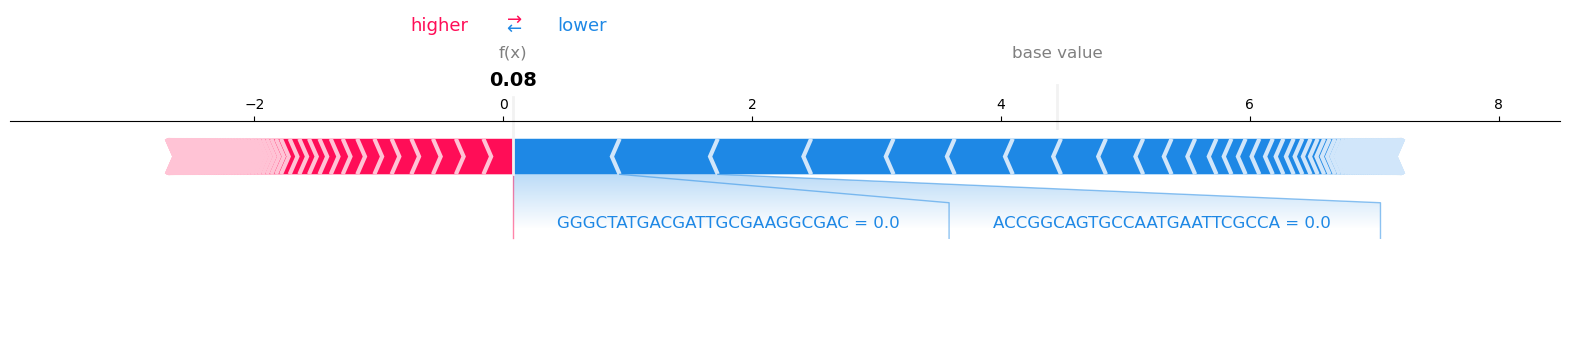

In [41]:
shap.force_plot(
    xgb_explainer.expected_value[0],
    test_xgb_shap_values[0][0, :],
    x_test.iloc[1, :],
    matplotlib=True,
)

In [42]:
feature_names = x_train.columns.values.tolist()
feature_names

['GGTCGAAGACGTAATCGCGGGTGAC',
 'GAAATCTGGCTGAAATCGATAGTGA',
 'GCCGCACGGGCTTAACAAGTCTCGA',
 'AGATCGGGGCGTTGAGGCCAAGCGC',
 'CTGGCAGCCTGTCTGATCTGCAAAA',
 'CGGAATTGCTGTCCACTTCCCAGGA',
 'AACGCAATGGACGCCAGCGAATAGA',
 'CGAAAGATTCGCACGATATTGCAAA',
 'ATTTCAAAATAACGAAGATCGGCAC',
 'AGAAGGGCGGCCACACGCGGTCCTG',
 'AAAGCGCGCCAGAATGGATTCGACG',
 'CCATTCCAAGCCCTTCGGCCAGATC',
 'AAACCGAGTTCATAAGAACCCGATT',
 'AAGCCCTTGGCGAAGATCGCCTCCG',
 'CTCACGCCACTCCCAAAACAGGGAA',
 'CTTATCGCCGTAACCCCTGTCGAAG',
 'GGCGCCGTAGGAAGCGATGATGTCA',
 'AACGGCAGCGCCAAGGCCGGAGCCT',
 'GAAACAGGAAAAGCCGATTGCCAGC',
 'AGCAAAAGCAGGAAAACCAGATCAA',
 'ATGCCACTGCCGACACCGCCAAAAT',
 'CGGTCGCGTCCGATCTTTCGGGCGA',
 'ATGCGTCTCACCAATCAGGTCAAAG',
 'CGAGCGGCAGCTTATCCTTGAGCAG',
 'CAAGTCCACTGTCGTCATGTTTGGC',
 'ACGCAGGCTGCAAGCGCAATACGAT',
 'CACGACCGCTCAGATCGAGAAGCTG',
 'TAGACGCGGTATGATGCGGCCGGGA',
 'CGTAATATTTCAGATCAATGTCGAG',
 'GCGCTGGAAGCGGTTGGCGGTTATA',
 'ATGATGCTGGTCTTTCGATGGGCCA',
 'ATCTCTTGTTGGGTTTTTATCCTCA',
 'AAGGCGCTGCAGACCGGCTCAAATC',
 'CATCCATG

In [43]:
pd.DataFrame(
    test_xgb_shap_values[0][0, :],
    index=feature_names,
    columns=["SHAP values"],
).sort_values('SHAP values', ascending=False)

,SHAP values
CTTCTGCGCAACCGCACACTCAGCA,0.236198
CGCGCTGCACTGATCTATCTCGAAA,0.221158
ATGGCCAAAGAACAAGGCGCGGGAA,0.184442
CGATCTCGCGATTGCCATTGCAGGC,0.173630
TCACTACAGCTAGAACGCATCCCGA,0.158800
...,...
AGAACCTCACCGTTGTTGAGGGTGG,-0.491129
AGCACGAAGCCGGAAGCTGCGCGTG,-0.662102
AAACAGTCATGGAGAAAGGCGTGCT,-0.750422
ACCGGCAGTGCCAATGAATTCGCCA,-0.788664


In [44]:
values = np.abs(train_xgb_shap_values[0]).mean(
    0
)  # mean of shapely values in each column
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
AAACAGTCATGGAGAAAGGCGTGCT,0.865289
ATGGCCAAAGAACAAGGCGCGGGAA,0.629100
GGGCTATGACGATTGCGAAGGCGAC,0.417494
AGAACCTCACCGTTGTTGAGGGTGG,0.412073
CATCTTGTCGTTTTCCGGCGTCGAG,0.333017
ACAGCGGCGGAGGAAGCCCGTCACC,0.244850
CTGCGCTGTTGCGAGCGAGCCGTGC,0.242267
AGCACGAAGCCGGAAGCTGCGCGTG,0.234052
CGCGCTGCACTGATCTATCTCGAAA,0.231759
CACCATGGACGGTGTGACGCGCGGC,0.225197


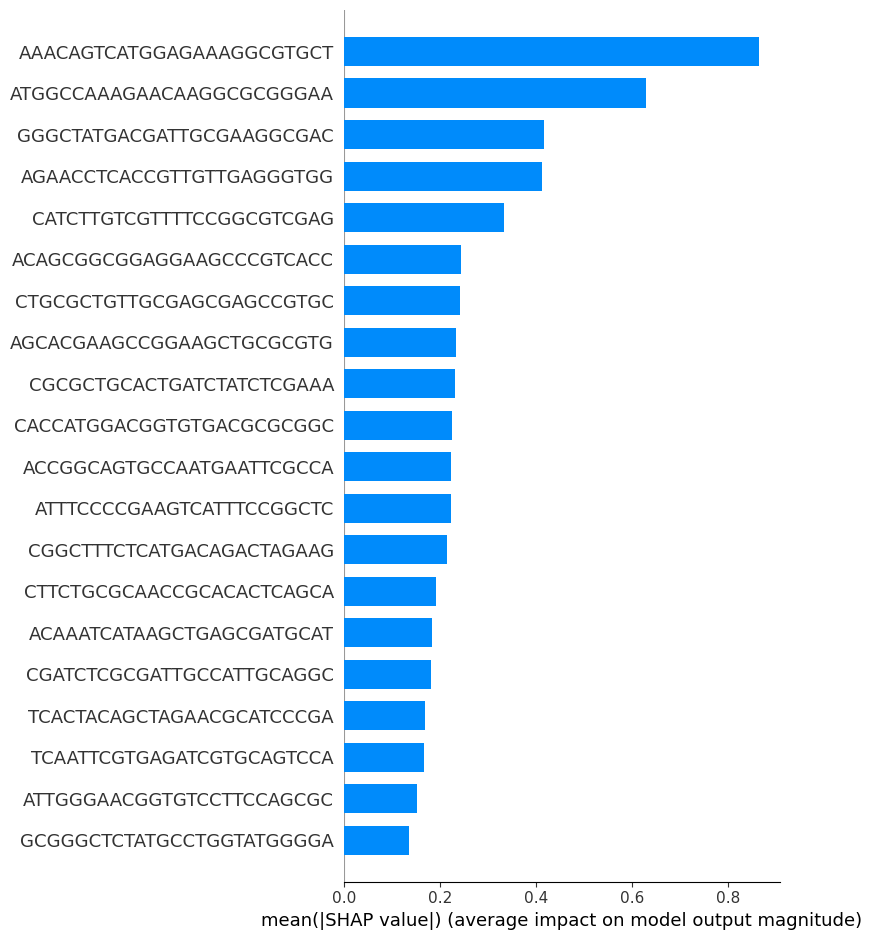

In [45]:
# global feature importances
shap.summary_plot(train_xgb_shap_values[0], x_train, plot_type="bar")

shap_sum = np.abs(train_xgb_shap_values).mean(axis=0)
importance_df = pd.DataFrame([x_train.columns.tolist(), shap_sum.tolist()]).T

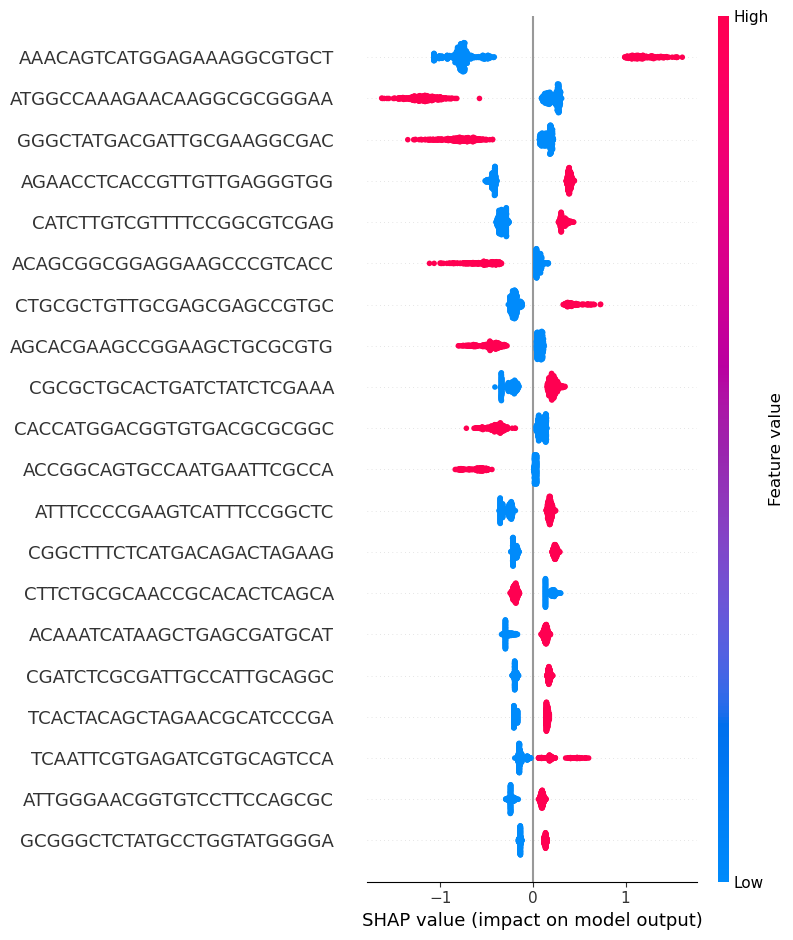

In [46]:
shap.summary_plot(train_xgb_shap_values[0], x_train)